In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBClassifier
import operator
import datetime

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
train = pd.read_csv('../input/train.csv',dtype={'StateHoliday':object}) 
store =  pd.read_csv('../input/store.csv')
test = pd.read_csv('../input/test.csv')

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)  

### 整理数据

#### 整理test数据

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [6]:
#补充缺失数据
# 特征Open存在数据缺失
# print(test.query('Open=="NaN"'))
#根据Open为NaN的数据展现，由于日期非节假日商店应该都是开门的把NaN替换成1，把0.0变成0，把1.0变成1
test['Open']=test['Open'].fillna(1)
test['Open']=test['Open'].astype(int)
# print(test['Open'].value_counts())

In [7]:
# 把date拆成year，month和day，重新设置DayOfWeek原因是DayOfWeek比dayofweek多1
test['Date']=pd.to_datetime(test['Date'])

test['Year']=test['Date'].dt.year
test['Month']=test['Date'].dt.month
test['Day']=test['Date'].dt.day
test['WeekOfYear']=test['Date'].dt.weekofyear
test['DayOfWeek']=test['Date'].dt.dayofweek
test.drop('Date',axis=1, inplace=True)

In [8]:
#设置StateHoliday a:1,b:2,c:3
test.loc[test["StateHoliday"]=='a','StateHoliday']=1
test.loc[test["StateHoliday"]=='b','StateHoliday']=2
test.loc[test["StateHoliday"]=='c','StateHoliday']=3
test['StateHoliday']=test['StateHoliday'].astype(int)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null int32
Promo            41088 non-null int64
StateHoliday     41088 non-null int32
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: int32(2), int64(9)
memory usage: 3.1 MB


In [9]:
# 如果open特征为0可以直接提交预测为0
test["Open"].value_counts()

1    35104
0     5984
Name: Open, dtype: int64

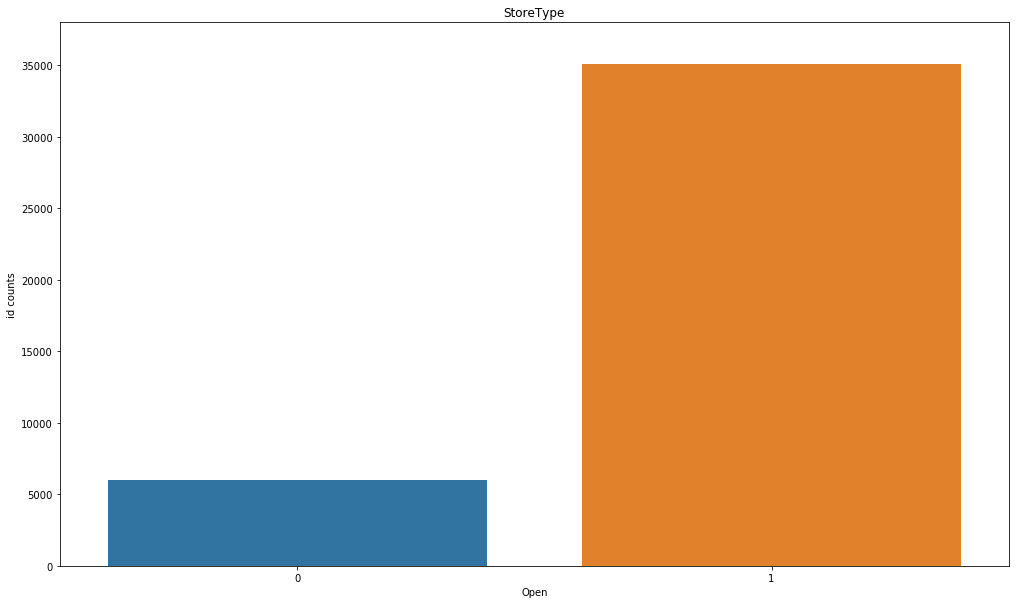

In [10]:
# 对open做可视化
po = test.groupby('Open')['Id'].count()
plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=38000)  
plt.title('StoreType')  
plt.ylabel('id counts')  
sns.barplot(po.index,po.values)
plt.show()

In [11]:
test.query('Open==0').count()

Id               5984
Store            5984
DayOfWeek        5984
Open             5984
Promo            5984
StateHoliday     5984
SchoolHoliday    5984
Year             5984
Month            5984
Day              5984
WeekOfYear       5984
dtype: int64

In [12]:
test.head()

Id  Store  DayOfWeek  Open  Promo  StateHoliday  SchoolHoliday  Year  \
0   1      1          3     1      1             0              0  2015   
1   2      3          3     1      1             0              0  2015   
2   3      7          3     1      1             0              0  2015   
3   4      8          3     1      1             0              0  2015   
4   5      9          3     1      1             0              0  2015   

   Month  Day  WeekOfYear  
0      9   17          38  
1      9   17          38  
2      9   17          38  
3      9   17          38  
4      9   17          38

#### 整理store数据

In [13]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [14]:
#处理缺失数据
#CompetitionDistance中缺失三条,缺失的数据里同时缺失CompetitionOpenSinceMonth和CompetitionOpenSinceYear，我将其认为在合理距离范围内无竞争对手。
print(store.query('CompetitionDistance=="NaN"')[['Store','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']])
#可以理解为合理范围内没有任何的竞争对手记下Store号码：291，622，879

     Store  CompetitionDistance  CompetitionOpenSinceMonth  \
290    291                  nan                        nan   
621    622                  nan                        nan   
878    879                  nan                        nan   

     CompetitionOpenSinceYear  
290                       nan  
621                       nan  
878                       nan  


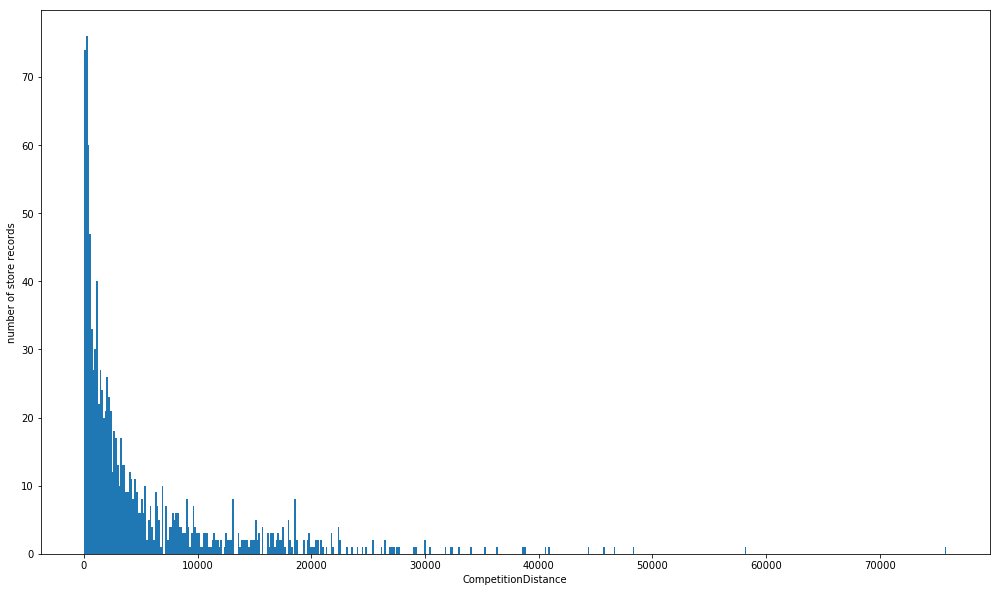

In [15]:
#查看CompetitionDistance的情况
store['CompetitionDistance'].describe()
#根据情况将291，622，879的CompetitionDistance距离改为99999
plt.subplots(1,1,figsize=(17,10))  
# plt.plot(store['CompetitionDistance'])
# plt.xlabel('Store')
# plt.ylabel('CompetitionDistance')
# plt.show()
# 对最重要的Sales做可视化
plt.hist(store['CompetitionDistance'].dropna(), bins=500)  
plt.xlabel('CompetitionDistance')  
plt.ylabel('number of store records')  
plt.show()

In [16]:
store.query('CompetitionDistance==0').count()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [17]:
store['CompetitionDistance'].describe()

count    1112.000
mean     5404.901
std      7663.175
min        20.000
25%       717.500
50%      2325.000
75%      6882.500
max     75860.000
Name: CompetitionDistance, dtype: float64

In [18]:
#根据情况将291，622，879的CompetitionDistance距离改为99999并转化为int型，将其CompetitionOpenSinceYear特征改为一个未来值
store['CompetitionDistance']=store['CompetitionDistance'].fillna(99999)
store['CompetitionDistance']=store['CompetitionDistance'].astype(int)
# store.query('Store in (291,622,879)')['CompetitionOpenSinceYear']=2030
store.loc[(store['Store']==291)|(store['Store']==622)|(store['Store']==879),'CompetitionOpenSinceYear']=2030

In [19]:
# 设置距离超过20km的CompetitionOpenSinceYear为2030
store.loc[store['CompetitionDistance']>30000,'CompetitionOpenSinceYear']=2030

In [20]:
# CompetitionOpenSinceMonth和CompetitionOpenSinceYear的缺失值
# 判断是否缺失的商店是同一个，输出同时为NaN的商店个数
print(len(store.query('CompetitionOpenSinceMonth=="NaN"&CompetitionOpenSinceYear=="NaN"')))

349


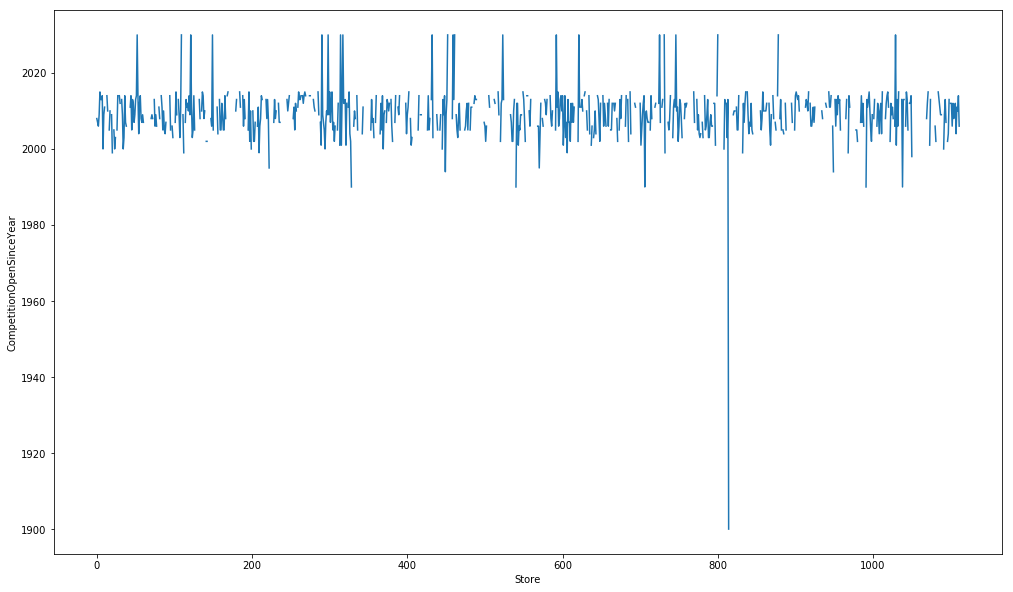

In [21]:
# 可视化CompetitionOpenSinceYear
# store['CompetitionOpenSinceYear'].describe()
plt.subplots(1,1,figsize=(17,10))  
plt.plot(store['CompetitionOpenSinceYear'])
plt.xlabel('Store')
plt.ylabel('CompetitionOpenSinceYear')
plt.show()

In [22]:
store['CompetitionOpenSinceYear'].describe()

count    766.000
mean    2009.242
std        7.115
min     1900.000
25%     2006.000
50%     2010.000
75%     2013.000
max     2030.000
Name: CompetitionOpenSinceYear, dtype: float64

In [23]:
# 1115-354=761所以均为同时为Nan，那就设置为一个较早的时间，认为是早已经开业的商店,并设置为int型
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].fillna(2010)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].median())
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].astype(int)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].astype(int)

In [24]:
# Promo2SinceWeek,Promo2SinceYear,PromoInterval的缺失值
# 确认他们缺失的是否是相同的store
nan = np.nan
print(len(store.query('Promo2SinceWeek=="NaN"&Promo2SinceYear=="NaN"&PromoInterval.isnull()')))

544


In [25]:
# 1115-544=571,571符合这三个特征的缺失数，得出结论就是这三个特征是同时缺失的，看看此时的Promo2的值是多少
store.query('Promo2SinceWeek=="NaN"&Promo2SinceYear=="NaN"&PromoInterval.isnull()')['Promo2'].value_counts()

0    544
Name: Promo2, dtype: int64

In [26]:
# 查看0的总总数量和Promo2SinceWeek,Promo2SinceYear,PromoInterval缺失值保持一致
store['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [27]:
# 将Promo2SinceYear设置为一个未来的时间，Promo2SinceWeek设置为1
store['Promo2SinceWeek']=store['Promo2SinceWeek'].fillna(0)
store['Promo2SinceYear']=store['Promo2SinceYear'].fillna(2030)
store['Promo2SinceWeek']=store['Promo2SinceWeek'].astype(int)
store['Promo2SinceYear']=store['Promo2SinceYear'].astype(int)

In [28]:
#处理PromoInterval,
print(store['PromoInterval'].value_counts())
num_month = {'Jan,Apr,Jul,Oct':'0,3,6,9','Feb,May,Aug,Nov':'1,4,7,10','Mar,Jun,Sept,Dec':'2,5,8,11'}
store['PromoInterval'] =store['PromoInterval'].map(num_month)
store['PromoInterval']=store['PromoInterval'].fillna('0,0,0,0')
store.head()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64


Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a                 1270                          9   
1      2         a          a                  570                         11   
2      3         a          a                14130                         12   
3      4         c          c                  620                          9   
4      5         a          a                29910                          4   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                      2008       0                0             2030   
1                      2007       1               13             2010   
2                      2006       1               14             2011   
3                      2009       0                0             2030   
4                      2015       0                0             2030   

  PromoInterval  
0       0,0,0,0  
1       0,3,6,9  
2       0,3,6,9  
3       0,0,0,0  
4       0,0,0,0

In [29]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval                1115 non-null object
dtypes: int32(5), int64(2), object(3)
memory usage: 65.4+ KB


In [30]:
print(store['PromoInterval'].value_counts())

0,0,0,0     544
0,3,6,9     335
1,4,7,10    130
2,5,8,11    106
Name: PromoInterval, dtype: int64


In [31]:
# 将PromoInterval展开
PromoInterval1=[]
PromoInterval2=[]
PromoInterval3=[]
PromoInterval4=[]
m=store['PromoInterval']
for x in m:
    y=x.split(',')
    PromoInterval1.append(y[0])
    PromoInterval2.append(y[1])
    PromoInterval3.append(y[2])
    PromoInterval4.append(y[3])

store['PromoInterval1']=pd.Series(PromoInterval1,dtype='int32')
store['PromoInterval2']=pd.Series(PromoInterval2,dtype='int32')
store['PromoInterval3']=pd.Series(PromoInterval3,dtype='int32')
store['PromoInterval4']=pd.Series(PromoInterval4,dtype='int32')
store.drop('PromoInterval',axis=1, inplace=True)

In [32]:
#处理两个Object字段
#把Assortment整理为a:1,b:2,c:3
store.loc[store["Assortment"]=='a','Assortment']=1
store.loc[store["Assortment"]=='b','Assortment']=2
store.loc[store["Assortment"]=='c','Assortment']=3
store['Assortment']=store['Assortment'].astype(int)
#把StoreType整理为a:1,b:2,c:3,d:4
store.loc[store["StoreType"]=='a','StoreType']=1
store.loc[store["StoreType"]=='b','StoreType']=2
store.loc[store["StoreType"]=='c','StoreType']=3
store.loc[store["StoreType"]=='d','StoreType']=4
store['StoreType']=store['StoreType'].astype(int)

In [33]:
#针对Assortment，StoreType特征做one-hot
store= pd.concat([store,pd.get_dummies(store['Assortment'],prefix='Assortment')], axis=1)
store.drop('Assortment',axis=1, inplace=True)
store= pd.concat([store,pd.get_dummies(store['StoreType'],prefix='StoreType')], axis=1)
store.drop('StoreType',axis=1, inplace=True)
store.head()

Store  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1                 1270                          9   
1      2                  570                         11   
2      3                14130                         12   
3      4                  620                          9   
4      5                29910                          4   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                      2008       0                0             2030   
1                      2007       1               13             2010   
2                      2006       1               14             2011   
3                      2009       0                0             2030   
4                      2015       0                0             2030   

   PromoInterval1  PromoInterval2  PromoInterval3  PromoInterval4  \
0               0               0               0               0   
1               0               3               6               9   
2               0               3               6               9   
3               0               0               0               0   
4               0               0               0               0   

   Assortment_1  Assortment_2  Assortment_3  StoreType_1  StoreType_2  \
0             1             0             0            0            0   
1             1             0             0            1            0   
2             1             0             0            1            0   
3             0             0             1            0            0   
4             1             0             0            1            0   

   StoreType_3  StoreType_4  
0            1            0  
1            0            0  
2            0            0  
3            1            0  
4            0            0

In [34]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 18 columns):
Store                        1115 non-null int64
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval1               1115 non-null int32
PromoInterval2               1115 non-null int32
PromoInterval3               1115 non-null int32
PromoInterval4               1115 non-null int32
Assortment_1                 1115 non-null uint8
Assortment_2                 1115 non-null uint8
Assortment_3                 1115 non-null uint8
StoreType_1                  1115 non-null uint8
StoreType_2                  1115 non-null uint8
StoreType_3                  1115 non-null uint8
StoreType_4                  1115 non-null uint8
dtypes: int

In [35]:
store.head()

Store  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1                 1270                          9   
1      2                  570                         11   
2      3                14130                         12   
3      4                  620                          9   
4      5                29910                          4   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                      2008       0                0             2030   
1                      2007       1               13             2010   
2                      2006       1               14             2011   
3                      2009       0                0             2030   
4                      2015       0                0             2030   

   PromoInterval1  PromoInterval2  PromoInterval3  PromoInterval4  \
0               0               0               0               0   
1               0               3               6               9   
2               0               3               6               9   
3               0               0               0               0   
4               0               0               0               0   

   Assortment_1  Assortment_2  Assortment_3  StoreType_1  StoreType_2  \
0             1             0             0            0            0   
1             1             0             0            1            0   
2             1             0             0            1            0   
3             0             0             1            0            0   
4             1             0             0            1            0   

   StoreType_3  StoreType_4  
0            1            0  
1            0            0  
2            0            0  
3            1            0  
4            0            0

#### 整理train数据

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


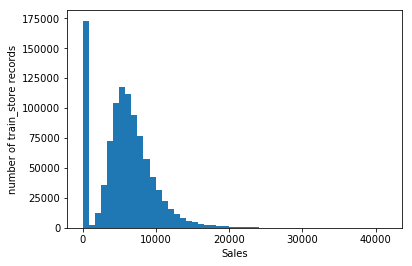

In [37]:
# 对最重要的Sales做可视化
plt.hist(train['Sales'], bins=50)  
plt.xlabel('Sales')  
plt.ylabel('number of train_store records')  
plt.show()

In [38]:
# 查看open为0的数据的Sales和Customers
print(train.query('Open=="0"')['Sales'].value_counts())
print(train.query('Open=="0"')['Customers'].value_counts())

0    172817
Name: Sales, dtype: int64
0    172817
Name: Customers, dtype: int64


In [39]:
#可以认为open为0对于训练没有什么帮助所以我们只训练open==1的
len(train.query('Open==1'))

844392

In [40]:
# 844392+172817=1017209 所以open==1作为训练对象
train=train.query('Open==1')

In [41]:
# 按照test的方式处理Data
train['Date']=pd.to_datetime(train['Date'])

train['Year']=train['Date'].dt.year
train['Month']=train['Date'].dt.month
train['Day']=train['Date'].dt.day
train['WeekOfYear']=train['Date'].dt.weekofyear
train['DayOfWeek']=train['Date'].dt.dayofweek
train.drop('Date',axis=1, inplace=True)

In [42]:
#设置StateHoliday a:1,b:2,c:3
train.loc[train["StateHoliday"]=='a','StateHoliday']=1
train.loc[train["StateHoliday"]=='b','StateHoliday']=2
train.loc[train["StateHoliday"]=='c','StateHoliday']=3
train['StateHoliday']=train['StateHoliday'].astype(int)

In [43]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 12 columns):
Store            844392 non-null int64
DayOfWeek        844392 non-null int64
Sales            844392 non-null int64
Customers        844392 non-null int64
Open             844392 non-null int64
Promo            844392 non-null int64
StateHoliday     844392 non-null int32
SchoolHoliday    844392 non-null int64
Year             844392 non-null int64
Month            844392 non-null int64
Day              844392 non-null int64
WeekOfYear       844392 non-null int64
dtypes: int32(1), int64(11)
memory usage: 80.5 MB
None


#### 合并数据

In [44]:
#合并test，先把test里open为0的数据提出来直接输出sales=0
result_0=pd.DataFrame({"Id": test.query('Open==0')['Id'], 'Sales':0})
result_0.head()

Id  Sales
543    544      0
676    677      0
840    841      0
1399  1400      0
1532  1533      0

In [45]:
len(test.query('Open==1'))

35104

In [46]:
# 对于剩下test来跑predict再合并
test_data = pd.merge(test.query('Open==1'), store, on='Store')

In [47]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 0 to 35103
Data columns (total 28 columns):
Id                           35104 non-null int64
Store                        35104 non-null int64
DayOfWeek                    35104 non-null int64
Open                         35104 non-null int32
Promo                        35104 non-null int64
StateHoliday                 35104 non-null int32
SchoolHoliday                35104 non-null int64
Year                         35104 non-null int64
Month                        35104 non-null int64
Day                          35104 non-null int64
WeekOfYear                   35104 non-null int64
CompetitionDistance          35104 non-null int32
CompetitionOpenSinceMonth    35104 non-null int32
CompetitionOpenSinceYear     35104 non-null int32
Promo2                       35104 non-null int64
Promo2SinceWeek              35104 non-null int32
Promo2SinceYear              35104 non-null int32
PromoInterval1               35104 non-nu

In [48]:
print(train.info())
train_data = pd.merge(train, store, on='Store')
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 12 columns):
Store            844392 non-null int64
DayOfWeek        844392 non-null int64
Sales            844392 non-null int64
Customers        844392 non-null int64
Open             844392 non-null int64
Promo            844392 non-null int64
StateHoliday     844392 non-null int32
SchoolHoliday    844392 non-null int64
Year             844392 non-null int64
Month            844392 non-null int64
Day              844392 non-null int64
WeekOfYear       844392 non-null int64
dtypes: int32(1), int64(11)
memory usage: 80.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 29 columns):
Store                        844392 non-null int64
DayOfWeek                    844392 non-null int64
Sales                        844392 non-null int64
Customers                    844392 non-null int64
Open                         844392 non-null int64

In [49]:
train.head()

Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
0      1          4   5263        555     1      1             0   
1      2          4   6064        625     1      1             0   
2      3          4   8314        821     1      1             0   
3      4          4  13995       1498     1      1             0   
4      5          4   4822        559     1      1             0   

   SchoolHoliday  Year  Month  Day  WeekOfYear  
0              1  2015      7   31          31  
1              1  2015      7   31          31  
2              1  2015      7   31          31  
3              1  2015      7   31          31  
4              1  2015      7   31          31

In [50]:
test_data.set_index(['Id'],inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 1 to 40909
Data columns (total 27 columns):
Store                        35104 non-null int64
DayOfWeek                    35104 non-null int64
Open                         35104 non-null int32
Promo                        35104 non-null int64
StateHoliday                 35104 non-null int32
SchoolHoliday                35104 non-null int64
Year                         35104 non-null int64
Month                        35104 non-null int64
Day                          35104 non-null int64
WeekOfYear                   35104 non-null int64
CompetitionDistance          35104 non-null int32
CompetitionOpenSinceMonth    35104 non-null int32
CompetitionOpenSinceYear     35104 non-null int32
Promo2                       35104 non-null int64
Promo2SinceWeek              35104 non-null int32
Promo2SinceYear              35104 non-null int32
PromoInterval1               35104 non-null int32
PromoInterval2               35104 non-nu

#### 数据探索

将CompetitionOpenSinceMonth,CompetitionOpenSinceYear合并为一个特征CompetitionMonths，  
将Promo2SinceWeek Promo2SinceYear PromoInterval合并为一个特征IsPromo2

In [51]:
train_data['CompetitionOpenSinceMonth'].value_counts()    
train_data['Month'].value_counts()

1     86343
3     85980
7     85587
6     82576
4     81731
2     80243
5     80103
8     54413
10    53292
9     52330
11    51401
12    50393
Name: Month, dtype: int64

In [52]:
# 先处理train的
# 计算月份相差
train_data['CompetitionMonths']=(train_data['Year']-train_data['CompetitionOpenSinceYear'])*12+(train_data['Month']-train_data['CompetitionOpenSinceMonth'])


In [53]:
# 如果CompetitionMonths为负数则赋值为0
train_data['CompetitionMonths'].max()
train_data.loc[train_data['CompetitionMonths']==1386,'CompetitionOpenSinceYear']

615236    1900
615237    1900
615238    1900
615239    1900
615240    1900
615241    1900
615242    1900
615243    1900
615244    1900
615245    1900
615246    1900
615247    1900
615248    1900
615249    1900
615250    1900
615251    1900
615252    1900
615253    1900
615254    1900
615255    1900
615256    1900
615257    1900
615258    1900
615259    1900
615260    1900
615261    1900
615262    1900
Name: CompetitionOpenSinceYear, dtype: int32

In [54]:
train_data['CompetitionOpenSinceYear'].value_counts()

2010    304165
2012     60837
2013     58206
2014     52035
2005     46705
2011     41366
2009     40713
2008     37078
2007     36131
2006     35543
2015     28844
2002     19956
2030     17634
2004     16334
2003     13834
2001     12157
2000      7631
1999      6213
1990      3887
1994      1552
1995      1404
1961       779
1998       766
1900       622
Name: CompetitionOpenSinceYear, dtype: int64

In [55]:
train_data.loc[train_data['CompetitionMonths']<0,'CompetitionMonths']=0

In [56]:
# 去掉CompetitionOpenSinceMonth,CompetitionOpenSinceYear
train_data.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1, inplace=True)

In [57]:
# 对test_data做同样的操作
test_data['CompetitionMonths']=(test_data['Year']-test_data['CompetitionOpenSinceYear'])*12+(test_data['Month']-test_data['CompetitionOpenSinceMonth'])
test_data.loc[test_data['CompetitionMonths']<0,'CompetitionMonths']=0
test_data.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1, inplace=True)

In [58]:
train_data['Promo2SinceWeek'].value_counts()

0     423307
14     60541
40     51507
31     33238
10     32214
5      29722
37     27116
1      26873
13     24579
45     24072
22     23645
18     22456
35     18888
9      10293
27      7925
36      7620
48      7033
39      3889
23      3558
44      2182
26       782
50       780
28       779
6        771
49       622
Name: Promo2SinceWeek, dtype: int64

In [59]:
# 处理Promo2相关特征
# 先处理train_data
train_data['IsPromo2']=0
train_data.loc[(train_data['Promo2']==1)&((train_data['PromoInterval1']==train_data['Month'])|(train_data['PromoInterval2']==train_data['Month'])|(train_data['PromoInterval3']==train_data['Month'])|(train_data['PromoInterval4']==train_data['Month']))&(((train_data['Promo2SinceYear']==train_data['Year'])&(train_data['Promo2SinceWeek']<=train_data['WeekOfYear']))|train_data['Promo2SinceYear']<train_data['Year']),'IsPromo2']=1

In [60]:
train_data['IsPromo2'].value_counts()

0    718900
1    125492
Name: IsPromo2, dtype: int64

In [61]:
# 计算参加Promo2的时间按周计算，如果Promo2为0就为0
train_data['Promo2weeks']=train_data['Promo2']*((train_data['Year']-train_data['Promo2SinceYear'])*54+(train_data['WeekOfYear']-train_data['Promo2SinceWeek']))

In [62]:
# 如果为负数就设置为0
train_data.loc[train_data['Promo2weeks']<0,'Promo2weeks']=0

In [63]:
train_data['Promo2weeks'].value_counts()

0      481933
100      1820
101      1811
96       1779
105      1768
98       1738
95       1715
99       1709
106      1681
97       1677
102      1674
104      1667
103      1644
108      1619
128      1613
107      1608
129      1601
109      1599
110      1598
111      1589
33       1586
38       1586
41       1584
124      1578
133      1566
131      1561
132      1556
119      1549
187      1543
42       1541
        ...  
289       431
291       430
286       427
308       425
287       425
292       414
297       408
299       407
309       403
305       402
294       398
307       389
293       384
310       379
302       373
301       373
312       258
314       258
317       252
316       251
315       251
313       251
311       251
318       217
323        42
322        42
321        42
320        42
319        42
324        35
Name: Promo2weeks, Length: 325, dtype: int64

In [64]:
# 删除Promo2SinceWeek Promo2SinceYear PromoInterval
train_data.drop(['Promo2SinceWeek','Promo2SinceYear','PromoInterval1','PromoInterval2','PromoInterval3','PromoInterval4'],axis=1, inplace=True)

In [65]:
# 在test_data上也按照这个思路处理Promo2相关特征
test_data['IsPromo2']=0
test_data.loc[(test_data['Promo2']==1)&((test_data['PromoInterval1']==test_data['Month'])|(test_data['PromoInterval2']==test_data['Month'])|(test_data['PromoInterval3']==test_data['Month'])|(test_data['PromoInterval4']==test_data['Month']))&(((test_data['Promo2SinceYear']==test_data['Year'])&(test_data['Promo2SinceWeek']<=test_data['WeekOfYear']))|test_data['Promo2SinceYear']<test_data['Year']),'IsPromo2']=1

In [66]:
test_data['Promo2weeks']=test_data['Promo2']*((test_data['Year']-test_data['Promo2SinceYear'])*54+(test_data['WeekOfYear']-test_data['Promo2SinceWeek']))

In [67]:
test_data.loc[test_data['Promo2weeks']<0,'Promo2weeks']=0

In [68]:
test_data.drop(['Promo2SinceWeek','Promo2SinceYear','PromoInterval1','PromoInterval2','PromoInterval3','PromoInterval4'],axis=1, inplace=True)

In [69]:
# 对StateHoliday做one_hot
# 先对train_data
train_data= pd.concat([train_data,pd.get_dummies(train_data['StateHoliday'],prefix='StateHoliday')], axis=1)
train_data.drop('StateHoliday',axis=1, inplace=True)

In [70]:
# 再处理test_data
test_data= pd.concat([test_data,pd.get_dummies(test_data['StateHoliday'],prefix='StateHoliday')], axis=1)
test_data.drop('StateHoliday',axis=1, inplace=True)

In [71]:
print(train_data.columns)
print(test_data.columns)

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'CompetitionDistance', 'Promo2', 'Assortment_1', 'Assortment_2',
       'Assortment_3', 'StoreType_1', 'StoreType_2', 'StoreType_3',
       'StoreType_4', 'CompetitionMonths', 'IsPromo2', 'Promo2weeks',
       'StateHoliday_0', 'StateHoliday_1', 'StateHoliday_2', 'StateHoliday_3'],
      dtype='object')
Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Year', 'Month',
       'Day', 'WeekOfYear', 'CompetitionDistance', 'Promo2', 'Assortment_1',
       'Assortment_2', 'Assortment_3', 'StoreType_1', 'StoreType_2',
       'StoreType_3', 'StoreType_4', 'CompetitionMonths', 'IsPromo2',
       'Promo2weeks', 'StateHoliday_0', 'StateHoliday_1'],
      dtype='object')


In [72]:
print(train_data['StateHoliday_2'].value_counts())

0    844247
1       145
Name: StateHoliday_2, dtype: int64


In [73]:
# 补充test_data相对于train_data少的两个特征
test_data['StateHoliday_2']=0
test_data['StateHoliday_3']=0

#### 建模预测

In [74]:
# Store字段转变为object
# train_data['Store']=train_data['Store'].astype(object)
# test_data['Store']=test_data['Store'].astype(object)

Year
2013    337943
2014    310417
2015    196032
Name: Open, dtype: int64


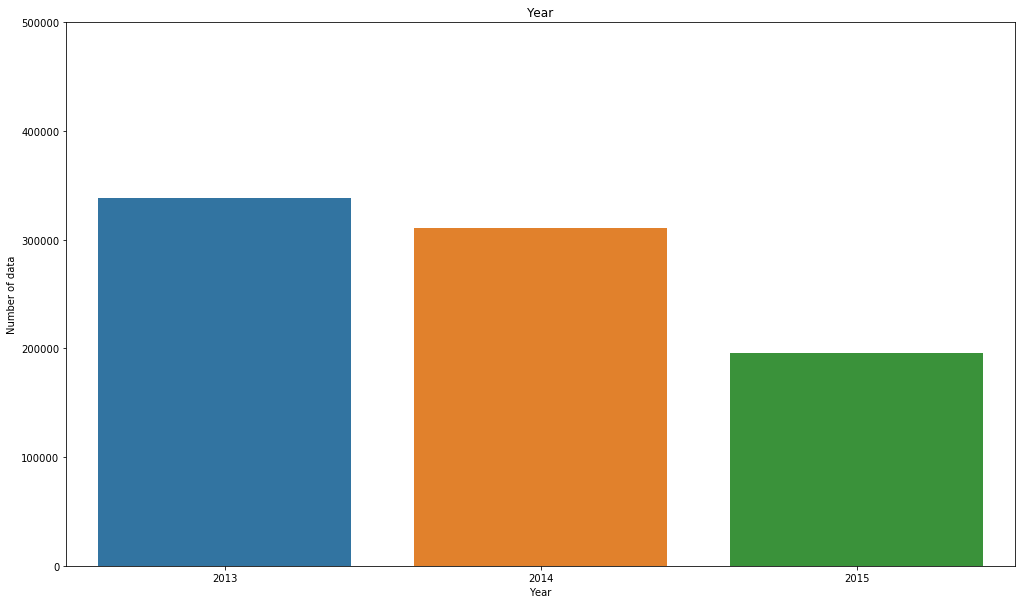

In [75]:
pt = train_data.groupby('Year')['Open'].count()
print(pt)
plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=500000)  
plt.title('Year')  
plt.ylabel('Number of data')  
sns.barplot(pt.index,pt.values)
plt.show()
# 2015年数据有236380作为测试数据还是有点多的接下来看看月份数据分布

Month
1    28763
2    26767
3    29080
4    26931
5    25880
6    28423
7    30188
Name: Open, dtype: int64


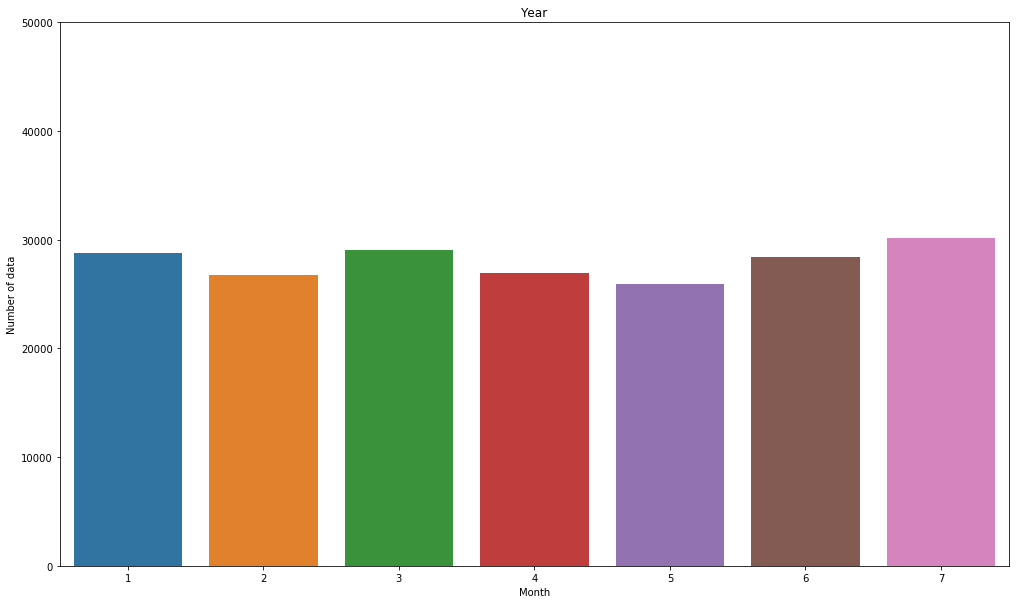

In [76]:
# 展现2015年各个月份的数据
pt = train_data.query('Year==2015').groupby('Month')['Open'].count()
print(pt)
plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=50000)  
plt.title('Year')  
plt.ylabel('Number of data')  
sns.barplot(pt.index,pt.values)
plt.show()

In [77]:
# 展现test有哪些月数据
test_data['Year'].value_counts()
test_data['Month'].value_counts()

8    22228
9    12876
Name: Month, dtype: int64

In [78]:
print(train_data.query('Year==2015&Month==7')['Open'].count()/train_data['Open'].count())
print(train_data.query('Year==2015&Month==7')['Open'].count()+train_data.query('Year==2013|Year==2014|(Year==2015&Month!=7)')['Open'].count())
print(train_data['Open'].count())
train_a=train_data.query('Year==2015&Month==7')
train_b=train_data.query('Year==2013|Year==2014|(Year==2015&Month!=7)')
print(len(train_a)+len(train_b))

0.0357511677041
844392
844392
844392


In [79]:
# 确认训练特征和比对label
y_test=train_a['Sales']
X_test=train_a.drop(['Customers','Sales'],axis=1)

y_train=train_b['Sales']
X_train=train_b.drop(['Customers','Sales'],axis=1)


In [80]:
# X_train, X_test, y_train, y_test =train_test_split(train_data,train_target, test_size=0.1, random_state=0)

In [81]:
# 建立测试函数
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

def rmpse_estimator(estimator, X, y):
    yhat = estimator.predict(X)
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return rmspe

In [82]:
train_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30188 entries, 0 to 843634
Data columns (total 27 columns):
Store                  30188 non-null int64
DayOfWeek              30188 non-null int64
Sales                  30188 non-null int64
Customers              30188 non-null int64
Open                   30188 non-null int64
Promo                  30188 non-null int64
SchoolHoliday          30188 non-null int64
Year                   30188 non-null int64
Month                  30188 non-null int64
Day                    30188 non-null int64
WeekOfYear             30188 non-null int64
CompetitionDistance    30188 non-null int32
Promo2                 30188 non-null int64
Assortment_1           30188 non-null uint8
Assortment_2           30188 non-null uint8
Assortment_3           30188 non-null uint8
StoreType_1            30188 non-null uint8
StoreType_2            30188 non-null uint8
StoreType_3            30188 non-null uint8
StoreType_4            30188 non-null uint8
Competitio

In [83]:
len(train_b.groupby('Store')['Sales'].mean())

1115

In [84]:
# 建立基准模型使用
train_mean=train_a.groupby('Store')[['Store','Sales']].mean()
train_mean=pd.merge(train_mean, train_b[['Store','Sales']], on='Store')
train_mean[['Sales_x','Sales_y']]

Sales_x  Sales_y
0      4491.333     5735
1      4491.333     5197
2      4491.333     4019
3      4491.333     3317
4      4491.333     3533
5      4491.333     3346
6      4491.333     3762
7      4491.333     3846
8      4491.333     4097
9      4491.333     4202
10     4491.333     4645
11     4491.333     4000
12     4491.333     4852
13     4491.333     5518
14     4491.333     4256
15     4491.333     3695
16     4491.333     3627
17     4491.333     3591
18     4491.333     4102
19     4491.333     4071
20     4491.333     4183
21     4491.333     5384
22     4491.333     5809
23     4491.333     5450
24     4491.333     5774
25     4491.333     5592
26     4491.333     4656
27     4491.333     4111
28     4491.333     4083
29     4491.333     4211
...         ...      ...
814174 7021.741     6126
814175 7021.741     6670
814176 7021.741     5411
814177 7021.741     4584
814178 7021.741     4711
814179 7021.741     3813
814180 7021.741     3397
814181 7021.741     3615
814182 7021.741     4896
814183 7021.741     5082
814184 7021.741     5650
814185 7021.741     5176
814186 7021.741     5388
814187 7021.741     3723
814188 7021.741     5207
814189 7021.741     4287
814190 7021.741     3039
814191 7021.741     3064
814192 7021.741     3528
814193 7021.741     3158
814194 7021.741     4497
814195 7021.741     5142
814196 7021.741     5007
814197 7021.741     4649
814198 7021.741     5243
814199 7021.741     6905
814200 7021.741     4771
814201 7021.741     4540
814202 7021.741     4297
814203 7021.741     3697

[814204 rows x 2 columns]

In [85]:
# 检验基本模型的结果
error = rmspe(train_mean['Sales_y'], train_mean['Sales_x'])
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.293988


In [86]:
# Ridge模型测试
clf = Ridge(alpha=1)
clf.fit(X_train,np.log1p(y_train))

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [87]:
# 测试Ridge模型结果
yhat = clf.predict(X_test)
error = rmspe(y_test.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.370419


In [88]:
# RidgeCV参数优化
clf = RidgeCV(alphas=[0.1, 0.5, 1.0, 10.0], cv=10, fit_intercept=True,scoring=rmpse_estimator)
starttime = datetime.datetime.now()
clf.fit(X_train,np.log1p(y_train))
endtime = datetime.datetime.now()
print (endtime - starttime)
print ('alpha: ', clf.alpha_)
print ('coef_：', clf.coef_)


0:00:33.370633
alpha:  0.1
coef_： [  4.20361901e-06  -2.09687019e-02   0.00000000e+00   3.24441846e-01
   1.84656308e-02   2.88626230e-02   8.08181330e-03  -6.12565454e-04
   4.58661838e-04  -3.18760968e-06  -1.31040603e-01   5.08968691e-02
  -2.18634402e-01   1.67736889e-01  -1.39159110e-01   4.08211773e-01
  -1.36521052e-01  -1.32533418e-01  -3.29577565e-06  -4.13455624e-03
   2.85921156e-04   5.94091866e-02  -4.09625960e-02  -7.19426570e-02
   5.34960691e-02]


In [89]:
# 测试RidgeCV模型结果
yhat = clf.predict(X_test)
error = rmspe(y_test.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.370419


In [90]:
# Ridge结论输出
starttime = datetime.datetime.now()
test_probs = clf.predict(test_data)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("ridge_submission.csv", index=False)

0:00:00.013019
41088


Kaggle进行评分是0.41700

In [91]:
# Lasso模型测试
clf = Lasso(alpha=3.0)
clf.fit(X_train,np.log1p(y_train))

Lasso(alpha=3.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [92]:
# 测试Lasso模型结果
yhat = clf.predict(X_test)
error = rmspe(y_test.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.474838


In [93]:
# LassoCV参数优化
clf = LassoCV(cv=20)
starttime = datetime.datetime.now()
clf.fit(X_train,np.log1p(y_train))
endtime = datetime.datetime.now()
print (endtime - starttime)
print ('alpha: ', clf.alpha_)
print ('coef：', clf.coef_)

0:00:21.809831
alpha:  0.169672004897
coef： [ -0.00000000e+00  -0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00  -9.79550880e-04
   1.32258829e-03  -2.14830854e-06  -0.00000000e+00  -0.00000000e+00
   0.00000000e+00   0.00000000e+00  -0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -2.22946679e-04  -0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]


In [94]:
# 测试LassoCV模型结果
yhat = clf.predict(X_test)
error = rmspe(y_test.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.471350


In [95]:
# Lasso结论输出
starttime = datetime.datetime.now()
test_probs = clf.predict(test_data)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("lasso_submission.csv", index=False)

0:00:00.010015
41088


Kaggle进行评分是0.43365

In [96]:
print(X_train.info())
print(X_test.info())
print(y_train.describe())
print(y_test.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 814204 entries, 27 to 844391
Data columns (total 25 columns):
Store                  814204 non-null int64
DayOfWeek              814204 non-null int64
Open                   814204 non-null int64
Promo                  814204 non-null int64
SchoolHoliday          814204 non-null int64
Year                   814204 non-null int64
Month                  814204 non-null int64
Day                    814204 non-null int64
WeekOfYear             814204 non-null int64
CompetitionDistance    814204 non-null int32
Promo2                 814204 non-null int64
Assortment_1           814204 non-null uint8
Assortment_2           814204 non-null uint8
Assortment_3           814204 non-null uint8
StoreType_1            814204 non-null uint8
StoreType_2            814204 non-null uint8
StoreType_3            814204 non-null uint8
StoreType_4            814204 non-null uint8
CompetitionMonths      814204 non-null int64
IsPromo2               814204 non

In [97]:
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_test, np.log1p(y_test))
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.05
          }
num_trees = 2000

初次提交是0.13768，经过多次尝试目前使用这套参数的kaggle提交分数是0.12256

In [98]:
starttime = datetime.datetime.now()
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
endtime = datetime.datetime.now()
print (endtime - starttime)

[0]	train-rmse:7.85522	eval-rmse:7.87633	train-rmspe:0.99971	eval-rmspe:0.999751
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.46331	eval-rmse:7.48388	train-rmspe:0.999506	eval-rmspe:0.999553
[2]	train-rmse:7.09101	eval-rmse:7.11173	train-rmspe:0.999223	eval-rmspe:0.999279
[3]	train-rmse:6.73734	eval-rmse:6.75768	train-rmspe:0.998837	eval-rmspe:0.998904
[4]	train-rmse:6.40143	eval-rmse:6.42117	train-rmspe:0.998321	eval-rmspe:0.998402
[5]	train-rmse:6.08242	eval-rmse:6.10103	train-rmspe:0.997641	eval-rmspe:0.997739
[6]	train-rmse:5.77932	eval-rmse:5.79752	train-rmspe:0.996763	eval-rmspe:0.996883
[7]	train-rmse:5.49142	eval-rmse:5.50964	train-rmspe:0.995644	eval-rmspe:0.995794
[8]	train-rmse:5.218	eval-rmse:5.23497	train-rmspe:0.994237	eval-rmspe:0.994418
[9]	train-rmse:4.95829	eval-rmse:4.97468	train-rmspe:0.992497	eval-rmspe:0.992715
[10]	train-rmse:4.71155	eval-rmse:4.7

[97]	train-rmse:0.25787	eval-rmse:0.256417	train-rmspe:0.283724	eval-rmspe:0.256606
[98]	train-rmse:0.257157	eval-rmse:0.25576	train-rmspe:0.284245	eval-rmspe:0.256989
[99]	train-rmse:0.255598	eval-rmse:0.254394	train-rmspe:0.283763	eval-rmspe:0.256559
[100]	train-rmse:0.254074	eval-rmse:0.253122	train-rmspe:0.283293	eval-rmspe:0.256194
[101]	train-rmse:0.252239	eval-rmse:0.251691	train-rmspe:0.282335	eval-rmspe:0.255641
[102]	train-rmse:0.251668	eval-rmse:0.251182	train-rmspe:0.282787	eval-rmspe:0.256016
[103]	train-rmse:0.250323	eval-rmse:0.25018	train-rmspe:0.280129	eval-rmspe:0.25583
[104]	train-rmse:0.249561	eval-rmse:0.249384	train-rmspe:0.280047	eval-rmspe:0.255892
[105]	train-rmse:0.247244	eval-rmse:0.247297	train-rmspe:0.278256	eval-rmspe:0.254349
[106]	train-rmse:0.246616	eval-rmse:0.246845	train-rmspe:0.278201	eval-rmspe:0.254473
[107]	train-rmse:0.246004	eval-rmse:0.246297	train-rmspe:0.278343	eval-rmspe:0.254511
[108]	train-rmse:0.245479	eval-rmse:0.245897	train-rmspe:0.27

[193]	train-rmse:0.183582	eval-rmse:0.193358	train-rmspe:0.225266	eval-rmspe:0.206753
[194]	train-rmse:0.182739	eval-rmse:0.192478	train-rmspe:0.224423	eval-rmspe:0.205737
[195]	train-rmse:0.182381	eval-rmse:0.192206	train-rmspe:0.22397	eval-rmspe:0.20547
[196]	train-rmse:0.181926	eval-rmse:0.191848	train-rmspe:0.223129	eval-rmspe:0.20508
[197]	train-rmse:0.181599	eval-rmse:0.191632	train-rmspe:0.222862	eval-rmspe:0.204819
[198]	train-rmse:0.180936	eval-rmse:0.191066	train-rmspe:0.222235	eval-rmspe:0.204225
[199]	train-rmse:0.180816	eval-rmse:0.190962	train-rmspe:0.221913	eval-rmspe:0.204116
[200]	train-rmse:0.1802	eval-rmse:0.190352	train-rmspe:0.22134	eval-rmspe:0.203441
[201]	train-rmse:0.180129	eval-rmse:0.190299	train-rmspe:0.22137	eval-rmspe:0.203393
[202]	train-rmse:0.179436	eval-rmse:0.189774	train-rmspe:0.220743	eval-rmspe:0.202841
[203]	train-rmse:0.178847	eval-rmse:0.189262	train-rmspe:0.220184	eval-rmspe:0.202266
[204]	train-rmse:0.178474	eval-rmse:0.189018	train-rmspe:0.21

[289]	train-rmse:0.150914	eval-rmse:0.167136	train-rmspe:0.185971	eval-rmspe:0.1778
[290]	train-rmse:0.150762	eval-rmse:0.166978	train-rmspe:0.185833	eval-rmspe:0.177636
[291]	train-rmse:0.150545	eval-rmse:0.166775	train-rmspe:0.185633	eval-rmspe:0.17741
[292]	train-rmse:0.150339	eval-rmse:0.166624	train-rmspe:0.185486	eval-rmspe:0.177264
[293]	train-rmse:0.150169	eval-rmse:0.166554	train-rmspe:0.18529	eval-rmspe:0.177112
[294]	train-rmse:0.149694	eval-rmse:0.166146	train-rmspe:0.18473	eval-rmspe:0.176706
[295]	train-rmse:0.149484	eval-rmse:0.16595	train-rmspe:0.184562	eval-rmspe:0.176521
[296]	train-rmse:0.149284	eval-rmse:0.165807	train-rmspe:0.184412	eval-rmspe:0.176365
[297]	train-rmse:0.148984	eval-rmse:0.165602	train-rmspe:0.18409	eval-rmspe:0.176158
[298]	train-rmse:0.148742	eval-rmse:0.165424	train-rmspe:0.18386	eval-rmspe:0.175965
[299]	train-rmse:0.14832	eval-rmse:0.165067	train-rmspe:0.183489	eval-rmspe:0.175558
[300]	train-rmse:0.147942	eval-rmse:0.164758	train-rmspe:0.1831

[385]	train-rmse:0.130738	eval-rmse:0.1527	train-rmspe:0.15956	eval-rmspe:0.161708
[386]	train-rmse:0.130594	eval-rmse:0.1526	train-rmspe:0.159458	eval-rmspe:0.16161
[387]	train-rmse:0.130422	eval-rmse:0.152497	train-rmspe:0.15932	eval-rmspe:0.161455
[388]	train-rmse:0.130316	eval-rmse:0.152428	train-rmspe:0.159123	eval-rmspe:0.16139
[389]	train-rmse:0.130109	eval-rmse:0.152333	train-rmspe:0.158988	eval-rmspe:0.161264
[390]	train-rmse:0.129908	eval-rmse:0.152173	train-rmspe:0.158772	eval-rmspe:0.161097
[391]	train-rmse:0.129673	eval-rmse:0.15206	train-rmspe:0.158537	eval-rmspe:0.160987
[392]	train-rmse:0.129502	eval-rmse:0.151951	train-rmspe:0.15838	eval-rmspe:0.160885
[393]	train-rmse:0.12937	eval-rmse:0.151919	train-rmspe:0.158173	eval-rmspe:0.160853
[394]	train-rmse:0.129218	eval-rmse:0.151895	train-rmspe:0.158102	eval-rmspe:0.160791
[395]	train-rmse:0.129081	eval-rmse:0.151757	train-rmspe:0.157963	eval-rmspe:0.160634
[396]	train-rmse:0.128978	eval-rmse:0.151723	train-rmspe:0.157879

[481]	train-rmse:0.118654	eval-rmse:0.146358	train-rmspe:0.142631	eval-rmspe:0.153358
[482]	train-rmse:0.118531	eval-rmse:0.146241	train-rmspe:0.142528	eval-rmspe:0.153223
[483]	train-rmse:0.118486	eval-rmse:0.14621	train-rmspe:0.142388	eval-rmspe:0.153193
[484]	train-rmse:0.118393	eval-rmse:0.146184	train-rmspe:0.142275	eval-rmspe:0.153145
[485]	train-rmse:0.118313	eval-rmse:0.146206	train-rmspe:0.142203	eval-rmspe:0.153142
[486]	train-rmse:0.118203	eval-rmse:0.146134	train-rmspe:0.142097	eval-rmspe:0.15307
[487]	train-rmse:0.118064	eval-rmse:0.146007	train-rmspe:0.141955	eval-rmspe:0.152931
[488]	train-rmse:0.117935	eval-rmse:0.145908	train-rmspe:0.141858	eval-rmspe:0.152815
[489]	train-rmse:0.11784	eval-rmse:0.145836	train-rmspe:0.141808	eval-rmspe:0.152747
[490]	train-rmse:0.117704	eval-rmse:0.145755	train-rmspe:0.141693	eval-rmspe:0.152615
[491]	train-rmse:0.117664	eval-rmse:0.145791	train-rmspe:0.141639	eval-rmspe:0.152642
[492]	train-rmse:0.117642	eval-rmse:0.145772	train-rmspe:

[577]	train-rmse:0.110726	eval-rmse:0.142842	train-rmspe:0.130831	eval-rmspe:0.14859
[578]	train-rmse:0.110693	eval-rmse:0.143003	train-rmspe:0.130793	eval-rmspe:0.148771
[579]	train-rmse:0.110595	eval-rmse:0.142965	train-rmspe:0.130719	eval-rmspe:0.148742
[580]	train-rmse:0.110495	eval-rmse:0.142885	train-rmspe:0.130642	eval-rmspe:0.148651
[581]	train-rmse:0.110443	eval-rmse:0.142825	train-rmspe:0.130415	eval-rmspe:0.148594
[582]	train-rmse:0.110319	eval-rmse:0.142755	train-rmspe:0.130294	eval-rmspe:0.148517
[583]	train-rmse:0.110271	eval-rmse:0.142721	train-rmspe:0.13002	eval-rmspe:0.148485
[584]	train-rmse:0.110201	eval-rmse:0.142547	train-rmspe:0.129948	eval-rmspe:0.148244
[585]	train-rmse:0.110163	eval-rmse:0.142534	train-rmspe:0.129901	eval-rmspe:0.148229
[586]	train-rmse:0.110133	eval-rmse:0.142509	train-rmspe:0.128496	eval-rmspe:0.148208
[587]	train-rmse:0.110046	eval-rmse:0.142458	train-rmspe:0.128412	eval-rmspe:0.148149
[588]	train-rmse:0.109998	eval-rmse:0.142415	train-rmspe

[673]	train-rmse:0.104142	eval-rmse:0.141109	train-rmspe:0.121031	eval-rmspe:0.145571
[674]	train-rmse:0.104117	eval-rmse:0.141105	train-rmspe:0.121009	eval-rmspe:0.145572
[675]	train-rmse:0.104083	eval-rmse:0.141089	train-rmspe:0.120985	eval-rmspe:0.145553
[676]	train-rmse:0.104021	eval-rmse:0.141037	train-rmspe:0.120933	eval-rmspe:0.145503
[677]	train-rmse:0.103993	eval-rmse:0.141023	train-rmspe:0.120909	eval-rmspe:0.14549
[678]	train-rmse:0.103914	eval-rmse:0.141013	train-rmspe:0.120866	eval-rmspe:0.145463
[679]	train-rmse:0.103822	eval-rmse:0.140975	train-rmspe:0.120807	eval-rmspe:0.145419
[680]	train-rmse:0.103736	eval-rmse:0.141066	train-rmspe:0.120369	eval-rmspe:0.145425
[681]	train-rmse:0.103674	eval-rmse:0.141025	train-rmspe:0.120325	eval-rmspe:0.145387
[682]	train-rmse:0.103599	eval-rmse:0.140996	train-rmspe:0.120262	eval-rmspe:0.145355
[683]	train-rmse:0.103539	eval-rmse:0.140946	train-rmspe:0.120204	eval-rmspe:0.145301
[684]	train-rmse:0.103487	eval-rmse:0.140908	train-rmsp

[769]	train-rmse:0.099444	eval-rmse:0.139623	train-rmspe:0.113664	eval-rmspe:0.14391
[770]	train-rmse:0.099336	eval-rmse:0.139632	train-rmspe:0.1132	eval-rmspe:0.143885
[771]	train-rmse:0.099228	eval-rmse:0.139581	train-rmspe:0.113099	eval-rmspe:0.143837
[772]	train-rmse:0.099129	eval-rmse:0.139545	train-rmspe:0.112984	eval-rmspe:0.143796
[773]	train-rmse:0.099048	eval-rmse:0.139545	train-rmspe:0.112899	eval-rmspe:0.14377
[774]	train-rmse:0.09897	eval-rmse:0.139517	train-rmspe:0.112829	eval-rmspe:0.143738
[775]	train-rmse:0.098904	eval-rmse:0.13948	train-rmspe:0.112757	eval-rmspe:0.143699
[776]	train-rmse:0.098856	eval-rmse:0.139405	train-rmspe:0.112705	eval-rmspe:0.1436
[777]	train-rmse:0.098837	eval-rmse:0.139398	train-rmspe:0.112683	eval-rmspe:0.143586
[778]	train-rmse:0.098798	eval-rmse:0.139387	train-rmspe:0.112655	eval-rmspe:0.143572
[779]	train-rmse:0.098751	eval-rmse:0.139393	train-rmspe:0.112617	eval-rmspe:0.143581
[780]	train-rmse:0.098711	eval-rmse:0.139377	train-rmspe:0.112

[865]	train-rmse:0.094806	eval-rmse:0.139351	train-rmspe:0.10883	eval-rmspe:0.143054
[866]	train-rmse:0.094772	eval-rmse:0.139339	train-rmspe:0.108796	eval-rmspe:0.143044
[867]	train-rmse:0.094726	eval-rmse:0.139314	train-rmspe:0.10871	eval-rmspe:0.143019
[868]	train-rmse:0.094671	eval-rmse:0.139287	train-rmspe:0.108673	eval-rmspe:0.142991
[869]	train-rmse:0.094596	eval-rmse:0.139299	train-rmspe:0.107608	eval-rmspe:0.143022
[870]	train-rmse:0.094537	eval-rmse:0.139332	train-rmspe:0.107573	eval-rmspe:0.143004
[871]	train-rmse:0.0945	eval-rmse:0.139348	train-rmspe:0.107552	eval-rmspe:0.143019
[872]	train-rmse:0.094441	eval-rmse:0.139328	train-rmspe:0.107511	eval-rmspe:0.143001
[873]	train-rmse:0.094386	eval-rmse:0.139298	train-rmspe:0.107453	eval-rmspe:0.142969
[874]	train-rmse:0.094348	eval-rmse:0.139284	train-rmspe:0.107422	eval-rmspe:0.142952
[875]	train-rmse:0.094292	eval-rmse:0.139266	train-rmspe:0.10737	eval-rmspe:0.142937
[876]	train-rmse:0.094258	eval-rmse:0.139232	train-rmspe:0.

[961]	train-rmse:0.091334	eval-rmse:0.138929	train-rmspe:0.10342	eval-rmspe:0.142329
[962]	train-rmse:0.091308	eval-rmse:0.138935	train-rmspe:0.103402	eval-rmspe:0.142338
[963]	train-rmse:0.091244	eval-rmse:0.138926	train-rmspe:0.103341	eval-rmspe:0.142347
[964]	train-rmse:0.09119	eval-rmse:0.138896	train-rmspe:0.103286	eval-rmspe:0.142317
[965]	train-rmse:0.091155	eval-rmse:0.138894	train-rmspe:0.103264	eval-rmspe:0.142307
[966]	train-rmse:0.091126	eval-rmse:0.138888	train-rmspe:0.103247	eval-rmspe:0.1423
[967]	train-rmse:0.091092	eval-rmse:0.138882	train-rmspe:0.103222	eval-rmspe:0.142296
[968]	train-rmse:0.091048	eval-rmse:0.1389	train-rmspe:0.103174	eval-rmspe:0.142324
[969]	train-rmse:0.091013	eval-rmse:0.138882	train-rmspe:0.103131	eval-rmspe:0.142307
[970]	train-rmse:0.090987	eval-rmse:0.13886	train-rmspe:0.103107	eval-rmspe:0.142286
[971]	train-rmse:0.090965	eval-rmse:0.138851	train-rmspe:0.10309	eval-rmspe:0.142272
[972]	train-rmse:0.090944	eval-rmse:0.138848	train-rmspe:0.103

[1057]	train-rmse:0.088396	eval-rmse:0.138466	train-rmspe:0.097587	eval-rmspe:0.141832
[1058]	train-rmse:0.088359	eval-rmse:0.138452	train-rmspe:0.097379	eval-rmspe:0.141811
[1059]	train-rmse:0.088328	eval-rmse:0.138449	train-rmspe:0.097353	eval-rmspe:0.141805
[1060]	train-rmse:0.088312	eval-rmse:0.138439	train-rmspe:0.097335	eval-rmspe:0.141787
[1061]	train-rmse:0.088279	eval-rmse:0.138439	train-rmspe:0.097308	eval-rmspe:0.141774
[1062]	train-rmse:0.088251	eval-rmse:0.138419	train-rmspe:0.097115	eval-rmspe:0.141749
[1063]	train-rmse:0.088232	eval-rmse:0.138412	train-rmspe:0.097093	eval-rmspe:0.141741
[1064]	train-rmse:0.088206	eval-rmse:0.138426	train-rmspe:0.097012	eval-rmspe:0.141732
[1065]	train-rmse:0.088164	eval-rmse:0.138417	train-rmspe:0.096994	eval-rmspe:0.141726
[1066]	train-rmse:0.088141	eval-rmse:0.138407	train-rmspe:0.096969	eval-rmspe:0.141718
[1067]	train-rmse:0.088127	eval-rmse:0.138431	train-rmspe:0.096954	eval-rmspe:0.141769
[1068]	train-rmse:0.088088	eval-rmse:0.1384

[1152]	train-rmse:0.085844	eval-rmse:0.138355	train-rmspe:0.094711	eval-rmspe:0.141645
[1153]	train-rmse:0.085815	eval-rmse:0.138356	train-rmspe:0.094693	eval-rmspe:0.141649
[1154]	train-rmse:0.085804	eval-rmse:0.13835	train-rmspe:0.094682	eval-rmspe:0.141653
[1155]	train-rmse:0.085768	eval-rmse:0.138337	train-rmspe:0.094654	eval-rmspe:0.141635
[1156]	train-rmse:0.085734	eval-rmse:0.138368	train-rmspe:0.094636	eval-rmspe:0.141643
[1157]	train-rmse:0.085709	eval-rmse:0.138369	train-rmspe:0.094613	eval-rmspe:0.14163
[1158]	train-rmse:0.085683	eval-rmse:0.138356	train-rmspe:0.094582	eval-rmspe:0.141617
[1159]	train-rmse:0.085671	eval-rmse:0.138348	train-rmspe:0.094568	eval-rmspe:0.141601
[1160]	train-rmse:0.085638	eval-rmse:0.138338	train-rmspe:0.09453	eval-rmspe:0.14159
[1161]	train-rmse:0.08561	eval-rmse:0.138342	train-rmspe:0.094499	eval-rmspe:0.141598
[1162]	train-rmse:0.085588	eval-rmse:0.138331	train-rmspe:0.094482	eval-rmspe:0.14159
[1163]	train-rmse:0.08556	eval-rmse:0.138412	trai

[1247]	train-rmse:0.083624	eval-rmse:0.138629	train-rmspe:0.091534	eval-rmspe:0.14158
[1248]	train-rmse:0.083606	eval-rmse:0.138623	train-rmspe:0.091508	eval-rmspe:0.141573
[1249]	train-rmse:0.083584	eval-rmse:0.138621	train-rmspe:0.091481	eval-rmspe:0.14157
[1250]	train-rmse:0.083568	eval-rmse:0.138623	train-rmspe:0.091465	eval-rmspe:0.141577
[1251]	train-rmse:0.083549	eval-rmse:0.13863	train-rmspe:0.091449	eval-rmspe:0.141579
[1252]	train-rmse:0.083522	eval-rmse:0.138624	train-rmspe:0.091435	eval-rmspe:0.141574
[1253]	train-rmse:0.083505	eval-rmse:0.138623	train-rmspe:0.091412	eval-rmspe:0.141578
[1254]	train-rmse:0.083489	eval-rmse:0.13862	train-rmspe:0.091389	eval-rmspe:0.141571
[1255]	train-rmse:0.083468	eval-rmse:0.138613	train-rmspe:0.091372	eval-rmspe:0.14156
[1256]	train-rmse:0.083462	eval-rmse:0.138606	train-rmspe:0.091364	eval-rmspe:0.141555
[1257]	train-rmse:0.083441	eval-rmse:0.138598	train-rmspe:0.091348	eval-rmspe:0.141545
[1258]	train-rmse:0.08342	eval-rmse:0.138624	tra

[1342]	train-rmse:0.081505	eval-rmse:0.138836	train-rmspe:0.088496	eval-rmspe:0.140896
[1343]	train-rmse:0.081477	eval-rmse:0.138835	train-rmspe:0.08848	eval-rmspe:0.140899
[1344]	train-rmse:0.081453	eval-rmse:0.138831	train-rmspe:0.088455	eval-rmspe:0.140895
[1345]	train-rmse:0.081425	eval-rmse:0.138828	train-rmspe:0.088437	eval-rmspe:0.140889
[1346]	train-rmse:0.081381	eval-rmse:0.138837	train-rmspe:0.088414	eval-rmspe:0.140901
[1347]	train-rmse:0.08136	eval-rmse:0.138828	train-rmspe:0.088387	eval-rmspe:0.140894
[1348]	train-rmse:0.081341	eval-rmse:0.138842	train-rmspe:0.088268	eval-rmspe:0.140929
[1349]	train-rmse:0.081324	eval-rmse:0.13885	train-rmspe:0.088251	eval-rmspe:0.140946
[1350]	train-rmse:0.081315	eval-rmse:0.13885	train-rmspe:0.088241	eval-rmspe:0.140943
[1351]	train-rmse:0.081309	eval-rmse:0.138849	train-rmspe:0.088235	eval-rmspe:0.140941
[1352]	train-rmse:0.081292	eval-rmse:0.138842	train-rmspe:0.088218	eval-rmspe:0.140936
[1353]	train-rmse:0.081282	eval-rmse:0.138869	t

[1437]	train-rmse:0.079685	eval-rmse:0.138995	train-rmspe:0.086156	eval-rmspe:0.140837
[1438]	train-rmse:0.07965	eval-rmse:0.138988	train-rmspe:0.086129	eval-rmspe:0.140826
[1439]	train-rmse:0.079642	eval-rmse:0.138976	train-rmspe:0.086119	eval-rmspe:0.140822
[1440]	train-rmse:0.079611	eval-rmse:0.138969	train-rmspe:0.086098	eval-rmspe:0.140819
[1441]	train-rmse:0.079598	eval-rmse:0.138978	train-rmspe:0.086081	eval-rmspe:0.140831
[1442]	train-rmse:0.079581	eval-rmse:0.138973	train-rmspe:0.086061	eval-rmspe:0.140825
[1443]	train-rmse:0.079568	eval-rmse:0.138969	train-rmspe:0.086049	eval-rmspe:0.140823
[1444]	train-rmse:0.079553	eval-rmse:0.138961	train-rmspe:0.086029	eval-rmspe:0.140812
[1445]	train-rmse:0.079529	eval-rmse:0.138953	train-rmspe:0.086008	eval-rmspe:0.140803
[1446]	train-rmse:0.079524	eval-rmse:0.138952	train-rmspe:0.086003	eval-rmspe:0.140804
[1447]	train-rmse:0.079504	eval-rmse:0.138972	train-rmspe:0.085986	eval-rmspe:0.140822
[1448]	train-rmse:0.079486	eval-rmse:0.13896

[1532]	train-rmse:0.078024	eval-rmse:0.139312	train-rmspe:0.083415	eval-rmspe:0.14089
[1533]	train-rmse:0.078014	eval-rmse:0.139319	train-rmspe:0.083405	eval-rmspe:0.140898
[1534]	train-rmse:0.077995	eval-rmse:0.139324	train-rmspe:0.083391	eval-rmspe:0.140907
[1535]	train-rmse:0.077979	eval-rmse:0.139321	train-rmspe:0.083374	eval-rmspe:0.140905
[1536]	train-rmse:0.077958	eval-rmse:0.139306	train-rmspe:0.08336	eval-rmspe:0.140897
[1537]	train-rmse:0.077943	eval-rmse:0.139304	train-rmspe:0.083346	eval-rmspe:0.140895
[1538]	train-rmse:0.077924	eval-rmse:0.139298	train-rmspe:0.083337	eval-rmspe:0.140886
[1539]	train-rmse:0.077911	eval-rmse:0.139299	train-rmspe:0.083323	eval-rmspe:0.140887
[1540]	train-rmse:0.077896	eval-rmse:0.139311	train-rmspe:0.083308	eval-rmspe:0.140884
[1541]	train-rmse:0.077884	eval-rmse:0.139308	train-rmspe:0.083297	eval-rmspe:0.14088
[1542]	train-rmse:0.077865	eval-rmse:0.139305	train-rmspe:0.083274	eval-rmspe:0.140876
[1543]	train-rmse:0.077854	eval-rmse:0.139303	

In [99]:
# 测试XGBoost模型结果
dtest = xgb.DMatrix(X_test)
yhat = gbm.predict(dtest)
error = rmspe(y_test, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.194368


In [100]:
# 将所有数据做训练提交kaggle检查分数
dtrain = xgb.DMatrix(train_data.drop(['Customers','Sales'],axis=1), np.log1p(train_data['Sales']))
watchlist = [(dtrain, 'train')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.005
          }
num_trees = 2000
starttime = datetime.datetime.now()
bst = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
endtime = datetime.datetime.now()
print (endtime - starttime)

[0]	train-rmse:8.22715	train-rmspe:0.999844
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.1861	train-rmspe:0.999832
[2]	train-rmse:8.14525	train-rmspe:0.999819
[3]	train-rmse:8.10461	train-rmspe:0.999806
[4]	train-rmse:8.06417	train-rmspe:0.999792
[5]	train-rmse:8.02393	train-rmspe:0.999778
[6]	train-rmse:7.9839	train-rmspe:0.999763
[7]	train-rmse:7.94406	train-rmspe:0.999748
[8]	train-rmse:7.90443	train-rmspe:0.999732
[9]	train-rmse:7.86499	train-rmspe:0.999716
[10]	train-rmse:7.82575	train-rmspe:0.999699
[11]	train-rmse:7.78671	train-rmspe:0.999681
[12]	train-rmse:7.74785	train-rmspe:0.999663
[13]	train-rmse:7.70921	train-rmspe:0.999645
[14]	train-rmse:7.67075	train-rmspe:0.999625
[15]	train-rmse:7.63247	train-rmspe:0.999605
[16]	train-rmse:7.5944	train-rmspe:0.999585
[17]	train-rmse:7.55653	train-rmspe:0.999563
[18]	train-rmse:7.51884	train-rmspe:0.999541
[19]	train

[179]	train-rmse:3.36831	train-rmspe:0.963012
[180]	train-rmse:3.35163	train-rmspe:0.96239
[181]	train-rmse:3.33502	train-rmspe:0.961764
[182]	train-rmse:3.3185	train-rmspe:0.961128
[183]	train-rmse:3.30207	train-rmspe:0.960484
[184]	train-rmse:3.28571	train-rmspe:0.959835
[185]	train-rmse:3.26944	train-rmspe:0.959178
[186]	train-rmse:3.25326	train-rmspe:0.958512
[187]	train-rmse:3.23715	train-rmspe:0.957839
[188]	train-rmse:3.22112	train-rmspe:0.957161
[189]	train-rmse:3.20517	train-rmspe:0.956475
[190]	train-rmse:3.18929	train-rmspe:0.955782
[191]	train-rmse:3.17351	train-rmspe:0.95508
[192]	train-rmse:3.15781	train-rmspe:0.954371
[193]	train-rmse:3.14219	train-rmspe:0.953653
[194]	train-rmse:3.12665	train-rmspe:0.952927
[195]	train-rmse:3.11118	train-rmspe:0.952195
[196]	train-rmse:3.09578	train-rmspe:0.951457
[197]	train-rmse:3.08046	train-rmspe:0.950711
[198]	train-rmse:3.06522	train-rmspe:0.949957
[199]	train-rmse:3.05007	train-rmspe:0.949196
[200]	train-rmse:3.03498	train-rmspe:

[358]	train-rmse:1.40101	train-rmspe:0.738843
[359]	train-rmse:1.39433	train-rmspe:0.737112
[360]	train-rmse:1.38768	train-rmspe:0.735381
[361]	train-rmse:1.38105	train-rmspe:0.733649
[362]	train-rmse:1.37447	train-rmspe:0.731912
[363]	train-rmse:1.36792	train-rmspe:0.730174
[364]	train-rmse:1.36139	train-rmspe:0.728437
[365]	train-rmse:1.35488	train-rmspe:0.726698
[366]	train-rmse:1.34842	train-rmspe:0.724956
[367]	train-rmse:1.34201	train-rmspe:0.723211
[368]	train-rmse:1.33561	train-rmspe:0.721468
[369]	train-rmse:1.32928	train-rmspe:0.719718
[370]	train-rmse:1.32296	train-rmspe:0.717967
[371]	train-rmse:1.31666	train-rmspe:0.71622
[372]	train-rmse:1.31041	train-rmspe:0.714468
[373]	train-rmse:1.30419	train-rmspe:0.712716
[374]	train-rmse:1.29801	train-rmspe:0.71096
[375]	train-rmse:1.29184	train-rmspe:0.709208
[376]	train-rmse:1.28571	train-rmspe:0.707452
[377]	train-rmse:1.27961	train-rmspe:0.705695
[378]	train-rmse:1.27356	train-rmspe:0.703934
[379]	train-rmse:1.26753	train-rmspe

[535]	train-rmse:0.631571	train-rmspe:0.450344
[536]	train-rmse:0.62897	train-rmspe:0.449035
[537]	train-rmse:0.626454	train-rmspe:0.447754
[538]	train-rmse:0.623925	train-rmspe:0.446469
[539]	train-rmse:0.621434	train-rmspe:0.445196
[540]	train-rmse:0.618941	train-rmspe:0.443921
[541]	train-rmse:0.616481	train-rmspe:0.442664
[542]	train-rmse:0.614024	train-rmspe:0.441411
[543]	train-rmse:0.611529	train-rmspe:0.440148
[544]	train-rmse:0.609095	train-rmspe:0.438901
[545]	train-rmse:0.606692	train-rmspe:0.437665
[546]	train-rmse:0.604266	train-rmspe:0.436425
[547]	train-rmse:0.601851	train-rmspe:0.435185
[548]	train-rmse:0.599417	train-rmspe:0.433944
[549]	train-rmse:0.597051	train-rmspe:0.432725
[550]	train-rmse:0.594611	train-rmspe:0.431487
[551]	train-rmse:0.592281	train-rmspe:0.430274
[552]	train-rmse:0.589976	train-rmspe:0.429075
[553]	train-rmse:0.587653	train-rmspe:0.427871
[554]	train-rmse:0.585367	train-rmspe:0.426678
[555]	train-rmse:0.583098	train-rmspe:0.425496
[556]	train-rm

[711]	train-rmse:0.356888	train-rmspe:0.309066
[712]	train-rmse:0.35604	train-rmspe:0.308678
[713]	train-rmse:0.355228	train-rmspe:0.308317
[714]	train-rmse:0.354346	train-rmspe:0.3079
[715]	train-rmse:0.353553	train-rmspe:0.307556
[716]	train-rmse:0.352783	train-rmspe:0.30724
[717]	train-rmse:0.351935	train-rmspe:0.306841
[718]	train-rmse:0.351182	train-rmspe:0.306541
[719]	train-rmse:0.350406	train-rmspe:0.306199
[720]	train-rmse:0.349607	train-rmspe:0.30584
[721]	train-rmse:0.348843	train-rmspe:0.305513
[722]	train-rmse:0.348073	train-rmspe:0.305179
[723]	train-rmse:0.347327	train-rmspe:0.304861
[724]	train-rmse:0.346587	train-rmspe:0.304539
[725]	train-rmse:0.345844	train-rmspe:0.304237
[726]	train-rmse:0.34501	train-rmspe:0.303871
[727]	train-rmse:0.344273	train-rmspe:0.303561
[728]	train-rmse:0.343524	train-rmspe:0.303226
[729]	train-rmse:0.342759	train-rmspe:0.302889
[730]	train-rmse:0.342043	train-rmspe:0.302587
[731]	train-rmse:0.341298	train-rmspe:0.302278
[732]	train-rmse:0.

[887]	train-rmse:0.273336	train-rmspe:0.280364
[888]	train-rmse:0.273145	train-rmspe:0.280364
[889]	train-rmse:0.272946	train-rmspe:0.280358
[890]	train-rmse:0.272676	train-rmspe:0.280286
[891]	train-rmse:0.272426	train-rmspe:0.280224
[892]	train-rmse:0.272196	train-rmspe:0.280192
[893]	train-rmse:0.271956	train-rmspe:0.280147
[894]	train-rmse:0.271768	train-rmspe:0.280146
[895]	train-rmse:0.27156	train-rmspe:0.28013
[896]	train-rmse:0.271374	train-rmspe:0.280123
[897]	train-rmse:0.271025	train-rmspe:0.279965
[898]	train-rmse:0.270764	train-rmspe:0.279905
[899]	train-rmse:0.270509	train-rmspe:0.279837
[900]	train-rmse:0.270264	train-rmspe:0.279772
[901]	train-rmse:0.270044	train-rmspe:0.279731
[902]	train-rmse:0.269858	train-rmspe:0.279727
[903]	train-rmse:0.269667	train-rmspe:0.279705
[904]	train-rmse:0.269466	train-rmspe:0.27969
[905]	train-rmse:0.269261	train-rmspe:0.279667
[906]	train-rmse:0.269011	train-rmspe:0.279602
[907]	train-rmse:0.268741	train-rmspe:0.279505
[908]	train-rmse

[1061]	train-rmse:0.243262	train-rmspe:0.271165
[1062]	train-rmse:0.243201	train-rmspe:0.271193
[1063]	train-rmse:0.243125	train-rmspe:0.271195
[1064]	train-rmse:0.242989	train-rmspe:0.27113
[1065]	train-rmse:0.242879	train-rmspe:0.271085
[1066]	train-rmse:0.24281	train-rmspe:0.271097
[1067]	train-rmse:0.242535	train-rmspe:0.27089
[1068]	train-rmse:0.242457	train-rmspe:0.270866
[1069]	train-rmse:0.242398	train-rmspe:0.270881
[1070]	train-rmse:0.242101	train-rmspe:0.270653
[1071]	train-rmse:0.242055	train-rmspe:0.270685
[1072]	train-rmse:0.241985	train-rmspe:0.270691
[1073]	train-rmse:0.24194	train-rmspe:0.270735
[1074]	train-rmse:0.24165	train-rmspe:0.270489
[1075]	train-rmse:0.241364	train-rmspe:0.270257
[1076]	train-rmse:0.241251	train-rmspe:0.270221
[1077]	train-rmse:0.241166	train-rmspe:0.270209
[1078]	train-rmse:0.241088	train-rmspe:0.270194
[1079]	train-rmse:0.240992	train-rmspe:0.270174
[1080]	train-rmse:0.240934	train-rmspe:0.27019
[1081]	train-rmse:0.240852	train-rmspe:0.27017

[1233]	train-rmse:0.227099	train-rmspe:0.262902
[1234]	train-rmse:0.227038	train-rmspe:0.262859
[1235]	train-rmse:0.227001	train-rmspe:0.262854
[1236]	train-rmse:0.226852	train-rmspe:0.262741
[1237]	train-rmse:0.226832	train-rmspe:0.262762
[1238]	train-rmse:0.226812	train-rmspe:0.262784
[1239]	train-rmse:0.22673	train-rmspe:0.262735
[1240]	train-rmse:0.226707	train-rmspe:0.262739
[1241]	train-rmse:0.226685	train-rmspe:0.262744
[1242]	train-rmse:0.226627	train-rmspe:0.26272
[1243]	train-rmse:0.226585	train-rmspe:0.262714
[1244]	train-rmse:0.22656	train-rmspe:0.26271
[1245]	train-rmse:0.226506	train-rmspe:0.262687
[1246]	train-rmse:0.226427	train-rmspe:0.262641
[1247]	train-rmse:0.226373	train-rmspe:0.262608
[1248]	train-rmse:0.226317	train-rmspe:0.262592
[1249]	train-rmse:0.226298	train-rmspe:0.262611
[1250]	train-rmse:0.226231	train-rmspe:0.262571
[1251]	train-rmse:0.226181	train-rmspe:0.262552
[1252]	train-rmse:0.226099	train-rmspe:0.262496
[1253]	train-rmse:0.226031	train-rmspe:0.262

[1405]	train-rmse:0.214583	train-rmspe:0.253915
[1406]	train-rmse:0.214552	train-rmspe:0.253862
[1407]	train-rmse:0.21454	train-rmspe:0.253871
[1408]	train-rmse:0.214521	train-rmspe:0.253863
[1409]	train-rmse:0.214492	train-rmspe:0.253849
[1410]	train-rmse:0.21447	train-rmspe:0.253845
[1411]	train-rmse:0.214446	train-rmspe:0.253847
[1412]	train-rmse:0.214296	train-rmspe:0.253713
[1413]	train-rmse:0.21424	train-rmspe:0.25368
[1414]	train-rmse:0.214193	train-rmspe:0.253657
[1415]	train-rmse:0.214028	train-rmspe:0.2535
[1416]	train-rmse:0.213901	train-rmspe:0.253383
[1417]	train-rmse:0.213859	train-rmspe:0.253356
[1418]	train-rmse:0.213815	train-rmspe:0.25333
[1419]	train-rmse:0.213792	train-rmspe:0.253319
[1420]	train-rmse:0.213743	train-rmspe:0.253284
[1421]	train-rmse:0.213697	train-rmspe:0.253257
[1422]	train-rmse:0.213684	train-rmspe:0.253265
[1423]	train-rmse:0.213622	train-rmspe:0.253214
[1424]	train-rmse:0.213586	train-rmspe:0.253192
[1425]	train-rmse:0.213556	train-rmspe:0.253164

[1577]	train-rmse:0.202906	train-rmspe:0.242907
[1578]	train-rmse:0.202809	train-rmspe:0.242795
[1579]	train-rmse:0.202684	train-rmspe:0.24269
[1580]	train-rmse:0.202638	train-rmspe:0.242657
[1581]	train-rmse:0.202579	train-rmspe:0.242614
[1582]	train-rmse:0.202568	train-rmspe:0.24262
[1583]	train-rmse:0.202556	train-rmspe:0.242613
[1584]	train-rmse:0.202433	train-rmspe:0.242498
[1585]	train-rmse:0.202312	train-rmspe:0.24238
[1586]	train-rmse:0.20221	train-rmspe:0.24227
[1587]	train-rmse:0.202185	train-rmspe:0.242254
[1588]	train-rmse:0.202086	train-rmspe:0.242168
[1589]	train-rmse:0.202059	train-rmspe:0.24215
[1590]	train-rmse:0.20204	train-rmspe:0.242128
[1591]	train-rmse:0.201921	train-rmspe:0.242024
[1592]	train-rmse:0.20186	train-rmspe:0.241966
[1593]	train-rmse:0.201753	train-rmspe:0.241868
[1594]	train-rmse:0.201719	train-rmspe:0.241812
[1595]	train-rmse:0.201681	train-rmspe:0.241783
[1596]	train-rmse:0.201576	train-rmspe:0.241687
[1597]	train-rmse:0.20155	train-rmspe:0.241668
[

[1749]	train-rmse:0.193041	train-rmspe:0.23252
[1750]	train-rmse:0.192933	train-rmspe:0.232426
[1751]	train-rmse:0.192917	train-rmspe:0.23241
[1752]	train-rmse:0.192816	train-rmspe:0.232317
[1753]	train-rmse:0.192803	train-rmspe:0.232296
[1754]	train-rmse:0.192774	train-rmspe:0.232274
[1755]	train-rmse:0.192618	train-rmspe:0.232124
[1756]	train-rmse:0.192554	train-rmspe:0.232059
[1757]	train-rmse:0.192471	train-rmspe:0.231741
[1758]	train-rmse:0.192456	train-rmspe:0.231672
[1759]	train-rmse:0.192426	train-rmspe:0.231644
[1760]	train-rmse:0.192342	train-rmspe:0.231527
[1761]	train-rmse:0.192256	train-rmspe:0.231448
[1762]	train-rmse:0.192174	train-rmspe:0.231373
[1763]	train-rmse:0.192151	train-rmspe:0.231356
[1764]	train-rmse:0.192093	train-rmspe:0.231304
[1765]	train-rmse:0.192074	train-rmspe:0.231285
[1766]	train-rmse:0.191998	train-rmspe:0.231214
[1767]	train-rmse:0.191902	train-rmspe:0.231123
[1768]	train-rmse:0.191815	train-rmspe:0.231033
[1769]	train-rmse:0.191796	train-rmspe:0.2

[1921]	train-rmse:0.183742	train-rmspe:0.22183
[1922]	train-rmse:0.183724	train-rmspe:0.221805
[1923]	train-rmse:0.183704	train-rmspe:0.22177
[1924]	train-rmse:0.183649	train-rmspe:0.221721
[1925]	train-rmse:0.183611	train-rmspe:0.22169
[1926]	train-rmse:0.183527	train-rmspe:0.221625
[1927]	train-rmse:0.183505	train-rmspe:0.221598
[1928]	train-rmse:0.183487	train-rmspe:0.221569
[1929]	train-rmse:0.183427	train-rmspe:0.221509
[1930]	train-rmse:0.183369	train-rmspe:0.221467
[1931]	train-rmse:0.183303	train-rmspe:0.221409
[1932]	train-rmse:0.183239	train-rmspe:0.221348
[1933]	train-rmse:0.183181	train-rmspe:0.221297
[1934]	train-rmse:0.183161	train-rmspe:0.221277
[1935]	train-rmse:0.183094	train-rmspe:0.221211
[1936]	train-rmse:0.183033	train-rmspe:0.221143
[1937]	train-rmse:0.182928	train-rmspe:0.22104
[1938]	train-rmse:0.182911	train-rmspe:0.221026
[1939]	train-rmse:0.182835	train-rmspe:0.220956
[1940]	train-rmse:0.182766	train-rmspe:0.220886
[1941]	train-rmse:0.182753	train-rmspe:0.220

In [102]:
# 结论输出
dtest = xgb.DMatrix(test_data)
starttime = datetime.datetime.now()
test_probs = bst.predict(dtest)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("xgboost_submission.csv", index=False)

0:00:01.801746
41088


kaggle进行评分0.11742

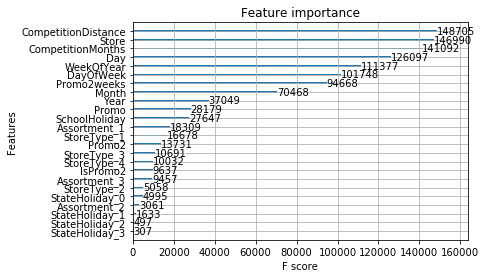

In [103]:
xgb.plot_importance(bst)
plt.show()

In [104]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

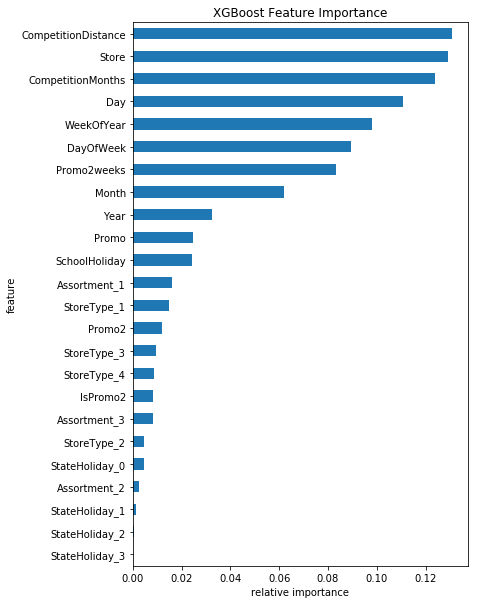

In [105]:
create_feature_map(X_train.columns)
importance = bst.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)
plt.show()

#### 模型及参数优化

In [106]:
# 提升树的数量
dtrain = xgb.DMatrix(train_data.drop(['Customers','Sales'],axis=1), np.log1p(train_data['Sales']))
watchlist = [(dtrain, 'train')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.005
          }
num_trees = 20000

In [107]:
# 将所有数据做训练提交kaggle检查分数
starttime = datetime.datetime.now()
bst = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
endtime = datetime.datetime.now()
print (endtime - starttime)

[0]	train-rmse:8.22715	train-rmspe:0.999844
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.1861	train-rmspe:0.999832
[2]	train-rmse:8.14525	train-rmspe:0.999819
[3]	train-rmse:8.10461	train-rmspe:0.999806
[4]	train-rmse:8.06417	train-rmspe:0.999792
[5]	train-rmse:8.02393	train-rmspe:0.999778
[6]	train-rmse:7.9839	train-rmspe:0.999763
[7]	train-rmse:7.94406	train-rmspe:0.999748
[8]	train-rmse:7.90443	train-rmspe:0.999732
[9]	train-rmse:7.86499	train-rmspe:0.999716
[10]	train-rmse:7.82575	train-rmspe:0.999699
[11]	train-rmse:7.78671	train-rmspe:0.999681
[12]	train-rmse:7.74785	train-rmspe:0.999663
[13]	train-rmse:7.70921	train-rmspe:0.999645
[14]	train-rmse:7.67075	train-rmspe:0.999625
[15]	train-rmse:7.63247	train-rmspe:0.999605
[16]	train-rmse:7.5944	train-rmspe:0.999585
[17]	train-rmse:7.55653	train-rmspe:0.999563
[18]	train-rmse:7.51884	train-rmspe:0.999541
[19]	train

[179]	train-rmse:3.36831	train-rmspe:0.963012
[180]	train-rmse:3.35163	train-rmspe:0.96239
[181]	train-rmse:3.33502	train-rmspe:0.961764
[182]	train-rmse:3.3185	train-rmspe:0.961128
[183]	train-rmse:3.30207	train-rmspe:0.960484
[184]	train-rmse:3.28571	train-rmspe:0.959835
[185]	train-rmse:3.26944	train-rmspe:0.959178
[186]	train-rmse:3.25326	train-rmspe:0.958512
[187]	train-rmse:3.23715	train-rmspe:0.957839
[188]	train-rmse:3.22112	train-rmspe:0.957161
[189]	train-rmse:3.20517	train-rmspe:0.956475
[190]	train-rmse:3.18929	train-rmspe:0.955782
[191]	train-rmse:3.17351	train-rmspe:0.95508
[192]	train-rmse:3.15781	train-rmspe:0.954371
[193]	train-rmse:3.14219	train-rmspe:0.953653
[194]	train-rmse:3.12665	train-rmspe:0.952927
[195]	train-rmse:3.11118	train-rmspe:0.952195
[196]	train-rmse:3.09578	train-rmspe:0.951457
[197]	train-rmse:3.08046	train-rmspe:0.950711
[198]	train-rmse:3.06522	train-rmspe:0.949957
[199]	train-rmse:3.05007	train-rmspe:0.949196
[200]	train-rmse:3.03498	train-rmspe:

[358]	train-rmse:1.40101	train-rmspe:0.738843
[359]	train-rmse:1.39433	train-rmspe:0.737112
[360]	train-rmse:1.38768	train-rmspe:0.735381
[361]	train-rmse:1.38105	train-rmspe:0.733649
[362]	train-rmse:1.37447	train-rmspe:0.731912
[363]	train-rmse:1.36792	train-rmspe:0.730174
[364]	train-rmse:1.36139	train-rmspe:0.728437
[365]	train-rmse:1.35488	train-rmspe:0.726698
[366]	train-rmse:1.34842	train-rmspe:0.724956
[367]	train-rmse:1.34201	train-rmspe:0.723211
[368]	train-rmse:1.33561	train-rmspe:0.721468
[369]	train-rmse:1.32928	train-rmspe:0.719718
[370]	train-rmse:1.32296	train-rmspe:0.717967
[371]	train-rmse:1.31666	train-rmspe:0.71622
[372]	train-rmse:1.31041	train-rmspe:0.714468
[373]	train-rmse:1.30419	train-rmspe:0.712716
[374]	train-rmse:1.29801	train-rmspe:0.71096
[375]	train-rmse:1.29184	train-rmspe:0.709208
[376]	train-rmse:1.28571	train-rmspe:0.707452
[377]	train-rmse:1.27961	train-rmspe:0.705695
[378]	train-rmse:1.27356	train-rmspe:0.703934
[379]	train-rmse:1.26753	train-rmspe

[535]	train-rmse:0.631571	train-rmspe:0.450344
[536]	train-rmse:0.62897	train-rmspe:0.449035
[537]	train-rmse:0.626454	train-rmspe:0.447754
[538]	train-rmse:0.623925	train-rmspe:0.446469
[539]	train-rmse:0.621434	train-rmspe:0.445196
[540]	train-rmse:0.618941	train-rmspe:0.443921
[541]	train-rmse:0.616481	train-rmspe:0.442664
[542]	train-rmse:0.614024	train-rmspe:0.441411
[543]	train-rmse:0.611529	train-rmspe:0.440148
[544]	train-rmse:0.609095	train-rmspe:0.438901
[545]	train-rmse:0.606692	train-rmspe:0.437665
[546]	train-rmse:0.604266	train-rmspe:0.436425
[547]	train-rmse:0.601851	train-rmspe:0.435185
[548]	train-rmse:0.599417	train-rmspe:0.433944
[549]	train-rmse:0.597051	train-rmspe:0.432725
[550]	train-rmse:0.594611	train-rmspe:0.431487
[551]	train-rmse:0.592281	train-rmspe:0.430274
[552]	train-rmse:0.589976	train-rmspe:0.429075
[553]	train-rmse:0.587653	train-rmspe:0.427871
[554]	train-rmse:0.585367	train-rmspe:0.426678
[555]	train-rmse:0.583098	train-rmspe:0.425496
[556]	train-rm

[711]	train-rmse:0.356888	train-rmspe:0.309066
[712]	train-rmse:0.35604	train-rmspe:0.308678
[713]	train-rmse:0.355228	train-rmspe:0.308317
[714]	train-rmse:0.354346	train-rmspe:0.3079
[715]	train-rmse:0.353553	train-rmspe:0.307556
[716]	train-rmse:0.352783	train-rmspe:0.30724
[717]	train-rmse:0.351935	train-rmspe:0.306841
[718]	train-rmse:0.351182	train-rmspe:0.306541
[719]	train-rmse:0.350406	train-rmspe:0.306199
[720]	train-rmse:0.349607	train-rmspe:0.30584
[721]	train-rmse:0.348843	train-rmspe:0.305513
[722]	train-rmse:0.348073	train-rmspe:0.305179
[723]	train-rmse:0.347327	train-rmspe:0.304861
[724]	train-rmse:0.346587	train-rmspe:0.304539
[725]	train-rmse:0.345844	train-rmspe:0.304237
[726]	train-rmse:0.34501	train-rmspe:0.303871
[727]	train-rmse:0.344273	train-rmspe:0.303561
[728]	train-rmse:0.343524	train-rmspe:0.303226
[729]	train-rmse:0.342759	train-rmspe:0.302889
[730]	train-rmse:0.342043	train-rmspe:0.302587
[731]	train-rmse:0.341298	train-rmspe:0.302278
[732]	train-rmse:0.

[887]	train-rmse:0.273336	train-rmspe:0.280364
[888]	train-rmse:0.273145	train-rmspe:0.280364
[889]	train-rmse:0.272946	train-rmspe:0.280358
[890]	train-rmse:0.272676	train-rmspe:0.280286
[891]	train-rmse:0.272426	train-rmspe:0.280224
[892]	train-rmse:0.272196	train-rmspe:0.280192
[893]	train-rmse:0.271956	train-rmspe:0.280147
[894]	train-rmse:0.271768	train-rmspe:0.280146
[895]	train-rmse:0.27156	train-rmspe:0.28013
[896]	train-rmse:0.271374	train-rmspe:0.280123
[897]	train-rmse:0.271025	train-rmspe:0.279965
[898]	train-rmse:0.270764	train-rmspe:0.279905
[899]	train-rmse:0.270509	train-rmspe:0.279837
[900]	train-rmse:0.270264	train-rmspe:0.279772
[901]	train-rmse:0.270044	train-rmspe:0.279731
[902]	train-rmse:0.269858	train-rmspe:0.279727
[903]	train-rmse:0.269667	train-rmspe:0.279705
[904]	train-rmse:0.269466	train-rmspe:0.27969
[905]	train-rmse:0.269261	train-rmspe:0.279667
[906]	train-rmse:0.269011	train-rmspe:0.279602
[907]	train-rmse:0.268741	train-rmspe:0.279505
[908]	train-rmse

[1061]	train-rmse:0.243262	train-rmspe:0.271165
[1062]	train-rmse:0.243201	train-rmspe:0.271193
[1063]	train-rmse:0.243125	train-rmspe:0.271195
[1064]	train-rmse:0.242989	train-rmspe:0.27113
[1065]	train-rmse:0.242879	train-rmspe:0.271085
[1066]	train-rmse:0.24281	train-rmspe:0.271097
[1067]	train-rmse:0.242535	train-rmspe:0.27089
[1068]	train-rmse:0.242457	train-rmspe:0.270866
[1069]	train-rmse:0.242398	train-rmspe:0.270881
[1070]	train-rmse:0.242101	train-rmspe:0.270653
[1071]	train-rmse:0.242055	train-rmspe:0.270685
[1072]	train-rmse:0.241985	train-rmspe:0.270691
[1073]	train-rmse:0.24194	train-rmspe:0.270735
[1074]	train-rmse:0.24165	train-rmspe:0.270489
[1075]	train-rmse:0.241364	train-rmspe:0.270257
[1076]	train-rmse:0.241251	train-rmspe:0.270221
[1077]	train-rmse:0.241166	train-rmspe:0.270209
[1078]	train-rmse:0.241088	train-rmspe:0.270194
[1079]	train-rmse:0.240992	train-rmspe:0.270174
[1080]	train-rmse:0.240934	train-rmspe:0.27019
[1081]	train-rmse:0.240852	train-rmspe:0.27017

[1233]	train-rmse:0.227099	train-rmspe:0.262902
[1234]	train-rmse:0.227038	train-rmspe:0.262859
[1235]	train-rmse:0.227001	train-rmspe:0.262854
[1236]	train-rmse:0.226852	train-rmspe:0.262741
[1237]	train-rmse:0.226832	train-rmspe:0.262762
[1238]	train-rmse:0.226812	train-rmspe:0.262784
[1239]	train-rmse:0.22673	train-rmspe:0.262735
[1240]	train-rmse:0.226707	train-rmspe:0.262739
[1241]	train-rmse:0.226685	train-rmspe:0.262744
[1242]	train-rmse:0.226627	train-rmspe:0.26272
[1243]	train-rmse:0.226585	train-rmspe:0.262714
[1244]	train-rmse:0.22656	train-rmspe:0.26271
[1245]	train-rmse:0.226506	train-rmspe:0.262687
[1246]	train-rmse:0.226427	train-rmspe:0.262641
[1247]	train-rmse:0.226373	train-rmspe:0.262608
[1248]	train-rmse:0.226317	train-rmspe:0.262592
[1249]	train-rmse:0.226298	train-rmspe:0.262611
[1250]	train-rmse:0.226231	train-rmspe:0.262571
[1251]	train-rmse:0.226181	train-rmspe:0.262552
[1252]	train-rmse:0.226099	train-rmspe:0.262496
[1253]	train-rmse:0.226031	train-rmspe:0.262

[1405]	train-rmse:0.214583	train-rmspe:0.253915
[1406]	train-rmse:0.214552	train-rmspe:0.253862
[1407]	train-rmse:0.21454	train-rmspe:0.253871
[1408]	train-rmse:0.214521	train-rmspe:0.253863
[1409]	train-rmse:0.214492	train-rmspe:0.253849
[1410]	train-rmse:0.21447	train-rmspe:0.253845
[1411]	train-rmse:0.214446	train-rmspe:0.253847
[1412]	train-rmse:0.214296	train-rmspe:0.253713
[1413]	train-rmse:0.21424	train-rmspe:0.25368
[1414]	train-rmse:0.214193	train-rmspe:0.253657
[1415]	train-rmse:0.214028	train-rmspe:0.2535
[1416]	train-rmse:0.213901	train-rmspe:0.253383
[1417]	train-rmse:0.213859	train-rmspe:0.253356
[1418]	train-rmse:0.213815	train-rmspe:0.25333
[1419]	train-rmse:0.213792	train-rmspe:0.253319
[1420]	train-rmse:0.213743	train-rmspe:0.253284
[1421]	train-rmse:0.213697	train-rmspe:0.253257
[1422]	train-rmse:0.213684	train-rmspe:0.253265
[1423]	train-rmse:0.213622	train-rmspe:0.253214
[1424]	train-rmse:0.213586	train-rmspe:0.253192
[1425]	train-rmse:0.213556	train-rmspe:0.253164

[1577]	train-rmse:0.202906	train-rmspe:0.242907
[1578]	train-rmse:0.202809	train-rmspe:0.242795
[1579]	train-rmse:0.202684	train-rmspe:0.24269
[1580]	train-rmse:0.202638	train-rmspe:0.242657
[1581]	train-rmse:0.202579	train-rmspe:0.242614
[1582]	train-rmse:0.202568	train-rmspe:0.24262
[1583]	train-rmse:0.202556	train-rmspe:0.242613
[1584]	train-rmse:0.202433	train-rmspe:0.242498
[1585]	train-rmse:0.202312	train-rmspe:0.24238
[1586]	train-rmse:0.20221	train-rmspe:0.24227
[1587]	train-rmse:0.202185	train-rmspe:0.242254
[1588]	train-rmse:0.202086	train-rmspe:0.242168
[1589]	train-rmse:0.202059	train-rmspe:0.24215
[1590]	train-rmse:0.20204	train-rmspe:0.242128
[1591]	train-rmse:0.201921	train-rmspe:0.242024
[1592]	train-rmse:0.20186	train-rmspe:0.241966
[1593]	train-rmse:0.201753	train-rmspe:0.241868
[1594]	train-rmse:0.201719	train-rmspe:0.241812
[1595]	train-rmse:0.201681	train-rmspe:0.241783
[1596]	train-rmse:0.201576	train-rmspe:0.241687
[1597]	train-rmse:0.20155	train-rmspe:0.241668
[

[1749]	train-rmse:0.193041	train-rmspe:0.23252
[1750]	train-rmse:0.192933	train-rmspe:0.232426
[1751]	train-rmse:0.192917	train-rmspe:0.23241
[1752]	train-rmse:0.192816	train-rmspe:0.232317
[1753]	train-rmse:0.192803	train-rmspe:0.232296
[1754]	train-rmse:0.192774	train-rmspe:0.232274
[1755]	train-rmse:0.192618	train-rmspe:0.232124
[1756]	train-rmse:0.192554	train-rmspe:0.232059
[1757]	train-rmse:0.192471	train-rmspe:0.231741
[1758]	train-rmse:0.192456	train-rmspe:0.231672
[1759]	train-rmse:0.192426	train-rmspe:0.231644
[1760]	train-rmse:0.192342	train-rmspe:0.231527
[1761]	train-rmse:0.192256	train-rmspe:0.231448
[1762]	train-rmse:0.192174	train-rmspe:0.231373
[1763]	train-rmse:0.192151	train-rmspe:0.231356
[1764]	train-rmse:0.192093	train-rmspe:0.231304
[1765]	train-rmse:0.192074	train-rmspe:0.231285
[1766]	train-rmse:0.191998	train-rmspe:0.231214
[1767]	train-rmse:0.191902	train-rmspe:0.231123
[1768]	train-rmse:0.191815	train-rmspe:0.231033
[1769]	train-rmse:0.191796	train-rmspe:0.2

[1921]	train-rmse:0.183742	train-rmspe:0.22183
[1922]	train-rmse:0.183724	train-rmspe:0.221805
[1923]	train-rmse:0.183704	train-rmspe:0.22177
[1924]	train-rmse:0.183649	train-rmspe:0.221721
[1925]	train-rmse:0.183611	train-rmspe:0.22169
[1926]	train-rmse:0.183527	train-rmspe:0.221625
[1927]	train-rmse:0.183505	train-rmspe:0.221598
[1928]	train-rmse:0.183487	train-rmspe:0.221569
[1929]	train-rmse:0.183427	train-rmspe:0.221509
[1930]	train-rmse:0.183369	train-rmspe:0.221467
[1931]	train-rmse:0.183303	train-rmspe:0.221409
[1932]	train-rmse:0.183239	train-rmspe:0.221348
[1933]	train-rmse:0.183181	train-rmspe:0.221297
[1934]	train-rmse:0.183161	train-rmspe:0.221277
[1935]	train-rmse:0.183094	train-rmspe:0.221211
[1936]	train-rmse:0.183033	train-rmspe:0.221143
[1937]	train-rmse:0.182928	train-rmspe:0.22104
[1938]	train-rmse:0.182911	train-rmspe:0.221026
[1939]	train-rmse:0.182835	train-rmspe:0.220956
[1940]	train-rmse:0.182766	train-rmspe:0.220886
[1941]	train-rmse:0.182753	train-rmspe:0.220

[2093]	train-rmse:0.175985	train-rmspe:0.212802
[2094]	train-rmse:0.175967	train-rmspe:0.212788
[2095]	train-rmse:0.175943	train-rmspe:0.212766
[2096]	train-rmse:0.17593	train-rmspe:0.212733
[2097]	train-rmse:0.175915	train-rmspe:0.212716
[2098]	train-rmse:0.175899	train-rmspe:0.212698
[2099]	train-rmse:0.175873	train-rmspe:0.21267
[2100]	train-rmse:0.175839	train-rmspe:0.21264
[2101]	train-rmse:0.175733	train-rmspe:0.212541
[2102]	train-rmse:0.17567	train-rmspe:0.212483
[2103]	train-rmse:0.175625	train-rmspe:0.212429
[2104]	train-rmse:0.175611	train-rmspe:0.212407
[2105]	train-rmse:0.175579	train-rmspe:0.212295
[2106]	train-rmse:0.175561	train-rmspe:0.212274
[2107]	train-rmse:0.175498	train-rmspe:0.212225
[2108]	train-rmse:0.175439	train-rmspe:0.212174
[2109]	train-rmse:0.175373	train-rmspe:0.212107
[2110]	train-rmse:0.175363	train-rmspe:0.212094
[2111]	train-rmse:0.175272	train-rmspe:0.212007
[2112]	train-rmse:0.175246	train-rmspe:0.211978
[2113]	train-rmse:0.17523	train-rmspe:0.2119

[2265]	train-rmse:0.169012	train-rmspe:0.205189
[2266]	train-rmse:0.168961	train-rmspe:0.20514
[2267]	train-rmse:0.168923	train-rmspe:0.205101
[2268]	train-rmse:0.168888	train-rmspe:0.205068
[2269]	train-rmse:0.168838	train-rmspe:0.205029
[2270]	train-rmse:0.16883	train-rmspe:0.205026
[2271]	train-rmse:0.168813	train-rmspe:0.205007
[2272]	train-rmse:0.168772	train-rmspe:0.204978
[2273]	train-rmse:0.168721	train-rmspe:0.204929
[2274]	train-rmse:0.168704	train-rmspe:0.204918
[2275]	train-rmse:0.168692	train-rmspe:0.204906
[2276]	train-rmse:0.168683	train-rmspe:0.204795
[2277]	train-rmse:0.168653	train-rmspe:0.204758
[2278]	train-rmse:0.168641	train-rmspe:0.20475
[2279]	train-rmse:0.168576	train-rmspe:0.204688
[2280]	train-rmse:0.168554	train-rmspe:0.204402
[2281]	train-rmse:0.168543	train-rmspe:0.204393
[2282]	train-rmse:0.168459	train-rmspe:0.204312
[2283]	train-rmse:0.168433	train-rmspe:0.204305
[2284]	train-rmse:0.168412	train-rmspe:0.204283
[2285]	train-rmse:0.168407	train-rmspe:0.20

[2437]	train-rmse:0.162886	train-rmspe:0.198074
[2438]	train-rmse:0.162853	train-rmspe:0.198046
[2439]	train-rmse:0.162837	train-rmspe:0.198031
[2440]	train-rmse:0.162821	train-rmspe:0.197995
[2441]	train-rmse:0.162807	train-rmspe:0.197982
[2442]	train-rmse:0.162787	train-rmspe:0.197962
[2443]	train-rmse:0.162745	train-rmspe:0.197904
[2444]	train-rmse:0.162712	train-rmspe:0.197879
[2445]	train-rmse:0.162694	train-rmspe:0.197834
[2446]	train-rmse:0.16262	train-rmspe:0.197765
[2447]	train-rmse:0.162579	train-rmspe:0.197725
[2448]	train-rmse:0.162548	train-rmspe:0.197695
[2449]	train-rmse:0.16248	train-rmspe:0.197614
[2450]	train-rmse:0.162473	train-rmspe:0.197607
[2451]	train-rmse:0.162422	train-rmspe:0.197589
[2452]	train-rmse:0.162409	train-rmspe:0.197578
[2453]	train-rmse:0.162397	train-rmspe:0.197499
[2454]	train-rmse:0.162352	train-rmspe:0.197466
[2455]	train-rmse:0.162315	train-rmspe:0.197437
[2456]	train-rmse:0.162257	train-rmspe:0.197386
[2457]	train-rmse:0.162207	train-rmspe:0.1

[2609]	train-rmse:0.15705	train-rmspe:0.191686
[2610]	train-rmse:0.157039	train-rmspe:0.191679
[2611]	train-rmse:0.15698	train-rmspe:0.191621
[2612]	train-rmse:0.156945	train-rmspe:0.191588
[2613]	train-rmse:0.156923	train-rmspe:0.191496
[2614]	train-rmse:0.1569	train-rmspe:0.191478
[2615]	train-rmse:0.156877	train-rmspe:0.191424
[2616]	train-rmse:0.156864	train-rmspe:0.191414
[2617]	train-rmse:0.156853	train-rmspe:0.191407
[2618]	train-rmse:0.156834	train-rmspe:0.191394
[2619]	train-rmse:0.15679	train-rmspe:0.191355
[2620]	train-rmse:0.15678	train-rmspe:0.191345
[2621]	train-rmse:0.156765	train-rmspe:0.191332
[2622]	train-rmse:0.156707	train-rmspe:0.191277
[2623]	train-rmse:0.156674	train-rmspe:0.191245
[2624]	train-rmse:0.156664	train-rmspe:0.191214
[2625]	train-rmse:0.156626	train-rmspe:0.191177
[2626]	train-rmse:0.156595	train-rmspe:0.191147
[2627]	train-rmse:0.156551	train-rmspe:0.191106
[2628]	train-rmse:0.156486	train-rmspe:0.191048
[2629]	train-rmse:0.156468	train-rmspe:0.19103

[2781]	train-rmse:0.152196	train-rmspe:0.18555
[2782]	train-rmse:0.152142	train-rmspe:0.185488
[2783]	train-rmse:0.15212	train-rmspe:0.185466
[2784]	train-rmse:0.152072	train-rmspe:0.185415
[2785]	train-rmse:0.152062	train-rmspe:0.185403
[2786]	train-rmse:0.152044	train-rmspe:0.185383
[2787]	train-rmse:0.15201	train-rmspe:0.185079
[2788]	train-rmse:0.152004	train-rmspe:0.185076
[2789]	train-rmse:0.151994	train-rmspe:0.185068
[2790]	train-rmse:0.15198	train-rmspe:0.185053
[2791]	train-rmse:0.151943	train-rmspe:0.185021
[2792]	train-rmse:0.151911	train-rmspe:0.18499
[2793]	train-rmse:0.151889	train-rmspe:0.184971
[2794]	train-rmse:0.151863	train-rmspe:0.184949
[2795]	train-rmse:0.15181	train-rmspe:0.184899
[2796]	train-rmse:0.151783	train-rmspe:0.184684
[2797]	train-rmse:0.151767	train-rmspe:0.184659
[2798]	train-rmse:0.151739	train-rmspe:0.184632
[2799]	train-rmse:0.151722	train-rmspe:0.184617
[2800]	train-rmse:0.151688	train-rmspe:0.184587
[2801]	train-rmse:0.151666	train-rmspe:0.18456

[2953]	train-rmse:0.147703	train-rmspe:0.177968
[2954]	train-rmse:0.147683	train-rmspe:0.177948
[2955]	train-rmse:0.14764	train-rmspe:0.177906
[2956]	train-rmse:0.147629	train-rmspe:0.177894
[2957]	train-rmse:0.147612	train-rmspe:0.177849
[2958]	train-rmse:0.147572	train-rmspe:0.177808
[2959]	train-rmse:0.147542	train-rmspe:0.177782
[2960]	train-rmse:0.147521	train-rmspe:0.177746
[2961]	train-rmse:0.147505	train-rmspe:0.177721
[2962]	train-rmse:0.147473	train-rmspe:0.17769
[2963]	train-rmse:0.147455	train-rmspe:0.177676
[2964]	train-rmse:0.147433	train-rmspe:0.177656
[2965]	train-rmse:0.147381	train-rmspe:0.177608
[2966]	train-rmse:0.147346	train-rmspe:0.177571
[2967]	train-rmse:0.147333	train-rmspe:0.177555
[2968]	train-rmse:0.147309	train-rmspe:0.177533
[2969]	train-rmse:0.14727	train-rmspe:0.177498
[2970]	train-rmse:0.147246	train-rmspe:0.177474
[2971]	train-rmse:0.147212	train-rmspe:0.177442
[2972]	train-rmse:0.147198	train-rmspe:0.177429
[2973]	train-rmse:0.147163	train-rmspe:0.17

[3125]	train-rmse:0.143976	train-rmspe:0.172784
[3126]	train-rmse:0.143943	train-rmspe:0.172755
[3127]	train-rmse:0.143913	train-rmspe:0.172728
[3128]	train-rmse:0.143885	train-rmspe:0.172352
[3129]	train-rmse:0.143872	train-rmspe:0.17234
[3130]	train-rmse:0.143858	train-rmspe:0.172328
[3131]	train-rmse:0.143804	train-rmspe:0.17228
[3132]	train-rmse:0.143791	train-rmspe:0.172269
[3133]	train-rmse:0.143777	train-rmspe:0.172255
[3134]	train-rmse:0.143759	train-rmspe:0.17222
[3135]	train-rmse:0.143738	train-rmspe:0.172183
[3136]	train-rmse:0.143704	train-rmspe:0.172151
[3137]	train-rmse:0.143662	train-rmspe:0.172099
[3138]	train-rmse:0.143626	train-rmspe:0.172065
[3139]	train-rmse:0.143612	train-rmspe:0.172053
[3140]	train-rmse:0.143582	train-rmspe:0.172025
[3141]	train-rmse:0.143574	train-rmspe:0.172017
[3142]	train-rmse:0.143558	train-rmspe:0.172003
[3143]	train-rmse:0.143509	train-rmspe:0.171949
[3144]	train-rmse:0.143462	train-rmspe:0.171904
[3145]	train-rmse:0.143453	train-rmspe:0.17

[3297]	train-rmse:0.140403	train-rmspe:0.167952
[3298]	train-rmse:0.140392	train-rmspe:0.167941
[3299]	train-rmse:0.140378	train-rmspe:0.167928
[3300]	train-rmse:0.140362	train-rmspe:0.167913
[3301]	train-rmse:0.14035	train-rmspe:0.1679
[3302]	train-rmse:0.140334	train-rmspe:0.167887
[3303]	train-rmse:0.140317	train-rmspe:0.16787
[3304]	train-rmse:0.140293	train-rmspe:0.167847
[3305]	train-rmse:0.140273	train-rmspe:0.167827
[3306]	train-rmse:0.140229	train-rmspe:0.167778
[3307]	train-rmse:0.140204	train-rmspe:0.167759
[3308]	train-rmse:0.140179	train-rmspe:0.167733
[3309]	train-rmse:0.140158	train-rmspe:0.167712
[3310]	train-rmse:0.140142	train-rmspe:0.167646
[3311]	train-rmse:0.140127	train-rmspe:0.167631
[3312]	train-rmse:0.140079	train-rmspe:0.167589
[3313]	train-rmse:0.140063	train-rmspe:0.167574
[3314]	train-rmse:0.140056	train-rmspe:0.167566
[3315]	train-rmse:0.140049	train-rmspe:0.167562
[3316]	train-rmse:0.140001	train-rmspe:0.167512
[3317]	train-rmse:0.139966	train-rmspe:0.167

[3469]	train-rmse:0.13663	train-rmspe:0.163345
[3470]	train-rmse:0.136604	train-rmspe:0.163323
[3471]	train-rmse:0.136597	train-rmspe:0.163316
[3472]	train-rmse:0.136576	train-rmspe:0.163297
[3473]	train-rmse:0.136558	train-rmspe:0.163289
[3474]	train-rmse:0.136543	train-rmspe:0.163275
[3475]	train-rmse:0.136517	train-rmspe:0.163251
[3476]	train-rmse:0.136509	train-rmspe:0.163238
[3477]	train-rmse:0.136505	train-rmspe:0.163236
[3478]	train-rmse:0.13648	train-rmspe:0.163212
[3479]	train-rmse:0.136463	train-rmspe:0.163186
[3480]	train-rmse:0.136449	train-rmspe:0.163177
[3481]	train-rmse:0.136435	train-rmspe:0.163164
[3482]	train-rmse:0.136415	train-rmspe:0.163146
[3483]	train-rmse:0.136403	train-rmspe:0.163136
[3484]	train-rmse:0.136399	train-rmspe:0.163134
[3485]	train-rmse:0.136389	train-rmspe:0.163124
[3486]	train-rmse:0.136376	train-rmspe:0.163109
[3487]	train-rmse:0.13636	train-rmspe:0.16308
[3488]	train-rmse:0.136348	train-rmspe:0.163067
[3489]	train-rmse:0.136331	train-rmspe:0.163

[3641]	train-rmse:0.133525	train-rmspe:0.159494
[3642]	train-rmse:0.133507	train-rmspe:0.159478
[3643]	train-rmse:0.133492	train-rmspe:0.159461
[3644]	train-rmse:0.133475	train-rmspe:0.159445
[3645]	train-rmse:0.133458	train-rmspe:0.159428
[3646]	train-rmse:0.133431	train-rmspe:0.159402
[3647]	train-rmse:0.133414	train-rmspe:0.159387
[3648]	train-rmse:0.133399	train-rmspe:0.159359
[3649]	train-rmse:0.133384	train-rmspe:0.159346
[3650]	train-rmse:0.133371	train-rmspe:0.159336
[3651]	train-rmse:0.133356	train-rmspe:0.159321
[3652]	train-rmse:0.133343	train-rmspe:0.15931
[3653]	train-rmse:0.133316	train-rmspe:0.159286
[3654]	train-rmse:0.133298	train-rmspe:0.159267
[3655]	train-rmse:0.133278	train-rmspe:0.159254
[3656]	train-rmse:0.133265	train-rmspe:0.159242
[3657]	train-rmse:0.133227	train-rmspe:0.159208
[3658]	train-rmse:0.133218	train-rmspe:0.159199
[3659]	train-rmse:0.133204	train-rmspe:0.159176
[3660]	train-rmse:0.133193	train-rmspe:0.159165
[3661]	train-rmse:0.133184	train-rmspe:0.

[3813]	train-rmse:0.130673	train-rmspe:0.15579
[3814]	train-rmse:0.130657	train-rmspe:0.155771
[3815]	train-rmse:0.130644	train-rmspe:0.155756
[3816]	train-rmse:0.130636	train-rmspe:0.155749
[3817]	train-rmse:0.130618	train-rmspe:0.155732
[3818]	train-rmse:0.130611	train-rmspe:0.155724
[3819]	train-rmse:0.130603	train-rmspe:0.155715
[3820]	train-rmse:0.130589	train-rmspe:0.155699
[3821]	train-rmse:0.13057	train-rmspe:0.155681
[3822]	train-rmse:0.130538	train-rmspe:0.155652
[3823]	train-rmse:0.130535	train-rmspe:0.15565
[3824]	train-rmse:0.130525	train-rmspe:0.155643
[3825]	train-rmse:0.130514	train-rmspe:0.155634
[3826]	train-rmse:0.130503	train-rmspe:0.155623
[3827]	train-rmse:0.130485	train-rmspe:0.155606
[3828]	train-rmse:0.130471	train-rmspe:0.155602
[3829]	train-rmse:0.130451	train-rmspe:0.155583
[3830]	train-rmse:0.130434	train-rmspe:0.155565
[3831]	train-rmse:0.130402	train-rmspe:0.155531
[3832]	train-rmse:0.130386	train-rmspe:0.155512
[3833]	train-rmse:0.130377	train-rmspe:0.15

[3985]	train-rmse:0.128145	train-rmspe:0.152982
[3986]	train-rmse:0.128134	train-rmspe:0.152972
[3987]	train-rmse:0.128117	train-rmspe:0.152942
[3988]	train-rmse:0.128102	train-rmspe:0.15293
[3989]	train-rmse:0.128073	train-rmspe:0.152902
[3990]	train-rmse:0.128049	train-rmspe:0.152876
[3991]	train-rmse:0.128027	train-rmspe:0.152859
[3992]	train-rmse:0.128014	train-rmspe:0.152849
[3993]	train-rmse:0.128002	train-rmspe:0.152837
[3994]	train-rmse:0.127979	train-rmspe:0.152817
[3995]	train-rmse:0.127971	train-rmspe:0.15281
[3996]	train-rmse:0.127962	train-rmspe:0.152801
[3997]	train-rmse:0.127952	train-rmspe:0.152792
[3998]	train-rmse:0.127936	train-rmspe:0.152779
[3999]	train-rmse:0.127932	train-rmspe:0.152772
[4000]	train-rmse:0.127925	train-rmspe:0.152765
[4001]	train-rmse:0.127907	train-rmspe:0.152749
[4002]	train-rmse:0.127895	train-rmspe:0.152738
[4003]	train-rmse:0.127875	train-rmspe:0.152723
[4004]	train-rmse:0.127873	train-rmspe:0.152722
[4005]	train-rmse:0.127858	train-rmspe:0.1

[4157]	train-rmse:0.125606	train-rmspe:0.149961
[4158]	train-rmse:0.125592	train-rmspe:0.14976
[4159]	train-rmse:0.125565	train-rmspe:0.149736
[4160]	train-rmse:0.125556	train-rmspe:0.149729
[4161]	train-rmse:0.125536	train-rmspe:0.149712
[4162]	train-rmse:0.125508	train-rmspe:0.14969
[4163]	train-rmse:0.125496	train-rmspe:0.149681
[4164]	train-rmse:0.125489	train-rmspe:0.149674
[4165]	train-rmse:0.125481	train-rmspe:0.149668
[4166]	train-rmse:0.125478	train-rmspe:0.149667
[4167]	train-rmse:0.125457	train-rmspe:0.14965
[4168]	train-rmse:0.125441	train-rmspe:0.149637
[4169]	train-rmse:0.125429	train-rmspe:0.149626
[4170]	train-rmse:0.125409	train-rmspe:0.149608
[4171]	train-rmse:0.1254	train-rmspe:0.149601
[4172]	train-rmse:0.125392	train-rmspe:0.149594
[4173]	train-rmse:0.125375	train-rmspe:0.149581
[4174]	train-rmse:0.125371	train-rmspe:0.149578
[4175]	train-rmse:0.125358	train-rmspe:0.149567
[4176]	train-rmse:0.125349	train-rmspe:0.149553
[4177]	train-rmse:0.125328	train-rmspe:0.1495

[4329]	train-rmse:0.123314	train-rmspe:0.147177
[4330]	train-rmse:0.123305	train-rmspe:0.147165
[4331]	train-rmse:0.123283	train-rmspe:0.147146
[4332]	train-rmse:0.123274	train-rmspe:0.147137
[4333]	train-rmse:0.123264	train-rmspe:0.147116
[4334]	train-rmse:0.123257	train-rmspe:0.14711
[4335]	train-rmse:0.123235	train-rmspe:0.14709
[4336]	train-rmse:0.123225	train-rmspe:0.147081
[4337]	train-rmse:0.123204	train-rmspe:0.147067
[4338]	train-rmse:0.123196	train-rmspe:0.147059
[4339]	train-rmse:0.123185	train-rmspe:0.147048
[4340]	train-rmse:0.12317	train-rmspe:0.147035
[4341]	train-rmse:0.123157	train-rmspe:0.147021
[4342]	train-rmse:0.12315	train-rmspe:0.147015
[4343]	train-rmse:0.123142	train-rmspe:0.146995
[4344]	train-rmse:0.123135	train-rmspe:0.14699
[4345]	train-rmse:0.123125	train-rmspe:0.146982
[4346]	train-rmse:0.123116	train-rmspe:0.146973
[4347]	train-rmse:0.123105	train-rmspe:0.146963
[4348]	train-rmse:0.123102	train-rmspe:0.14696
[4349]	train-rmse:0.123096	train-rmspe:0.14695

[4501]	train-rmse:0.121215	train-rmspe:0.144516
[4502]	train-rmse:0.121198	train-rmspe:0.144499
[4503]	train-rmse:0.121179	train-rmspe:0.144482
[4504]	train-rmse:0.121155	train-rmspe:0.144462
[4505]	train-rmse:0.121145	train-rmspe:0.144453
[4506]	train-rmse:0.121133	train-rmspe:0.144444
[4507]	train-rmse:0.121125	train-rmspe:0.144432
[4508]	train-rmse:0.121115	train-rmspe:0.144425
[4509]	train-rmse:0.121099	train-rmspe:0.144412
[4510]	train-rmse:0.121094	train-rmspe:0.144407
[4511]	train-rmse:0.121091	train-rmspe:0.144398
[4512]	train-rmse:0.121078	train-rmspe:0.144385
[4513]	train-rmse:0.121066	train-rmspe:0.144378
[4514]	train-rmse:0.121057	train-rmspe:0.144367
[4515]	train-rmse:0.121036	train-rmspe:0.144348
[4516]	train-rmse:0.121026	train-rmspe:0.14434
[4517]	train-rmse:0.121011	train-rmspe:0.144325
[4518]	train-rmse:0.120991	train-rmspe:0.144305
[4519]	train-rmse:0.120983	train-rmspe:0.144296
[4520]	train-rmse:0.12097	train-rmspe:0.144284
[4521]	train-rmse:0.120952	train-rmspe:0.1

[4673]	train-rmse:0.119283	train-rmspe:0.14196
[4674]	train-rmse:0.119266	train-rmspe:0.141945
[4675]	train-rmse:0.119257	train-rmspe:0.141935
[4676]	train-rmse:0.119244	train-rmspe:0.141925
[4677]	train-rmse:0.119239	train-rmspe:0.141922
[4678]	train-rmse:0.119229	train-rmspe:0.141915
[4679]	train-rmse:0.119207	train-rmspe:0.14189
[4680]	train-rmse:0.119202	train-rmspe:0.141875
[4681]	train-rmse:0.119185	train-rmspe:0.141859
[4682]	train-rmse:0.119163	train-rmspe:0.141843
[4683]	train-rmse:0.119154	train-rmspe:0.141837
[4684]	train-rmse:0.119144	train-rmspe:0.141731
[4685]	train-rmse:0.119126	train-rmspe:0.141716
[4686]	train-rmse:0.119115	train-rmspe:0.141706
[4687]	train-rmse:0.119103	train-rmspe:0.141698
[4688]	train-rmse:0.119096	train-rmspe:0.141692
[4689]	train-rmse:0.119086	train-rmspe:0.14141
[4690]	train-rmse:0.119079	train-rmspe:0.141404
[4691]	train-rmse:0.11907	train-rmspe:0.141398
[4692]	train-rmse:0.119059	train-rmspe:0.141392
[4693]	train-rmse:0.119049	train-rmspe:0.141

[4845]	train-rmse:0.117431	train-rmspe:0.13967
[4846]	train-rmse:0.117421	train-rmspe:0.139662
[4847]	train-rmse:0.117407	train-rmspe:0.139652
[4848]	train-rmse:0.117395	train-rmspe:0.139639
[4849]	train-rmse:0.117368	train-rmspe:0.139615
[4850]	train-rmse:0.117362	train-rmspe:0.1396
[4851]	train-rmse:0.117348	train-rmspe:0.13959
[4852]	train-rmse:0.117341	train-rmspe:0.139582
[4853]	train-rmse:0.117331	train-rmspe:0.139573
[4854]	train-rmse:0.117326	train-rmspe:0.139568
[4855]	train-rmse:0.117309	train-rmspe:0.139553
[4856]	train-rmse:0.117297	train-rmspe:0.139541
[4857]	train-rmse:0.117288	train-rmspe:0.139533
[4858]	train-rmse:0.117284	train-rmspe:0.139527
[4859]	train-rmse:0.117274	train-rmspe:0.139521
[4860]	train-rmse:0.117254	train-rmspe:0.139504
[4861]	train-rmse:0.117251	train-rmspe:0.139503
[4862]	train-rmse:0.117247	train-rmspe:0.139499
[4863]	train-rmse:0.117232	train-rmspe:0.139486
[4864]	train-rmse:0.117222	train-rmspe:0.139476
[4865]	train-rmse:0.117215	train-rmspe:0.139

[5017]	train-rmse:0.115695	train-rmspe:0.137258
[5018]	train-rmse:0.115684	train-rmspe:0.137249
[5019]	train-rmse:0.115669	train-rmspe:0.137239
[5020]	train-rmse:0.115665	train-rmspe:0.137219
[5021]	train-rmse:0.115653	train-rmspe:0.137197
[5022]	train-rmse:0.115642	train-rmspe:0.137189
[5023]	train-rmse:0.115634	train-rmspe:0.137182
[5024]	train-rmse:0.115621	train-rmspe:0.137176
[5025]	train-rmse:0.115607	train-rmspe:0.137165
[5026]	train-rmse:0.115597	train-rmspe:0.137154
[5027]	train-rmse:0.115588	train-rmspe:0.137145
[5028]	train-rmse:0.115576	train-rmspe:0.137137
[5029]	train-rmse:0.115561	train-rmspe:0.137123
[5030]	train-rmse:0.115547	train-rmspe:0.137111
[5031]	train-rmse:0.115536	train-rmspe:0.137102
[5032]	train-rmse:0.115532	train-rmspe:0.137098
[5033]	train-rmse:0.115517	train-rmspe:0.137086
[5034]	train-rmse:0.11551	train-rmspe:0.13708
[5035]	train-rmse:0.115499	train-rmspe:0.137072
[5036]	train-rmse:0.11549	train-rmspe:0.137064
[5037]	train-rmse:0.115486	train-rmspe:0.13

[5189]	train-rmse:0.114094	train-rmspe:0.135605
[5190]	train-rmse:0.114091	train-rmspe:0.135602
[5191]	train-rmse:0.114078	train-rmspe:0.135591
[5192]	train-rmse:0.114069	train-rmspe:0.135584
[5193]	train-rmse:0.114061	train-rmspe:0.135571
[5194]	train-rmse:0.114051	train-rmspe:0.135558
[5195]	train-rmse:0.11404	train-rmspe:0.135528
[5196]	train-rmse:0.114033	train-rmspe:0.135523
[5197]	train-rmse:0.11403	train-rmspe:0.135522
[5198]	train-rmse:0.114012	train-rmspe:0.135505
[5199]	train-rmse:0.114	train-rmspe:0.135498
[5200]	train-rmse:0.113987	train-rmspe:0.135487
[5201]	train-rmse:0.113978	train-rmspe:0.135483
[5202]	train-rmse:0.113974	train-rmspe:0.135409
[5203]	train-rmse:0.11396	train-rmspe:0.135393
[5204]	train-rmse:0.113955	train-rmspe:0.135386
[5205]	train-rmse:0.113941	train-rmspe:0.135374
[5206]	train-rmse:0.113928	train-rmspe:0.135366
[5207]	train-rmse:0.11392	train-rmspe:0.135358
[5208]	train-rmse:0.113917	train-rmspe:0.135355
[5209]	train-rmse:0.113913	train-rmspe:0.135353

[5361]	train-rmse:0.112625	train-rmspe:0.133648
[5362]	train-rmse:0.112614	train-rmspe:0.133641
[5363]	train-rmse:0.112601	train-rmspe:0.133629
[5364]	train-rmse:0.112593	train-rmspe:0.133624
[5365]	train-rmse:0.112577	train-rmspe:0.13361
[5366]	train-rmse:0.112571	train-rmspe:0.133606
[5367]	train-rmse:0.112568	train-rmspe:0.133602
[5368]	train-rmse:0.112563	train-rmspe:0.133599
[5369]	train-rmse:0.11255	train-rmspe:0.133585
[5370]	train-rmse:0.112541	train-rmspe:0.133578
[5371]	train-rmse:0.112538	train-rmspe:0.133576
[5372]	train-rmse:0.112523	train-rmspe:0.133563
[5373]	train-rmse:0.112514	train-rmspe:0.133552
[5374]	train-rmse:0.112495	train-rmspe:0.133534
[5375]	train-rmse:0.112481	train-rmspe:0.133525
[5376]	train-rmse:0.112473	train-rmspe:0.13352
[5377]	train-rmse:0.112463	train-rmspe:0.133504
[5378]	train-rmse:0.112457	train-rmspe:0.133497
[5379]	train-rmse:0.112439	train-rmspe:0.133481
[5380]	train-rmse:0.112427	train-rmspe:0.133471
[5381]	train-rmse:0.112421	train-rmspe:0.13

[5533]	train-rmse:0.111244	train-rmspe:0.13202
[5534]	train-rmse:0.111236	train-rmspe:0.132009
[5535]	train-rmse:0.111234	train-rmspe:0.132013
[5536]	train-rmse:0.111221	train-rmspe:0.132006
[5537]	train-rmse:0.111209	train-rmspe:0.132002
[5538]	train-rmse:0.111205	train-rmspe:0.131998
[5539]	train-rmse:0.111195	train-rmspe:0.131983
[5540]	train-rmse:0.111182	train-rmspe:0.131973
[5541]	train-rmse:0.111178	train-rmspe:0.13197
[5542]	train-rmse:0.111171	train-rmspe:0.131963
[5543]	train-rmse:0.111162	train-rmspe:0.131957
[5544]	train-rmse:0.111155	train-rmspe:0.131945
[5545]	train-rmse:0.111138	train-rmspe:0.131934
[5546]	train-rmse:0.111132	train-rmspe:0.131929
[5547]	train-rmse:0.111123	train-rmspe:0.131922
[5548]	train-rmse:0.111118	train-rmspe:0.131918
[5549]	train-rmse:0.111111	train-rmspe:0.131911
[5550]	train-rmse:0.111109	train-rmspe:0.13191
[5551]	train-rmse:0.111102	train-rmspe:0.131836
[5552]	train-rmse:0.111095	train-rmspe:0.13183
[5553]	train-rmse:0.111089	train-rmspe:0.131

[5705]	train-rmse:0.109885	train-rmspe:0.130567
[5706]	train-rmse:0.109883	train-rmspe:0.130565
[5707]	train-rmse:0.109871	train-rmspe:0.130554
[5708]	train-rmse:0.109868	train-rmspe:0.130552
[5709]	train-rmse:0.109858	train-rmspe:0.130548
[5710]	train-rmse:0.109852	train-rmspe:0.130549
[5711]	train-rmse:0.109848	train-rmspe:0.130547
[5712]	train-rmse:0.109844	train-rmspe:0.130544
[5713]	train-rmse:0.109838	train-rmspe:0.13054
[5714]	train-rmse:0.109833	train-rmspe:0.130537
[5715]	train-rmse:0.109827	train-rmspe:0.13053
[5716]	train-rmse:0.109813	train-rmspe:0.130517
[5717]	train-rmse:0.109806	train-rmspe:0.130511
[5718]	train-rmse:0.1098	train-rmspe:0.130491
[5719]	train-rmse:0.109794	train-rmspe:0.130486
[5720]	train-rmse:0.109788	train-rmspe:0.130481
[5721]	train-rmse:0.109777	train-rmspe:0.130474
[5722]	train-rmse:0.109773	train-rmspe:0.13047
[5723]	train-rmse:0.10977	train-rmspe:0.130468
[5724]	train-rmse:0.10976	train-rmspe:0.130454
[5725]	train-rmse:0.109754	train-rmspe:0.13045


[5877]	train-rmse:0.108652	train-rmspe:0.129048
[5878]	train-rmse:0.108643	train-rmspe:0.129042
[5879]	train-rmse:0.108631	train-rmspe:0.129031
[5880]	train-rmse:0.108621	train-rmspe:0.129026
[5881]	train-rmse:0.108617	train-rmspe:0.129022
[5882]	train-rmse:0.108609	train-rmspe:0.129011
[5883]	train-rmse:0.108603	train-rmspe:0.129007
[5884]	train-rmse:0.108599	train-rmspe:0.129002
[5885]	train-rmse:0.108595	train-rmspe:0.129001
[5886]	train-rmse:0.108587	train-rmspe:0.128995
[5887]	train-rmse:0.108585	train-rmspe:0.128993
[5888]	train-rmse:0.108583	train-rmspe:0.128991
[5889]	train-rmse:0.108576	train-rmspe:0.128986
[5890]	train-rmse:0.108568	train-rmspe:0.128978
[5891]	train-rmse:0.108564	train-rmspe:0.128975
[5892]	train-rmse:0.108539	train-rmspe:0.128956
[5893]	train-rmse:0.108532	train-rmspe:0.128949
[5894]	train-rmse:0.108528	train-rmspe:0.128946
[5895]	train-rmse:0.108511	train-rmspe:0.128931
[5896]	train-rmse:0.108509	train-rmspe:0.128928
[5897]	train-rmse:0.108501	train-rmspe:0

[6049]	train-rmse:0.107516	train-rmspe:0.12779
[6050]	train-rmse:0.107512	train-rmspe:0.127785
[6051]	train-rmse:0.107506	train-rmspe:0.12778
[6052]	train-rmse:0.107498	train-rmspe:0.127773
[6053]	train-rmse:0.107488	train-rmspe:0.127746
[6054]	train-rmse:0.107487	train-rmspe:0.127745
[6055]	train-rmse:0.107482	train-rmspe:0.12774
[6056]	train-rmse:0.107474	train-rmspe:0.127734
[6057]	train-rmse:0.107458	train-rmspe:0.12772
[6058]	train-rmse:0.107448	train-rmspe:0.127711
[6059]	train-rmse:0.107438	train-rmspe:0.127701
[6060]	train-rmse:0.107424	train-rmspe:0.127692
[6061]	train-rmse:0.107416	train-rmspe:0.127685
[6062]	train-rmse:0.107403	train-rmspe:0.127673
[6063]	train-rmse:0.107391	train-rmspe:0.127665
[6064]	train-rmse:0.107383	train-rmspe:0.127651
[6065]	train-rmse:0.107376	train-rmspe:0.127645
[6066]	train-rmse:0.10737	train-rmspe:0.12764
[6067]	train-rmse:0.107353	train-rmspe:0.127622
[6068]	train-rmse:0.107344	train-rmspe:0.127615
[6069]	train-rmse:0.107342	train-rmspe:0.12761

[6221]	train-rmse:0.106319	train-rmspe:0.126487
[6222]	train-rmse:0.106303	train-rmspe:0.126475
[6223]	train-rmse:0.106297	train-rmspe:0.126471
[6224]	train-rmse:0.106285	train-rmspe:0.126457
[6225]	train-rmse:0.106281	train-rmspe:0.126454
[6226]	train-rmse:0.106279	train-rmspe:0.126412
[6227]	train-rmse:0.106275	train-rmspe:0.126409
[6228]	train-rmse:0.106273	train-rmspe:0.126399
[6229]	train-rmse:0.106269	train-rmspe:0.126394
[6230]	train-rmse:0.106263	train-rmspe:0.12639
[6231]	train-rmse:0.106254	train-rmspe:0.126385
[6232]	train-rmse:0.106247	train-rmspe:0.126378
[6233]	train-rmse:0.106242	train-rmspe:0.126374
[6234]	train-rmse:0.106237	train-rmspe:0.126368
[6235]	train-rmse:0.106232	train-rmspe:0.126354
[6236]	train-rmse:0.106223	train-rmspe:0.126344
[6237]	train-rmse:0.106217	train-rmspe:0.126341
[6238]	train-rmse:0.106212	train-rmspe:0.126336
[6239]	train-rmse:0.10621	train-rmspe:0.126334
[6240]	train-rmse:0.106202	train-rmspe:0.12633
[6241]	train-rmse:0.1062	train-rmspe:0.1263

[6393]	train-rmse:0.105207	train-rmspe:0.125251
[6394]	train-rmse:0.105199	train-rmspe:0.125247
[6395]	train-rmse:0.105197	train-rmspe:0.125245
[6396]	train-rmse:0.10519	train-rmspe:0.12524
[6397]	train-rmse:0.105189	train-rmspe:0.125239
[6398]	train-rmse:0.105179	train-rmspe:0.125176
[6399]	train-rmse:0.105171	train-rmspe:0.125169
[6400]	train-rmse:0.105165	train-rmspe:0.125165
[6401]	train-rmse:0.10516	train-rmspe:0.125162
[6402]	train-rmse:0.105155	train-rmspe:0.125158
[6403]	train-rmse:0.10515	train-rmspe:0.125151
[6404]	train-rmse:0.105139	train-rmspe:0.125145
[6405]	train-rmse:0.10513	train-rmspe:0.125138
[6406]	train-rmse:0.10512	train-rmspe:0.125129
[6407]	train-rmse:0.10511	train-rmspe:0.125119
[6408]	train-rmse:0.105096	train-rmspe:0.125108
[6409]	train-rmse:0.105089	train-rmspe:0.125102
[6410]	train-rmse:0.105084	train-rmspe:0.125096
[6411]	train-rmse:0.105079	train-rmspe:0.125092
[6412]	train-rmse:0.105077	train-rmspe:0.12509
[6413]	train-rmse:0.105069	train-rmspe:0.125016


[6565]	train-rmse:0.10411	train-rmspe:0.124111
[6566]	train-rmse:0.104108	train-rmspe:0.1241
[6567]	train-rmse:0.104101	train-rmspe:0.124094
[6568]	train-rmse:0.104095	train-rmspe:0.124089
[6569]	train-rmse:0.104091	train-rmspe:0.12408
[6570]	train-rmse:0.104087	train-rmspe:0.124076
[6571]	train-rmse:0.104083	train-rmspe:0.124074
[6572]	train-rmse:0.104075	train-rmspe:0.124067
[6573]	train-rmse:0.104069	train-rmspe:0.124062
[6574]	train-rmse:0.104062	train-rmspe:0.124056
[6575]	train-rmse:0.10406	train-rmspe:0.124054
[6576]	train-rmse:0.104056	train-rmspe:0.124051
[6577]	train-rmse:0.104045	train-rmspe:0.124044
[6578]	train-rmse:0.10404	train-rmspe:0.124039
[6579]	train-rmse:0.104037	train-rmspe:0.124036
[6580]	train-rmse:0.104033	train-rmspe:0.124032
[6581]	train-rmse:0.104026	train-rmspe:0.124026
[6582]	train-rmse:0.104024	train-rmspe:0.124025
[6583]	train-rmse:0.104017	train-rmspe:0.124021
[6584]	train-rmse:0.104015	train-rmspe:0.124019
[6585]	train-rmse:0.104005	train-rmspe:0.12401

[6737]	train-rmse:0.103101	train-rmspe:0.123006
[6738]	train-rmse:0.103096	train-rmspe:0.122999
[6739]	train-rmse:0.103086	train-rmspe:0.122997
[6740]	train-rmse:0.103081	train-rmspe:0.122993
[6741]	train-rmse:0.103078	train-rmspe:0.12299
[6742]	train-rmse:0.10307	train-rmspe:0.122987
[6743]	train-rmse:0.103065	train-rmspe:0.122983
[6744]	train-rmse:0.103058	train-rmspe:0.122977
[6745]	train-rmse:0.103053	train-rmspe:0.122971
[6746]	train-rmse:0.103047	train-rmspe:0.122964
[6747]	train-rmse:0.103041	train-rmspe:0.122961
[6748]	train-rmse:0.103035	train-rmspe:0.122955
[6749]	train-rmse:0.103031	train-rmspe:0.122948
[6750]	train-rmse:0.103023	train-rmspe:0.122943
[6751]	train-rmse:0.103016	train-rmspe:0.122935
[6752]	train-rmse:0.103006	train-rmspe:0.122926
[6753]	train-rmse:0.103002	train-rmspe:0.122919
[6754]	train-rmse:0.103	train-rmspe:0.122917
[6755]	train-rmse:0.102998	train-rmspe:0.122916
[6756]	train-rmse:0.102985	train-rmspe:0.122908
[6757]	train-rmse:0.102985	train-rmspe:0.1229

[6909]	train-rmse:0.102146	train-rmspe:0.121928
[6910]	train-rmse:0.102144	train-rmspe:0.121927
[6911]	train-rmse:0.102141	train-rmspe:0.121923
[6912]	train-rmse:0.102137	train-rmspe:0.121922
[6913]	train-rmse:0.102131	train-rmspe:0.121917
[6914]	train-rmse:0.102128	train-rmspe:0.121916
[6915]	train-rmse:0.102124	train-rmspe:0.121912
[6916]	train-rmse:0.102117	train-rmspe:0.121904
[6917]	train-rmse:0.10211	train-rmspe:0.121898
[6918]	train-rmse:0.102104	train-rmspe:0.121891
[6919]	train-rmse:0.102098	train-rmspe:0.121886
[6920]	train-rmse:0.102093	train-rmspe:0.121883
[6921]	train-rmse:0.10209	train-rmspe:0.12188
[6922]	train-rmse:0.102082	train-rmspe:0.121868
[6923]	train-rmse:0.102074	train-rmspe:0.121859
[6924]	train-rmse:0.102073	train-rmspe:0.121858
[6925]	train-rmse:0.102067	train-rmspe:0.121849
[6926]	train-rmse:0.102058	train-rmspe:0.121843
[6927]	train-rmse:0.10205	train-rmspe:0.121839
[6928]	train-rmse:0.102047	train-rmspe:0.121827
[6929]	train-rmse:0.102046	train-rmspe:0.121

[7081]	train-rmse:0.101303	train-rmspe:0.121133
[7082]	train-rmse:0.101297	train-rmspe:0.12113
[7083]	train-rmse:0.101286	train-rmspe:0.121108
[7084]	train-rmse:0.101279	train-rmspe:0.1211
[7085]	train-rmse:0.101276	train-rmspe:0.121098
[7086]	train-rmse:0.101268	train-rmspe:0.121092
[7087]	train-rmse:0.101263	train-rmspe:0.121088
[7088]	train-rmse:0.101259	train-rmspe:0.121083
[7089]	train-rmse:0.101257	train-rmspe:0.121082
[7090]	train-rmse:0.101252	train-rmspe:0.121075
[7091]	train-rmse:0.101246	train-rmspe:0.121067
[7092]	train-rmse:0.101238	train-rmspe:0.121064
[7093]	train-rmse:0.101233	train-rmspe:0.12106
[7094]	train-rmse:0.101228	train-rmspe:0.121057
[7095]	train-rmse:0.101228	train-rmspe:0.121057
[7096]	train-rmse:0.101223	train-rmspe:0.121053
[7097]	train-rmse:0.101216	train-rmspe:0.121046
[7098]	train-rmse:0.101215	train-rmspe:0.121045
[7099]	train-rmse:0.101212	train-rmspe:0.121043
[7100]	train-rmse:0.101211	train-rmspe:0.121041
[7101]	train-rmse:0.101204	train-rmspe:0.121

[7253]	train-rmse:0.100424	train-rmspe:0.120293
[7254]	train-rmse:0.100419	train-rmspe:0.120288
[7255]	train-rmse:0.100418	train-rmspe:0.120287
[7256]	train-rmse:0.100414	train-rmspe:0.120283
[7257]	train-rmse:0.100408	train-rmspe:0.12028
[7258]	train-rmse:0.100404	train-rmspe:0.120276
[7259]	train-rmse:0.100401	train-rmspe:0.120274
[7260]	train-rmse:0.100399	train-rmspe:0.12027
[7261]	train-rmse:0.100391	train-rmspe:0.120264
[7262]	train-rmse:0.100383	train-rmspe:0.12026
[7263]	train-rmse:0.100379	train-rmspe:0.120255
[7264]	train-rmse:0.100371	train-rmspe:0.120249
[7265]	train-rmse:0.100364	train-rmspe:0.120245
[7266]	train-rmse:0.100359	train-rmspe:0.120241
[7267]	train-rmse:0.100355	train-rmspe:0.12024
[7268]	train-rmse:0.100344	train-rmspe:0.120232
[7269]	train-rmse:0.100337	train-rmspe:0.120225
[7270]	train-rmse:0.100328	train-rmspe:0.12022
[7271]	train-rmse:0.100324	train-rmspe:0.120215
[7272]	train-rmse:0.100319	train-rmspe:0.120212
[7273]	train-rmse:0.10031	train-rmspe:0.12016

[7425]	train-rmse:0.099534	train-rmspe:0.118982
[7426]	train-rmse:0.099527	train-rmspe:0.118978
[7427]	train-rmse:0.099519	train-rmspe:0.118973
[7428]	train-rmse:0.099512	train-rmspe:0.118958
[7429]	train-rmse:0.099506	train-rmspe:0.118953
[7430]	train-rmse:0.099501	train-rmspe:0.118951
[7431]	train-rmse:0.099494	train-rmspe:0.118946
[7432]	train-rmse:0.099489	train-rmspe:0.118942
[7433]	train-rmse:0.099485	train-rmspe:0.118938
[7434]	train-rmse:0.099483	train-rmspe:0.118936
[7435]	train-rmse:0.099478	train-rmspe:0.118933
[7436]	train-rmse:0.099473	train-rmspe:0.118931
[7437]	train-rmse:0.099467	train-rmspe:0.118912
[7438]	train-rmse:0.099463	train-rmspe:0.118909
[7439]	train-rmse:0.099458	train-rmspe:0.118904
[7440]	train-rmse:0.099453	train-rmspe:0.118902
[7441]	train-rmse:0.099449	train-rmspe:0.118899
[7442]	train-rmse:0.099445	train-rmspe:0.118895
[7443]	train-rmse:0.099439	train-rmspe:0.118891
[7444]	train-rmse:0.099433	train-rmspe:0.118886
[7445]	train-rmse:0.09943	train-rmspe:0.

[7597]	train-rmse:0.098702	train-rmspe:0.118018
[7598]	train-rmse:0.098698	train-rmspe:0.118014
[7599]	train-rmse:0.098694	train-rmspe:0.118012
[7600]	train-rmse:0.098691	train-rmspe:0.118009
[7601]	train-rmse:0.098689	train-rmspe:0.118006
[7602]	train-rmse:0.098685	train-rmspe:0.118003
[7603]	train-rmse:0.098679	train-rmspe:0.11796
[7604]	train-rmse:0.098673	train-rmspe:0.117955
[7605]	train-rmse:0.09867	train-rmspe:0.117952
[7606]	train-rmse:0.098666	train-rmspe:0.117949
[7607]	train-rmse:0.098659	train-rmspe:0.117944
[7608]	train-rmse:0.098656	train-rmspe:0.117941
[7609]	train-rmse:0.09865	train-rmspe:0.117932
[7610]	train-rmse:0.098647	train-rmspe:0.11793
[7611]	train-rmse:0.09864	train-rmspe:0.117921
[7612]	train-rmse:0.098634	train-rmspe:0.117917
[7613]	train-rmse:0.09863	train-rmspe:0.117914
[7614]	train-rmse:0.098626	train-rmspe:0.117908
[7615]	train-rmse:0.098623	train-rmspe:0.117906
[7616]	train-rmse:0.09862	train-rmspe:0.117904
[7617]	train-rmse:0.098619	train-rmspe:0.117902

[7769]	train-rmse:0.097959	train-rmspe:0.117254
[7770]	train-rmse:0.097949	train-rmspe:0.117246
[7771]	train-rmse:0.097938	train-rmspe:0.117238
[7772]	train-rmse:0.097933	train-rmspe:0.117235
[7773]	train-rmse:0.097925	train-rmspe:0.117229
[7774]	train-rmse:0.097918	train-rmspe:0.117224
[7775]	train-rmse:0.09791	train-rmspe:0.117219
[7776]	train-rmse:0.097907	train-rmspe:0.117212
[7777]	train-rmse:0.097904	train-rmspe:0.117211
[7778]	train-rmse:0.097901	train-rmspe:0.11717
[7779]	train-rmse:0.097895	train-rmspe:0.117167
[7780]	train-rmse:0.097892	train-rmspe:0.117165
[7781]	train-rmse:0.097885	train-rmspe:0.117159
[7782]	train-rmse:0.097882	train-rmspe:0.117156
[7783]	train-rmse:0.097874	train-rmspe:0.117146
[7784]	train-rmse:0.097869	train-rmspe:0.117141
[7785]	train-rmse:0.097866	train-rmspe:0.117138
[7786]	train-rmse:0.097863	train-rmspe:0.117135
[7787]	train-rmse:0.097859	train-rmspe:0.117132
[7788]	train-rmse:0.097855	train-rmspe:0.11713
[7789]	train-rmse:0.097849	train-rmspe:0.11

[7941]	train-rmse:0.097162	train-rmspe:0.11604
[7942]	train-rmse:0.097159	train-rmspe:0.116037
[7943]	train-rmse:0.097155	train-rmspe:0.116032
[7944]	train-rmse:0.097151	train-rmspe:0.116031
[7945]	train-rmse:0.097147	train-rmspe:0.116019
[7946]	train-rmse:0.097141	train-rmspe:0.116014
[7947]	train-rmse:0.097134	train-rmspe:0.11601
[7948]	train-rmse:0.097133	train-rmspe:0.116008
[7949]	train-rmse:0.097131	train-rmspe:0.116006
[7950]	train-rmse:0.097127	train-rmspe:0.116002
[7951]	train-rmse:0.09712	train-rmspe:0.115996
[7952]	train-rmse:0.097117	train-rmspe:0.115992
[7953]	train-rmse:0.097115	train-rmspe:0.11599
[7954]	train-rmse:0.097111	train-rmspe:0.115978
[7955]	train-rmse:0.097108	train-rmspe:0.115971
[7956]	train-rmse:0.097104	train-rmspe:0.115967
[7957]	train-rmse:0.097095	train-rmspe:0.11594
[7958]	train-rmse:0.097093	train-rmspe:0.115938
[7959]	train-rmse:0.097091	train-rmspe:0.115937
[7960]	train-rmse:0.097089	train-rmspe:0.115933
[7961]	train-rmse:0.097083	train-rmspe:0.1159

[8113]	train-rmse:0.096439	train-rmspe:0.115162
[8114]	train-rmse:0.096438	train-rmspe:0.115161
[8115]	train-rmse:0.096432	train-rmspe:0.115156
[8116]	train-rmse:0.096429	train-rmspe:0.115152
[8117]	train-rmse:0.096426	train-rmspe:0.11515
[8118]	train-rmse:0.096419	train-rmspe:0.115143
[8119]	train-rmse:0.096414	train-rmspe:0.115138
[8120]	train-rmse:0.09641	train-rmspe:0.115135
[8121]	train-rmse:0.096403	train-rmspe:0.115124
[8122]	train-rmse:0.096399	train-rmspe:0.11512
[8123]	train-rmse:0.096395	train-rmspe:0.115116
[8124]	train-rmse:0.096391	train-rmspe:0.115113
[8125]	train-rmse:0.096389	train-rmspe:0.115111
[8126]	train-rmse:0.096379	train-rmspe:0.115102
[8127]	train-rmse:0.096375	train-rmspe:0.115097
[8128]	train-rmse:0.096374	train-rmspe:0.115095
[8129]	train-rmse:0.096367	train-rmspe:0.115087
[8130]	train-rmse:0.096359	train-rmspe:0.115079
[8131]	train-rmse:0.096356	train-rmspe:0.115077
[8132]	train-rmse:0.09635	train-rmspe:0.115073
[8133]	train-rmse:0.096348	train-rmspe:0.115

[8285]	train-rmse:0.095749	train-rmspe:0.11419
[8286]	train-rmse:0.095746	train-rmspe:0.114186
[8287]	train-rmse:0.09574	train-rmspe:0.114183
[8288]	train-rmse:0.095737	train-rmspe:0.11418
[8289]	train-rmse:0.095734	train-rmspe:0.114157
[8290]	train-rmse:0.095731	train-rmspe:0.114155
[8291]	train-rmse:0.095726	train-rmspe:0.11415
[8292]	train-rmse:0.095721	train-rmspe:0.114145
[8293]	train-rmse:0.095715	train-rmspe:0.11414
[8294]	train-rmse:0.095711	train-rmspe:0.114137
[8295]	train-rmse:0.095701	train-rmspe:0.11413
[8296]	train-rmse:0.095695	train-rmspe:0.114126
[8297]	train-rmse:0.095693	train-rmspe:0.114123
[8298]	train-rmse:0.09569	train-rmspe:0.114121
[8299]	train-rmse:0.095684	train-rmspe:0.114116
[8300]	train-rmse:0.095678	train-rmspe:0.114113
[8301]	train-rmse:0.095676	train-rmspe:0.114099
[8302]	train-rmse:0.095672	train-rmspe:0.114096
[8303]	train-rmse:0.095671	train-rmspe:0.114095
[8304]	train-rmse:0.095666	train-rmspe:0.11409
[8305]	train-rmse:0.095663	train-rmspe:0.114084


[8457]	train-rmse:0.095059	train-rmspe:0.113156
[8458]	train-rmse:0.095053	train-rmspe:0.11315
[8459]	train-rmse:0.095052	train-rmspe:0.113149
[8460]	train-rmse:0.09505	train-rmspe:0.113149
[8461]	train-rmse:0.095044	train-rmspe:0.113145
[8462]	train-rmse:0.095039	train-rmspe:0.113137
[8463]	train-rmse:0.095034	train-rmspe:0.113129
[8464]	train-rmse:0.09503	train-rmspe:0.113126
[8465]	train-rmse:0.095025	train-rmspe:0.113122
[8466]	train-rmse:0.095022	train-rmspe:0.11312
[8467]	train-rmse:0.095017	train-rmspe:0.113115
[8468]	train-rmse:0.09501	train-rmspe:0.11311
[8469]	train-rmse:0.095006	train-rmspe:0.113107
[8470]	train-rmse:0.095005	train-rmspe:0.113105
[8471]	train-rmse:0.095003	train-rmspe:0.113103
[8472]	train-rmse:0.094996	train-rmspe:0.113099
[8473]	train-rmse:0.094992	train-rmspe:0.113096
[8474]	train-rmse:0.094984	train-rmspe:0.113092
[8475]	train-rmse:0.094983	train-rmspe:0.113091
[8476]	train-rmse:0.094981	train-rmspe:0.113089
[8477]	train-rmse:0.094978	train-rmspe:0.11307

[8629]	train-rmse:0.094401	train-rmspe:0.112064
[8630]	train-rmse:0.094396	train-rmspe:0.112061
[8631]	train-rmse:0.094395	train-rmspe:0.11206
[8632]	train-rmse:0.094393	train-rmspe:0.112059
[8633]	train-rmse:0.094386	train-rmspe:0.112053
[8634]	train-rmse:0.094381	train-rmspe:0.11205
[8635]	train-rmse:0.09438	train-rmspe:0.112049
[8636]	train-rmse:0.094379	train-rmspe:0.112047
[8637]	train-rmse:0.094372	train-rmspe:0.112045
[8638]	train-rmse:0.094368	train-rmspe:0.112025
[8639]	train-rmse:0.094365	train-rmspe:0.112022
[8640]	train-rmse:0.09436	train-rmspe:0.112017
[8641]	train-rmse:0.094353	train-rmspe:0.112011
[8642]	train-rmse:0.094351	train-rmspe:0.112009
[8643]	train-rmse:0.094349	train-rmspe:0.112006
[8644]	train-rmse:0.094344	train-rmspe:0.112003
[8645]	train-rmse:0.094341	train-rmspe:0.111999
[8646]	train-rmse:0.094337	train-rmspe:0.111997
[8647]	train-rmse:0.094334	train-rmspe:0.111994
[8648]	train-rmse:0.094329	train-rmspe:0.111992
[8649]	train-rmse:0.094328	train-rmspe:0.111

[8801]	train-rmse:0.093775	train-rmspe:0.111368
[8802]	train-rmse:0.093772	train-rmspe:0.111365
[8803]	train-rmse:0.093768	train-rmspe:0.111363
[8804]	train-rmse:0.093763	train-rmspe:0.111359
[8805]	train-rmse:0.093758	train-rmspe:0.111355
[8806]	train-rmse:0.093753	train-rmspe:0.111351
[8807]	train-rmse:0.09375	train-rmspe:0.111349
[8808]	train-rmse:0.093749	train-rmspe:0.111348
[8809]	train-rmse:0.093746	train-rmspe:0.111346
[8810]	train-rmse:0.093742	train-rmspe:0.111343
[8811]	train-rmse:0.093741	train-rmspe:0.111342
[8812]	train-rmse:0.093734	train-rmspe:0.111338
[8813]	train-rmse:0.093729	train-rmspe:0.111336
[8814]	train-rmse:0.093725	train-rmspe:0.111333
[8815]	train-rmse:0.093721	train-rmspe:0.111328
[8816]	train-rmse:0.093719	train-rmspe:0.111326
[8817]	train-rmse:0.093711	train-rmspe:0.111322
[8818]	train-rmse:0.093708	train-rmspe:0.111319
[8819]	train-rmse:0.0937	train-rmspe:0.111317
[8820]	train-rmse:0.093697	train-rmspe:0.111314
[8821]	train-rmse:0.093695	train-rmspe:0.11

[8973]	train-rmse:0.093148	train-rmspe:0.110112
[8974]	train-rmse:0.093146	train-rmspe:0.110111
[8975]	train-rmse:0.093142	train-rmspe:0.110108
[8976]	train-rmse:0.093139	train-rmspe:0.110105
[8977]	train-rmse:0.093136	train-rmspe:0.110101
[8978]	train-rmse:0.093134	train-rmspe:0.110088
[8979]	train-rmse:0.09313	train-rmspe:0.110085
[8980]	train-rmse:0.093124	train-rmspe:0.110082
[8981]	train-rmse:0.093118	train-rmspe:0.110055
[8982]	train-rmse:0.093112	train-rmspe:0.110049
[8983]	train-rmse:0.093111	train-rmspe:0.110048
[8984]	train-rmse:0.093109	train-rmspe:0.110045
[8985]	train-rmse:0.093102	train-rmspe:0.11004
[8986]	train-rmse:0.093098	train-rmspe:0.110036
[8987]	train-rmse:0.093095	train-rmspe:0.110034
[8988]	train-rmse:0.093092	train-rmspe:0.110033
[8989]	train-rmse:0.093088	train-rmspe:0.11003
[8990]	train-rmse:0.093085	train-rmspe:0.110027
[8991]	train-rmse:0.093083	train-rmspe:0.110026
[8992]	train-rmse:0.093078	train-rmspe:0.110023
[8993]	train-rmse:0.093076	train-rmspe:0.11

[9145]	train-rmse:0.092518	train-rmspe:0.109197
[9146]	train-rmse:0.092514	train-rmspe:0.109193
[9147]	train-rmse:0.092509	train-rmspe:0.10919
[9148]	train-rmse:0.092508	train-rmspe:0.109189
[9149]	train-rmse:0.092505	train-rmspe:0.109187
[9150]	train-rmse:0.092502	train-rmspe:0.109185
[9151]	train-rmse:0.092495	train-rmspe:0.109158
[9152]	train-rmse:0.092491	train-rmspe:0.109153
[9153]	train-rmse:0.092488	train-rmspe:0.109151
[9154]	train-rmse:0.092484	train-rmspe:0.109149
[9155]	train-rmse:0.092482	train-rmspe:0.109147
[9156]	train-rmse:0.092477	train-rmspe:0.109144
[9157]	train-rmse:0.092475	train-rmspe:0.109141
[9158]	train-rmse:0.092472	train-rmspe:0.109138
[9159]	train-rmse:0.092471	train-rmspe:0.109138
[9160]	train-rmse:0.092469	train-rmspe:0.109136
[9161]	train-rmse:0.092467	train-rmspe:0.109134
[9162]	train-rmse:0.092464	train-rmspe:0.109132
[9163]	train-rmse:0.092463	train-rmspe:0.10913
[9164]	train-rmse:0.092458	train-rmspe:0.109126
[9165]	train-rmse:0.092457	train-rmspe:0.1

[9317]	train-rmse:0.091903	train-rmspe:0.108333
[9318]	train-rmse:0.091901	train-rmspe:0.10833
[9319]	train-rmse:0.091898	train-rmspe:0.108329
[9320]	train-rmse:0.091896	train-rmspe:0.108326
[9321]	train-rmse:0.091893	train-rmspe:0.108323
[9322]	train-rmse:0.091891	train-rmspe:0.108322
[9323]	train-rmse:0.091889	train-rmspe:0.108319
[9324]	train-rmse:0.091885	train-rmspe:0.108316
[9325]	train-rmse:0.091878	train-rmspe:0.108312
[9326]	train-rmse:0.091876	train-rmspe:0.108309
[9327]	train-rmse:0.091874	train-rmspe:0.108308
[9328]	train-rmse:0.091871	train-rmspe:0.108301
[9329]	train-rmse:0.091866	train-rmspe:0.108295
[9330]	train-rmse:0.091861	train-rmspe:0.108247
[9331]	train-rmse:0.091857	train-rmspe:0.108243
[9332]	train-rmse:0.091854	train-rmspe:0.108239
[9333]	train-rmse:0.091854	train-rmspe:0.108238
[9334]	train-rmse:0.091848	train-rmspe:0.108231
[9335]	train-rmse:0.091843	train-rmspe:0.108228
[9336]	train-rmse:0.091838	train-rmspe:0.108221
[9337]	train-rmse:0.091833	train-rmspe:0.

[9489]	train-rmse:0.091324	train-rmspe:0.107413
[9490]	train-rmse:0.091321	train-rmspe:0.107411
[9491]	train-rmse:0.091316	train-rmspe:0.107407
[9492]	train-rmse:0.091314	train-rmspe:0.107405
[9493]	train-rmse:0.091311	train-rmspe:0.107401
[9494]	train-rmse:0.091308	train-rmspe:0.107398
[9495]	train-rmse:0.091303	train-rmspe:0.107396
[9496]	train-rmse:0.091298	train-rmspe:0.10738
[9497]	train-rmse:0.091295	train-rmspe:0.107377
[9498]	train-rmse:0.09129	train-rmspe:0.107373
[9499]	train-rmse:0.091287	train-rmspe:0.107371
[9500]	train-rmse:0.091286	train-rmspe:0.10737
[9501]	train-rmse:0.091284	train-rmspe:0.107368
[9502]	train-rmse:0.091281	train-rmspe:0.107366
[9503]	train-rmse:0.091279	train-rmspe:0.107364
[9504]	train-rmse:0.091276	train-rmspe:0.107354
[9505]	train-rmse:0.09127	train-rmspe:0.10735
[9506]	train-rmse:0.091263	train-rmspe:0.107347
[9507]	train-rmse:0.091258	train-rmspe:0.107339
[9508]	train-rmse:0.091256	train-rmspe:0.107338
[9509]	train-rmse:0.091253	train-rmspe:0.1073

[9661]	train-rmse:0.090783	train-rmspe:0.106759
[9662]	train-rmse:0.09078	train-rmspe:0.106757
[9663]	train-rmse:0.090777	train-rmspe:0.106753
[9664]	train-rmse:0.090771	train-rmspe:0.106747
[9665]	train-rmse:0.090767	train-rmspe:0.106743
[9666]	train-rmse:0.090765	train-rmspe:0.106722
[9667]	train-rmse:0.090761	train-rmspe:0.106719
[9668]	train-rmse:0.090758	train-rmspe:0.106716
[9669]	train-rmse:0.090753	train-rmspe:0.106713
[9670]	train-rmse:0.090751	train-rmspe:0.106712
[9671]	train-rmse:0.090746	train-rmspe:0.106708
[9672]	train-rmse:0.090744	train-rmspe:0.106706
[9673]	train-rmse:0.090741	train-rmspe:0.106701
[9674]	train-rmse:0.090735	train-rmspe:0.106697
[9675]	train-rmse:0.090733	train-rmspe:0.106695
[9676]	train-rmse:0.090729	train-rmspe:0.106691
[9677]	train-rmse:0.090724	train-rmspe:0.106688
[9678]	train-rmse:0.090719	train-rmspe:0.106679
[9679]	train-rmse:0.090716	train-rmspe:0.106675
[9680]	train-rmse:0.090712	train-rmspe:0.106672
[9681]	train-rmse:0.090709	train-rmspe:0.

[9833]	train-rmse:0.090223	train-rmspe:0.105669
[9834]	train-rmse:0.090221	train-rmspe:0.105668
[9835]	train-rmse:0.090217	train-rmspe:0.105662
[9836]	train-rmse:0.090213	train-rmspe:0.105653
[9837]	train-rmse:0.09021	train-rmspe:0.105651
[9838]	train-rmse:0.090209	train-rmspe:0.10565
[9839]	train-rmse:0.090209	train-rmspe:0.105649
[9840]	train-rmse:0.090205	train-rmspe:0.105647
[9841]	train-rmse:0.090203	train-rmspe:0.105645
[9842]	train-rmse:0.090197	train-rmspe:0.105642
[9843]	train-rmse:0.090194	train-rmspe:0.105635
[9844]	train-rmse:0.090192	train-rmspe:0.105633
[9845]	train-rmse:0.090188	train-rmspe:0.105627
[9846]	train-rmse:0.090187	train-rmspe:0.105625
[9847]	train-rmse:0.090186	train-rmspe:0.105624
[9848]	train-rmse:0.090185	train-rmspe:0.105623
[9849]	train-rmse:0.090182	train-rmspe:0.105619
[9850]	train-rmse:0.090179	train-rmspe:0.105618
[9851]	train-rmse:0.090177	train-rmspe:0.105611
[9852]	train-rmse:0.090174	train-rmspe:0.105609
[9853]	train-rmse:0.090173	train-rmspe:0.1

[10005]	train-rmse:0.089687	train-rmspe:0.105092
[10006]	train-rmse:0.089682	train-rmspe:0.10509
[10007]	train-rmse:0.089679	train-rmspe:0.105086
[10008]	train-rmse:0.089679	train-rmspe:0.105086
[10009]	train-rmse:0.089677	train-rmspe:0.105083
[10010]	train-rmse:0.089676	train-rmspe:0.105082
[10011]	train-rmse:0.089673	train-rmspe:0.10508
[10012]	train-rmse:0.089671	train-rmspe:0.105078
[10013]	train-rmse:0.08967	train-rmspe:0.105077
[10014]	train-rmse:0.089663	train-rmspe:0.105073
[10015]	train-rmse:0.08966	train-rmspe:0.105068
[10016]	train-rmse:0.089658	train-rmspe:0.105066
[10017]	train-rmse:0.089654	train-rmspe:0.105064
[10018]	train-rmse:0.089651	train-rmspe:0.105062
[10019]	train-rmse:0.089649	train-rmspe:0.10506
[10020]	train-rmse:0.089648	train-rmspe:0.10506
[10021]	train-rmse:0.089642	train-rmspe:0.105045
[10022]	train-rmse:0.089639	train-rmspe:0.105042
[10023]	train-rmse:0.089637	train-rmspe:0.105041
[10024]	train-rmse:0.089635	train-rmspe:0.105039
[10025]	train-rmse:0.08963

[10173]	train-rmse:0.089209	train-rmspe:0.104328
[10174]	train-rmse:0.089204	train-rmspe:0.104308
[10175]	train-rmse:0.089199	train-rmspe:0.104305
[10176]	train-rmse:0.089195	train-rmspe:0.1043
[10177]	train-rmse:0.089193	train-rmspe:0.104297
[10178]	train-rmse:0.08919	train-rmspe:0.104296
[10179]	train-rmse:0.089187	train-rmspe:0.104294
[10180]	train-rmse:0.089183	train-rmspe:0.104291
[10181]	train-rmse:0.089179	train-rmspe:0.104289
[10182]	train-rmse:0.089177	train-rmspe:0.104287
[10183]	train-rmse:0.089175	train-rmspe:0.104285
[10184]	train-rmse:0.089174	train-rmspe:0.104284
[10185]	train-rmse:0.089172	train-rmspe:0.104282
[10186]	train-rmse:0.089168	train-rmspe:0.104279
[10187]	train-rmse:0.089167	train-rmspe:0.104279
[10188]	train-rmse:0.089164	train-rmspe:0.104276
[10189]	train-rmse:0.089162	train-rmspe:0.104273
[10190]	train-rmse:0.089157	train-rmspe:0.104269
[10191]	train-rmse:0.089154	train-rmspe:0.104267
[10192]	train-rmse:0.089152	train-rmspe:0.104264
[10193]	train-rmse:0.08

[10342]	train-rmse:0.0887	train-rmspe:0.103639
[10343]	train-rmse:0.088696	train-rmspe:0.103637
[10344]	train-rmse:0.088693	train-rmspe:0.103635
[10345]	train-rmse:0.088688	train-rmspe:0.103625
[10346]	train-rmse:0.088683	train-rmspe:0.103622
[10347]	train-rmse:0.088675	train-rmspe:0.103618
[10348]	train-rmse:0.088672	train-rmspe:0.103615
[10349]	train-rmse:0.08867	train-rmspe:0.103611
[10350]	train-rmse:0.088669	train-rmspe:0.10361
[10351]	train-rmse:0.088667	train-rmspe:0.103606
[10352]	train-rmse:0.088664	train-rmspe:0.103592
[10353]	train-rmse:0.088662	train-rmspe:0.10359
[10354]	train-rmse:0.088658	train-rmspe:0.103588
[10355]	train-rmse:0.088653	train-rmspe:0.103586
[10356]	train-rmse:0.08865	train-rmspe:0.103581
[10357]	train-rmse:0.088646	train-rmspe:0.103577
[10358]	train-rmse:0.088642	train-rmspe:0.103574
[10359]	train-rmse:0.088641	train-rmspe:0.103572
[10360]	train-rmse:0.088639	train-rmspe:0.10357
[10361]	train-rmse:0.088635	train-rmspe:0.103562
[10362]	train-rmse:0.088631

[10511]	train-rmse:0.088222	train-rmspe:0.102873
[10512]	train-rmse:0.08822	train-rmspe:0.10287
[10513]	train-rmse:0.088218	train-rmspe:0.102867
[10514]	train-rmse:0.088213	train-rmspe:0.102862
[10515]	train-rmse:0.088211	train-rmspe:0.10286
[10516]	train-rmse:0.088204	train-rmspe:0.102847
[10517]	train-rmse:0.088202	train-rmspe:0.102845
[10518]	train-rmse:0.088198	train-rmspe:0.102842
[10519]	train-rmse:0.088196	train-rmspe:0.10284
[10520]	train-rmse:0.088195	train-rmspe:0.102839
[10521]	train-rmse:0.088193	train-rmspe:0.102838
[10522]	train-rmse:0.088189	train-rmspe:0.102638
[10523]	train-rmse:0.088183	train-rmspe:0.102634
[10524]	train-rmse:0.088182	train-rmspe:0.102633
[10525]	train-rmse:0.088178	train-rmspe:0.10263
[10526]	train-rmse:0.088175	train-rmspe:0.102629
[10527]	train-rmse:0.088172	train-rmspe:0.102626
[10528]	train-rmse:0.088168	train-rmspe:0.102623
[10529]	train-rmse:0.088165	train-rmspe:0.102621
[10530]	train-rmse:0.088161	train-rmspe:0.10262
[10531]	train-rmse:0.08815

[10680]	train-rmse:0.087756	train-rmspe:0.101399
[10681]	train-rmse:0.087754	train-rmspe:0.101384
[10682]	train-rmse:0.087749	train-rmspe:0.101389
[10683]	train-rmse:0.087747	train-rmspe:0.101388
[10684]	train-rmse:0.087742	train-rmspe:0.101385
[10685]	train-rmse:0.08774	train-rmspe:0.101384
[10686]	train-rmse:0.087738	train-rmspe:0.101381
[10687]	train-rmse:0.087737	train-rmspe:0.101379
[10688]	train-rmse:0.087736	train-rmspe:0.101379
[10689]	train-rmse:0.087731	train-rmspe:0.101375
[10690]	train-rmse:0.087728	train-rmspe:0.101374
[10691]	train-rmse:0.087725	train-rmspe:0.10137
[10692]	train-rmse:0.087723	train-rmspe:0.101368
[10693]	train-rmse:0.087719	train-rmspe:0.101366
[10694]	train-rmse:0.087718	train-rmspe:0.101365
[10695]	train-rmse:0.087714	train-rmspe:0.101362
[10696]	train-rmse:0.087711	train-rmspe:0.10136
[10697]	train-rmse:0.087705	train-rmspe:0.101165
[10698]	train-rmse:0.087704	train-rmspe:0.101164
[10699]	train-rmse:0.087698	train-rmspe:0.101161
[10700]	train-rmse:0.08

[10849]	train-rmse:0.08729	train-rmspe:0.100601
[10850]	train-rmse:0.087288	train-rmspe:0.1006
[10851]	train-rmse:0.087285	train-rmspe:0.100596
[10852]	train-rmse:0.08728	train-rmspe:0.100591
[10853]	train-rmse:0.087279	train-rmspe:0.100588
[10854]	train-rmse:0.087276	train-rmspe:0.100572
[10855]	train-rmse:0.087273	train-rmspe:0.100568
[10856]	train-rmse:0.087272	train-rmspe:0.100567
[10857]	train-rmse:0.087268	train-rmspe:0.100562
[10858]	train-rmse:0.087266	train-rmspe:0.10056
[10859]	train-rmse:0.087263	train-rmspe:0.100545
[10860]	train-rmse:0.08726	train-rmspe:0.100542
[10861]	train-rmse:0.087259	train-rmspe:0.100541
[10862]	train-rmse:0.087256	train-rmspe:0.100539
[10863]	train-rmse:0.087254	train-rmspe:0.100537
[10864]	train-rmse:0.087253	train-rmspe:0.100536
[10865]	train-rmse:0.087251	train-rmspe:0.100533
[10866]	train-rmse:0.087246	train-rmspe:0.100528
[10867]	train-rmse:0.087243	train-rmspe:0.100526
[10868]	train-rmse:0.087238	train-rmspe:0.100521
[10869]	train-rmse:0.08723

[11018]	train-rmse:0.086835	train-rmspe:0.099372
[11019]	train-rmse:0.086834	train-rmspe:0.099371
[11020]	train-rmse:0.086831	train-rmspe:0.099369
[11021]	train-rmse:0.086827	train-rmspe:0.099364
[11022]	train-rmse:0.086826	train-rmspe:0.099361
[11023]	train-rmse:0.086824	train-rmspe:0.099359
[11024]	train-rmse:0.086821	train-rmspe:0.099357
[11025]	train-rmse:0.086819	train-rmspe:0.099355
[11026]	train-rmse:0.086814	train-rmspe:0.099351
[11027]	train-rmse:0.086812	train-rmspe:0.09935
[11028]	train-rmse:0.086809	train-rmspe:0.099346
[11029]	train-rmse:0.086805	train-rmspe:0.099342
[11030]	train-rmse:0.086801	train-rmspe:0.099339
[11031]	train-rmse:0.086798	train-rmspe:0.099336
[11032]	train-rmse:0.086796	train-rmspe:0.099335
[11033]	train-rmse:0.086794	train-rmspe:0.099333
[11034]	train-rmse:0.086792	train-rmspe:0.099331
[11035]	train-rmse:0.086788	train-rmspe:0.099329
[11036]	train-rmse:0.086788	train-rmspe:0.099328
[11037]	train-rmse:0.086785	train-rmspe:0.099327
[11038]	train-rmse:0.

[11186]	train-rmse:0.086395	train-rmspe:0.09875
[11187]	train-rmse:0.086392	train-rmspe:0.098749
[11188]	train-rmse:0.086389	train-rmspe:0.098746
[11189]	train-rmse:0.086385	train-rmspe:0.098743
[11190]	train-rmse:0.086383	train-rmspe:0.098742
[11191]	train-rmse:0.086382	train-rmspe:0.098741
[11192]	train-rmse:0.08638	train-rmspe:0.098737
[11193]	train-rmse:0.086378	train-rmspe:0.098735
[11194]	train-rmse:0.086374	train-rmspe:0.098732
[11195]	train-rmse:0.086373	train-rmspe:0.098731
[11196]	train-rmse:0.08637	train-rmspe:0.098729
[11197]	train-rmse:0.086368	train-rmspe:0.098726
[11198]	train-rmse:0.086365	train-rmspe:0.098725
[11199]	train-rmse:0.086362	train-rmspe:0.098722
[11200]	train-rmse:0.086359	train-rmspe:0.09872
[11201]	train-rmse:0.086357	train-rmspe:0.098718
[11202]	train-rmse:0.086354	train-rmspe:0.098715
[11203]	train-rmse:0.086352	train-rmspe:0.098712
[11204]	train-rmse:0.086349	train-rmspe:0.098711
[11205]	train-rmse:0.086345	train-rmspe:0.098706
[11206]	train-rmse:0.086

[11354]	train-rmse:0.085946	train-rmspe:0.098137
[11355]	train-rmse:0.085945	train-rmspe:0.098136
[11356]	train-rmse:0.08594	train-rmspe:0.098133
[11357]	train-rmse:0.085939	train-rmspe:0.098132
[11358]	train-rmse:0.085935	train-rmspe:0.098127
[11359]	train-rmse:0.085933	train-rmspe:0.098125
[11360]	train-rmse:0.085929	train-rmspe:0.09812
[11361]	train-rmse:0.085925	train-rmspe:0.098111
[11362]	train-rmse:0.085919	train-rmspe:0.098106
[11363]	train-rmse:0.085918	train-rmspe:0.098104
[11364]	train-rmse:0.085915	train-rmspe:0.098078
[11365]	train-rmse:0.085912	train-rmspe:0.098076
[11366]	train-rmse:0.08591	train-rmspe:0.098073
[11367]	train-rmse:0.085908	train-rmspe:0.098071
[11368]	train-rmse:0.085906	train-rmspe:0.09807
[11369]	train-rmse:0.085904	train-rmspe:0.098067
[11370]	train-rmse:0.085902	train-rmspe:0.098066
[11371]	train-rmse:0.085901	train-rmspe:0.098065
[11372]	train-rmse:0.0859	train-rmspe:0.098064
[11373]	train-rmse:0.085896	train-rmspe:0.098061
[11374]	train-rmse:0.08589

[11522]	train-rmse:0.085514	train-rmspe:0.097609
[11523]	train-rmse:0.085511	train-rmspe:0.097583
[11524]	train-rmse:0.085508	train-rmspe:0.097579
[11525]	train-rmse:0.085505	train-rmspe:0.097577
[11526]	train-rmse:0.085501	train-rmspe:0.097574
[11527]	train-rmse:0.085499	train-rmspe:0.097572
[11528]	train-rmse:0.085496	train-rmspe:0.097559
[11529]	train-rmse:0.085494	train-rmspe:0.097556
[11530]	train-rmse:0.085491	train-rmspe:0.097553
[11531]	train-rmse:0.085489	train-rmspe:0.097552
[11532]	train-rmse:0.085487	train-rmspe:0.097549
[11533]	train-rmse:0.085485	train-rmspe:0.097547
[11534]	train-rmse:0.085481	train-rmspe:0.097546
[11535]	train-rmse:0.08548	train-rmspe:0.097545
[11536]	train-rmse:0.085478	train-rmspe:0.097543
[11537]	train-rmse:0.085475	train-rmspe:0.09754
[11538]	train-rmse:0.085475	train-rmspe:0.09754
[11539]	train-rmse:0.085474	train-rmspe:0.097539
[11540]	train-rmse:0.085471	train-rmspe:0.097536
[11541]	train-rmse:0.085469	train-rmspe:0.097531
[11542]	train-rmse:0.08

[11690]	train-rmse:0.085104	train-rmspe:0.096981
[11691]	train-rmse:0.085101	train-rmspe:0.096973
[11692]	train-rmse:0.0851	train-rmspe:0.096972
[11693]	train-rmse:0.085098	train-rmspe:0.09697
[11694]	train-rmse:0.085096	train-rmspe:0.096969
[11695]	train-rmse:0.085094	train-rmspe:0.096967
[11696]	train-rmse:0.085092	train-rmspe:0.096965
[11697]	train-rmse:0.085091	train-rmspe:0.096964
[11698]	train-rmse:0.08509	train-rmspe:0.096964
[11699]	train-rmse:0.085088	train-rmspe:0.096962
[11700]	train-rmse:0.085085	train-rmspe:0.09696
[11701]	train-rmse:0.085082	train-rmspe:0.096958
[11702]	train-rmse:0.085078	train-rmspe:0.096956
[11703]	train-rmse:0.085077	train-rmspe:0.096955
[11704]	train-rmse:0.085075	train-rmspe:0.096954
[11705]	train-rmse:0.085072	train-rmspe:0.096952
[11706]	train-rmse:0.08507	train-rmspe:0.096951
[11707]	train-rmse:0.085067	train-rmspe:0.096949
[11708]	train-rmse:0.085066	train-rmspe:0.096947
[11709]	train-rmse:0.085062	train-rmspe:0.096945
[11710]	train-rmse:0.08506

[11858]	train-rmse:0.08471	train-rmspe:0.096435
[11859]	train-rmse:0.084707	train-rmspe:0.096433
[11860]	train-rmse:0.084704	train-rmspe:0.096425
[11861]	train-rmse:0.084699	train-rmspe:0.096421
[11862]	train-rmse:0.084695	train-rmspe:0.096418
[11863]	train-rmse:0.084692	train-rmspe:0.096416
[11864]	train-rmse:0.084691	train-rmspe:0.096415
[11865]	train-rmse:0.084688	train-rmspe:0.096413
[11866]	train-rmse:0.084685	train-rmspe:0.09641
[11867]	train-rmse:0.084683	train-rmspe:0.096408
[11868]	train-rmse:0.084682	train-rmspe:0.096406
[11869]	train-rmse:0.084678	train-rmspe:0.096395
[11870]	train-rmse:0.084676	train-rmspe:0.096393
[11871]	train-rmse:0.084672	train-rmspe:0.096388
[11872]	train-rmse:0.08467	train-rmspe:0.096386
[11873]	train-rmse:0.084667	train-rmspe:0.096384
[11874]	train-rmse:0.084664	train-rmspe:0.096382
[11875]	train-rmse:0.084663	train-rmspe:0.09638
[11876]	train-rmse:0.084659	train-rmspe:0.096377
[11877]	train-rmse:0.084656	train-rmspe:0.096373
[11878]	train-rmse:0.084

[12026]	train-rmse:0.084298	train-rmspe:0.095906
[12027]	train-rmse:0.084295	train-rmspe:0.095904
[12028]	train-rmse:0.084293	train-rmspe:0.095902
[12029]	train-rmse:0.084291	train-rmspe:0.0959
[12030]	train-rmse:0.08429	train-rmspe:0.095899
[12031]	train-rmse:0.084287	train-rmspe:0.095895
[12032]	train-rmse:0.084284	train-rmspe:0.095893
[12033]	train-rmse:0.084281	train-rmspe:0.095891
[12034]	train-rmse:0.084279	train-rmspe:0.095889
[12035]	train-rmse:0.084278	train-rmspe:0.095888
[12036]	train-rmse:0.084277	train-rmspe:0.095888
[12037]	train-rmse:0.084272	train-rmspe:0.095884
[12038]	train-rmse:0.084271	train-rmspe:0.095883
[12039]	train-rmse:0.084268	train-rmspe:0.095881
[12040]	train-rmse:0.084264	train-rmspe:0.095876
[12041]	train-rmse:0.084263	train-rmspe:0.095875
[12042]	train-rmse:0.084261	train-rmspe:0.095873
[12043]	train-rmse:0.084258	train-rmspe:0.095722
[12044]	train-rmse:0.084255	train-rmspe:0.09572
[12045]	train-rmse:0.084253	train-rmspe:0.095717
[12046]	train-rmse:0.084

[12194]	train-rmse:0.083913	train-rmspe:0.09525
[12195]	train-rmse:0.083911	train-rmspe:0.095248
[12196]	train-rmse:0.083911	train-rmspe:0.095247
[12197]	train-rmse:0.083909	train-rmspe:0.095246
[12198]	train-rmse:0.083906	train-rmspe:0.095243
[12199]	train-rmse:0.083904	train-rmspe:0.095225
[12200]	train-rmse:0.083903	train-rmspe:0.095224
[12201]	train-rmse:0.083901	train-rmspe:0.095222
[12202]	train-rmse:0.083898	train-rmspe:0.095219
[12203]	train-rmse:0.083896	train-rmspe:0.095215
[12204]	train-rmse:0.083893	train-rmspe:0.095163
[12205]	train-rmse:0.08389	train-rmspe:0.095158
[12206]	train-rmse:0.083889	train-rmspe:0.095156
[12207]	train-rmse:0.083888	train-rmspe:0.095155
[12208]	train-rmse:0.08388	train-rmspe:0.09515
[12209]	train-rmse:0.083878	train-rmspe:0.095147
[12210]	train-rmse:0.083877	train-rmspe:0.095146
[12211]	train-rmse:0.083873	train-rmspe:0.095145
[12212]	train-rmse:0.083869	train-rmspe:0.095141
[12213]	train-rmse:0.083868	train-rmspe:0.095139
[12214]	train-rmse:0.083

[12362]	train-rmse:0.083527	train-rmspe:0.094635
[12363]	train-rmse:0.083521	train-rmspe:0.094632
[12364]	train-rmse:0.083518	train-rmspe:0.09463
[12365]	train-rmse:0.083516	train-rmspe:0.094628
[12366]	train-rmse:0.083515	train-rmspe:0.094627
[12367]	train-rmse:0.083513	train-rmspe:0.094626
[12368]	train-rmse:0.083512	train-rmspe:0.094625
[12369]	train-rmse:0.08351	train-rmspe:0.094624
[12370]	train-rmse:0.083508	train-rmspe:0.094623
[12371]	train-rmse:0.083508	train-rmspe:0.094622
[12372]	train-rmse:0.083505	train-rmspe:0.09462
[12373]	train-rmse:0.0835	train-rmspe:0.094618
[12374]	train-rmse:0.083498	train-rmspe:0.094617
[12375]	train-rmse:0.083497	train-rmspe:0.094604
[12376]	train-rmse:0.083495	train-rmspe:0.094602
[12377]	train-rmse:0.083493	train-rmspe:0.094601
[12378]	train-rmse:0.083492	train-rmspe:0.0946
[12379]	train-rmse:0.083488	train-rmspe:0.094597
[12380]	train-rmse:0.083486	train-rmspe:0.094595
[12381]	train-rmse:0.083481	train-rmspe:0.094592
[12382]	train-rmse:0.083479

[12531]	train-rmse:0.083155	train-rmspe:0.093957
[12532]	train-rmse:0.083152	train-rmspe:0.093955
[12533]	train-rmse:0.083149	train-rmspe:0.093954
[12534]	train-rmse:0.083146	train-rmspe:0.093952
[12535]	train-rmse:0.083144	train-rmspe:0.093951
[12536]	train-rmse:0.083142	train-rmspe:0.09395
[12537]	train-rmse:0.083141	train-rmspe:0.093948
[12538]	train-rmse:0.08314	train-rmspe:0.093947
[12539]	train-rmse:0.083138	train-rmspe:0.093946
[12540]	train-rmse:0.083137	train-rmspe:0.093944
[12541]	train-rmse:0.083136	train-rmspe:0.093943
[12542]	train-rmse:0.083134	train-rmspe:0.093941
[12543]	train-rmse:0.083132	train-rmspe:0.093939
[12544]	train-rmse:0.083131	train-rmspe:0.093937
[12545]	train-rmse:0.083128	train-rmspe:0.093934
[12546]	train-rmse:0.083126	train-rmspe:0.093933
[12547]	train-rmse:0.083125	train-rmspe:0.093932
[12548]	train-rmse:0.083122	train-rmspe:0.093929
[12549]	train-rmse:0.08312	train-rmspe:0.093927
[12550]	train-rmse:0.083118	train-rmspe:0.093925
[12551]	train-rmse:0.08

[12699]	train-rmse:0.082778	train-rmspe:0.09339
[12700]	train-rmse:0.082776	train-rmspe:0.093387
[12701]	train-rmse:0.082776	train-rmspe:0.093386
[12702]	train-rmse:0.082773	train-rmspe:0.093384
[12703]	train-rmse:0.082771	train-rmspe:0.093382
[12704]	train-rmse:0.082769	train-rmspe:0.09338
[12705]	train-rmse:0.082768	train-rmspe:0.093378
[12706]	train-rmse:0.082767	train-rmspe:0.093377
[12707]	train-rmse:0.082765	train-rmspe:0.093373
[12708]	train-rmse:0.082762	train-rmspe:0.093369
[12709]	train-rmse:0.08276	train-rmspe:0.09336
[12710]	train-rmse:0.082758	train-rmspe:0.093356
[12711]	train-rmse:0.082757	train-rmspe:0.093355
[12712]	train-rmse:0.082754	train-rmspe:0.093347
[12713]	train-rmse:0.082751	train-rmspe:0.093345
[12714]	train-rmse:0.082748	train-rmspe:0.093342
[12715]	train-rmse:0.082746	train-rmspe:0.093341
[12716]	train-rmse:0.082744	train-rmspe:0.09332
[12717]	train-rmse:0.08274	train-rmspe:0.093327
[12718]	train-rmse:0.082738	train-rmspe:0.093325
[12719]	train-rmse:0.08273

[12868]	train-rmse:0.082415	train-rmspe:0.092797
[12869]	train-rmse:0.082413	train-rmspe:0.092796
[12870]	train-rmse:0.082411	train-rmspe:0.092795
[12871]	train-rmse:0.082409	train-rmspe:0.092793
[12872]	train-rmse:0.082405	train-rmspe:0.092791
[12873]	train-rmse:0.082402	train-rmspe:0.092789
[12874]	train-rmse:0.082401	train-rmspe:0.092788
[12875]	train-rmse:0.082398	train-rmspe:0.092786
[12876]	train-rmse:0.082396	train-rmspe:0.092784
[12877]	train-rmse:0.082394	train-rmspe:0.092781
[12878]	train-rmse:0.082393	train-rmspe:0.092781
[12879]	train-rmse:0.082392	train-rmspe:0.092779
[12880]	train-rmse:0.08239	train-rmspe:0.092777
[12881]	train-rmse:0.082389	train-rmspe:0.092776
[12882]	train-rmse:0.082386	train-rmspe:0.092774
[12883]	train-rmse:0.082383	train-rmspe:0.092772
[12884]	train-rmse:0.08238	train-rmspe:0.092769
[12885]	train-rmse:0.082379	train-rmspe:0.092766
[12886]	train-rmse:0.082375	train-rmspe:0.092764
[12887]	train-rmse:0.082374	train-rmspe:0.092762
[12888]	train-rmse:0.0

[13036]	train-rmse:0.08207	train-rmspe:0.092286
[13037]	train-rmse:0.08207	train-rmspe:0.092286
[13038]	train-rmse:0.082068	train-rmspe:0.092285
[13039]	train-rmse:0.082065	train-rmspe:0.09228
[13040]	train-rmse:0.082063	train-rmspe:0.092278
[13041]	train-rmse:0.082062	train-rmspe:0.092277
[13042]	train-rmse:0.082059	train-rmspe:0.092263
[13043]	train-rmse:0.082057	train-rmspe:0.092261
[13044]	train-rmse:0.082056	train-rmspe:0.092259
[13045]	train-rmse:0.082054	train-rmspe:0.092258
[13046]	train-rmse:0.082053	train-rmspe:0.092257
[13047]	train-rmse:0.082051	train-rmspe:0.092256
[13048]	train-rmse:0.082047	train-rmspe:0.092253
[13049]	train-rmse:0.082044	train-rmspe:0.092248
[13050]	train-rmse:0.082042	train-rmspe:0.092247
[13051]	train-rmse:0.08204	train-rmspe:0.092244
[13052]	train-rmse:0.082038	train-rmspe:0.092241
[13053]	train-rmse:0.082036	train-rmspe:0.092238
[13054]	train-rmse:0.082034	train-rmspe:0.092237
[13055]	train-rmse:0.082032	train-rmspe:0.092234
[13056]	train-rmse:0.082

[13204]	train-rmse:0.081743	train-rmspe:0.091843
[13205]	train-rmse:0.081742	train-rmspe:0.091839
[13206]	train-rmse:0.08174	train-rmspe:0.091838
[13207]	train-rmse:0.081738	train-rmspe:0.091836
[13208]	train-rmse:0.081737	train-rmspe:0.091834
[13209]	train-rmse:0.081732	train-rmspe:0.091832
[13210]	train-rmse:0.08173	train-rmspe:0.091829
[13211]	train-rmse:0.081727	train-rmspe:0.091826
[13212]	train-rmse:0.081724	train-rmspe:0.091825
[13213]	train-rmse:0.081723	train-rmspe:0.091817
[13214]	train-rmse:0.08172	train-rmspe:0.091816
[13215]	train-rmse:0.081718	train-rmspe:0.091814
[13216]	train-rmse:0.081716	train-rmspe:0.091813
[13217]	train-rmse:0.081715	train-rmspe:0.091811
[13218]	train-rmse:0.081712	train-rmspe:0.09181
[13219]	train-rmse:0.081712	train-rmspe:0.091809
[13220]	train-rmse:0.08171	train-rmspe:0.091806
[13221]	train-rmse:0.081706	train-rmspe:0.091799
[13222]	train-rmse:0.081704	train-rmspe:0.091798
[13223]	train-rmse:0.081703	train-rmspe:0.091796
[13224]	train-rmse:0.0817

[13372]	train-rmse:0.081407	train-rmspe:0.09128
[13373]	train-rmse:0.081405	train-rmspe:0.091278
[13374]	train-rmse:0.081402	train-rmspe:0.091277
[13375]	train-rmse:0.081401	train-rmspe:0.091261
[13376]	train-rmse:0.0814	train-rmspe:0.09126
[13377]	train-rmse:0.081398	train-rmspe:0.091258
[13378]	train-rmse:0.081395	train-rmspe:0.091135
[13379]	train-rmse:0.081392	train-rmspe:0.091133
[13380]	train-rmse:0.081391	train-rmspe:0.09113
[13381]	train-rmse:0.081389	train-rmspe:0.091128
[13382]	train-rmse:0.081386	train-rmspe:0.091126
[13383]	train-rmse:0.081384	train-rmspe:0.091124
[13384]	train-rmse:0.081382	train-rmspe:0.091122
[13385]	train-rmse:0.08138	train-rmspe:0.09112
[13386]	train-rmse:0.081377	train-rmspe:0.091119
[13387]	train-rmse:0.081376	train-rmspe:0.091118
[13388]	train-rmse:0.081375	train-rmspe:0.091116
[13389]	train-rmse:0.081373	train-rmspe:0.091114
[13390]	train-rmse:0.081372	train-rmspe:0.091114
[13391]	train-rmse:0.08137	train-rmspe:0.091112
[13392]	train-rmse:0.081368	

[13541]	train-rmse:0.081066	train-rmspe:0.090516
[13542]	train-rmse:0.081064	train-rmspe:0.09051
[13543]	train-rmse:0.081063	train-rmspe:0.090509
[13544]	train-rmse:0.08106	train-rmspe:0.090503
[13545]	train-rmse:0.081059	train-rmspe:0.090498
[13546]	train-rmse:0.081056	train-rmspe:0.090496
[13547]	train-rmse:0.081055	train-rmspe:0.09049
[13548]	train-rmse:0.081054	train-rmspe:0.090489
[13549]	train-rmse:0.08105	train-rmspe:0.090487
[13550]	train-rmse:0.08105	train-rmspe:0.090486
[13551]	train-rmse:0.081049	train-rmspe:0.090485
[13552]	train-rmse:0.081047	train-rmspe:0.090474
[13553]	train-rmse:0.081044	train-rmspe:0.090471
[13554]	train-rmse:0.081042	train-rmspe:0.09047
[13555]	train-rmse:0.081039	train-rmspe:0.090467
[13556]	train-rmse:0.081035	train-rmspe:0.090465
[13557]	train-rmse:0.081034	train-rmspe:0.090464
[13558]	train-rmse:0.081033	train-rmspe:0.090464
[13559]	train-rmse:0.08103	train-rmspe:0.090461
[13560]	train-rmse:0.081027	train-rmspe:0.090459
[13561]	train-rmse:0.081026

[13710]	train-rmse:0.080729	train-rmspe:0.089833
[13711]	train-rmse:0.080729	train-rmspe:0.089832
[13712]	train-rmse:0.080727	train-rmspe:0.089831
[13713]	train-rmse:0.080726	train-rmspe:0.08983
[13714]	train-rmse:0.080724	train-rmspe:0.089829
[13715]	train-rmse:0.08072	train-rmspe:0.089827
[13716]	train-rmse:0.080717	train-rmspe:0.089825
[13717]	train-rmse:0.080716	train-rmspe:0.089824
[13718]	train-rmse:0.080715	train-rmspe:0.089823
[13719]	train-rmse:0.080714	train-rmspe:0.08982
[13720]	train-rmse:0.080711	train-rmspe:0.089818
[13721]	train-rmse:0.080708	train-rmspe:0.089814
[13722]	train-rmse:0.080705	train-rmspe:0.089812
[13723]	train-rmse:0.080703	train-rmspe:0.08981
[13724]	train-rmse:0.080701	train-rmspe:0.089808
[13725]	train-rmse:0.080698	train-rmspe:0.089806
[13726]	train-rmse:0.080695	train-rmspe:0.089803
[13727]	train-rmse:0.080695	train-rmspe:0.089803
[13728]	train-rmse:0.080694	train-rmspe:0.089802
[13729]	train-rmse:0.08069	train-rmspe:0.089799
[13730]	train-rmse:0.0806

[13878]	train-rmse:0.080394	train-rmspe:0.089407
[13879]	train-rmse:0.080391	train-rmspe:0.089406
[13880]	train-rmse:0.08039	train-rmspe:0.089404
[13881]	train-rmse:0.080389	train-rmspe:0.089403
[13882]	train-rmse:0.080386	train-rmspe:0.089401
[13883]	train-rmse:0.080385	train-rmspe:0.089399
[13884]	train-rmse:0.080381	train-rmspe:0.089396
[13885]	train-rmse:0.080379	train-rmspe:0.089394
[13886]	train-rmse:0.080376	train-rmspe:0.089392
[13887]	train-rmse:0.080375	train-rmspe:0.089391
[13888]	train-rmse:0.080372	train-rmspe:0.089389
[13889]	train-rmse:0.08037	train-rmspe:0.089383
[13890]	train-rmse:0.080368	train-rmspe:0.089381
[13891]	train-rmse:0.080367	train-rmspe:0.089379
[13892]	train-rmse:0.080365	train-rmspe:0.089271
[13893]	train-rmse:0.080363	train-rmspe:0.08927
[13894]	train-rmse:0.080362	train-rmspe:0.089269
[13895]	train-rmse:0.08036	train-rmspe:0.089267
[13896]	train-rmse:0.080359	train-rmspe:0.089266
[13897]	train-rmse:0.080358	train-rmspe:0.089264
[13898]	train-rmse:0.080

[14047]	train-rmse:0.080072	train-rmspe:0.08871
[14048]	train-rmse:0.08007	train-rmspe:0.088712
[14049]	train-rmse:0.080069	train-rmspe:0.08871
[14050]	train-rmse:0.080068	train-rmspe:0.088708
[14051]	train-rmse:0.080066	train-rmspe:0.088707
[14052]	train-rmse:0.080064	train-rmspe:0.088705
[14053]	train-rmse:0.080063	train-rmspe:0.088704
[14054]	train-rmse:0.080062	train-rmspe:0.088703
[14055]	train-rmse:0.080059	train-rmspe:0.088701
[14056]	train-rmse:0.080058	train-rmspe:0.0887
[14057]	train-rmse:0.080057	train-rmspe:0.088698
[14058]	train-rmse:0.080056	train-rmspe:0.088696
[14059]	train-rmse:0.080054	train-rmspe:0.088695
[14060]	train-rmse:0.080052	train-rmspe:0.088686
[14061]	train-rmse:0.080051	train-rmspe:0.088684
[14062]	train-rmse:0.08005	train-rmspe:0.088684
[14063]	train-rmse:0.080048	train-rmspe:0.088682
[14064]	train-rmse:0.080047	train-rmspe:0.088678
[14065]	train-rmse:0.080046	train-rmspe:0.088676
[14066]	train-rmse:0.080045	train-rmspe:0.088675
[14067]	train-rmse:0.08004

[14216]	train-rmse:0.07978	train-rmspe:0.088195
[14217]	train-rmse:0.079778	train-rmspe:0.088193
[14218]	train-rmse:0.079777	train-rmspe:0.088192
[14219]	train-rmse:0.079775	train-rmspe:0.08819
[14220]	train-rmse:0.079774	train-rmspe:0.088188
[14221]	train-rmse:0.079772	train-rmspe:0.088187
[14222]	train-rmse:0.079769	train-rmspe:0.088185
[14223]	train-rmse:0.079767	train-rmspe:0.088183
[14224]	train-rmse:0.079766	train-rmspe:0.088182
[14225]	train-rmse:0.079766	train-rmspe:0.088182
[14226]	train-rmse:0.079765	train-rmspe:0.088181
[14227]	train-rmse:0.079764	train-rmspe:0.08818
[14228]	train-rmse:0.079763	train-rmspe:0.088179
[14229]	train-rmse:0.079761	train-rmspe:0.088177
[14230]	train-rmse:0.079758	train-rmspe:0.088172
[14231]	train-rmse:0.079755	train-rmspe:0.088166
[14232]	train-rmse:0.079755	train-rmspe:0.088165
[14233]	train-rmse:0.079753	train-rmspe:0.088164
[14234]	train-rmse:0.079752	train-rmspe:0.088161
[14235]	train-rmse:0.07975	train-rmspe:0.08816
[14236]	train-rmse:0.0797

[14385]	train-rmse:0.079464	train-rmspe:0.087696
[14386]	train-rmse:0.079462	train-rmspe:0.087694
[14387]	train-rmse:0.07946	train-rmspe:0.087692
[14388]	train-rmse:0.079458	train-rmspe:0.087691
[14389]	train-rmse:0.079457	train-rmspe:0.08769
[14390]	train-rmse:0.079456	train-rmspe:0.087689
[14391]	train-rmse:0.079453	train-rmspe:0.087686
[14392]	train-rmse:0.079452	train-rmspe:0.087684
[14393]	train-rmse:0.07945	train-rmspe:0.087682
[14394]	train-rmse:0.079447	train-rmspe:0.087681
[14395]	train-rmse:0.079447	train-rmspe:0.08768
[14396]	train-rmse:0.079444	train-rmspe:0.087678
[14397]	train-rmse:0.079441	train-rmspe:0.087675
[14398]	train-rmse:0.07944	train-rmspe:0.087674
[14399]	train-rmse:0.079438	train-rmspe:0.087671
[14400]	train-rmse:0.079436	train-rmspe:0.08767
[14401]	train-rmse:0.079435	train-rmspe:0.087669
[14402]	train-rmse:0.079434	train-rmspe:0.087668
[14403]	train-rmse:0.079433	train-rmspe:0.087667
[14404]	train-rmse:0.079432	train-rmspe:0.087666
[14405]	train-rmse:0.07943

[14554]	train-rmse:0.079154	train-rmspe:0.087133
[14555]	train-rmse:0.079153	train-rmspe:0.087132
[14556]	train-rmse:0.079151	train-rmspe:0.087131
[14557]	train-rmse:0.07915	train-rmspe:0.08713
[14558]	train-rmse:0.079149	train-rmspe:0.087129
[14559]	train-rmse:0.079147	train-rmspe:0.087127
[14560]	train-rmse:0.079145	train-rmspe:0.087126
[14561]	train-rmse:0.079144	train-rmspe:0.087124
[14562]	train-rmse:0.07914	train-rmspe:0.087122
[14563]	train-rmse:0.07914	train-rmspe:0.087121
[14564]	train-rmse:0.079137	train-rmspe:0.08712
[14565]	train-rmse:0.079135	train-rmspe:0.087119
[14566]	train-rmse:0.079134	train-rmspe:0.087118
[14567]	train-rmse:0.079132	train-rmspe:0.087115
[14568]	train-rmse:0.079131	train-rmspe:0.087115
[14569]	train-rmse:0.079131	train-rmspe:0.087114
[14570]	train-rmse:0.079129	train-rmspe:0.087113
[14571]	train-rmse:0.079128	train-rmspe:0.087108
[14572]	train-rmse:0.079126	train-rmspe:0.087106
[14573]	train-rmse:0.079125	train-rmspe:0.087105
[14574]	train-rmse:0.0791

[14722]	train-rmse:0.078864	train-rmspe:0.086662
[14723]	train-rmse:0.078862	train-rmspe:0.086661
[14724]	train-rmse:0.07886	train-rmspe:0.08666
[14725]	train-rmse:0.078858	train-rmspe:0.086657
[14726]	train-rmse:0.078855	train-rmspe:0.086655
[14727]	train-rmse:0.078854	train-rmspe:0.086654
[14728]	train-rmse:0.078852	train-rmspe:0.086651
[14729]	train-rmse:0.078851	train-rmspe:0.086649
[14730]	train-rmse:0.078849	train-rmspe:0.086647
[14731]	train-rmse:0.078846	train-rmspe:0.086645
[14732]	train-rmse:0.078844	train-rmspe:0.086642
[14733]	train-rmse:0.078842	train-rmspe:0.08664
[14734]	train-rmse:0.078841	train-rmspe:0.086639
[14735]	train-rmse:0.078839	train-rmspe:0.086636
[14736]	train-rmse:0.078838	train-rmspe:0.086635
[14737]	train-rmse:0.078836	train-rmspe:0.08663
[14738]	train-rmse:0.078834	train-rmspe:0.086629
[14739]	train-rmse:0.078832	train-rmspe:0.086627
[14740]	train-rmse:0.078831	train-rmspe:0.086626
[14741]	train-rmse:0.07883	train-rmspe:0.086625
[14742]	train-rmse:0.0788

[14890]	train-rmse:0.078575	train-rmspe:0.086197
[14891]	train-rmse:0.078574	train-rmspe:0.086168
[14892]	train-rmse:0.078572	train-rmspe:0.086166
[14893]	train-rmse:0.078566	train-rmspe:0.086163
[14894]	train-rmse:0.078565	train-rmspe:0.086162
[14895]	train-rmse:0.078564	train-rmspe:0.08616
[14896]	train-rmse:0.078563	train-rmspe:0.086159
[14897]	train-rmse:0.078561	train-rmspe:0.086158
[14898]	train-rmse:0.078559	train-rmspe:0.086146
[14899]	train-rmse:0.078557	train-rmspe:0.086145
[14900]	train-rmse:0.078556	train-rmspe:0.086144
[14901]	train-rmse:0.078553	train-rmspe:0.086141
[14902]	train-rmse:0.078551	train-rmspe:0.086143
[14903]	train-rmse:0.078549	train-rmspe:0.086142
[14904]	train-rmse:0.078548	train-rmspe:0.086141
[14905]	train-rmse:0.078547	train-rmspe:0.086139
[14906]	train-rmse:0.078544	train-rmspe:0.086117
[14907]	train-rmse:0.078542	train-rmspe:0.086114
[14908]	train-rmse:0.078538	train-rmspe:0.086111
[14909]	train-rmse:0.078538	train-rmspe:0.08611
[14910]	train-rmse:0.0

[15058]	train-rmse:0.078271	train-rmspe:0.085788
[15059]	train-rmse:0.07827	train-rmspe:0.085787
[15060]	train-rmse:0.078269	train-rmspe:0.085786
[15061]	train-rmse:0.078267	train-rmspe:0.085784
[15062]	train-rmse:0.078266	train-rmspe:0.085783
[15063]	train-rmse:0.078265	train-rmspe:0.085782
[15064]	train-rmse:0.078264	train-rmspe:0.085781
[15065]	train-rmse:0.078261	train-rmspe:0.08578
[15066]	train-rmse:0.07826	train-rmspe:0.085779
[15067]	train-rmse:0.078257	train-rmspe:0.085778
[15068]	train-rmse:0.078256	train-rmspe:0.085777
[15069]	train-rmse:0.078255	train-rmspe:0.085776
[15070]	train-rmse:0.078254	train-rmspe:0.085775
[15071]	train-rmse:0.078253	train-rmspe:0.085774
[15072]	train-rmse:0.078251	train-rmspe:0.085771
[15073]	train-rmse:0.07825	train-rmspe:0.085771
[15074]	train-rmse:0.078249	train-rmspe:0.08577
[15075]	train-rmse:0.078248	train-rmspe:0.085769
[15076]	train-rmse:0.078247	train-rmspe:0.085768
[15077]	train-rmse:0.078246	train-rmspe:0.085767
[15078]	train-rmse:0.0782

[15226]	train-rmse:0.077994	train-rmspe:0.08527
[15227]	train-rmse:0.077993	train-rmspe:0.085268
[15228]	train-rmse:0.077991	train-rmspe:0.085267
[15229]	train-rmse:0.07799	train-rmspe:0.085266
[15230]	train-rmse:0.077989	train-rmspe:0.085262
[15231]	train-rmse:0.077988	train-rmspe:0.085261
[15232]	train-rmse:0.077984	train-rmspe:0.085263
[15233]	train-rmse:0.077983	train-rmspe:0.085261
[15234]	train-rmse:0.077979	train-rmspe:0.085259
[15235]	train-rmse:0.077977	train-rmspe:0.085256
[15236]	train-rmse:0.077975	train-rmspe:0.085253
[15237]	train-rmse:0.077972	train-rmspe:0.08525
[15238]	train-rmse:0.077972	train-rmspe:0.085249
[15239]	train-rmse:0.077971	train-rmspe:0.085249
[15240]	train-rmse:0.077969	train-rmspe:0.085244
[15241]	train-rmse:0.077968	train-rmspe:0.085242
[15242]	train-rmse:0.077966	train-rmspe:0.08524
[15243]	train-rmse:0.077966	train-rmspe:0.08524
[15244]	train-rmse:0.077963	train-rmspe:0.085238
[15245]	train-rmse:0.077962	train-rmspe:0.085206
[15246]	train-rmse:0.0779

[15394]	train-rmse:0.077717	train-rmspe:0.084691
[15395]	train-rmse:0.077716	train-rmspe:0.08469
[15396]	train-rmse:0.077714	train-rmspe:0.084689
[15397]	train-rmse:0.077713	train-rmspe:0.084686
[15398]	train-rmse:0.077711	train-rmspe:0.084685
[15399]	train-rmse:0.077709	train-rmspe:0.084684
[15400]	train-rmse:0.077707	train-rmspe:0.084681
[15401]	train-rmse:0.077706	train-rmspe:0.084681
[15402]	train-rmse:0.077704	train-rmspe:0.084679
[15403]	train-rmse:0.077702	train-rmspe:0.084677
[15404]	train-rmse:0.077699	train-rmspe:0.084675
[15405]	train-rmse:0.077697	train-rmspe:0.084673
[15406]	train-rmse:0.077696	train-rmspe:0.084672
[15407]	train-rmse:0.077693	train-rmspe:0.084669
[15408]	train-rmse:0.077689	train-rmspe:0.084667
[15409]	train-rmse:0.077689	train-rmspe:0.084666
[15410]	train-rmse:0.077686	train-rmspe:0.084664
[15411]	train-rmse:0.077684	train-rmspe:0.084662
[15412]	train-rmse:0.077683	train-rmspe:0.084661
[15413]	train-rmse:0.077682	train-rmspe:0.084659
[15414]	train-rmse:0.

[15563]	train-rmse:0.077424	train-rmspe:0.084308
[15564]	train-rmse:0.077422	train-rmspe:0.084307
[15565]	train-rmse:0.077421	train-rmspe:0.084306
[15566]	train-rmse:0.077417	train-rmspe:0.084304
[15567]	train-rmse:0.077416	train-rmspe:0.084279
[15568]	train-rmse:0.077415	train-rmspe:0.084279
[15569]	train-rmse:0.077414	train-rmspe:0.084277
[15570]	train-rmse:0.077413	train-rmspe:0.084275
[15571]	train-rmse:0.077412	train-rmspe:0.084274
[15572]	train-rmse:0.07741	train-rmspe:0.084273
[15573]	train-rmse:0.077409	train-rmspe:0.084272
[15574]	train-rmse:0.077407	train-rmspe:0.08427
[15575]	train-rmse:0.077406	train-rmspe:0.084269
[15576]	train-rmse:0.077405	train-rmspe:0.084265
[15577]	train-rmse:0.077403	train-rmspe:0.084264
[15578]	train-rmse:0.077401	train-rmspe:0.084258
[15579]	train-rmse:0.0774	train-rmspe:0.084256
[15580]	train-rmse:0.077398	train-rmspe:0.084254
[15581]	train-rmse:0.077397	train-rmspe:0.084252
[15582]	train-rmse:0.077394	train-rmspe:0.08425
[15583]	train-rmse:0.0773

[15732]	train-rmse:0.07714	train-rmspe:0.083927
[15733]	train-rmse:0.077137	train-rmspe:0.083925
[15734]	train-rmse:0.077135	train-rmspe:0.083924
[15735]	train-rmse:0.077134	train-rmspe:0.083923
[15736]	train-rmse:0.077131	train-rmspe:0.083918
[15737]	train-rmse:0.077129	train-rmspe:0.083917
[15738]	train-rmse:0.077127	train-rmspe:0.083915
[15739]	train-rmse:0.077123	train-rmspe:0.083913
[15740]	train-rmse:0.077122	train-rmspe:0.083911
[15741]	train-rmse:0.07712	train-rmspe:0.083909
[15742]	train-rmse:0.077118	train-rmspe:0.083907
[15743]	train-rmse:0.077116	train-rmspe:0.083905
[15744]	train-rmse:0.077114	train-rmspe:0.083903
[15745]	train-rmse:0.077113	train-rmspe:0.083901
[15746]	train-rmse:0.077111	train-rmspe:0.083899
[15747]	train-rmse:0.07711	train-rmspe:0.083893
[15748]	train-rmse:0.077108	train-rmspe:0.083892
[15749]	train-rmse:0.077107	train-rmspe:0.083885
[15750]	train-rmse:0.077105	train-rmspe:0.083883
[15751]	train-rmse:0.077103	train-rmspe:0.08388
[15752]	train-rmse:0.077

[15901]	train-rmse:0.07686	train-rmspe:0.08344
[15902]	train-rmse:0.076858	train-rmspe:0.083438
[15903]	train-rmse:0.076857	train-rmspe:0.083437
[15904]	train-rmse:0.076855	train-rmspe:0.083436
[15905]	train-rmse:0.076854	train-rmspe:0.083435
[15906]	train-rmse:0.076853	train-rmspe:0.083433
[15907]	train-rmse:0.076851	train-rmspe:0.083432
[15908]	train-rmse:0.07685	train-rmspe:0.083436
[15909]	train-rmse:0.076848	train-rmspe:0.083434
[15910]	train-rmse:0.076847	train-rmspe:0.083427
[15911]	train-rmse:0.076846	train-rmspe:0.083426
[15912]	train-rmse:0.076844	train-rmspe:0.083425
[15913]	train-rmse:0.076842	train-rmspe:0.083405
[15914]	train-rmse:0.076841	train-rmspe:0.083399
[15915]	train-rmse:0.076839	train-rmspe:0.083397
[15916]	train-rmse:0.076837	train-rmspe:0.083395
[15917]	train-rmse:0.076836	train-rmspe:0.083394
[15918]	train-rmse:0.076834	train-rmspe:0.083393
[15919]	train-rmse:0.076832	train-rmspe:0.083386
[15920]	train-rmse:0.076832	train-rmspe:0.083385
[15921]	train-rmse:0.07

[16070]	train-rmse:0.076596	train-rmspe:0.083008
[16071]	train-rmse:0.076595	train-rmspe:0.083006
[16072]	train-rmse:0.076593	train-rmspe:0.083005
[16073]	train-rmse:0.076593	train-rmspe:0.083004
[16074]	train-rmse:0.076591	train-rmspe:0.083003
[16075]	train-rmse:0.07659	train-rmspe:0.082969
[16076]	train-rmse:0.076584	train-rmspe:0.082965
[16077]	train-rmse:0.076582	train-rmspe:0.082963
[16078]	train-rmse:0.076581	train-rmspe:0.082962
[16079]	train-rmse:0.07658	train-rmspe:0.082961
[16080]	train-rmse:0.076578	train-rmspe:0.08296
[16081]	train-rmse:0.076577	train-rmspe:0.082959
[16082]	train-rmse:0.076574	train-rmspe:0.082951
[16083]	train-rmse:0.076573	train-rmspe:0.08295
[16084]	train-rmse:0.07657	train-rmspe:0.082948
[16085]	train-rmse:0.076566	train-rmspe:0.082946
[16086]	train-rmse:0.076565	train-rmspe:0.082945
[16087]	train-rmse:0.076564	train-rmspe:0.082944
[16088]	train-rmse:0.076563	train-rmspe:0.082943
[16089]	train-rmse:0.076561	train-rmspe:0.082942
[16090]	train-rmse:0.0765

[16238]	train-rmse:0.076318	train-rmspe:0.082673
[16239]	train-rmse:0.076315	train-rmspe:0.082672
[16240]	train-rmse:0.076313	train-rmspe:0.082671
[16241]	train-rmse:0.076312	train-rmspe:0.082669
[16242]	train-rmse:0.076311	train-rmspe:0.082668
[16243]	train-rmse:0.07631	train-rmspe:0.082667
[16244]	train-rmse:0.076307	train-rmspe:0.082665
[16245]	train-rmse:0.076304	train-rmspe:0.082662
[16246]	train-rmse:0.076302	train-rmspe:0.08266
[16247]	train-rmse:0.0763	train-rmspe:0.082658
[16248]	train-rmse:0.076299	train-rmspe:0.082658
[16249]	train-rmse:0.076296	train-rmspe:0.082655
[16250]	train-rmse:0.076294	train-rmspe:0.082654
[16251]	train-rmse:0.076292	train-rmspe:0.082652
[16252]	train-rmse:0.076289	train-rmspe:0.08265
[16253]	train-rmse:0.076286	train-rmspe:0.082648
[16254]	train-rmse:0.076284	train-rmspe:0.082647
[16255]	train-rmse:0.076282	train-rmspe:0.082646
[16256]	train-rmse:0.076282	train-rmspe:0.082645
[16257]	train-rmse:0.07628	train-rmspe:0.082644
[16258]	train-rmse:0.07627

[16406]	train-rmse:0.076053	train-rmspe:0.082324
[16407]	train-rmse:0.076051	train-rmspe:0.082322
[16408]	train-rmse:0.07605	train-rmspe:0.082321
[16409]	train-rmse:0.076049	train-rmspe:0.08232
[16410]	train-rmse:0.076047	train-rmspe:0.082317
[16411]	train-rmse:0.076044	train-rmspe:0.082315
[16412]	train-rmse:0.076043	train-rmspe:0.082314
[16413]	train-rmse:0.076041	train-rmspe:0.08231
[16414]	train-rmse:0.076038	train-rmspe:0.082309
[16415]	train-rmse:0.076036	train-rmspe:0.082307
[16416]	train-rmse:0.076035	train-rmspe:0.082306
[16417]	train-rmse:0.076032	train-rmspe:0.082274
[16418]	train-rmse:0.076031	train-rmspe:0.082273
[16419]	train-rmse:0.07603	train-rmspe:0.082272
[16420]	train-rmse:0.076027	train-rmspe:0.082269
[16421]	train-rmse:0.076025	train-rmspe:0.082267
[16422]	train-rmse:0.076024	train-rmspe:0.082266
[16423]	train-rmse:0.076022	train-rmspe:0.082264
[16424]	train-rmse:0.076022	train-rmspe:0.082263
[16425]	train-rmse:0.07602	train-rmspe:0.082261
[16426]	train-rmse:0.0760

[16575]	train-rmse:0.075791	train-rmspe:0.081945
[16576]	train-rmse:0.075789	train-rmspe:0.081944
[16577]	train-rmse:0.075788	train-rmspe:0.081943
[16578]	train-rmse:0.075787	train-rmspe:0.081942
[16579]	train-rmse:0.075786	train-rmspe:0.081941
[16580]	train-rmse:0.075785	train-rmspe:0.081939
[16581]	train-rmse:0.075783	train-rmspe:0.081936
[16582]	train-rmse:0.075781	train-rmspe:0.081934
[16583]	train-rmse:0.075781	train-rmspe:0.081934
[16584]	train-rmse:0.075779	train-rmspe:0.081932
[16585]	train-rmse:0.075777	train-rmspe:0.08193
[16586]	train-rmse:0.075776	train-rmspe:0.08193
[16587]	train-rmse:0.075773	train-rmspe:0.081928
[16588]	train-rmse:0.07577	train-rmspe:0.081925
[16589]	train-rmse:0.07577	train-rmspe:0.081924
[16590]	train-rmse:0.075768	train-rmspe:0.081922
[16591]	train-rmse:0.075767	train-rmspe:0.081921
[16592]	train-rmse:0.075765	train-rmspe:0.081918
[16593]	train-rmse:0.075764	train-rmspe:0.081917
[16594]	train-rmse:0.075762	train-rmspe:0.081915
[16595]	train-rmse:0.075

[16744]	train-rmse:0.075539	train-rmspe:0.081541
[16745]	train-rmse:0.075537	train-rmspe:0.081539
[16746]	train-rmse:0.075536	train-rmspe:0.081538
[16747]	train-rmse:0.075534	train-rmspe:0.081532
[16748]	train-rmse:0.075532	train-rmspe:0.08153
[16749]	train-rmse:0.075531	train-rmspe:0.081529
[16750]	train-rmse:0.07553	train-rmspe:0.081528
[16751]	train-rmse:0.075528	train-rmspe:0.081525
[16752]	train-rmse:0.075526	train-rmspe:0.081524
[16753]	train-rmse:0.075525	train-rmspe:0.081523
[16754]	train-rmse:0.075524	train-rmspe:0.081522
[16755]	train-rmse:0.075523	train-rmspe:0.081521
[16756]	train-rmse:0.075522	train-rmspe:0.08152
[16757]	train-rmse:0.07552	train-rmspe:0.081518
[16758]	train-rmse:0.075519	train-rmspe:0.081516
[16759]	train-rmse:0.075518	train-rmspe:0.081515
[16760]	train-rmse:0.075515	train-rmspe:0.081513
[16761]	train-rmse:0.075514	train-rmspe:0.081512
[16762]	train-rmse:0.075513	train-rmspe:0.081511
[16763]	train-rmse:0.075512	train-rmspe:0.08151
[16764]	train-rmse:0.0755

[16912]	train-rmse:0.075296	train-rmspe:0.081252
[16913]	train-rmse:0.075294	train-rmspe:0.081248
[16914]	train-rmse:0.075294	train-rmspe:0.081248
[16915]	train-rmse:0.075293	train-rmspe:0.081246
[16916]	train-rmse:0.075292	train-rmspe:0.081246
[16917]	train-rmse:0.075291	train-rmspe:0.081245
[16918]	train-rmse:0.07529	train-rmspe:0.081244
[16919]	train-rmse:0.075289	train-rmspe:0.081243
[16920]	train-rmse:0.075288	train-rmspe:0.081225
[16921]	train-rmse:0.075287	train-rmspe:0.081224
[16922]	train-rmse:0.075286	train-rmspe:0.081223
[16923]	train-rmse:0.075285	train-rmspe:0.081222
[16924]	train-rmse:0.075284	train-rmspe:0.08122
[16925]	train-rmse:0.075283	train-rmspe:0.081219
[16926]	train-rmse:0.075281	train-rmspe:0.081218
[16927]	train-rmse:0.07528	train-rmspe:0.081217
[16928]	train-rmse:0.075279	train-rmspe:0.081216
[16929]	train-rmse:0.075278	train-rmspe:0.081215
[16930]	train-rmse:0.075276	train-rmspe:0.081211
[16931]	train-rmse:0.075275	train-rmspe:0.08121
[16932]	train-rmse:0.075

[17080]	train-rmse:0.075049	train-rmspe:0.080837
[17081]	train-rmse:0.075048	train-rmspe:0.080835
[17082]	train-rmse:0.075046	train-rmspe:0.080834
[17083]	train-rmse:0.075045	train-rmspe:0.080833
[17084]	train-rmse:0.075043	train-rmspe:0.080832
[17085]	train-rmse:0.075042	train-rmspe:0.08083
[17086]	train-rmse:0.075041	train-rmspe:0.080827
[17087]	train-rmse:0.07504	train-rmspe:0.080826
[17088]	train-rmse:0.075039	train-rmspe:0.080825
[17089]	train-rmse:0.075038	train-rmspe:0.080824
[17090]	train-rmse:0.075036	train-rmspe:0.080823
[17091]	train-rmse:0.075034	train-rmspe:0.080821
[17092]	train-rmse:0.075033	train-rmspe:0.080821
[17093]	train-rmse:0.075033	train-rmspe:0.08082
[17094]	train-rmse:0.07503	train-rmspe:0.080817
[17095]	train-rmse:0.07503	train-rmspe:0.080815
[17096]	train-rmse:0.075029	train-rmspe:0.080814
[17097]	train-rmse:0.075028	train-rmspe:0.080813
[17098]	train-rmse:0.075027	train-rmspe:0.080812
[17099]	train-rmse:0.075026	train-rmspe:0.080811
[17100]	train-rmse:0.0750

[17248]	train-rmse:0.074805	train-rmspe:0.080522
[17249]	train-rmse:0.074802	train-rmspe:0.080521
[17250]	train-rmse:0.074801	train-rmspe:0.080519
[17251]	train-rmse:0.0748	train-rmspe:0.080518
[17252]	train-rmse:0.074798	train-rmspe:0.080517
[17253]	train-rmse:0.074797	train-rmspe:0.080517
[17254]	train-rmse:0.074796	train-rmspe:0.080481
[17255]	train-rmse:0.074795	train-rmspe:0.08048
[17256]	train-rmse:0.074794	train-rmspe:0.080479
[17257]	train-rmse:0.074794	train-rmspe:0.080479
[17258]	train-rmse:0.074793	train-rmspe:0.080478
[17259]	train-rmse:0.074791	train-rmspe:0.080476
[17260]	train-rmse:0.074789	train-rmspe:0.080474
[17261]	train-rmse:0.074788	train-rmspe:0.080476
[17262]	train-rmse:0.074786	train-rmspe:0.080473
[17263]	train-rmse:0.074784	train-rmspe:0.080472
[17264]	train-rmse:0.074782	train-rmspe:0.080471
[17265]	train-rmse:0.074781	train-rmspe:0.080469
[17266]	train-rmse:0.07478	train-rmspe:0.080468
[17267]	train-rmse:0.074778	train-rmspe:0.080441
[17268]	train-rmse:0.074

[17416]	train-rmse:0.074561	train-rmspe:0.080046
[17417]	train-rmse:0.07456	train-rmspe:0.080046
[17418]	train-rmse:0.074559	train-rmspe:0.080044
[17419]	train-rmse:0.074557	train-rmspe:0.080043
[17420]	train-rmse:0.074557	train-rmspe:0.080042
[17421]	train-rmse:0.074556	train-rmspe:0.080041
[17422]	train-rmse:0.074554	train-rmspe:0.08004
[17423]	train-rmse:0.074553	train-rmspe:0.080038
[17424]	train-rmse:0.074552	train-rmspe:0.080037
[17425]	train-rmse:0.07455	train-rmspe:0.080035
[17426]	train-rmse:0.074548	train-rmspe:0.080034
[17427]	train-rmse:0.074546	train-rmspe:0.080032
[17428]	train-rmse:0.074544	train-rmspe:0.08003
[17429]	train-rmse:0.074542	train-rmspe:0.080028
[17430]	train-rmse:0.074541	train-rmspe:0.080026
[17431]	train-rmse:0.07454	train-rmspe:0.080025
[17432]	train-rmse:0.074539	train-rmspe:0.080006
[17433]	train-rmse:0.074537	train-rmspe:0.080005
[17434]	train-rmse:0.074537	train-rmspe:0.080004
[17435]	train-rmse:0.074535	train-rmspe:0.080002
[17436]	train-rmse:0.0745

[17585]	train-rmse:0.074336	train-rmspe:0.079762
[17586]	train-rmse:0.074335	train-rmspe:0.079748
[17587]	train-rmse:0.074333	train-rmspe:0.079746
[17588]	train-rmse:0.074332	train-rmspe:0.079745
[17589]	train-rmse:0.07433	train-rmspe:0.079744
[17590]	train-rmse:0.074328	train-rmspe:0.079742
[17591]	train-rmse:0.074326	train-rmspe:0.07974
[17592]	train-rmse:0.074324	train-rmspe:0.079739
[17593]	train-rmse:0.074322	train-rmspe:0.079737
[17594]	train-rmse:0.07432	train-rmspe:0.079735
[17595]	train-rmse:0.074319	train-rmspe:0.079735
[17596]	train-rmse:0.074317	train-rmspe:0.079734
[17597]	train-rmse:0.074317	train-rmspe:0.079733
[17598]	train-rmse:0.074315	train-rmspe:0.079735
[17599]	train-rmse:0.074314	train-rmspe:0.079734
[17600]	train-rmse:0.074313	train-rmspe:0.079733
[17601]	train-rmse:0.074311	train-rmspe:0.079731
[17602]	train-rmse:0.07431	train-rmspe:0.07973
[17603]	train-rmse:0.074309	train-rmspe:0.079728
[17604]	train-rmse:0.074308	train-rmspe:0.079727
[17605]	train-rmse:0.0743

[17753]	train-rmse:0.07411	train-rmspe:0.079405
[17754]	train-rmse:0.074107	train-rmspe:0.079403
[17755]	train-rmse:0.074106	train-rmspe:0.079402
[17756]	train-rmse:0.074105	train-rmspe:0.079401
[17757]	train-rmse:0.074105	train-rmspe:0.079401
[17758]	train-rmse:0.074103	train-rmspe:0.079399
[17759]	train-rmse:0.074102	train-rmspe:0.079398
[17760]	train-rmse:0.074101	train-rmspe:0.079397
[17761]	train-rmse:0.0741	train-rmspe:0.079396
[17762]	train-rmse:0.074099	train-rmspe:0.079395
[17763]	train-rmse:0.074097	train-rmspe:0.079394
[17764]	train-rmse:0.074097	train-rmspe:0.079393
[17765]	train-rmse:0.074096	train-rmspe:0.079392
[17766]	train-rmse:0.074094	train-rmspe:0.07939
[17767]	train-rmse:0.074094	train-rmspe:0.079389
[17768]	train-rmse:0.074092	train-rmspe:0.079388
[17769]	train-rmse:0.074091	train-rmspe:0.079387
[17770]	train-rmse:0.07409	train-rmspe:0.079386
[17771]	train-rmse:0.074088	train-rmspe:0.079385
[17772]	train-rmse:0.074087	train-rmspe:0.079383
[17773]	train-rmse:0.0740

[17922]	train-rmse:0.073869	train-rmspe:0.079049
[17923]	train-rmse:0.073867	train-rmspe:0.079049
[17924]	train-rmse:0.073866	train-rmspe:0.079047
[17925]	train-rmse:0.073864	train-rmspe:0.079046
[17926]	train-rmse:0.073862	train-rmspe:0.079044
[17927]	train-rmse:0.07386	train-rmspe:0.079042
[17928]	train-rmse:0.073858	train-rmspe:0.079039
[17929]	train-rmse:0.073857	train-rmspe:0.079037
[17930]	train-rmse:0.073855	train-rmspe:0.079035
[17931]	train-rmse:0.073854	train-rmspe:0.079034
[17932]	train-rmse:0.073854	train-rmspe:0.079034
[17933]	train-rmse:0.073852	train-rmspe:0.079033
[17934]	train-rmse:0.073852	train-rmspe:0.079032
[17935]	train-rmse:0.07385	train-rmspe:0.079031
[17936]	train-rmse:0.073849	train-rmspe:0.079028
[17937]	train-rmse:0.073846	train-rmspe:0.079027
[17938]	train-rmse:0.073844	train-rmspe:0.079025
[17939]	train-rmse:0.073841	train-rmspe:0.079024
[17940]	train-rmse:0.07384	train-rmspe:0.079021
[17941]	train-rmse:0.073838	train-rmspe:0.079018
[17942]	train-rmse:0.07

[18091]	train-rmse:0.073644	train-rmspe:0.078698
[18092]	train-rmse:0.073642	train-rmspe:0.078692
[18093]	train-rmse:0.073641	train-rmspe:0.078691
[18094]	train-rmse:0.073639	train-rmspe:0.07869
[18095]	train-rmse:0.073639	train-rmspe:0.078689
[18096]	train-rmse:0.073638	train-rmspe:0.078688
[18097]	train-rmse:0.073636	train-rmspe:0.078687
[18098]	train-rmse:0.073636	train-rmspe:0.078686
[18099]	train-rmse:0.073634	train-rmspe:0.078685
[18100]	train-rmse:0.073633	train-rmspe:0.078683
[18101]	train-rmse:0.073632	train-rmspe:0.078682
[18102]	train-rmse:0.07363	train-rmspe:0.078682
[18103]	train-rmse:0.07363	train-rmspe:0.078681
[18104]	train-rmse:0.073629	train-rmspe:0.07868
[18105]	train-rmse:0.073628	train-rmspe:0.078679
[18106]	train-rmse:0.073627	train-rmspe:0.078678
[18107]	train-rmse:0.073626	train-rmspe:0.078677
[18108]	train-rmse:0.073625	train-rmspe:0.078676
[18109]	train-rmse:0.073624	train-rmspe:0.078675
[18110]	train-rmse:0.073622	train-rmspe:0.078674
[18111]	train-rmse:0.073

[18259]	train-rmse:0.073407	train-rmspe:0.078349
[18260]	train-rmse:0.073405	train-rmspe:0.078347
[18261]	train-rmse:0.073404	train-rmspe:0.078346
[18262]	train-rmse:0.073403	train-rmspe:0.078345
[18263]	train-rmse:0.073402	train-rmspe:0.078347
[18264]	train-rmse:0.0734	train-rmspe:0.078346
[18265]	train-rmse:0.073397	train-rmspe:0.078302
[18266]	train-rmse:0.073396	train-rmspe:0.078301
[18267]	train-rmse:0.073394	train-rmspe:0.078299
[18268]	train-rmse:0.073391	train-rmspe:0.078298
[18269]	train-rmse:0.07339	train-rmspe:0.078297
[18270]	train-rmse:0.07339	train-rmspe:0.078296
[18271]	train-rmse:0.073387	train-rmspe:0.078294
[18272]	train-rmse:0.073386	train-rmspe:0.078293
[18273]	train-rmse:0.073384	train-rmspe:0.078291
[18274]	train-rmse:0.073384	train-rmspe:0.078291
[18275]	train-rmse:0.073383	train-rmspe:0.07829
[18276]	train-rmse:0.073382	train-rmspe:0.078288
[18277]	train-rmse:0.07338	train-rmspe:0.078288
[18278]	train-rmse:0.073379	train-rmspe:0.078287
[18279]	train-rmse:0.07337

[18427]	train-rmse:0.073179	train-rmspe:0.078017
[18428]	train-rmse:0.073177	train-rmspe:0.078015
[18429]	train-rmse:0.073175	train-rmspe:0.078013
[18430]	train-rmse:0.073174	train-rmspe:0.078012
[18431]	train-rmse:0.073173	train-rmspe:0.078011
[18432]	train-rmse:0.073172	train-rmspe:0.07801
[18433]	train-rmse:0.073171	train-rmspe:0.077997
[18434]	train-rmse:0.073169	train-rmspe:0.077995
[18435]	train-rmse:0.073168	train-rmspe:0.077994
[18436]	train-rmse:0.073166	train-rmspe:0.077993
[18437]	train-rmse:0.073165	train-rmspe:0.077991
[18438]	train-rmse:0.073164	train-rmspe:0.077991
[18439]	train-rmse:0.073163	train-rmspe:0.07799
[18440]	train-rmse:0.073162	train-rmspe:0.077989
[18441]	train-rmse:0.07316	train-rmspe:0.077988
[18442]	train-rmse:0.073159	train-rmspe:0.077987
[18443]	train-rmse:0.073156	train-rmspe:0.077985
[18444]	train-rmse:0.073154	train-rmspe:0.077983
[18445]	train-rmse:0.073152	train-rmspe:0.077982
[18446]	train-rmse:0.073151	train-rmspe:0.077981
[18447]	train-rmse:0.07

[18596]	train-rmse:0.072953	train-rmspe:0.077759
[18597]	train-rmse:0.072952	train-rmspe:0.077759
[18598]	train-rmse:0.072951	train-rmspe:0.077757
[18599]	train-rmse:0.07295	train-rmspe:0.077756
[18600]	train-rmse:0.072949	train-rmspe:0.077755
[18601]	train-rmse:0.072947	train-rmspe:0.077752
[18602]	train-rmse:0.072945	train-rmspe:0.07775
[18603]	train-rmse:0.072944	train-rmspe:0.077748
[18604]	train-rmse:0.072942	train-rmspe:0.077747
[18605]	train-rmse:0.072941	train-rmspe:0.077746
[18606]	train-rmse:0.072939	train-rmspe:0.077744
[18607]	train-rmse:0.072938	train-rmspe:0.077743
[18608]	train-rmse:0.072937	train-rmspe:0.077742
[18609]	train-rmse:0.072936	train-rmspe:0.077741
[18610]	train-rmse:0.072934	train-rmspe:0.07774
[18611]	train-rmse:0.072933	train-rmspe:0.077728
[18612]	train-rmse:0.072931	train-rmspe:0.077727
[18613]	train-rmse:0.07293	train-rmspe:0.077724
[18614]	train-rmse:0.072928	train-rmspe:0.077723
[18615]	train-rmse:0.072927	train-rmspe:0.077721
[18616]	train-rmse:0.072

[18764]	train-rmse:0.072733	train-rmspe:0.077459
[18765]	train-rmse:0.07273	train-rmspe:0.077457
[18766]	train-rmse:0.07273	train-rmspe:0.077457
[18767]	train-rmse:0.072729	train-rmspe:0.077455
[18768]	train-rmse:0.072726	train-rmspe:0.077451
[18769]	train-rmse:0.072724	train-rmspe:0.07745
[18770]	train-rmse:0.072723	train-rmspe:0.077448
[18771]	train-rmse:0.072722	train-rmspe:0.077448
[18772]	train-rmse:0.072721	train-rmspe:0.077447
[18773]	train-rmse:0.072719	train-rmspe:0.077445
[18774]	train-rmse:0.072719	train-rmspe:0.077445
[18775]	train-rmse:0.072718	train-rmspe:0.077444
[18776]	train-rmse:0.072717	train-rmspe:0.077443
[18777]	train-rmse:0.072715	train-rmspe:0.077442
[18778]	train-rmse:0.072714	train-rmspe:0.077441
[18779]	train-rmse:0.072714	train-rmspe:0.07744
[18780]	train-rmse:0.072712	train-rmspe:0.077438
[18781]	train-rmse:0.072711	train-rmspe:0.077432
[18782]	train-rmse:0.072708	train-rmspe:0.07743
[18783]	train-rmse:0.072707	train-rmspe:0.077429
[18784]	train-rmse:0.0727

[18932]	train-rmse:0.072515	train-rmspe:0.077128
[18933]	train-rmse:0.072514	train-rmspe:0.077127
[18934]	train-rmse:0.072514	train-rmspe:0.077126
[18935]	train-rmse:0.072512	train-rmspe:0.077122
[18936]	train-rmse:0.072511	train-rmspe:0.077121
[18937]	train-rmse:0.07251	train-rmspe:0.077119
[18938]	train-rmse:0.072509	train-rmspe:0.077117
[18939]	train-rmse:0.072507	train-rmspe:0.077116
[18940]	train-rmse:0.072506	train-rmspe:0.077115
[18941]	train-rmse:0.072505	train-rmspe:0.077114
[18942]	train-rmse:0.072505	train-rmspe:0.077113
[18943]	train-rmse:0.072504	train-rmspe:0.077111
[18944]	train-rmse:0.072503	train-rmspe:0.07711
[18945]	train-rmse:0.0725	train-rmspe:0.077108
[18946]	train-rmse:0.072498	train-rmspe:0.077105
[18947]	train-rmse:0.072497	train-rmspe:0.077102
[18948]	train-rmse:0.072496	train-rmspe:0.077101
[18949]	train-rmse:0.072495	train-rmspe:0.077101
[18950]	train-rmse:0.072493	train-rmspe:0.077097
[18951]	train-rmse:0.072492	train-rmspe:0.077096
[18952]	train-rmse:0.072

[19100]	train-rmse:0.072299	train-rmspe:0.076847
[19101]	train-rmse:0.072297	train-rmspe:0.076841
[19102]	train-rmse:0.072295	train-rmspe:0.076839
[19103]	train-rmse:0.072294	train-rmspe:0.076838
[19104]	train-rmse:0.072293	train-rmspe:0.076836
[19105]	train-rmse:0.072292	train-rmspe:0.076835
[19106]	train-rmse:0.072291	train-rmspe:0.076833
[19107]	train-rmse:0.072289	train-rmspe:0.076832
[19108]	train-rmse:0.072288	train-rmspe:0.076831
[19109]	train-rmse:0.072287	train-rmspe:0.07683
[19110]	train-rmse:0.072286	train-rmspe:0.076829
[19111]	train-rmse:0.072284	train-rmspe:0.076828
[19112]	train-rmse:0.072283	train-rmspe:0.076827
[19113]	train-rmse:0.072282	train-rmspe:0.076825
[19114]	train-rmse:0.072281	train-rmspe:0.076823
[19115]	train-rmse:0.07228	train-rmspe:0.076823
[19116]	train-rmse:0.072278	train-rmspe:0.076822
[19117]	train-rmse:0.072277	train-rmspe:0.076818
[19118]	train-rmse:0.072276	train-rmspe:0.076818
[19119]	train-rmse:0.072275	train-rmspe:0.076817
[19120]	train-rmse:0.0

[19268]	train-rmse:0.072091	train-rmspe:0.076495
[19269]	train-rmse:0.072091	train-rmspe:0.076495
[19270]	train-rmse:0.07209	train-rmspe:0.076494
[19271]	train-rmse:0.072089	train-rmspe:0.076493
[19272]	train-rmse:0.072088	train-rmspe:0.076492
[19273]	train-rmse:0.072086	train-rmspe:0.07649
[19274]	train-rmse:0.072086	train-rmspe:0.076489
[19275]	train-rmse:0.072084	train-rmspe:0.076488
[19276]	train-rmse:0.072082	train-rmspe:0.076487
[19277]	train-rmse:0.072081	train-rmspe:0.076485
[19278]	train-rmse:0.072079	train-rmspe:0.076484
[19279]	train-rmse:0.072078	train-rmspe:0.076483
[19280]	train-rmse:0.072076	train-rmspe:0.076481
[19281]	train-rmse:0.072075	train-rmspe:0.07648
[19282]	train-rmse:0.072074	train-rmspe:0.076479
[19283]	train-rmse:0.072073	train-rmspe:0.076477
[19284]	train-rmse:0.072072	train-rmspe:0.076476
[19285]	train-rmse:0.072072	train-rmspe:0.076476
[19286]	train-rmse:0.07207	train-rmspe:0.076457
[19287]	train-rmse:0.072068	train-rmspe:0.076454
[19288]	train-rmse:0.072

[19436]	train-rmse:0.071887	train-rmspe:0.076158
[19437]	train-rmse:0.071886	train-rmspe:0.076156
[19438]	train-rmse:0.071885	train-rmspe:0.076155
[19439]	train-rmse:0.071883	train-rmspe:0.076152
[19440]	train-rmse:0.071883	train-rmspe:0.076151
[19441]	train-rmse:0.071881	train-rmspe:0.07615
[19442]	train-rmse:0.07188	train-rmspe:0.076149
[19443]	train-rmse:0.071878	train-rmspe:0.076147
[19444]	train-rmse:0.071878	train-rmspe:0.076146
[19445]	train-rmse:0.071876	train-rmspe:0.076145
[19446]	train-rmse:0.071875	train-rmspe:0.076144
[19447]	train-rmse:0.071874	train-rmspe:0.076142
[19448]	train-rmse:0.071873	train-rmspe:0.076141
[19449]	train-rmse:0.07187	train-rmspe:0.076139
[19450]	train-rmse:0.07187	train-rmspe:0.076138
[19451]	train-rmse:0.071868	train-rmspe:0.076137
[19452]	train-rmse:0.071868	train-rmspe:0.076136
[19453]	train-rmse:0.071867	train-rmspe:0.076134
[19454]	train-rmse:0.071866	train-rmspe:0.076133
[19455]	train-rmse:0.071864	train-rmspe:0.076132
[19456]	train-rmse:0.071

[19605]	train-rmse:0.071674	train-rmspe:0.075686
[19606]	train-rmse:0.071673	train-rmspe:0.075685
[19607]	train-rmse:0.071672	train-rmspe:0.075684
[19608]	train-rmse:0.07167	train-rmspe:0.075683
[19609]	train-rmse:0.071668	train-rmspe:0.075681
[19610]	train-rmse:0.071667	train-rmspe:0.075679
[19611]	train-rmse:0.071665	train-rmspe:0.075678
[19612]	train-rmse:0.071663	train-rmspe:0.075676
[19613]	train-rmse:0.071662	train-rmspe:0.075674
[19614]	train-rmse:0.071661	train-rmspe:0.075673
[19615]	train-rmse:0.07166	train-rmspe:0.075672
[19616]	train-rmse:0.071659	train-rmspe:0.075672
[19617]	train-rmse:0.071658	train-rmspe:0.07567
[19618]	train-rmse:0.071657	train-rmspe:0.075669
[19619]	train-rmse:0.071656	train-rmspe:0.075669
[19620]	train-rmse:0.071654	train-rmspe:0.075667
[19621]	train-rmse:0.071653	train-rmspe:0.075667
[19622]	train-rmse:0.071652	train-rmspe:0.075665
[19623]	train-rmse:0.071651	train-rmspe:0.075665
[19624]	train-rmse:0.07165	train-rmspe:0.075664
[19625]	train-rmse:0.071

[19774]	train-rmse:0.071459	train-rmspe:0.075394
[19775]	train-rmse:0.071458	train-rmspe:0.075393
[19776]	train-rmse:0.071457	train-rmspe:0.075392
[19777]	train-rmse:0.071455	train-rmspe:0.075389
[19778]	train-rmse:0.071454	train-rmspe:0.075387
[19779]	train-rmse:0.071453	train-rmspe:0.075386
[19780]	train-rmse:0.071451	train-rmspe:0.075384
[19781]	train-rmse:0.07145	train-rmspe:0.075384
[19782]	train-rmse:0.071449	train-rmspe:0.075383
[19783]	train-rmse:0.071447	train-rmspe:0.07538
[19784]	train-rmse:0.071446	train-rmspe:0.075379
[19785]	train-rmse:0.071444	train-rmspe:0.075377
[19786]	train-rmse:0.071443	train-rmspe:0.075375
[19787]	train-rmse:0.071442	train-rmspe:0.075375
[19788]	train-rmse:0.071441	train-rmspe:0.075373
[19789]	train-rmse:0.07144	train-rmspe:0.075372
[19790]	train-rmse:0.071439	train-rmspe:0.075372
[19791]	train-rmse:0.071438	train-rmspe:0.075371
[19792]	train-rmse:0.071436	train-rmspe:0.075356
[19793]	train-rmse:0.071435	train-rmspe:0.075355
[19794]	train-rmse:0.07

[19942]	train-rmse:0.07125	train-rmspe:0.075075
[19943]	train-rmse:0.071249	train-rmspe:0.075074
[19944]	train-rmse:0.071248	train-rmspe:0.075074
[19945]	train-rmse:0.071247	train-rmspe:0.075072
[19946]	train-rmse:0.071246	train-rmspe:0.075071
[19947]	train-rmse:0.071245	train-rmspe:0.07507
[19948]	train-rmse:0.071244	train-rmspe:0.075043
[19949]	train-rmse:0.071241	train-rmspe:0.075041
[19950]	train-rmse:0.07124	train-rmspe:0.07504
[19951]	train-rmse:0.071239	train-rmspe:0.075038
[19952]	train-rmse:0.071238	train-rmspe:0.075037
[19953]	train-rmse:0.071237	train-rmspe:0.075037
[19954]	train-rmse:0.071236	train-rmspe:0.075035
[19955]	train-rmse:0.071235	train-rmspe:0.075035
[19956]	train-rmse:0.071234	train-rmspe:0.075034
[19957]	train-rmse:0.071233	train-rmspe:0.075026
[19958]	train-rmse:0.071231	train-rmspe:0.074999
[19959]	train-rmse:0.07123	train-rmspe:0.074998
[19960]	train-rmse:0.071229	train-rmspe:0.074996
[19961]	train-rmse:0.071227	train-rmspe:0.074996
[19962]	train-rmse:0.0712

In [108]:
# 结论输出
dtest = xgb.DMatrix(test_data)
starttime = datetime.datetime.now()
test_probs = bst.predict(dtest)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("20000_xgboost_submission.csv", index=False)

0:00:35.186553
41088


20000颗树 0.005学习率耗时1小时57分22秒 kaggle分数0.11470

In [109]:
# 提升树的数量
dtrain = xgb.DMatrix(train_data.drop(['Customers','Sales'],axis=1), np.log1p(train_data['Sales']))
watchlist = [(dtrain, 'train')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.005
          }
num_trees = 40000
starttime = datetime.datetime.now()
bst = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
endtime = datetime.datetime.now()
print (endtime - starttime)
# 结论输出
dtest = xgb.DMatrix(test_data)
starttime = datetime.datetime.now()
test_probs = bst.predict(dtest)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("40000_xgboost_submission.csv", index=False)

[0]	train-rmse:8.22715	train-rmspe:0.999844
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.1861	train-rmspe:0.999832
[2]	train-rmse:8.14525	train-rmspe:0.999819
[3]	train-rmse:8.10461	train-rmspe:0.999806
[4]	train-rmse:8.06417	train-rmspe:0.999792
[5]	train-rmse:8.02393	train-rmspe:0.999778
[6]	train-rmse:7.9839	train-rmspe:0.999763
[7]	train-rmse:7.94406	train-rmspe:0.999748
[8]	train-rmse:7.90443	train-rmspe:0.999732
[9]	train-rmse:7.86499	train-rmspe:0.999716
[10]	train-rmse:7.82575	train-rmspe:0.999699
[11]	train-rmse:7.78671	train-rmspe:0.999681
[12]	train-rmse:7.74785	train-rmspe:0.999663
[13]	train-rmse:7.70921	train-rmspe:0.999645
[14]	train-rmse:7.67075	train-rmspe:0.999625
[15]	train-rmse:7.63247	train-rmspe:0.999605
[16]	train-rmse:7.5944	train-rmspe:0.999585
[17]	train-rmse:7.55653	train-rmspe:0.999563
[18]	train-rmse:7.51884	train-rmspe:0.999541
[19]	train

[179]	train-rmse:3.36831	train-rmspe:0.963012
[180]	train-rmse:3.35163	train-rmspe:0.96239
[181]	train-rmse:3.33502	train-rmspe:0.961764
[182]	train-rmse:3.3185	train-rmspe:0.961128
[183]	train-rmse:3.30207	train-rmspe:0.960484
[184]	train-rmse:3.28571	train-rmspe:0.959835
[185]	train-rmse:3.26944	train-rmspe:0.959178
[186]	train-rmse:3.25326	train-rmspe:0.958512
[187]	train-rmse:3.23715	train-rmspe:0.957839
[188]	train-rmse:3.22112	train-rmspe:0.957161
[189]	train-rmse:3.20517	train-rmspe:0.956475
[190]	train-rmse:3.18929	train-rmspe:0.955782
[191]	train-rmse:3.17351	train-rmspe:0.95508
[192]	train-rmse:3.15781	train-rmspe:0.954371
[193]	train-rmse:3.14219	train-rmspe:0.953653
[194]	train-rmse:3.12665	train-rmspe:0.952927
[195]	train-rmse:3.11118	train-rmspe:0.952195
[196]	train-rmse:3.09578	train-rmspe:0.951457
[197]	train-rmse:3.08046	train-rmspe:0.950711
[198]	train-rmse:3.06522	train-rmspe:0.949957
[199]	train-rmse:3.05007	train-rmspe:0.949196
[200]	train-rmse:3.03498	train-rmspe:

[358]	train-rmse:1.40101	train-rmspe:0.738843
[359]	train-rmse:1.39433	train-rmspe:0.737112
[360]	train-rmse:1.38768	train-rmspe:0.735381
[361]	train-rmse:1.38105	train-rmspe:0.733649
[362]	train-rmse:1.37447	train-rmspe:0.731912
[363]	train-rmse:1.36792	train-rmspe:0.730174
[364]	train-rmse:1.36139	train-rmspe:0.728437
[365]	train-rmse:1.35488	train-rmspe:0.726698
[366]	train-rmse:1.34842	train-rmspe:0.724956
[367]	train-rmse:1.34201	train-rmspe:0.723211
[368]	train-rmse:1.33561	train-rmspe:0.721468
[369]	train-rmse:1.32928	train-rmspe:0.719718
[370]	train-rmse:1.32296	train-rmspe:0.717967
[371]	train-rmse:1.31666	train-rmspe:0.71622
[372]	train-rmse:1.31041	train-rmspe:0.714468
[373]	train-rmse:1.30419	train-rmspe:0.712716
[374]	train-rmse:1.29801	train-rmspe:0.71096
[375]	train-rmse:1.29184	train-rmspe:0.709208
[376]	train-rmse:1.28571	train-rmspe:0.707452
[377]	train-rmse:1.27961	train-rmspe:0.705695
[378]	train-rmse:1.27356	train-rmspe:0.703934
[379]	train-rmse:1.26753	train-rmspe

[535]	train-rmse:0.631571	train-rmspe:0.450344
[536]	train-rmse:0.62897	train-rmspe:0.449035
[537]	train-rmse:0.626454	train-rmspe:0.447754
[538]	train-rmse:0.623925	train-rmspe:0.446469
[539]	train-rmse:0.621434	train-rmspe:0.445196
[540]	train-rmse:0.618941	train-rmspe:0.443921
[541]	train-rmse:0.616481	train-rmspe:0.442664
[542]	train-rmse:0.614024	train-rmspe:0.441411
[543]	train-rmse:0.611529	train-rmspe:0.440148
[544]	train-rmse:0.609095	train-rmspe:0.438901
[545]	train-rmse:0.606692	train-rmspe:0.437665
[546]	train-rmse:0.604266	train-rmspe:0.436425
[547]	train-rmse:0.601851	train-rmspe:0.435185
[548]	train-rmse:0.599417	train-rmspe:0.433944
[549]	train-rmse:0.597051	train-rmspe:0.432725
[550]	train-rmse:0.594611	train-rmspe:0.431487
[551]	train-rmse:0.592281	train-rmspe:0.430274
[552]	train-rmse:0.589976	train-rmspe:0.429075
[553]	train-rmse:0.587653	train-rmspe:0.427871
[554]	train-rmse:0.585367	train-rmspe:0.426678
[555]	train-rmse:0.583098	train-rmspe:0.425496
[556]	train-rm

[711]	train-rmse:0.356888	train-rmspe:0.309066
[712]	train-rmse:0.35604	train-rmspe:0.308678
[713]	train-rmse:0.355228	train-rmspe:0.308317
[714]	train-rmse:0.354346	train-rmspe:0.3079
[715]	train-rmse:0.353553	train-rmspe:0.307556
[716]	train-rmse:0.352783	train-rmspe:0.30724
[717]	train-rmse:0.351935	train-rmspe:0.306841
[718]	train-rmse:0.351182	train-rmspe:0.306541
[719]	train-rmse:0.350406	train-rmspe:0.306199
[720]	train-rmse:0.349607	train-rmspe:0.30584
[721]	train-rmse:0.348843	train-rmspe:0.305513
[722]	train-rmse:0.348073	train-rmspe:0.305179
[723]	train-rmse:0.347327	train-rmspe:0.304861
[724]	train-rmse:0.346587	train-rmspe:0.304539
[725]	train-rmse:0.345844	train-rmspe:0.304237
[726]	train-rmse:0.34501	train-rmspe:0.303871
[727]	train-rmse:0.344273	train-rmspe:0.303561
[728]	train-rmse:0.343524	train-rmspe:0.303226
[729]	train-rmse:0.342759	train-rmspe:0.302889
[730]	train-rmse:0.342043	train-rmspe:0.302587
[731]	train-rmse:0.341298	train-rmspe:0.302278
[732]	train-rmse:0.

[887]	train-rmse:0.273336	train-rmspe:0.280364
[888]	train-rmse:0.273145	train-rmspe:0.280364
[889]	train-rmse:0.272946	train-rmspe:0.280358
[890]	train-rmse:0.272676	train-rmspe:0.280286
[891]	train-rmse:0.272426	train-rmspe:0.280224
[892]	train-rmse:0.272196	train-rmspe:0.280192
[893]	train-rmse:0.271956	train-rmspe:0.280147
[894]	train-rmse:0.271768	train-rmspe:0.280146
[895]	train-rmse:0.27156	train-rmspe:0.28013
[896]	train-rmse:0.271374	train-rmspe:0.280123
[897]	train-rmse:0.271025	train-rmspe:0.279965
[898]	train-rmse:0.270764	train-rmspe:0.279905
[899]	train-rmse:0.270509	train-rmspe:0.279837
[900]	train-rmse:0.270264	train-rmspe:0.279772
[901]	train-rmse:0.270044	train-rmspe:0.279731
[902]	train-rmse:0.269858	train-rmspe:0.279727
[903]	train-rmse:0.269667	train-rmspe:0.279705
[904]	train-rmse:0.269466	train-rmspe:0.27969
[905]	train-rmse:0.269261	train-rmspe:0.279667
[906]	train-rmse:0.269011	train-rmspe:0.279602
[907]	train-rmse:0.268741	train-rmspe:0.279505
[908]	train-rmse

[1061]	train-rmse:0.243262	train-rmspe:0.271165
[1062]	train-rmse:0.243201	train-rmspe:0.271193
[1063]	train-rmse:0.243125	train-rmspe:0.271195
[1064]	train-rmse:0.242989	train-rmspe:0.27113
[1065]	train-rmse:0.242879	train-rmspe:0.271085
[1066]	train-rmse:0.24281	train-rmspe:0.271097
[1067]	train-rmse:0.242535	train-rmspe:0.27089
[1068]	train-rmse:0.242457	train-rmspe:0.270866
[1069]	train-rmse:0.242398	train-rmspe:0.270881
[1070]	train-rmse:0.242101	train-rmspe:0.270653
[1071]	train-rmse:0.242055	train-rmspe:0.270685
[1072]	train-rmse:0.241985	train-rmspe:0.270691
[1073]	train-rmse:0.24194	train-rmspe:0.270735
[1074]	train-rmse:0.24165	train-rmspe:0.270489
[1075]	train-rmse:0.241364	train-rmspe:0.270257
[1076]	train-rmse:0.241251	train-rmspe:0.270221
[1077]	train-rmse:0.241166	train-rmspe:0.270209
[1078]	train-rmse:0.241088	train-rmspe:0.270194
[1079]	train-rmse:0.240992	train-rmspe:0.270174
[1080]	train-rmse:0.240934	train-rmspe:0.27019
[1081]	train-rmse:0.240852	train-rmspe:0.27017

[1233]	train-rmse:0.227099	train-rmspe:0.262902
[1234]	train-rmse:0.227038	train-rmspe:0.262859
[1235]	train-rmse:0.227001	train-rmspe:0.262854
[1236]	train-rmse:0.226852	train-rmspe:0.262741
[1237]	train-rmse:0.226832	train-rmspe:0.262762
[1238]	train-rmse:0.226812	train-rmspe:0.262784
[1239]	train-rmse:0.22673	train-rmspe:0.262735
[1240]	train-rmse:0.226707	train-rmspe:0.262739
[1241]	train-rmse:0.226685	train-rmspe:0.262744
[1242]	train-rmse:0.226627	train-rmspe:0.26272
[1243]	train-rmse:0.226585	train-rmspe:0.262714
[1244]	train-rmse:0.22656	train-rmspe:0.26271
[1245]	train-rmse:0.226506	train-rmspe:0.262687
[1246]	train-rmse:0.226427	train-rmspe:0.262641
[1247]	train-rmse:0.226373	train-rmspe:0.262608
[1248]	train-rmse:0.226317	train-rmspe:0.262592
[1249]	train-rmse:0.226298	train-rmspe:0.262611
[1250]	train-rmse:0.226231	train-rmspe:0.262571
[1251]	train-rmse:0.226181	train-rmspe:0.262552
[1252]	train-rmse:0.226099	train-rmspe:0.262496
[1253]	train-rmse:0.226031	train-rmspe:0.262

[1405]	train-rmse:0.214583	train-rmspe:0.253915
[1406]	train-rmse:0.214552	train-rmspe:0.253862
[1407]	train-rmse:0.21454	train-rmspe:0.253871
[1408]	train-rmse:0.214521	train-rmspe:0.253863
[1409]	train-rmse:0.214492	train-rmspe:0.253849
[1410]	train-rmse:0.21447	train-rmspe:0.253845
[1411]	train-rmse:0.214446	train-rmspe:0.253847
[1412]	train-rmse:0.214296	train-rmspe:0.253713
[1413]	train-rmse:0.21424	train-rmspe:0.25368
[1414]	train-rmse:0.214193	train-rmspe:0.253657
[1415]	train-rmse:0.214028	train-rmspe:0.2535
[1416]	train-rmse:0.213901	train-rmspe:0.253383
[1417]	train-rmse:0.213859	train-rmspe:0.253356
[1418]	train-rmse:0.213815	train-rmspe:0.25333
[1419]	train-rmse:0.213792	train-rmspe:0.253319
[1420]	train-rmse:0.213743	train-rmspe:0.253284
[1421]	train-rmse:0.213697	train-rmspe:0.253257
[1422]	train-rmse:0.213684	train-rmspe:0.253265
[1423]	train-rmse:0.213622	train-rmspe:0.253214
[1424]	train-rmse:0.213586	train-rmspe:0.253192
[1425]	train-rmse:0.213556	train-rmspe:0.253164

[1577]	train-rmse:0.202906	train-rmspe:0.242907
[1578]	train-rmse:0.202809	train-rmspe:0.242795
[1579]	train-rmse:0.202684	train-rmspe:0.24269
[1580]	train-rmse:0.202638	train-rmspe:0.242657
[1581]	train-rmse:0.202579	train-rmspe:0.242614
[1582]	train-rmse:0.202568	train-rmspe:0.24262
[1583]	train-rmse:0.202556	train-rmspe:0.242613
[1584]	train-rmse:0.202433	train-rmspe:0.242498
[1585]	train-rmse:0.202312	train-rmspe:0.24238
[1586]	train-rmse:0.20221	train-rmspe:0.24227
[1587]	train-rmse:0.202185	train-rmspe:0.242254
[1588]	train-rmse:0.202086	train-rmspe:0.242168
[1589]	train-rmse:0.202059	train-rmspe:0.24215
[1590]	train-rmse:0.20204	train-rmspe:0.242128
[1591]	train-rmse:0.201921	train-rmspe:0.242024
[1592]	train-rmse:0.20186	train-rmspe:0.241966
[1593]	train-rmse:0.201753	train-rmspe:0.241868
[1594]	train-rmse:0.201719	train-rmspe:0.241812
[1595]	train-rmse:0.201681	train-rmspe:0.241783
[1596]	train-rmse:0.201576	train-rmspe:0.241687
[1597]	train-rmse:0.20155	train-rmspe:0.241668
[

[1749]	train-rmse:0.193041	train-rmspe:0.23252
[1750]	train-rmse:0.192933	train-rmspe:0.232426
[1751]	train-rmse:0.192917	train-rmspe:0.23241
[1752]	train-rmse:0.192816	train-rmspe:0.232317
[1753]	train-rmse:0.192803	train-rmspe:0.232296
[1754]	train-rmse:0.192774	train-rmspe:0.232274
[1755]	train-rmse:0.192618	train-rmspe:0.232124
[1756]	train-rmse:0.192554	train-rmspe:0.232059
[1757]	train-rmse:0.192471	train-rmspe:0.231741
[1758]	train-rmse:0.192456	train-rmspe:0.231672
[1759]	train-rmse:0.192426	train-rmspe:0.231644
[1760]	train-rmse:0.192342	train-rmspe:0.231527
[1761]	train-rmse:0.192256	train-rmspe:0.231448
[1762]	train-rmse:0.192174	train-rmspe:0.231373
[1763]	train-rmse:0.192151	train-rmspe:0.231356
[1764]	train-rmse:0.192093	train-rmspe:0.231304
[1765]	train-rmse:0.192074	train-rmspe:0.231285
[1766]	train-rmse:0.191998	train-rmspe:0.231214
[1767]	train-rmse:0.191902	train-rmspe:0.231123
[1768]	train-rmse:0.191815	train-rmspe:0.231033
[1769]	train-rmse:0.191796	train-rmspe:0.2

[1921]	train-rmse:0.183742	train-rmspe:0.22183
[1922]	train-rmse:0.183724	train-rmspe:0.221805
[1923]	train-rmse:0.183704	train-rmspe:0.22177
[1924]	train-rmse:0.183649	train-rmspe:0.221721
[1925]	train-rmse:0.183611	train-rmspe:0.22169
[1926]	train-rmse:0.183527	train-rmspe:0.221625
[1927]	train-rmse:0.183505	train-rmspe:0.221598
[1928]	train-rmse:0.183487	train-rmspe:0.221569
[1929]	train-rmse:0.183427	train-rmspe:0.221509
[1930]	train-rmse:0.183369	train-rmspe:0.221467
[1931]	train-rmse:0.183303	train-rmspe:0.221409
[1932]	train-rmse:0.183239	train-rmspe:0.221348
[1933]	train-rmse:0.183181	train-rmspe:0.221297
[1934]	train-rmse:0.183161	train-rmspe:0.221277
[1935]	train-rmse:0.183094	train-rmspe:0.221211
[1936]	train-rmse:0.183033	train-rmspe:0.221143
[1937]	train-rmse:0.182928	train-rmspe:0.22104
[1938]	train-rmse:0.182911	train-rmspe:0.221026
[1939]	train-rmse:0.182835	train-rmspe:0.220956
[1940]	train-rmse:0.182766	train-rmspe:0.220886
[1941]	train-rmse:0.182753	train-rmspe:0.220

[2093]	train-rmse:0.175985	train-rmspe:0.212802
[2094]	train-rmse:0.175967	train-rmspe:0.212788
[2095]	train-rmse:0.175943	train-rmspe:0.212766
[2096]	train-rmse:0.17593	train-rmspe:0.212733
[2097]	train-rmse:0.175915	train-rmspe:0.212716
[2098]	train-rmse:0.175899	train-rmspe:0.212698
[2099]	train-rmse:0.175873	train-rmspe:0.21267
[2100]	train-rmse:0.175839	train-rmspe:0.21264
[2101]	train-rmse:0.175733	train-rmspe:0.212541
[2102]	train-rmse:0.17567	train-rmspe:0.212483
[2103]	train-rmse:0.175625	train-rmspe:0.212429
[2104]	train-rmse:0.175611	train-rmspe:0.212407
[2105]	train-rmse:0.175579	train-rmspe:0.212295
[2106]	train-rmse:0.175561	train-rmspe:0.212274
[2107]	train-rmse:0.175498	train-rmspe:0.212225
[2108]	train-rmse:0.175439	train-rmspe:0.212174
[2109]	train-rmse:0.175373	train-rmspe:0.212107
[2110]	train-rmse:0.175363	train-rmspe:0.212094
[2111]	train-rmse:0.175272	train-rmspe:0.212007
[2112]	train-rmse:0.175246	train-rmspe:0.211978
[2113]	train-rmse:0.17523	train-rmspe:0.2119

[2265]	train-rmse:0.169012	train-rmspe:0.205189
[2266]	train-rmse:0.168961	train-rmspe:0.20514
[2267]	train-rmse:0.168923	train-rmspe:0.205101
[2268]	train-rmse:0.168888	train-rmspe:0.205068
[2269]	train-rmse:0.168838	train-rmspe:0.205029
[2270]	train-rmse:0.16883	train-rmspe:0.205026
[2271]	train-rmse:0.168813	train-rmspe:0.205007
[2272]	train-rmse:0.168772	train-rmspe:0.204978
[2273]	train-rmse:0.168721	train-rmspe:0.204929
[2274]	train-rmse:0.168704	train-rmspe:0.204918
[2275]	train-rmse:0.168692	train-rmspe:0.204906
[2276]	train-rmse:0.168683	train-rmspe:0.204795
[2277]	train-rmse:0.168653	train-rmspe:0.204758
[2278]	train-rmse:0.168641	train-rmspe:0.20475
[2279]	train-rmse:0.168576	train-rmspe:0.204688
[2280]	train-rmse:0.168554	train-rmspe:0.204402
[2281]	train-rmse:0.168543	train-rmspe:0.204393
[2282]	train-rmse:0.168459	train-rmspe:0.204312
[2283]	train-rmse:0.168433	train-rmspe:0.204305
[2284]	train-rmse:0.168412	train-rmspe:0.204283
[2285]	train-rmse:0.168407	train-rmspe:0.20

[2437]	train-rmse:0.162886	train-rmspe:0.198074
[2438]	train-rmse:0.162853	train-rmspe:0.198046
[2439]	train-rmse:0.162837	train-rmspe:0.198031
[2440]	train-rmse:0.162821	train-rmspe:0.197995
[2441]	train-rmse:0.162807	train-rmspe:0.197982
[2442]	train-rmse:0.162787	train-rmspe:0.197962
[2443]	train-rmse:0.162745	train-rmspe:0.197904
[2444]	train-rmse:0.162712	train-rmspe:0.197879
[2445]	train-rmse:0.162694	train-rmspe:0.197834
[2446]	train-rmse:0.16262	train-rmspe:0.197765
[2447]	train-rmse:0.162579	train-rmspe:0.197725
[2448]	train-rmse:0.162548	train-rmspe:0.197695
[2449]	train-rmse:0.16248	train-rmspe:0.197614
[2450]	train-rmse:0.162473	train-rmspe:0.197607
[2451]	train-rmse:0.162422	train-rmspe:0.197589
[2452]	train-rmse:0.162409	train-rmspe:0.197578
[2453]	train-rmse:0.162397	train-rmspe:0.197499
[2454]	train-rmse:0.162352	train-rmspe:0.197466
[2455]	train-rmse:0.162315	train-rmspe:0.197437
[2456]	train-rmse:0.162257	train-rmspe:0.197386
[2457]	train-rmse:0.162207	train-rmspe:0.1

[2609]	train-rmse:0.15705	train-rmspe:0.191686
[2610]	train-rmse:0.157039	train-rmspe:0.191679
[2611]	train-rmse:0.15698	train-rmspe:0.191621
[2612]	train-rmse:0.156945	train-rmspe:0.191588
[2613]	train-rmse:0.156923	train-rmspe:0.191496
[2614]	train-rmse:0.1569	train-rmspe:0.191478
[2615]	train-rmse:0.156877	train-rmspe:0.191424
[2616]	train-rmse:0.156864	train-rmspe:0.191414
[2617]	train-rmse:0.156853	train-rmspe:0.191407
[2618]	train-rmse:0.156834	train-rmspe:0.191394
[2619]	train-rmse:0.15679	train-rmspe:0.191355
[2620]	train-rmse:0.15678	train-rmspe:0.191345
[2621]	train-rmse:0.156765	train-rmspe:0.191332
[2622]	train-rmse:0.156707	train-rmspe:0.191277
[2623]	train-rmse:0.156674	train-rmspe:0.191245
[2624]	train-rmse:0.156664	train-rmspe:0.191214
[2625]	train-rmse:0.156626	train-rmspe:0.191177
[2626]	train-rmse:0.156595	train-rmspe:0.191147
[2627]	train-rmse:0.156551	train-rmspe:0.191106
[2628]	train-rmse:0.156486	train-rmspe:0.191048
[2629]	train-rmse:0.156468	train-rmspe:0.19103

[2781]	train-rmse:0.152196	train-rmspe:0.18555
[2782]	train-rmse:0.152142	train-rmspe:0.185488
[2783]	train-rmse:0.15212	train-rmspe:0.185466
[2784]	train-rmse:0.152072	train-rmspe:0.185415
[2785]	train-rmse:0.152062	train-rmspe:0.185403
[2786]	train-rmse:0.152044	train-rmspe:0.185383
[2787]	train-rmse:0.15201	train-rmspe:0.185079
[2788]	train-rmse:0.152004	train-rmspe:0.185076
[2789]	train-rmse:0.151994	train-rmspe:0.185068
[2790]	train-rmse:0.15198	train-rmspe:0.185053
[2791]	train-rmse:0.151943	train-rmspe:0.185021
[2792]	train-rmse:0.151911	train-rmspe:0.18499
[2793]	train-rmse:0.151889	train-rmspe:0.184971
[2794]	train-rmse:0.151863	train-rmspe:0.184949
[2795]	train-rmse:0.15181	train-rmspe:0.184899
[2796]	train-rmse:0.151783	train-rmspe:0.184684
[2797]	train-rmse:0.151767	train-rmspe:0.184659
[2798]	train-rmse:0.151739	train-rmspe:0.184632
[2799]	train-rmse:0.151722	train-rmspe:0.184617
[2800]	train-rmse:0.151688	train-rmspe:0.184587
[2801]	train-rmse:0.151666	train-rmspe:0.18456

[2953]	train-rmse:0.147703	train-rmspe:0.177968
[2954]	train-rmse:0.147683	train-rmspe:0.177948
[2955]	train-rmse:0.14764	train-rmspe:0.177906
[2956]	train-rmse:0.147629	train-rmspe:0.177894
[2957]	train-rmse:0.147612	train-rmspe:0.177849
[2958]	train-rmse:0.147572	train-rmspe:0.177808
[2959]	train-rmse:0.147542	train-rmspe:0.177782
[2960]	train-rmse:0.147521	train-rmspe:0.177746
[2961]	train-rmse:0.147505	train-rmspe:0.177721
[2962]	train-rmse:0.147473	train-rmspe:0.17769
[2963]	train-rmse:0.147455	train-rmspe:0.177676
[2964]	train-rmse:0.147433	train-rmspe:0.177656
[2965]	train-rmse:0.147381	train-rmspe:0.177608
[2966]	train-rmse:0.147346	train-rmspe:0.177571
[2967]	train-rmse:0.147333	train-rmspe:0.177555
[2968]	train-rmse:0.147309	train-rmspe:0.177533
[2969]	train-rmse:0.14727	train-rmspe:0.177498
[2970]	train-rmse:0.147246	train-rmspe:0.177474
[2971]	train-rmse:0.147212	train-rmspe:0.177442
[2972]	train-rmse:0.147198	train-rmspe:0.177429
[2973]	train-rmse:0.147163	train-rmspe:0.17

[3125]	train-rmse:0.143976	train-rmspe:0.172784
[3126]	train-rmse:0.143943	train-rmspe:0.172755
[3127]	train-rmse:0.143913	train-rmspe:0.172728
[3128]	train-rmse:0.143885	train-rmspe:0.172352
[3129]	train-rmse:0.143872	train-rmspe:0.17234
[3130]	train-rmse:0.143858	train-rmspe:0.172328
[3131]	train-rmse:0.143804	train-rmspe:0.17228
[3132]	train-rmse:0.143791	train-rmspe:0.172269
[3133]	train-rmse:0.143777	train-rmspe:0.172255
[3134]	train-rmse:0.143759	train-rmspe:0.17222
[3135]	train-rmse:0.143738	train-rmspe:0.172183
[3136]	train-rmse:0.143704	train-rmspe:0.172151
[3137]	train-rmse:0.143662	train-rmspe:0.172099
[3138]	train-rmse:0.143626	train-rmspe:0.172065
[3139]	train-rmse:0.143612	train-rmspe:0.172053
[3140]	train-rmse:0.143582	train-rmspe:0.172025
[3141]	train-rmse:0.143574	train-rmspe:0.172017
[3142]	train-rmse:0.143558	train-rmspe:0.172003
[3143]	train-rmse:0.143509	train-rmspe:0.171949
[3144]	train-rmse:0.143462	train-rmspe:0.171904
[3145]	train-rmse:0.143453	train-rmspe:0.17

[3297]	train-rmse:0.140403	train-rmspe:0.167952
[3298]	train-rmse:0.140392	train-rmspe:0.167941
[3299]	train-rmse:0.140378	train-rmspe:0.167928
[3300]	train-rmse:0.140362	train-rmspe:0.167913
[3301]	train-rmse:0.14035	train-rmspe:0.1679
[3302]	train-rmse:0.140334	train-rmspe:0.167887
[3303]	train-rmse:0.140317	train-rmspe:0.16787
[3304]	train-rmse:0.140293	train-rmspe:0.167847
[3305]	train-rmse:0.140273	train-rmspe:0.167827
[3306]	train-rmse:0.140229	train-rmspe:0.167778
[3307]	train-rmse:0.140204	train-rmspe:0.167759
[3308]	train-rmse:0.140179	train-rmspe:0.167733
[3309]	train-rmse:0.140158	train-rmspe:0.167712
[3310]	train-rmse:0.140142	train-rmspe:0.167646
[3311]	train-rmse:0.140127	train-rmspe:0.167631
[3312]	train-rmse:0.140079	train-rmspe:0.167589
[3313]	train-rmse:0.140063	train-rmspe:0.167574
[3314]	train-rmse:0.140056	train-rmspe:0.167566
[3315]	train-rmse:0.140049	train-rmspe:0.167562
[3316]	train-rmse:0.140001	train-rmspe:0.167512
[3317]	train-rmse:0.139966	train-rmspe:0.167

[3469]	train-rmse:0.13663	train-rmspe:0.163345
[3470]	train-rmse:0.136604	train-rmspe:0.163323
[3471]	train-rmse:0.136597	train-rmspe:0.163316
[3472]	train-rmse:0.136576	train-rmspe:0.163297
[3473]	train-rmse:0.136558	train-rmspe:0.163289
[3474]	train-rmse:0.136543	train-rmspe:0.163275
[3475]	train-rmse:0.136517	train-rmspe:0.163251
[3476]	train-rmse:0.136509	train-rmspe:0.163238
[3477]	train-rmse:0.136505	train-rmspe:0.163236
[3478]	train-rmse:0.13648	train-rmspe:0.163212
[3479]	train-rmse:0.136463	train-rmspe:0.163186
[3480]	train-rmse:0.136449	train-rmspe:0.163177
[3481]	train-rmse:0.136435	train-rmspe:0.163164
[3482]	train-rmse:0.136415	train-rmspe:0.163146
[3483]	train-rmse:0.136403	train-rmspe:0.163136
[3484]	train-rmse:0.136399	train-rmspe:0.163134
[3485]	train-rmse:0.136389	train-rmspe:0.163124
[3486]	train-rmse:0.136376	train-rmspe:0.163109
[3487]	train-rmse:0.13636	train-rmspe:0.16308
[3488]	train-rmse:0.136348	train-rmspe:0.163067
[3489]	train-rmse:0.136331	train-rmspe:0.163

[3641]	train-rmse:0.133525	train-rmspe:0.159494
[3642]	train-rmse:0.133507	train-rmspe:0.159478
[3643]	train-rmse:0.133492	train-rmspe:0.159461
[3644]	train-rmse:0.133475	train-rmspe:0.159445
[3645]	train-rmse:0.133458	train-rmspe:0.159428
[3646]	train-rmse:0.133431	train-rmspe:0.159402
[3647]	train-rmse:0.133414	train-rmspe:0.159387
[3648]	train-rmse:0.133399	train-rmspe:0.159359
[3649]	train-rmse:0.133384	train-rmspe:0.159346
[3650]	train-rmse:0.133371	train-rmspe:0.159336
[3651]	train-rmse:0.133356	train-rmspe:0.159321
[3652]	train-rmse:0.133343	train-rmspe:0.15931
[3653]	train-rmse:0.133316	train-rmspe:0.159286
[3654]	train-rmse:0.133298	train-rmspe:0.159267
[3655]	train-rmse:0.133278	train-rmspe:0.159254
[3656]	train-rmse:0.133265	train-rmspe:0.159242
[3657]	train-rmse:0.133227	train-rmspe:0.159208
[3658]	train-rmse:0.133218	train-rmspe:0.159199
[3659]	train-rmse:0.133204	train-rmspe:0.159176
[3660]	train-rmse:0.133193	train-rmspe:0.159165
[3661]	train-rmse:0.133184	train-rmspe:0.

[3813]	train-rmse:0.130673	train-rmspe:0.15579
[3814]	train-rmse:0.130657	train-rmspe:0.155771
[3815]	train-rmse:0.130644	train-rmspe:0.155756
[3816]	train-rmse:0.130636	train-rmspe:0.155749
[3817]	train-rmse:0.130618	train-rmspe:0.155732
[3818]	train-rmse:0.130611	train-rmspe:0.155724
[3819]	train-rmse:0.130603	train-rmspe:0.155715
[3820]	train-rmse:0.130589	train-rmspe:0.155699
[3821]	train-rmse:0.13057	train-rmspe:0.155681
[3822]	train-rmse:0.130538	train-rmspe:0.155652
[3823]	train-rmse:0.130535	train-rmspe:0.15565
[3824]	train-rmse:0.130525	train-rmspe:0.155643
[3825]	train-rmse:0.130514	train-rmspe:0.155634
[3826]	train-rmse:0.130503	train-rmspe:0.155623
[3827]	train-rmse:0.130485	train-rmspe:0.155606
[3828]	train-rmse:0.130471	train-rmspe:0.155602
[3829]	train-rmse:0.130451	train-rmspe:0.155583
[3830]	train-rmse:0.130434	train-rmspe:0.155565
[3831]	train-rmse:0.130402	train-rmspe:0.155531
[3832]	train-rmse:0.130386	train-rmspe:0.155512
[3833]	train-rmse:0.130377	train-rmspe:0.15

[3985]	train-rmse:0.128145	train-rmspe:0.152982
[3986]	train-rmse:0.128134	train-rmspe:0.152972
[3987]	train-rmse:0.128117	train-rmspe:0.152942
[3988]	train-rmse:0.128102	train-rmspe:0.15293
[3989]	train-rmse:0.128073	train-rmspe:0.152902
[3990]	train-rmse:0.128049	train-rmspe:0.152876
[3991]	train-rmse:0.128027	train-rmspe:0.152859
[3992]	train-rmse:0.128014	train-rmspe:0.152849
[3993]	train-rmse:0.128002	train-rmspe:0.152837
[3994]	train-rmse:0.127979	train-rmspe:0.152817
[3995]	train-rmse:0.127971	train-rmspe:0.15281
[3996]	train-rmse:0.127962	train-rmspe:0.152801
[3997]	train-rmse:0.127952	train-rmspe:0.152792
[3998]	train-rmse:0.127936	train-rmspe:0.152779
[3999]	train-rmse:0.127932	train-rmspe:0.152772
[4000]	train-rmse:0.127925	train-rmspe:0.152765
[4001]	train-rmse:0.127907	train-rmspe:0.152749
[4002]	train-rmse:0.127895	train-rmspe:0.152738
[4003]	train-rmse:0.127875	train-rmspe:0.152723
[4004]	train-rmse:0.127873	train-rmspe:0.152722
[4005]	train-rmse:0.127858	train-rmspe:0.1

[4157]	train-rmse:0.125606	train-rmspe:0.149961
[4158]	train-rmse:0.125592	train-rmspe:0.14976
[4159]	train-rmse:0.125565	train-rmspe:0.149736
[4160]	train-rmse:0.125556	train-rmspe:0.149729
[4161]	train-rmse:0.125536	train-rmspe:0.149712
[4162]	train-rmse:0.125508	train-rmspe:0.14969
[4163]	train-rmse:0.125496	train-rmspe:0.149681
[4164]	train-rmse:0.125489	train-rmspe:0.149674
[4165]	train-rmse:0.125481	train-rmspe:0.149668
[4166]	train-rmse:0.125478	train-rmspe:0.149667
[4167]	train-rmse:0.125457	train-rmspe:0.14965
[4168]	train-rmse:0.125441	train-rmspe:0.149637
[4169]	train-rmse:0.125429	train-rmspe:0.149626
[4170]	train-rmse:0.125409	train-rmspe:0.149608
[4171]	train-rmse:0.1254	train-rmspe:0.149601
[4172]	train-rmse:0.125392	train-rmspe:0.149594
[4173]	train-rmse:0.125375	train-rmspe:0.149581
[4174]	train-rmse:0.125371	train-rmspe:0.149578
[4175]	train-rmse:0.125358	train-rmspe:0.149567
[4176]	train-rmse:0.125349	train-rmspe:0.149553
[4177]	train-rmse:0.125328	train-rmspe:0.1495

[4329]	train-rmse:0.123314	train-rmspe:0.147177
[4330]	train-rmse:0.123305	train-rmspe:0.147165
[4331]	train-rmse:0.123283	train-rmspe:0.147146
[4332]	train-rmse:0.123274	train-rmspe:0.147137
[4333]	train-rmse:0.123264	train-rmspe:0.147116
[4334]	train-rmse:0.123257	train-rmspe:0.14711
[4335]	train-rmse:0.123235	train-rmspe:0.14709
[4336]	train-rmse:0.123225	train-rmspe:0.147081
[4337]	train-rmse:0.123204	train-rmspe:0.147067
[4338]	train-rmse:0.123196	train-rmspe:0.147059
[4339]	train-rmse:0.123185	train-rmspe:0.147048
[4340]	train-rmse:0.12317	train-rmspe:0.147035
[4341]	train-rmse:0.123157	train-rmspe:0.147021
[4342]	train-rmse:0.12315	train-rmspe:0.147015
[4343]	train-rmse:0.123142	train-rmspe:0.146995
[4344]	train-rmse:0.123135	train-rmspe:0.14699
[4345]	train-rmse:0.123125	train-rmspe:0.146982
[4346]	train-rmse:0.123116	train-rmspe:0.146973
[4347]	train-rmse:0.123105	train-rmspe:0.146963
[4348]	train-rmse:0.123102	train-rmspe:0.14696
[4349]	train-rmse:0.123096	train-rmspe:0.14695

[4501]	train-rmse:0.121215	train-rmspe:0.144516
[4502]	train-rmse:0.121198	train-rmspe:0.144499
[4503]	train-rmse:0.121179	train-rmspe:0.144482
[4504]	train-rmse:0.121155	train-rmspe:0.144462
[4505]	train-rmse:0.121145	train-rmspe:0.144453
[4506]	train-rmse:0.121133	train-rmspe:0.144444
[4507]	train-rmse:0.121125	train-rmspe:0.144432
[4508]	train-rmse:0.121115	train-rmspe:0.144425
[4509]	train-rmse:0.121099	train-rmspe:0.144412
[4510]	train-rmse:0.121094	train-rmspe:0.144407
[4511]	train-rmse:0.121091	train-rmspe:0.144398
[4512]	train-rmse:0.121078	train-rmspe:0.144385
[4513]	train-rmse:0.121066	train-rmspe:0.144378
[4514]	train-rmse:0.121057	train-rmspe:0.144367
[4515]	train-rmse:0.121036	train-rmspe:0.144348
[4516]	train-rmse:0.121026	train-rmspe:0.14434
[4517]	train-rmse:0.121011	train-rmspe:0.144325
[4518]	train-rmse:0.120991	train-rmspe:0.144305
[4519]	train-rmse:0.120983	train-rmspe:0.144296
[4520]	train-rmse:0.12097	train-rmspe:0.144284
[4521]	train-rmse:0.120952	train-rmspe:0.1

[4673]	train-rmse:0.119283	train-rmspe:0.14196
[4674]	train-rmse:0.119266	train-rmspe:0.141945
[4675]	train-rmse:0.119257	train-rmspe:0.141935
[4676]	train-rmse:0.119244	train-rmspe:0.141925
[4677]	train-rmse:0.119239	train-rmspe:0.141922
[4678]	train-rmse:0.119229	train-rmspe:0.141915
[4679]	train-rmse:0.119207	train-rmspe:0.14189
[4680]	train-rmse:0.119202	train-rmspe:0.141875
[4681]	train-rmse:0.119185	train-rmspe:0.141859
[4682]	train-rmse:0.119163	train-rmspe:0.141843
[4683]	train-rmse:0.119154	train-rmspe:0.141837
[4684]	train-rmse:0.119144	train-rmspe:0.141731
[4685]	train-rmse:0.119126	train-rmspe:0.141716
[4686]	train-rmse:0.119115	train-rmspe:0.141706
[4687]	train-rmse:0.119103	train-rmspe:0.141698
[4688]	train-rmse:0.119096	train-rmspe:0.141692
[4689]	train-rmse:0.119086	train-rmspe:0.14141
[4690]	train-rmse:0.119079	train-rmspe:0.141404
[4691]	train-rmse:0.11907	train-rmspe:0.141398
[4692]	train-rmse:0.119059	train-rmspe:0.141392
[4693]	train-rmse:0.119049	train-rmspe:0.141

[4845]	train-rmse:0.117431	train-rmspe:0.13967
[4846]	train-rmse:0.117421	train-rmspe:0.139662
[4847]	train-rmse:0.117407	train-rmspe:0.139652
[4848]	train-rmse:0.117395	train-rmspe:0.139639
[4849]	train-rmse:0.117368	train-rmspe:0.139615
[4850]	train-rmse:0.117362	train-rmspe:0.1396
[4851]	train-rmse:0.117348	train-rmspe:0.13959
[4852]	train-rmse:0.117341	train-rmspe:0.139582
[4853]	train-rmse:0.117331	train-rmspe:0.139573
[4854]	train-rmse:0.117326	train-rmspe:0.139568
[4855]	train-rmse:0.117309	train-rmspe:0.139553
[4856]	train-rmse:0.117297	train-rmspe:0.139541
[4857]	train-rmse:0.117288	train-rmspe:0.139533
[4858]	train-rmse:0.117284	train-rmspe:0.139527
[4859]	train-rmse:0.117274	train-rmspe:0.139521
[4860]	train-rmse:0.117254	train-rmspe:0.139504
[4861]	train-rmse:0.117251	train-rmspe:0.139503
[4862]	train-rmse:0.117247	train-rmspe:0.139499
[4863]	train-rmse:0.117232	train-rmspe:0.139486
[4864]	train-rmse:0.117222	train-rmspe:0.139476
[4865]	train-rmse:0.117215	train-rmspe:0.139

[5017]	train-rmse:0.115695	train-rmspe:0.137258
[5018]	train-rmse:0.115684	train-rmspe:0.137249
[5019]	train-rmse:0.115669	train-rmspe:0.137239
[5020]	train-rmse:0.115665	train-rmspe:0.137219
[5021]	train-rmse:0.115653	train-rmspe:0.137197
[5022]	train-rmse:0.115642	train-rmspe:0.137189
[5023]	train-rmse:0.115634	train-rmspe:0.137182
[5024]	train-rmse:0.115621	train-rmspe:0.137176
[5025]	train-rmse:0.115607	train-rmspe:0.137165
[5026]	train-rmse:0.115597	train-rmspe:0.137154
[5027]	train-rmse:0.115588	train-rmspe:0.137145
[5028]	train-rmse:0.115576	train-rmspe:0.137137
[5029]	train-rmse:0.115561	train-rmspe:0.137123
[5030]	train-rmse:0.115547	train-rmspe:0.137111
[5031]	train-rmse:0.115536	train-rmspe:0.137102
[5032]	train-rmse:0.115532	train-rmspe:0.137098
[5033]	train-rmse:0.115517	train-rmspe:0.137086
[5034]	train-rmse:0.11551	train-rmspe:0.13708
[5035]	train-rmse:0.115499	train-rmspe:0.137072
[5036]	train-rmse:0.11549	train-rmspe:0.137064
[5037]	train-rmse:0.115486	train-rmspe:0.13

[5189]	train-rmse:0.114094	train-rmspe:0.135605
[5190]	train-rmse:0.114091	train-rmspe:0.135602
[5191]	train-rmse:0.114078	train-rmspe:0.135591
[5192]	train-rmse:0.114069	train-rmspe:0.135584
[5193]	train-rmse:0.114061	train-rmspe:0.135571
[5194]	train-rmse:0.114051	train-rmspe:0.135558
[5195]	train-rmse:0.11404	train-rmspe:0.135528
[5196]	train-rmse:0.114033	train-rmspe:0.135523
[5197]	train-rmse:0.11403	train-rmspe:0.135522
[5198]	train-rmse:0.114012	train-rmspe:0.135505
[5199]	train-rmse:0.114	train-rmspe:0.135498
[5200]	train-rmse:0.113987	train-rmspe:0.135487
[5201]	train-rmse:0.113978	train-rmspe:0.135483
[5202]	train-rmse:0.113974	train-rmspe:0.135409
[5203]	train-rmse:0.11396	train-rmspe:0.135393
[5204]	train-rmse:0.113955	train-rmspe:0.135386
[5205]	train-rmse:0.113941	train-rmspe:0.135374
[5206]	train-rmse:0.113928	train-rmspe:0.135366
[5207]	train-rmse:0.11392	train-rmspe:0.135358
[5208]	train-rmse:0.113917	train-rmspe:0.135355
[5209]	train-rmse:0.113913	train-rmspe:0.135353

[5361]	train-rmse:0.112625	train-rmspe:0.133648
[5362]	train-rmse:0.112614	train-rmspe:0.133641
[5363]	train-rmse:0.112601	train-rmspe:0.133629
[5364]	train-rmse:0.112593	train-rmspe:0.133624
[5365]	train-rmse:0.112577	train-rmspe:0.13361
[5366]	train-rmse:0.112571	train-rmspe:0.133606
[5367]	train-rmse:0.112568	train-rmspe:0.133602
[5368]	train-rmse:0.112563	train-rmspe:0.133599
[5369]	train-rmse:0.11255	train-rmspe:0.133585
[5370]	train-rmse:0.112541	train-rmspe:0.133578
[5371]	train-rmse:0.112538	train-rmspe:0.133576
[5372]	train-rmse:0.112523	train-rmspe:0.133563
[5373]	train-rmse:0.112514	train-rmspe:0.133552
[5374]	train-rmse:0.112495	train-rmspe:0.133534
[5375]	train-rmse:0.112481	train-rmspe:0.133525
[5376]	train-rmse:0.112473	train-rmspe:0.13352
[5377]	train-rmse:0.112463	train-rmspe:0.133504
[5378]	train-rmse:0.112457	train-rmspe:0.133497
[5379]	train-rmse:0.112439	train-rmspe:0.133481
[5380]	train-rmse:0.112427	train-rmspe:0.133471
[5381]	train-rmse:0.112421	train-rmspe:0.13

[5533]	train-rmse:0.111244	train-rmspe:0.13202
[5534]	train-rmse:0.111236	train-rmspe:0.132009
[5535]	train-rmse:0.111234	train-rmspe:0.132013
[5536]	train-rmse:0.111221	train-rmspe:0.132006
[5537]	train-rmse:0.111209	train-rmspe:0.132002
[5538]	train-rmse:0.111205	train-rmspe:0.131998
[5539]	train-rmse:0.111195	train-rmspe:0.131983
[5540]	train-rmse:0.111182	train-rmspe:0.131973
[5541]	train-rmse:0.111178	train-rmspe:0.13197
[5542]	train-rmse:0.111171	train-rmspe:0.131963
[5543]	train-rmse:0.111162	train-rmspe:0.131957
[5544]	train-rmse:0.111155	train-rmspe:0.131945
[5545]	train-rmse:0.111138	train-rmspe:0.131934
[5546]	train-rmse:0.111132	train-rmspe:0.131929
[5547]	train-rmse:0.111123	train-rmspe:0.131922
[5548]	train-rmse:0.111118	train-rmspe:0.131918
[5549]	train-rmse:0.111111	train-rmspe:0.131911
[5550]	train-rmse:0.111109	train-rmspe:0.13191
[5551]	train-rmse:0.111102	train-rmspe:0.131836
[5552]	train-rmse:0.111095	train-rmspe:0.13183
[5553]	train-rmse:0.111089	train-rmspe:0.131

[5705]	train-rmse:0.109885	train-rmspe:0.130567
[5706]	train-rmse:0.109883	train-rmspe:0.130565
[5707]	train-rmse:0.109871	train-rmspe:0.130554
[5708]	train-rmse:0.109868	train-rmspe:0.130552
[5709]	train-rmse:0.109858	train-rmspe:0.130548
[5710]	train-rmse:0.109852	train-rmspe:0.130549
[5711]	train-rmse:0.109848	train-rmspe:0.130547
[5712]	train-rmse:0.109844	train-rmspe:0.130544
[5713]	train-rmse:0.109838	train-rmspe:0.13054
[5714]	train-rmse:0.109833	train-rmspe:0.130537
[5715]	train-rmse:0.109827	train-rmspe:0.13053
[5716]	train-rmse:0.109813	train-rmspe:0.130517
[5717]	train-rmse:0.109806	train-rmspe:0.130511
[5718]	train-rmse:0.1098	train-rmspe:0.130491
[5719]	train-rmse:0.109794	train-rmspe:0.130486
[5720]	train-rmse:0.109788	train-rmspe:0.130481
[5721]	train-rmse:0.109777	train-rmspe:0.130474
[5722]	train-rmse:0.109773	train-rmspe:0.13047
[5723]	train-rmse:0.10977	train-rmspe:0.130468
[5724]	train-rmse:0.10976	train-rmspe:0.130454
[5725]	train-rmse:0.109754	train-rmspe:0.13045


[5877]	train-rmse:0.108652	train-rmspe:0.129048
[5878]	train-rmse:0.108643	train-rmspe:0.129042
[5879]	train-rmse:0.108631	train-rmspe:0.129031
[5880]	train-rmse:0.108621	train-rmspe:0.129026
[5881]	train-rmse:0.108617	train-rmspe:0.129022
[5882]	train-rmse:0.108609	train-rmspe:0.129011
[5883]	train-rmse:0.108603	train-rmspe:0.129007
[5884]	train-rmse:0.108599	train-rmspe:0.129002
[5885]	train-rmse:0.108595	train-rmspe:0.129001
[5886]	train-rmse:0.108587	train-rmspe:0.128995
[5887]	train-rmse:0.108585	train-rmspe:0.128993
[5888]	train-rmse:0.108583	train-rmspe:0.128991
[5889]	train-rmse:0.108576	train-rmspe:0.128986
[5890]	train-rmse:0.108568	train-rmspe:0.128978
[5891]	train-rmse:0.108564	train-rmspe:0.128975
[5892]	train-rmse:0.108539	train-rmspe:0.128956
[5893]	train-rmse:0.108532	train-rmspe:0.128949
[5894]	train-rmse:0.108528	train-rmspe:0.128946
[5895]	train-rmse:0.108511	train-rmspe:0.128931
[5896]	train-rmse:0.108509	train-rmspe:0.128928
[5897]	train-rmse:0.108501	train-rmspe:0

[6049]	train-rmse:0.107516	train-rmspe:0.12779
[6050]	train-rmse:0.107512	train-rmspe:0.127785
[6051]	train-rmse:0.107506	train-rmspe:0.12778
[6052]	train-rmse:0.107498	train-rmspe:0.127773
[6053]	train-rmse:0.107488	train-rmspe:0.127746
[6054]	train-rmse:0.107487	train-rmspe:0.127745
[6055]	train-rmse:0.107482	train-rmspe:0.12774
[6056]	train-rmse:0.107474	train-rmspe:0.127734
[6057]	train-rmse:0.107458	train-rmspe:0.12772
[6058]	train-rmse:0.107448	train-rmspe:0.127711
[6059]	train-rmse:0.107438	train-rmspe:0.127701
[6060]	train-rmse:0.107424	train-rmspe:0.127692
[6061]	train-rmse:0.107416	train-rmspe:0.127685
[6062]	train-rmse:0.107403	train-rmspe:0.127673
[6063]	train-rmse:0.107391	train-rmspe:0.127665
[6064]	train-rmse:0.107383	train-rmspe:0.127651
[6065]	train-rmse:0.107376	train-rmspe:0.127645
[6066]	train-rmse:0.10737	train-rmspe:0.12764
[6067]	train-rmse:0.107353	train-rmspe:0.127622
[6068]	train-rmse:0.107344	train-rmspe:0.127615
[6069]	train-rmse:0.107342	train-rmspe:0.12761

[6221]	train-rmse:0.106319	train-rmspe:0.126487
[6222]	train-rmse:0.106303	train-rmspe:0.126475
[6223]	train-rmse:0.106297	train-rmspe:0.126471
[6224]	train-rmse:0.106285	train-rmspe:0.126457
[6225]	train-rmse:0.106281	train-rmspe:0.126454
[6226]	train-rmse:0.106279	train-rmspe:0.126412
[6227]	train-rmse:0.106275	train-rmspe:0.126409
[6228]	train-rmse:0.106273	train-rmspe:0.126399
[6229]	train-rmse:0.106269	train-rmspe:0.126394
[6230]	train-rmse:0.106263	train-rmspe:0.12639
[6231]	train-rmse:0.106254	train-rmspe:0.126385
[6232]	train-rmse:0.106247	train-rmspe:0.126378
[6233]	train-rmse:0.106242	train-rmspe:0.126374
[6234]	train-rmse:0.106237	train-rmspe:0.126368
[6235]	train-rmse:0.106232	train-rmspe:0.126354
[6236]	train-rmse:0.106223	train-rmspe:0.126344
[6237]	train-rmse:0.106217	train-rmspe:0.126341
[6238]	train-rmse:0.106212	train-rmspe:0.126336
[6239]	train-rmse:0.10621	train-rmspe:0.126334
[6240]	train-rmse:0.106202	train-rmspe:0.12633
[6241]	train-rmse:0.1062	train-rmspe:0.1263

[6393]	train-rmse:0.105207	train-rmspe:0.125251
[6394]	train-rmse:0.105199	train-rmspe:0.125247
[6395]	train-rmse:0.105197	train-rmspe:0.125245
[6396]	train-rmse:0.10519	train-rmspe:0.12524
[6397]	train-rmse:0.105189	train-rmspe:0.125239
[6398]	train-rmse:0.105179	train-rmspe:0.125176
[6399]	train-rmse:0.105171	train-rmspe:0.125169
[6400]	train-rmse:0.105165	train-rmspe:0.125165
[6401]	train-rmse:0.10516	train-rmspe:0.125162
[6402]	train-rmse:0.105155	train-rmspe:0.125158
[6403]	train-rmse:0.10515	train-rmspe:0.125151
[6404]	train-rmse:0.105139	train-rmspe:0.125145
[6405]	train-rmse:0.10513	train-rmspe:0.125138
[6406]	train-rmse:0.10512	train-rmspe:0.125129
[6407]	train-rmse:0.10511	train-rmspe:0.125119
[6408]	train-rmse:0.105096	train-rmspe:0.125108
[6409]	train-rmse:0.105089	train-rmspe:0.125102
[6410]	train-rmse:0.105084	train-rmspe:0.125096
[6411]	train-rmse:0.105079	train-rmspe:0.125092
[6412]	train-rmse:0.105077	train-rmspe:0.12509
[6413]	train-rmse:0.105069	train-rmspe:0.125016


[6565]	train-rmse:0.10411	train-rmspe:0.124111
[6566]	train-rmse:0.104108	train-rmspe:0.1241
[6567]	train-rmse:0.104101	train-rmspe:0.124094
[6568]	train-rmse:0.104095	train-rmspe:0.124089
[6569]	train-rmse:0.104091	train-rmspe:0.12408
[6570]	train-rmse:0.104087	train-rmspe:0.124076
[6571]	train-rmse:0.104083	train-rmspe:0.124074
[6572]	train-rmse:0.104075	train-rmspe:0.124067
[6573]	train-rmse:0.104069	train-rmspe:0.124062
[6574]	train-rmse:0.104062	train-rmspe:0.124056
[6575]	train-rmse:0.10406	train-rmspe:0.124054
[6576]	train-rmse:0.104056	train-rmspe:0.124051
[6577]	train-rmse:0.104045	train-rmspe:0.124044
[6578]	train-rmse:0.10404	train-rmspe:0.124039
[6579]	train-rmse:0.104037	train-rmspe:0.124036
[6580]	train-rmse:0.104033	train-rmspe:0.124032
[6581]	train-rmse:0.104026	train-rmspe:0.124026
[6582]	train-rmse:0.104024	train-rmspe:0.124025
[6583]	train-rmse:0.104017	train-rmspe:0.124021
[6584]	train-rmse:0.104015	train-rmspe:0.124019
[6585]	train-rmse:0.104005	train-rmspe:0.12401

[6737]	train-rmse:0.103101	train-rmspe:0.123006
[6738]	train-rmse:0.103096	train-rmspe:0.122999
[6739]	train-rmse:0.103086	train-rmspe:0.122997
[6740]	train-rmse:0.103081	train-rmspe:0.122993
[6741]	train-rmse:0.103078	train-rmspe:0.12299
[6742]	train-rmse:0.10307	train-rmspe:0.122987
[6743]	train-rmse:0.103065	train-rmspe:0.122983
[6744]	train-rmse:0.103058	train-rmspe:0.122977
[6745]	train-rmse:0.103053	train-rmspe:0.122971
[6746]	train-rmse:0.103047	train-rmspe:0.122964
[6747]	train-rmse:0.103041	train-rmspe:0.122961
[6748]	train-rmse:0.103035	train-rmspe:0.122955
[6749]	train-rmse:0.103031	train-rmspe:0.122948
[6750]	train-rmse:0.103023	train-rmspe:0.122943
[6751]	train-rmse:0.103016	train-rmspe:0.122935
[6752]	train-rmse:0.103006	train-rmspe:0.122926
[6753]	train-rmse:0.103002	train-rmspe:0.122919
[6754]	train-rmse:0.103	train-rmspe:0.122917
[6755]	train-rmse:0.102998	train-rmspe:0.122916
[6756]	train-rmse:0.102985	train-rmspe:0.122908
[6757]	train-rmse:0.102985	train-rmspe:0.1229

[6909]	train-rmse:0.102146	train-rmspe:0.121928
[6910]	train-rmse:0.102144	train-rmspe:0.121927
[6911]	train-rmse:0.102141	train-rmspe:0.121923
[6912]	train-rmse:0.102137	train-rmspe:0.121922
[6913]	train-rmse:0.102131	train-rmspe:0.121917
[6914]	train-rmse:0.102128	train-rmspe:0.121916
[6915]	train-rmse:0.102124	train-rmspe:0.121912
[6916]	train-rmse:0.102117	train-rmspe:0.121904
[6917]	train-rmse:0.10211	train-rmspe:0.121898
[6918]	train-rmse:0.102104	train-rmspe:0.121891
[6919]	train-rmse:0.102098	train-rmspe:0.121886
[6920]	train-rmse:0.102093	train-rmspe:0.121883
[6921]	train-rmse:0.10209	train-rmspe:0.12188
[6922]	train-rmse:0.102082	train-rmspe:0.121868
[6923]	train-rmse:0.102074	train-rmspe:0.121859
[6924]	train-rmse:0.102073	train-rmspe:0.121858
[6925]	train-rmse:0.102067	train-rmspe:0.121849
[6926]	train-rmse:0.102058	train-rmspe:0.121843
[6927]	train-rmse:0.10205	train-rmspe:0.121839
[6928]	train-rmse:0.102047	train-rmspe:0.121827
[6929]	train-rmse:0.102046	train-rmspe:0.121

[7081]	train-rmse:0.101303	train-rmspe:0.121133
[7082]	train-rmse:0.101297	train-rmspe:0.12113
[7083]	train-rmse:0.101286	train-rmspe:0.121108
[7084]	train-rmse:0.101279	train-rmspe:0.1211
[7085]	train-rmse:0.101276	train-rmspe:0.121098
[7086]	train-rmse:0.101268	train-rmspe:0.121092
[7087]	train-rmse:0.101263	train-rmspe:0.121088
[7088]	train-rmse:0.101259	train-rmspe:0.121083
[7089]	train-rmse:0.101257	train-rmspe:0.121082
[7090]	train-rmse:0.101252	train-rmspe:0.121075
[7091]	train-rmse:0.101246	train-rmspe:0.121067
[7092]	train-rmse:0.101238	train-rmspe:0.121064
[7093]	train-rmse:0.101233	train-rmspe:0.12106
[7094]	train-rmse:0.101228	train-rmspe:0.121057
[7095]	train-rmse:0.101228	train-rmspe:0.121057
[7096]	train-rmse:0.101223	train-rmspe:0.121053
[7097]	train-rmse:0.101216	train-rmspe:0.121046
[7098]	train-rmse:0.101215	train-rmspe:0.121045
[7099]	train-rmse:0.101212	train-rmspe:0.121043
[7100]	train-rmse:0.101211	train-rmspe:0.121041
[7101]	train-rmse:0.101204	train-rmspe:0.121

[7253]	train-rmse:0.100424	train-rmspe:0.120293
[7254]	train-rmse:0.100419	train-rmspe:0.120288
[7255]	train-rmse:0.100418	train-rmspe:0.120287
[7256]	train-rmse:0.100414	train-rmspe:0.120283
[7257]	train-rmse:0.100408	train-rmspe:0.12028
[7258]	train-rmse:0.100404	train-rmspe:0.120276
[7259]	train-rmse:0.100401	train-rmspe:0.120274
[7260]	train-rmse:0.100399	train-rmspe:0.12027
[7261]	train-rmse:0.100391	train-rmspe:0.120264
[7262]	train-rmse:0.100383	train-rmspe:0.12026
[7263]	train-rmse:0.100379	train-rmspe:0.120255
[7264]	train-rmse:0.100371	train-rmspe:0.120249
[7265]	train-rmse:0.100364	train-rmspe:0.120245
[7266]	train-rmse:0.100359	train-rmspe:0.120241
[7267]	train-rmse:0.100355	train-rmspe:0.12024
[7268]	train-rmse:0.100344	train-rmspe:0.120232
[7269]	train-rmse:0.100337	train-rmspe:0.120225
[7270]	train-rmse:0.100328	train-rmspe:0.12022
[7271]	train-rmse:0.100324	train-rmspe:0.120215
[7272]	train-rmse:0.100319	train-rmspe:0.120212
[7273]	train-rmse:0.10031	train-rmspe:0.12016

[7425]	train-rmse:0.099534	train-rmspe:0.118982
[7426]	train-rmse:0.099527	train-rmspe:0.118978
[7427]	train-rmse:0.099519	train-rmspe:0.118973
[7428]	train-rmse:0.099512	train-rmspe:0.118958
[7429]	train-rmse:0.099506	train-rmspe:0.118953
[7430]	train-rmse:0.099501	train-rmspe:0.118951
[7431]	train-rmse:0.099494	train-rmspe:0.118946
[7432]	train-rmse:0.099489	train-rmspe:0.118942
[7433]	train-rmse:0.099485	train-rmspe:0.118938
[7434]	train-rmse:0.099483	train-rmspe:0.118936
[7435]	train-rmse:0.099478	train-rmspe:0.118933
[7436]	train-rmse:0.099473	train-rmspe:0.118931
[7437]	train-rmse:0.099467	train-rmspe:0.118912
[7438]	train-rmse:0.099463	train-rmspe:0.118909
[7439]	train-rmse:0.099458	train-rmspe:0.118904
[7440]	train-rmse:0.099453	train-rmspe:0.118902
[7441]	train-rmse:0.099449	train-rmspe:0.118899
[7442]	train-rmse:0.099445	train-rmspe:0.118895
[7443]	train-rmse:0.099439	train-rmspe:0.118891
[7444]	train-rmse:0.099433	train-rmspe:0.118886
[7445]	train-rmse:0.09943	train-rmspe:0.

[7597]	train-rmse:0.098702	train-rmspe:0.118018
[7598]	train-rmse:0.098698	train-rmspe:0.118014
[7599]	train-rmse:0.098694	train-rmspe:0.118012
[7600]	train-rmse:0.098691	train-rmspe:0.118009
[7601]	train-rmse:0.098689	train-rmspe:0.118006
[7602]	train-rmse:0.098685	train-rmspe:0.118003
[7603]	train-rmse:0.098679	train-rmspe:0.11796
[7604]	train-rmse:0.098673	train-rmspe:0.117955
[7605]	train-rmse:0.09867	train-rmspe:0.117952
[7606]	train-rmse:0.098666	train-rmspe:0.117949
[7607]	train-rmse:0.098659	train-rmspe:0.117944
[7608]	train-rmse:0.098656	train-rmspe:0.117941
[7609]	train-rmse:0.09865	train-rmspe:0.117932
[7610]	train-rmse:0.098647	train-rmspe:0.11793
[7611]	train-rmse:0.09864	train-rmspe:0.117921
[7612]	train-rmse:0.098634	train-rmspe:0.117917
[7613]	train-rmse:0.09863	train-rmspe:0.117914
[7614]	train-rmse:0.098626	train-rmspe:0.117908
[7615]	train-rmse:0.098623	train-rmspe:0.117906
[7616]	train-rmse:0.09862	train-rmspe:0.117904
[7617]	train-rmse:0.098619	train-rmspe:0.117902

[7769]	train-rmse:0.097959	train-rmspe:0.117254
[7770]	train-rmse:0.097949	train-rmspe:0.117246
[7771]	train-rmse:0.097938	train-rmspe:0.117238
[7772]	train-rmse:0.097933	train-rmspe:0.117235
[7773]	train-rmse:0.097925	train-rmspe:0.117229
[7774]	train-rmse:0.097918	train-rmspe:0.117224
[7775]	train-rmse:0.09791	train-rmspe:0.117219
[7776]	train-rmse:0.097907	train-rmspe:0.117212
[7777]	train-rmse:0.097904	train-rmspe:0.117211
[7778]	train-rmse:0.097901	train-rmspe:0.11717
[7779]	train-rmse:0.097895	train-rmspe:0.117167
[7780]	train-rmse:0.097892	train-rmspe:0.117165
[7781]	train-rmse:0.097885	train-rmspe:0.117159
[7782]	train-rmse:0.097882	train-rmspe:0.117156
[7783]	train-rmse:0.097874	train-rmspe:0.117146
[7784]	train-rmse:0.097869	train-rmspe:0.117141
[7785]	train-rmse:0.097866	train-rmspe:0.117138
[7786]	train-rmse:0.097863	train-rmspe:0.117135
[7787]	train-rmse:0.097859	train-rmspe:0.117132
[7788]	train-rmse:0.097855	train-rmspe:0.11713
[7789]	train-rmse:0.097849	train-rmspe:0.11

[7941]	train-rmse:0.097162	train-rmspe:0.11604
[7942]	train-rmse:0.097159	train-rmspe:0.116037
[7943]	train-rmse:0.097155	train-rmspe:0.116032
[7944]	train-rmse:0.097151	train-rmspe:0.116031
[7945]	train-rmse:0.097147	train-rmspe:0.116019
[7946]	train-rmse:0.097141	train-rmspe:0.116014
[7947]	train-rmse:0.097134	train-rmspe:0.11601
[7948]	train-rmse:0.097133	train-rmspe:0.116008
[7949]	train-rmse:0.097131	train-rmspe:0.116006
[7950]	train-rmse:0.097127	train-rmspe:0.116002
[7951]	train-rmse:0.09712	train-rmspe:0.115996
[7952]	train-rmse:0.097117	train-rmspe:0.115992
[7953]	train-rmse:0.097115	train-rmspe:0.11599
[7954]	train-rmse:0.097111	train-rmspe:0.115978
[7955]	train-rmse:0.097108	train-rmspe:0.115971
[7956]	train-rmse:0.097104	train-rmspe:0.115967
[7957]	train-rmse:0.097095	train-rmspe:0.11594
[7958]	train-rmse:0.097093	train-rmspe:0.115938
[7959]	train-rmse:0.097091	train-rmspe:0.115937
[7960]	train-rmse:0.097089	train-rmspe:0.115933
[7961]	train-rmse:0.097083	train-rmspe:0.1159

[8113]	train-rmse:0.096439	train-rmspe:0.115162
[8114]	train-rmse:0.096438	train-rmspe:0.115161
[8115]	train-rmse:0.096432	train-rmspe:0.115156
[8116]	train-rmse:0.096429	train-rmspe:0.115152
[8117]	train-rmse:0.096426	train-rmspe:0.11515
[8118]	train-rmse:0.096419	train-rmspe:0.115143
[8119]	train-rmse:0.096414	train-rmspe:0.115138
[8120]	train-rmse:0.09641	train-rmspe:0.115135
[8121]	train-rmse:0.096403	train-rmspe:0.115124
[8122]	train-rmse:0.096399	train-rmspe:0.11512
[8123]	train-rmse:0.096395	train-rmspe:0.115116
[8124]	train-rmse:0.096391	train-rmspe:0.115113
[8125]	train-rmse:0.096389	train-rmspe:0.115111
[8126]	train-rmse:0.096379	train-rmspe:0.115102
[8127]	train-rmse:0.096375	train-rmspe:0.115097
[8128]	train-rmse:0.096374	train-rmspe:0.115095
[8129]	train-rmse:0.096367	train-rmspe:0.115087
[8130]	train-rmse:0.096359	train-rmspe:0.115079
[8131]	train-rmse:0.096356	train-rmspe:0.115077
[8132]	train-rmse:0.09635	train-rmspe:0.115073
[8133]	train-rmse:0.096348	train-rmspe:0.115

[8285]	train-rmse:0.095749	train-rmspe:0.11419
[8286]	train-rmse:0.095746	train-rmspe:0.114186
[8287]	train-rmse:0.09574	train-rmspe:0.114183
[8288]	train-rmse:0.095737	train-rmspe:0.11418
[8289]	train-rmse:0.095734	train-rmspe:0.114157
[8290]	train-rmse:0.095731	train-rmspe:0.114155
[8291]	train-rmse:0.095726	train-rmspe:0.11415
[8292]	train-rmse:0.095721	train-rmspe:0.114145
[8293]	train-rmse:0.095715	train-rmspe:0.11414
[8294]	train-rmse:0.095711	train-rmspe:0.114137
[8295]	train-rmse:0.095701	train-rmspe:0.11413
[8296]	train-rmse:0.095695	train-rmspe:0.114126
[8297]	train-rmse:0.095693	train-rmspe:0.114123
[8298]	train-rmse:0.09569	train-rmspe:0.114121
[8299]	train-rmse:0.095684	train-rmspe:0.114116
[8300]	train-rmse:0.095678	train-rmspe:0.114113
[8301]	train-rmse:0.095676	train-rmspe:0.114099
[8302]	train-rmse:0.095672	train-rmspe:0.114096
[8303]	train-rmse:0.095671	train-rmspe:0.114095
[8304]	train-rmse:0.095666	train-rmspe:0.11409
[8305]	train-rmse:0.095663	train-rmspe:0.114084


[8457]	train-rmse:0.095059	train-rmspe:0.113156
[8458]	train-rmse:0.095053	train-rmspe:0.11315
[8459]	train-rmse:0.095052	train-rmspe:0.113149
[8460]	train-rmse:0.09505	train-rmspe:0.113149
[8461]	train-rmse:0.095044	train-rmspe:0.113145
[8462]	train-rmse:0.095039	train-rmspe:0.113137
[8463]	train-rmse:0.095034	train-rmspe:0.113129
[8464]	train-rmse:0.09503	train-rmspe:0.113126
[8465]	train-rmse:0.095025	train-rmspe:0.113122
[8466]	train-rmse:0.095022	train-rmspe:0.11312
[8467]	train-rmse:0.095017	train-rmspe:0.113115
[8468]	train-rmse:0.09501	train-rmspe:0.11311
[8469]	train-rmse:0.095006	train-rmspe:0.113107
[8470]	train-rmse:0.095005	train-rmspe:0.113105
[8471]	train-rmse:0.095003	train-rmspe:0.113103
[8472]	train-rmse:0.094996	train-rmspe:0.113099
[8473]	train-rmse:0.094992	train-rmspe:0.113096
[8474]	train-rmse:0.094984	train-rmspe:0.113092
[8475]	train-rmse:0.094983	train-rmspe:0.113091
[8476]	train-rmse:0.094981	train-rmspe:0.113089
[8477]	train-rmse:0.094978	train-rmspe:0.11307

[8629]	train-rmse:0.094401	train-rmspe:0.112064
[8630]	train-rmse:0.094396	train-rmspe:0.112061
[8631]	train-rmse:0.094395	train-rmspe:0.11206
[8632]	train-rmse:0.094393	train-rmspe:0.112059
[8633]	train-rmse:0.094386	train-rmspe:0.112053
[8634]	train-rmse:0.094381	train-rmspe:0.11205
[8635]	train-rmse:0.09438	train-rmspe:0.112049
[8636]	train-rmse:0.094379	train-rmspe:0.112047
[8637]	train-rmse:0.094372	train-rmspe:0.112045
[8638]	train-rmse:0.094368	train-rmspe:0.112025
[8639]	train-rmse:0.094365	train-rmspe:0.112022
[8640]	train-rmse:0.09436	train-rmspe:0.112017
[8641]	train-rmse:0.094353	train-rmspe:0.112011
[8642]	train-rmse:0.094351	train-rmspe:0.112009
[8643]	train-rmse:0.094349	train-rmspe:0.112006
[8644]	train-rmse:0.094344	train-rmspe:0.112003
[8645]	train-rmse:0.094341	train-rmspe:0.111999
[8646]	train-rmse:0.094337	train-rmspe:0.111997
[8647]	train-rmse:0.094334	train-rmspe:0.111994
[8648]	train-rmse:0.094329	train-rmspe:0.111992
[8649]	train-rmse:0.094328	train-rmspe:0.111

[8801]	train-rmse:0.093775	train-rmspe:0.111368
[8802]	train-rmse:0.093772	train-rmspe:0.111365
[8803]	train-rmse:0.093768	train-rmspe:0.111363
[8804]	train-rmse:0.093763	train-rmspe:0.111359
[8805]	train-rmse:0.093758	train-rmspe:0.111355
[8806]	train-rmse:0.093753	train-rmspe:0.111351
[8807]	train-rmse:0.09375	train-rmspe:0.111349
[8808]	train-rmse:0.093749	train-rmspe:0.111348
[8809]	train-rmse:0.093746	train-rmspe:0.111346
[8810]	train-rmse:0.093742	train-rmspe:0.111343
[8811]	train-rmse:0.093741	train-rmspe:0.111342
[8812]	train-rmse:0.093734	train-rmspe:0.111338
[8813]	train-rmse:0.093729	train-rmspe:0.111336
[8814]	train-rmse:0.093725	train-rmspe:0.111333
[8815]	train-rmse:0.093721	train-rmspe:0.111328
[8816]	train-rmse:0.093719	train-rmspe:0.111326
[8817]	train-rmse:0.093711	train-rmspe:0.111322
[8818]	train-rmse:0.093708	train-rmspe:0.111319
[8819]	train-rmse:0.0937	train-rmspe:0.111317
[8820]	train-rmse:0.093697	train-rmspe:0.111314
[8821]	train-rmse:0.093695	train-rmspe:0.11

[8973]	train-rmse:0.093148	train-rmspe:0.110112
[8974]	train-rmse:0.093146	train-rmspe:0.110111
[8975]	train-rmse:0.093142	train-rmspe:0.110108
[8976]	train-rmse:0.093139	train-rmspe:0.110105
[8977]	train-rmse:0.093136	train-rmspe:0.110101
[8978]	train-rmse:0.093134	train-rmspe:0.110088
[8979]	train-rmse:0.09313	train-rmspe:0.110085
[8980]	train-rmse:0.093124	train-rmspe:0.110082
[8981]	train-rmse:0.093118	train-rmspe:0.110055
[8982]	train-rmse:0.093112	train-rmspe:0.110049
[8983]	train-rmse:0.093111	train-rmspe:0.110048
[8984]	train-rmse:0.093109	train-rmspe:0.110045
[8985]	train-rmse:0.093102	train-rmspe:0.11004
[8986]	train-rmse:0.093098	train-rmspe:0.110036
[8987]	train-rmse:0.093095	train-rmspe:0.110034
[8988]	train-rmse:0.093092	train-rmspe:0.110033
[8989]	train-rmse:0.093088	train-rmspe:0.11003
[8990]	train-rmse:0.093085	train-rmspe:0.110027
[8991]	train-rmse:0.093083	train-rmspe:0.110026
[8992]	train-rmse:0.093078	train-rmspe:0.110023
[8993]	train-rmse:0.093076	train-rmspe:0.11

[9145]	train-rmse:0.092518	train-rmspe:0.109197
[9146]	train-rmse:0.092514	train-rmspe:0.109193
[9147]	train-rmse:0.092509	train-rmspe:0.10919
[9148]	train-rmse:0.092508	train-rmspe:0.109189
[9149]	train-rmse:0.092505	train-rmspe:0.109187
[9150]	train-rmse:0.092502	train-rmspe:0.109185
[9151]	train-rmse:0.092495	train-rmspe:0.109158
[9152]	train-rmse:0.092491	train-rmspe:0.109153
[9153]	train-rmse:0.092488	train-rmspe:0.109151
[9154]	train-rmse:0.092484	train-rmspe:0.109149
[9155]	train-rmse:0.092482	train-rmspe:0.109147
[9156]	train-rmse:0.092477	train-rmspe:0.109144
[9157]	train-rmse:0.092475	train-rmspe:0.109141
[9158]	train-rmse:0.092472	train-rmspe:0.109138
[9159]	train-rmse:0.092471	train-rmspe:0.109138
[9160]	train-rmse:0.092469	train-rmspe:0.109136
[9161]	train-rmse:0.092467	train-rmspe:0.109134
[9162]	train-rmse:0.092464	train-rmspe:0.109132
[9163]	train-rmse:0.092463	train-rmspe:0.10913
[9164]	train-rmse:0.092458	train-rmspe:0.109126
[9165]	train-rmse:0.092457	train-rmspe:0.1

[9317]	train-rmse:0.091903	train-rmspe:0.108333
[9318]	train-rmse:0.091901	train-rmspe:0.10833
[9319]	train-rmse:0.091898	train-rmspe:0.108329
[9320]	train-rmse:0.091896	train-rmspe:0.108326
[9321]	train-rmse:0.091893	train-rmspe:0.108323
[9322]	train-rmse:0.091891	train-rmspe:0.108322
[9323]	train-rmse:0.091889	train-rmspe:0.108319
[9324]	train-rmse:0.091885	train-rmspe:0.108316
[9325]	train-rmse:0.091878	train-rmspe:0.108312
[9326]	train-rmse:0.091876	train-rmspe:0.108309
[9327]	train-rmse:0.091874	train-rmspe:0.108308
[9328]	train-rmse:0.091871	train-rmspe:0.108301
[9329]	train-rmse:0.091866	train-rmspe:0.108295
[9330]	train-rmse:0.091861	train-rmspe:0.108247
[9331]	train-rmse:0.091857	train-rmspe:0.108243
[9332]	train-rmse:0.091854	train-rmspe:0.108239
[9333]	train-rmse:0.091854	train-rmspe:0.108238
[9334]	train-rmse:0.091848	train-rmspe:0.108231
[9335]	train-rmse:0.091843	train-rmspe:0.108228
[9336]	train-rmse:0.091838	train-rmspe:0.108221
[9337]	train-rmse:0.091833	train-rmspe:0.

[9489]	train-rmse:0.091324	train-rmspe:0.107413
[9490]	train-rmse:0.091321	train-rmspe:0.107411
[9491]	train-rmse:0.091316	train-rmspe:0.107407
[9492]	train-rmse:0.091314	train-rmspe:0.107405
[9493]	train-rmse:0.091311	train-rmspe:0.107401
[9494]	train-rmse:0.091308	train-rmspe:0.107398
[9495]	train-rmse:0.091303	train-rmspe:0.107396
[9496]	train-rmse:0.091298	train-rmspe:0.10738
[9497]	train-rmse:0.091295	train-rmspe:0.107377
[9498]	train-rmse:0.09129	train-rmspe:0.107373
[9499]	train-rmse:0.091287	train-rmspe:0.107371
[9500]	train-rmse:0.091286	train-rmspe:0.10737
[9501]	train-rmse:0.091284	train-rmspe:0.107368
[9502]	train-rmse:0.091281	train-rmspe:0.107366
[9503]	train-rmse:0.091279	train-rmspe:0.107364
[9504]	train-rmse:0.091276	train-rmspe:0.107354
[9505]	train-rmse:0.09127	train-rmspe:0.10735
[9506]	train-rmse:0.091263	train-rmspe:0.107347
[9507]	train-rmse:0.091258	train-rmspe:0.107339
[9508]	train-rmse:0.091256	train-rmspe:0.107338
[9509]	train-rmse:0.091253	train-rmspe:0.1073

[9661]	train-rmse:0.090783	train-rmspe:0.106759
[9662]	train-rmse:0.09078	train-rmspe:0.106757
[9663]	train-rmse:0.090777	train-rmspe:0.106753
[9664]	train-rmse:0.090771	train-rmspe:0.106747
[9665]	train-rmse:0.090767	train-rmspe:0.106743
[9666]	train-rmse:0.090765	train-rmspe:0.106722
[9667]	train-rmse:0.090761	train-rmspe:0.106719
[9668]	train-rmse:0.090758	train-rmspe:0.106716
[9669]	train-rmse:0.090753	train-rmspe:0.106713
[9670]	train-rmse:0.090751	train-rmspe:0.106712
[9671]	train-rmse:0.090746	train-rmspe:0.106708
[9672]	train-rmse:0.090744	train-rmspe:0.106706
[9673]	train-rmse:0.090741	train-rmspe:0.106701
[9674]	train-rmse:0.090735	train-rmspe:0.106697
[9675]	train-rmse:0.090733	train-rmspe:0.106695
[9676]	train-rmse:0.090729	train-rmspe:0.106691
[9677]	train-rmse:0.090724	train-rmspe:0.106688
[9678]	train-rmse:0.090719	train-rmspe:0.106679
[9679]	train-rmse:0.090716	train-rmspe:0.106675
[9680]	train-rmse:0.090712	train-rmspe:0.106672
[9681]	train-rmse:0.090709	train-rmspe:0.

[9833]	train-rmse:0.090223	train-rmspe:0.105669
[9834]	train-rmse:0.090221	train-rmspe:0.105668
[9835]	train-rmse:0.090217	train-rmspe:0.105662
[9836]	train-rmse:0.090213	train-rmspe:0.105653
[9837]	train-rmse:0.09021	train-rmspe:0.105651
[9838]	train-rmse:0.090209	train-rmspe:0.10565
[9839]	train-rmse:0.090209	train-rmspe:0.105649
[9840]	train-rmse:0.090205	train-rmspe:0.105647
[9841]	train-rmse:0.090203	train-rmspe:0.105645
[9842]	train-rmse:0.090197	train-rmspe:0.105642
[9843]	train-rmse:0.090194	train-rmspe:0.105635
[9844]	train-rmse:0.090192	train-rmspe:0.105633
[9845]	train-rmse:0.090188	train-rmspe:0.105627
[9846]	train-rmse:0.090187	train-rmspe:0.105625
[9847]	train-rmse:0.090186	train-rmspe:0.105624
[9848]	train-rmse:0.090185	train-rmspe:0.105623
[9849]	train-rmse:0.090182	train-rmspe:0.105619
[9850]	train-rmse:0.090179	train-rmspe:0.105618
[9851]	train-rmse:0.090177	train-rmspe:0.105611
[9852]	train-rmse:0.090174	train-rmspe:0.105609
[9853]	train-rmse:0.090173	train-rmspe:0.1

[10005]	train-rmse:0.089687	train-rmspe:0.105092
[10006]	train-rmse:0.089682	train-rmspe:0.10509
[10007]	train-rmse:0.089679	train-rmspe:0.105086
[10008]	train-rmse:0.089679	train-rmspe:0.105086
[10009]	train-rmse:0.089677	train-rmspe:0.105083
[10010]	train-rmse:0.089676	train-rmspe:0.105082
[10011]	train-rmse:0.089673	train-rmspe:0.10508
[10012]	train-rmse:0.089671	train-rmspe:0.105078
[10013]	train-rmse:0.08967	train-rmspe:0.105077
[10014]	train-rmse:0.089663	train-rmspe:0.105073
[10015]	train-rmse:0.08966	train-rmspe:0.105068
[10016]	train-rmse:0.089658	train-rmspe:0.105066
[10017]	train-rmse:0.089654	train-rmspe:0.105064
[10018]	train-rmse:0.089651	train-rmspe:0.105062
[10019]	train-rmse:0.089649	train-rmspe:0.10506
[10020]	train-rmse:0.089648	train-rmspe:0.10506
[10021]	train-rmse:0.089642	train-rmspe:0.105045
[10022]	train-rmse:0.089639	train-rmspe:0.105042
[10023]	train-rmse:0.089637	train-rmspe:0.105041
[10024]	train-rmse:0.089635	train-rmspe:0.105039
[10025]	train-rmse:0.08963

[10173]	train-rmse:0.089209	train-rmspe:0.104328
[10174]	train-rmse:0.089204	train-rmspe:0.104308
[10175]	train-rmse:0.089199	train-rmspe:0.104305
[10176]	train-rmse:0.089195	train-rmspe:0.1043
[10177]	train-rmse:0.089193	train-rmspe:0.104297
[10178]	train-rmse:0.08919	train-rmspe:0.104296
[10179]	train-rmse:0.089187	train-rmspe:0.104294
[10180]	train-rmse:0.089183	train-rmspe:0.104291
[10181]	train-rmse:0.089179	train-rmspe:0.104289
[10182]	train-rmse:0.089177	train-rmspe:0.104287
[10183]	train-rmse:0.089175	train-rmspe:0.104285
[10184]	train-rmse:0.089174	train-rmspe:0.104284
[10185]	train-rmse:0.089172	train-rmspe:0.104282
[10186]	train-rmse:0.089168	train-rmspe:0.104279
[10187]	train-rmse:0.089167	train-rmspe:0.104279
[10188]	train-rmse:0.089164	train-rmspe:0.104276
[10189]	train-rmse:0.089162	train-rmspe:0.104273
[10190]	train-rmse:0.089157	train-rmspe:0.104269
[10191]	train-rmse:0.089154	train-rmspe:0.104267
[10192]	train-rmse:0.089152	train-rmspe:0.104264
[10193]	train-rmse:0.08

[10342]	train-rmse:0.0887	train-rmspe:0.103639
[10343]	train-rmse:0.088696	train-rmspe:0.103637
[10344]	train-rmse:0.088693	train-rmspe:0.103635
[10345]	train-rmse:0.088688	train-rmspe:0.103625
[10346]	train-rmse:0.088683	train-rmspe:0.103622
[10347]	train-rmse:0.088675	train-rmspe:0.103618
[10348]	train-rmse:0.088672	train-rmspe:0.103615
[10349]	train-rmse:0.08867	train-rmspe:0.103611
[10350]	train-rmse:0.088669	train-rmspe:0.10361
[10351]	train-rmse:0.088667	train-rmspe:0.103606
[10352]	train-rmse:0.088664	train-rmspe:0.103592
[10353]	train-rmse:0.088662	train-rmspe:0.10359
[10354]	train-rmse:0.088658	train-rmspe:0.103588
[10355]	train-rmse:0.088653	train-rmspe:0.103586
[10356]	train-rmse:0.08865	train-rmspe:0.103581
[10357]	train-rmse:0.088646	train-rmspe:0.103577
[10358]	train-rmse:0.088642	train-rmspe:0.103574
[10359]	train-rmse:0.088641	train-rmspe:0.103572
[10360]	train-rmse:0.088639	train-rmspe:0.10357
[10361]	train-rmse:0.088635	train-rmspe:0.103562
[10362]	train-rmse:0.088631

[10511]	train-rmse:0.088222	train-rmspe:0.102873
[10512]	train-rmse:0.08822	train-rmspe:0.10287
[10513]	train-rmse:0.088218	train-rmspe:0.102867
[10514]	train-rmse:0.088213	train-rmspe:0.102862
[10515]	train-rmse:0.088211	train-rmspe:0.10286
[10516]	train-rmse:0.088204	train-rmspe:0.102847
[10517]	train-rmse:0.088202	train-rmspe:0.102845
[10518]	train-rmse:0.088198	train-rmspe:0.102842
[10519]	train-rmse:0.088196	train-rmspe:0.10284
[10520]	train-rmse:0.088195	train-rmspe:0.102839
[10521]	train-rmse:0.088193	train-rmspe:0.102838
[10522]	train-rmse:0.088189	train-rmspe:0.102638
[10523]	train-rmse:0.088183	train-rmspe:0.102634
[10524]	train-rmse:0.088182	train-rmspe:0.102633
[10525]	train-rmse:0.088178	train-rmspe:0.10263
[10526]	train-rmse:0.088175	train-rmspe:0.102629
[10527]	train-rmse:0.088172	train-rmspe:0.102626
[10528]	train-rmse:0.088168	train-rmspe:0.102623
[10529]	train-rmse:0.088165	train-rmspe:0.102621
[10530]	train-rmse:0.088161	train-rmspe:0.10262
[10531]	train-rmse:0.08815

[10680]	train-rmse:0.087756	train-rmspe:0.101399
[10681]	train-rmse:0.087754	train-rmspe:0.101384
[10682]	train-rmse:0.087749	train-rmspe:0.101389
[10683]	train-rmse:0.087747	train-rmspe:0.101388
[10684]	train-rmse:0.087742	train-rmspe:0.101385
[10685]	train-rmse:0.08774	train-rmspe:0.101384
[10686]	train-rmse:0.087738	train-rmspe:0.101381
[10687]	train-rmse:0.087737	train-rmspe:0.101379
[10688]	train-rmse:0.087736	train-rmspe:0.101379
[10689]	train-rmse:0.087731	train-rmspe:0.101375
[10690]	train-rmse:0.087728	train-rmspe:0.101374
[10691]	train-rmse:0.087725	train-rmspe:0.10137
[10692]	train-rmse:0.087723	train-rmspe:0.101368
[10693]	train-rmse:0.087719	train-rmspe:0.101366
[10694]	train-rmse:0.087718	train-rmspe:0.101365
[10695]	train-rmse:0.087714	train-rmspe:0.101362
[10696]	train-rmse:0.087711	train-rmspe:0.10136
[10697]	train-rmse:0.087705	train-rmspe:0.101165
[10698]	train-rmse:0.087704	train-rmspe:0.101164
[10699]	train-rmse:0.087698	train-rmspe:0.101161
[10700]	train-rmse:0.08

[10849]	train-rmse:0.08729	train-rmspe:0.100601
[10850]	train-rmse:0.087288	train-rmspe:0.1006
[10851]	train-rmse:0.087285	train-rmspe:0.100596
[10852]	train-rmse:0.08728	train-rmspe:0.100591
[10853]	train-rmse:0.087279	train-rmspe:0.100588
[10854]	train-rmse:0.087276	train-rmspe:0.100572
[10855]	train-rmse:0.087273	train-rmspe:0.100568
[10856]	train-rmse:0.087272	train-rmspe:0.100567
[10857]	train-rmse:0.087268	train-rmspe:0.100562
[10858]	train-rmse:0.087266	train-rmspe:0.10056
[10859]	train-rmse:0.087263	train-rmspe:0.100545
[10860]	train-rmse:0.08726	train-rmspe:0.100542
[10861]	train-rmse:0.087259	train-rmspe:0.100541
[10862]	train-rmse:0.087256	train-rmspe:0.100539
[10863]	train-rmse:0.087254	train-rmspe:0.100537
[10864]	train-rmse:0.087253	train-rmspe:0.100536
[10865]	train-rmse:0.087251	train-rmspe:0.100533
[10866]	train-rmse:0.087246	train-rmspe:0.100528
[10867]	train-rmse:0.087243	train-rmspe:0.100526
[10868]	train-rmse:0.087238	train-rmspe:0.100521
[10869]	train-rmse:0.08723

[11018]	train-rmse:0.086835	train-rmspe:0.099372
[11019]	train-rmse:0.086834	train-rmspe:0.099371
[11020]	train-rmse:0.086831	train-rmspe:0.099369
[11021]	train-rmse:0.086827	train-rmspe:0.099364
[11022]	train-rmse:0.086826	train-rmspe:0.099361
[11023]	train-rmse:0.086824	train-rmspe:0.099359
[11024]	train-rmse:0.086821	train-rmspe:0.099357
[11025]	train-rmse:0.086819	train-rmspe:0.099355
[11026]	train-rmse:0.086814	train-rmspe:0.099351
[11027]	train-rmse:0.086812	train-rmspe:0.09935
[11028]	train-rmse:0.086809	train-rmspe:0.099346
[11029]	train-rmse:0.086805	train-rmspe:0.099342
[11030]	train-rmse:0.086801	train-rmspe:0.099339
[11031]	train-rmse:0.086798	train-rmspe:0.099336
[11032]	train-rmse:0.086796	train-rmspe:0.099335
[11033]	train-rmse:0.086794	train-rmspe:0.099333
[11034]	train-rmse:0.086792	train-rmspe:0.099331
[11035]	train-rmse:0.086788	train-rmspe:0.099329
[11036]	train-rmse:0.086788	train-rmspe:0.099328
[11037]	train-rmse:0.086785	train-rmspe:0.099327
[11038]	train-rmse:0.

[11186]	train-rmse:0.086395	train-rmspe:0.09875
[11187]	train-rmse:0.086392	train-rmspe:0.098749
[11188]	train-rmse:0.086389	train-rmspe:0.098746
[11189]	train-rmse:0.086385	train-rmspe:0.098743
[11190]	train-rmse:0.086383	train-rmspe:0.098742
[11191]	train-rmse:0.086382	train-rmspe:0.098741
[11192]	train-rmse:0.08638	train-rmspe:0.098737
[11193]	train-rmse:0.086378	train-rmspe:0.098735
[11194]	train-rmse:0.086374	train-rmspe:0.098732
[11195]	train-rmse:0.086373	train-rmspe:0.098731
[11196]	train-rmse:0.08637	train-rmspe:0.098729
[11197]	train-rmse:0.086368	train-rmspe:0.098726
[11198]	train-rmse:0.086365	train-rmspe:0.098725
[11199]	train-rmse:0.086362	train-rmspe:0.098722
[11200]	train-rmse:0.086359	train-rmspe:0.09872
[11201]	train-rmse:0.086357	train-rmspe:0.098718
[11202]	train-rmse:0.086354	train-rmspe:0.098715
[11203]	train-rmse:0.086352	train-rmspe:0.098712
[11204]	train-rmse:0.086349	train-rmspe:0.098711
[11205]	train-rmse:0.086345	train-rmspe:0.098706
[11206]	train-rmse:0.086

[11354]	train-rmse:0.085946	train-rmspe:0.098137
[11355]	train-rmse:0.085945	train-rmspe:0.098136
[11356]	train-rmse:0.08594	train-rmspe:0.098133
[11357]	train-rmse:0.085939	train-rmspe:0.098132
[11358]	train-rmse:0.085935	train-rmspe:0.098127
[11359]	train-rmse:0.085933	train-rmspe:0.098125
[11360]	train-rmse:0.085929	train-rmspe:0.09812
[11361]	train-rmse:0.085925	train-rmspe:0.098111
[11362]	train-rmse:0.085919	train-rmspe:0.098106
[11363]	train-rmse:0.085918	train-rmspe:0.098104
[11364]	train-rmse:0.085915	train-rmspe:0.098078
[11365]	train-rmse:0.085912	train-rmspe:0.098076
[11366]	train-rmse:0.08591	train-rmspe:0.098073
[11367]	train-rmse:0.085908	train-rmspe:0.098071
[11368]	train-rmse:0.085906	train-rmspe:0.09807
[11369]	train-rmse:0.085904	train-rmspe:0.098067
[11370]	train-rmse:0.085902	train-rmspe:0.098066
[11371]	train-rmse:0.085901	train-rmspe:0.098065
[11372]	train-rmse:0.0859	train-rmspe:0.098064
[11373]	train-rmse:0.085896	train-rmspe:0.098061
[11374]	train-rmse:0.08589

[11522]	train-rmse:0.085514	train-rmspe:0.097609
[11523]	train-rmse:0.085511	train-rmspe:0.097583
[11524]	train-rmse:0.085508	train-rmspe:0.097579
[11525]	train-rmse:0.085505	train-rmspe:0.097577
[11526]	train-rmse:0.085501	train-rmspe:0.097574
[11527]	train-rmse:0.085499	train-rmspe:0.097572
[11528]	train-rmse:0.085496	train-rmspe:0.097559
[11529]	train-rmse:0.085494	train-rmspe:0.097556
[11530]	train-rmse:0.085491	train-rmspe:0.097553
[11531]	train-rmse:0.085489	train-rmspe:0.097552
[11532]	train-rmse:0.085487	train-rmspe:0.097549
[11533]	train-rmse:0.085485	train-rmspe:0.097547
[11534]	train-rmse:0.085481	train-rmspe:0.097546
[11535]	train-rmse:0.08548	train-rmspe:0.097545
[11536]	train-rmse:0.085478	train-rmspe:0.097543
[11537]	train-rmse:0.085475	train-rmspe:0.09754
[11538]	train-rmse:0.085475	train-rmspe:0.09754
[11539]	train-rmse:0.085474	train-rmspe:0.097539
[11540]	train-rmse:0.085471	train-rmspe:0.097536
[11541]	train-rmse:0.085469	train-rmspe:0.097531
[11542]	train-rmse:0.08

[11690]	train-rmse:0.085104	train-rmspe:0.096981
[11691]	train-rmse:0.085101	train-rmspe:0.096973
[11692]	train-rmse:0.0851	train-rmspe:0.096972
[11693]	train-rmse:0.085098	train-rmspe:0.09697
[11694]	train-rmse:0.085096	train-rmspe:0.096969
[11695]	train-rmse:0.085094	train-rmspe:0.096967
[11696]	train-rmse:0.085092	train-rmspe:0.096965
[11697]	train-rmse:0.085091	train-rmspe:0.096964
[11698]	train-rmse:0.08509	train-rmspe:0.096964
[11699]	train-rmse:0.085088	train-rmspe:0.096962
[11700]	train-rmse:0.085085	train-rmspe:0.09696
[11701]	train-rmse:0.085082	train-rmspe:0.096958
[11702]	train-rmse:0.085078	train-rmspe:0.096956
[11703]	train-rmse:0.085077	train-rmspe:0.096955
[11704]	train-rmse:0.085075	train-rmspe:0.096954
[11705]	train-rmse:0.085072	train-rmspe:0.096952
[11706]	train-rmse:0.08507	train-rmspe:0.096951
[11707]	train-rmse:0.085067	train-rmspe:0.096949
[11708]	train-rmse:0.085066	train-rmspe:0.096947
[11709]	train-rmse:0.085062	train-rmspe:0.096945
[11710]	train-rmse:0.08506

[11858]	train-rmse:0.08471	train-rmspe:0.096435
[11859]	train-rmse:0.084707	train-rmspe:0.096433
[11860]	train-rmse:0.084704	train-rmspe:0.096425
[11861]	train-rmse:0.084699	train-rmspe:0.096421
[11862]	train-rmse:0.084695	train-rmspe:0.096418
[11863]	train-rmse:0.084692	train-rmspe:0.096416
[11864]	train-rmse:0.084691	train-rmspe:0.096415
[11865]	train-rmse:0.084688	train-rmspe:0.096413
[11866]	train-rmse:0.084685	train-rmspe:0.09641
[11867]	train-rmse:0.084683	train-rmspe:0.096408
[11868]	train-rmse:0.084682	train-rmspe:0.096406
[11869]	train-rmse:0.084678	train-rmspe:0.096395
[11870]	train-rmse:0.084676	train-rmspe:0.096393
[11871]	train-rmse:0.084672	train-rmspe:0.096388
[11872]	train-rmse:0.08467	train-rmspe:0.096386
[11873]	train-rmse:0.084667	train-rmspe:0.096384
[11874]	train-rmse:0.084664	train-rmspe:0.096382
[11875]	train-rmse:0.084663	train-rmspe:0.09638
[11876]	train-rmse:0.084659	train-rmspe:0.096377
[11877]	train-rmse:0.084656	train-rmspe:0.096373
[11878]	train-rmse:0.084

[12026]	train-rmse:0.084298	train-rmspe:0.095906
[12027]	train-rmse:0.084295	train-rmspe:0.095904
[12028]	train-rmse:0.084293	train-rmspe:0.095902
[12029]	train-rmse:0.084291	train-rmspe:0.0959
[12030]	train-rmse:0.08429	train-rmspe:0.095899
[12031]	train-rmse:0.084287	train-rmspe:0.095895
[12032]	train-rmse:0.084284	train-rmspe:0.095893
[12033]	train-rmse:0.084281	train-rmspe:0.095891
[12034]	train-rmse:0.084279	train-rmspe:0.095889
[12035]	train-rmse:0.084278	train-rmspe:0.095888
[12036]	train-rmse:0.084277	train-rmspe:0.095888
[12037]	train-rmse:0.084272	train-rmspe:0.095884
[12038]	train-rmse:0.084271	train-rmspe:0.095883
[12039]	train-rmse:0.084268	train-rmspe:0.095881
[12040]	train-rmse:0.084264	train-rmspe:0.095876
[12041]	train-rmse:0.084263	train-rmspe:0.095875
[12042]	train-rmse:0.084261	train-rmspe:0.095873
[12043]	train-rmse:0.084258	train-rmspe:0.095722
[12044]	train-rmse:0.084255	train-rmspe:0.09572
[12045]	train-rmse:0.084253	train-rmspe:0.095717
[12046]	train-rmse:0.084

[12194]	train-rmse:0.083913	train-rmspe:0.09525
[12195]	train-rmse:0.083911	train-rmspe:0.095248
[12196]	train-rmse:0.083911	train-rmspe:0.095247
[12197]	train-rmse:0.083909	train-rmspe:0.095246
[12198]	train-rmse:0.083906	train-rmspe:0.095243
[12199]	train-rmse:0.083904	train-rmspe:0.095225
[12200]	train-rmse:0.083903	train-rmspe:0.095224
[12201]	train-rmse:0.083901	train-rmspe:0.095222
[12202]	train-rmse:0.083898	train-rmspe:0.095219
[12203]	train-rmse:0.083896	train-rmspe:0.095215
[12204]	train-rmse:0.083893	train-rmspe:0.095163
[12205]	train-rmse:0.08389	train-rmspe:0.095158
[12206]	train-rmse:0.083889	train-rmspe:0.095156
[12207]	train-rmse:0.083888	train-rmspe:0.095155
[12208]	train-rmse:0.08388	train-rmspe:0.09515
[12209]	train-rmse:0.083878	train-rmspe:0.095147
[12210]	train-rmse:0.083877	train-rmspe:0.095146
[12211]	train-rmse:0.083873	train-rmspe:0.095145
[12212]	train-rmse:0.083869	train-rmspe:0.095141
[12213]	train-rmse:0.083868	train-rmspe:0.095139
[12214]	train-rmse:0.083

[12362]	train-rmse:0.083527	train-rmspe:0.094635
[12363]	train-rmse:0.083521	train-rmspe:0.094632
[12364]	train-rmse:0.083518	train-rmspe:0.09463
[12365]	train-rmse:0.083516	train-rmspe:0.094628
[12366]	train-rmse:0.083515	train-rmspe:0.094627
[12367]	train-rmse:0.083513	train-rmspe:0.094626
[12368]	train-rmse:0.083512	train-rmspe:0.094625
[12369]	train-rmse:0.08351	train-rmspe:0.094624
[12370]	train-rmse:0.083508	train-rmspe:0.094623
[12371]	train-rmse:0.083508	train-rmspe:0.094622
[12372]	train-rmse:0.083505	train-rmspe:0.09462
[12373]	train-rmse:0.0835	train-rmspe:0.094618
[12374]	train-rmse:0.083498	train-rmspe:0.094617
[12375]	train-rmse:0.083497	train-rmspe:0.094604
[12376]	train-rmse:0.083495	train-rmspe:0.094602
[12377]	train-rmse:0.083493	train-rmspe:0.094601
[12378]	train-rmse:0.083492	train-rmspe:0.0946
[12379]	train-rmse:0.083488	train-rmspe:0.094597
[12380]	train-rmse:0.083486	train-rmspe:0.094595
[12381]	train-rmse:0.083481	train-rmspe:0.094592
[12382]	train-rmse:0.083479

[12531]	train-rmse:0.083155	train-rmspe:0.093957
[12532]	train-rmse:0.083152	train-rmspe:0.093955
[12533]	train-rmse:0.083149	train-rmspe:0.093954
[12534]	train-rmse:0.083146	train-rmspe:0.093952
[12535]	train-rmse:0.083144	train-rmspe:0.093951
[12536]	train-rmse:0.083142	train-rmspe:0.09395
[12537]	train-rmse:0.083141	train-rmspe:0.093948
[12538]	train-rmse:0.08314	train-rmspe:0.093947
[12539]	train-rmse:0.083138	train-rmspe:0.093946
[12540]	train-rmse:0.083137	train-rmspe:0.093944
[12541]	train-rmse:0.083136	train-rmspe:0.093943
[12542]	train-rmse:0.083134	train-rmspe:0.093941
[12543]	train-rmse:0.083132	train-rmspe:0.093939
[12544]	train-rmse:0.083131	train-rmspe:0.093937
[12545]	train-rmse:0.083128	train-rmspe:0.093934
[12546]	train-rmse:0.083126	train-rmspe:0.093933
[12547]	train-rmse:0.083125	train-rmspe:0.093932
[12548]	train-rmse:0.083122	train-rmspe:0.093929
[12549]	train-rmse:0.08312	train-rmspe:0.093927
[12550]	train-rmse:0.083118	train-rmspe:0.093925
[12551]	train-rmse:0.08

[12699]	train-rmse:0.082778	train-rmspe:0.09339
[12700]	train-rmse:0.082776	train-rmspe:0.093387
[12701]	train-rmse:0.082776	train-rmspe:0.093386
[12702]	train-rmse:0.082773	train-rmspe:0.093384
[12703]	train-rmse:0.082771	train-rmspe:0.093382
[12704]	train-rmse:0.082769	train-rmspe:0.09338
[12705]	train-rmse:0.082768	train-rmspe:0.093378
[12706]	train-rmse:0.082767	train-rmspe:0.093377
[12707]	train-rmse:0.082765	train-rmspe:0.093373
[12708]	train-rmse:0.082762	train-rmspe:0.093369
[12709]	train-rmse:0.08276	train-rmspe:0.09336
[12710]	train-rmse:0.082758	train-rmspe:0.093356
[12711]	train-rmse:0.082757	train-rmspe:0.093355
[12712]	train-rmse:0.082754	train-rmspe:0.093347
[12713]	train-rmse:0.082751	train-rmspe:0.093345
[12714]	train-rmse:0.082748	train-rmspe:0.093342
[12715]	train-rmse:0.082746	train-rmspe:0.093341
[12716]	train-rmse:0.082744	train-rmspe:0.09332
[12717]	train-rmse:0.08274	train-rmspe:0.093327
[12718]	train-rmse:0.082738	train-rmspe:0.093325
[12719]	train-rmse:0.08273

[12868]	train-rmse:0.082415	train-rmspe:0.092797
[12869]	train-rmse:0.082413	train-rmspe:0.092796
[12870]	train-rmse:0.082411	train-rmspe:0.092795
[12871]	train-rmse:0.082409	train-rmspe:0.092793
[12872]	train-rmse:0.082405	train-rmspe:0.092791
[12873]	train-rmse:0.082402	train-rmspe:0.092789
[12874]	train-rmse:0.082401	train-rmspe:0.092788
[12875]	train-rmse:0.082398	train-rmspe:0.092786
[12876]	train-rmse:0.082396	train-rmspe:0.092784
[12877]	train-rmse:0.082394	train-rmspe:0.092781
[12878]	train-rmse:0.082393	train-rmspe:0.092781
[12879]	train-rmse:0.082392	train-rmspe:0.092779
[12880]	train-rmse:0.08239	train-rmspe:0.092777
[12881]	train-rmse:0.082389	train-rmspe:0.092776
[12882]	train-rmse:0.082386	train-rmspe:0.092774
[12883]	train-rmse:0.082383	train-rmspe:0.092772
[12884]	train-rmse:0.08238	train-rmspe:0.092769
[12885]	train-rmse:0.082379	train-rmspe:0.092766
[12886]	train-rmse:0.082375	train-rmspe:0.092764
[12887]	train-rmse:0.082374	train-rmspe:0.092762
[12888]	train-rmse:0.0

[13036]	train-rmse:0.08207	train-rmspe:0.092286
[13037]	train-rmse:0.08207	train-rmspe:0.092286
[13038]	train-rmse:0.082068	train-rmspe:0.092285
[13039]	train-rmse:0.082065	train-rmspe:0.09228
[13040]	train-rmse:0.082063	train-rmspe:0.092278
[13041]	train-rmse:0.082062	train-rmspe:0.092277
[13042]	train-rmse:0.082059	train-rmspe:0.092263
[13043]	train-rmse:0.082057	train-rmspe:0.092261
[13044]	train-rmse:0.082056	train-rmspe:0.092259
[13045]	train-rmse:0.082054	train-rmspe:0.092258
[13046]	train-rmse:0.082053	train-rmspe:0.092257
[13047]	train-rmse:0.082051	train-rmspe:0.092256
[13048]	train-rmse:0.082047	train-rmspe:0.092253
[13049]	train-rmse:0.082044	train-rmspe:0.092248
[13050]	train-rmse:0.082042	train-rmspe:0.092247
[13051]	train-rmse:0.08204	train-rmspe:0.092244
[13052]	train-rmse:0.082038	train-rmspe:0.092241
[13053]	train-rmse:0.082036	train-rmspe:0.092238
[13054]	train-rmse:0.082034	train-rmspe:0.092237
[13055]	train-rmse:0.082032	train-rmspe:0.092234
[13056]	train-rmse:0.082

[13204]	train-rmse:0.081743	train-rmspe:0.091843
[13205]	train-rmse:0.081742	train-rmspe:0.091839
[13206]	train-rmse:0.08174	train-rmspe:0.091838
[13207]	train-rmse:0.081738	train-rmspe:0.091836
[13208]	train-rmse:0.081737	train-rmspe:0.091834
[13209]	train-rmse:0.081732	train-rmspe:0.091832
[13210]	train-rmse:0.08173	train-rmspe:0.091829
[13211]	train-rmse:0.081727	train-rmspe:0.091826
[13212]	train-rmse:0.081724	train-rmspe:0.091825
[13213]	train-rmse:0.081723	train-rmspe:0.091817
[13214]	train-rmse:0.08172	train-rmspe:0.091816
[13215]	train-rmse:0.081718	train-rmspe:0.091814
[13216]	train-rmse:0.081716	train-rmspe:0.091813
[13217]	train-rmse:0.081715	train-rmspe:0.091811
[13218]	train-rmse:0.081712	train-rmspe:0.09181
[13219]	train-rmse:0.081712	train-rmspe:0.091809
[13220]	train-rmse:0.08171	train-rmspe:0.091806
[13221]	train-rmse:0.081706	train-rmspe:0.091799
[13222]	train-rmse:0.081704	train-rmspe:0.091798
[13223]	train-rmse:0.081703	train-rmspe:0.091796
[13224]	train-rmse:0.0817

[13372]	train-rmse:0.081407	train-rmspe:0.09128
[13373]	train-rmse:0.081405	train-rmspe:0.091278
[13374]	train-rmse:0.081402	train-rmspe:0.091277
[13375]	train-rmse:0.081401	train-rmspe:0.091261
[13376]	train-rmse:0.0814	train-rmspe:0.09126
[13377]	train-rmse:0.081398	train-rmspe:0.091258
[13378]	train-rmse:0.081395	train-rmspe:0.091135
[13379]	train-rmse:0.081392	train-rmspe:0.091133
[13380]	train-rmse:0.081391	train-rmspe:0.09113
[13381]	train-rmse:0.081389	train-rmspe:0.091128
[13382]	train-rmse:0.081386	train-rmspe:0.091126
[13383]	train-rmse:0.081384	train-rmspe:0.091124
[13384]	train-rmse:0.081382	train-rmspe:0.091122
[13385]	train-rmse:0.08138	train-rmspe:0.09112
[13386]	train-rmse:0.081377	train-rmspe:0.091119
[13387]	train-rmse:0.081376	train-rmspe:0.091118
[13388]	train-rmse:0.081375	train-rmspe:0.091116
[13389]	train-rmse:0.081373	train-rmspe:0.091114
[13390]	train-rmse:0.081372	train-rmspe:0.091114
[13391]	train-rmse:0.08137	train-rmspe:0.091112
[13392]	train-rmse:0.081368	

[13541]	train-rmse:0.081066	train-rmspe:0.090516
[13542]	train-rmse:0.081064	train-rmspe:0.09051
[13543]	train-rmse:0.081063	train-rmspe:0.090509
[13544]	train-rmse:0.08106	train-rmspe:0.090503
[13545]	train-rmse:0.081059	train-rmspe:0.090498
[13546]	train-rmse:0.081056	train-rmspe:0.090496
[13547]	train-rmse:0.081055	train-rmspe:0.09049
[13548]	train-rmse:0.081054	train-rmspe:0.090489
[13549]	train-rmse:0.08105	train-rmspe:0.090487
[13550]	train-rmse:0.08105	train-rmspe:0.090486
[13551]	train-rmse:0.081049	train-rmspe:0.090485
[13552]	train-rmse:0.081047	train-rmspe:0.090474
[13553]	train-rmse:0.081044	train-rmspe:0.090471
[13554]	train-rmse:0.081042	train-rmspe:0.09047
[13555]	train-rmse:0.081039	train-rmspe:0.090467
[13556]	train-rmse:0.081035	train-rmspe:0.090465
[13557]	train-rmse:0.081034	train-rmspe:0.090464
[13558]	train-rmse:0.081033	train-rmspe:0.090464
[13559]	train-rmse:0.08103	train-rmspe:0.090461
[13560]	train-rmse:0.081027	train-rmspe:0.090459
[13561]	train-rmse:0.081026

[13710]	train-rmse:0.080729	train-rmspe:0.089833
[13711]	train-rmse:0.080729	train-rmspe:0.089832
[13712]	train-rmse:0.080727	train-rmspe:0.089831
[13713]	train-rmse:0.080726	train-rmspe:0.08983
[13714]	train-rmse:0.080724	train-rmspe:0.089829
[13715]	train-rmse:0.08072	train-rmspe:0.089827
[13716]	train-rmse:0.080717	train-rmspe:0.089825
[13717]	train-rmse:0.080716	train-rmspe:0.089824
[13718]	train-rmse:0.080715	train-rmspe:0.089823
[13719]	train-rmse:0.080714	train-rmspe:0.08982
[13720]	train-rmse:0.080711	train-rmspe:0.089818
[13721]	train-rmse:0.080708	train-rmspe:0.089814
[13722]	train-rmse:0.080705	train-rmspe:0.089812
[13723]	train-rmse:0.080703	train-rmspe:0.08981
[13724]	train-rmse:0.080701	train-rmspe:0.089808
[13725]	train-rmse:0.080698	train-rmspe:0.089806
[13726]	train-rmse:0.080695	train-rmspe:0.089803
[13727]	train-rmse:0.080695	train-rmspe:0.089803
[13728]	train-rmse:0.080694	train-rmspe:0.089802
[13729]	train-rmse:0.08069	train-rmspe:0.089799
[13730]	train-rmse:0.0806

[13878]	train-rmse:0.080394	train-rmspe:0.089407
[13879]	train-rmse:0.080391	train-rmspe:0.089406
[13880]	train-rmse:0.08039	train-rmspe:0.089404
[13881]	train-rmse:0.080389	train-rmspe:0.089403
[13882]	train-rmse:0.080386	train-rmspe:0.089401
[13883]	train-rmse:0.080385	train-rmspe:0.089399
[13884]	train-rmse:0.080381	train-rmspe:0.089396
[13885]	train-rmse:0.080379	train-rmspe:0.089394
[13886]	train-rmse:0.080376	train-rmspe:0.089392
[13887]	train-rmse:0.080375	train-rmspe:0.089391
[13888]	train-rmse:0.080372	train-rmspe:0.089389
[13889]	train-rmse:0.08037	train-rmspe:0.089383
[13890]	train-rmse:0.080368	train-rmspe:0.089381
[13891]	train-rmse:0.080367	train-rmspe:0.089379
[13892]	train-rmse:0.080365	train-rmspe:0.089271
[13893]	train-rmse:0.080363	train-rmspe:0.08927
[13894]	train-rmse:0.080362	train-rmspe:0.089269
[13895]	train-rmse:0.08036	train-rmspe:0.089267
[13896]	train-rmse:0.080359	train-rmspe:0.089266
[13897]	train-rmse:0.080358	train-rmspe:0.089264
[13898]	train-rmse:0.080

[14047]	train-rmse:0.080072	train-rmspe:0.08871
[14048]	train-rmse:0.08007	train-rmspe:0.088712
[14049]	train-rmse:0.080069	train-rmspe:0.08871
[14050]	train-rmse:0.080068	train-rmspe:0.088708
[14051]	train-rmse:0.080066	train-rmspe:0.088707
[14052]	train-rmse:0.080064	train-rmspe:0.088705
[14053]	train-rmse:0.080063	train-rmspe:0.088704
[14054]	train-rmse:0.080062	train-rmspe:0.088703
[14055]	train-rmse:0.080059	train-rmspe:0.088701
[14056]	train-rmse:0.080058	train-rmspe:0.0887
[14057]	train-rmse:0.080057	train-rmspe:0.088698
[14058]	train-rmse:0.080056	train-rmspe:0.088696
[14059]	train-rmse:0.080054	train-rmspe:0.088695
[14060]	train-rmse:0.080052	train-rmspe:0.088686
[14061]	train-rmse:0.080051	train-rmspe:0.088684
[14062]	train-rmse:0.08005	train-rmspe:0.088684
[14063]	train-rmse:0.080048	train-rmspe:0.088682
[14064]	train-rmse:0.080047	train-rmspe:0.088678
[14065]	train-rmse:0.080046	train-rmspe:0.088676
[14066]	train-rmse:0.080045	train-rmspe:0.088675
[14067]	train-rmse:0.08004

[14216]	train-rmse:0.07978	train-rmspe:0.088195
[14217]	train-rmse:0.079778	train-rmspe:0.088193
[14218]	train-rmse:0.079777	train-rmspe:0.088192
[14219]	train-rmse:0.079775	train-rmspe:0.08819
[14220]	train-rmse:0.079774	train-rmspe:0.088188
[14221]	train-rmse:0.079772	train-rmspe:0.088187
[14222]	train-rmse:0.079769	train-rmspe:0.088185
[14223]	train-rmse:0.079767	train-rmspe:0.088183
[14224]	train-rmse:0.079766	train-rmspe:0.088182
[14225]	train-rmse:0.079766	train-rmspe:0.088182
[14226]	train-rmse:0.079765	train-rmspe:0.088181
[14227]	train-rmse:0.079764	train-rmspe:0.08818
[14228]	train-rmse:0.079763	train-rmspe:0.088179
[14229]	train-rmse:0.079761	train-rmspe:0.088177
[14230]	train-rmse:0.079758	train-rmspe:0.088172
[14231]	train-rmse:0.079755	train-rmspe:0.088166
[14232]	train-rmse:0.079755	train-rmspe:0.088165
[14233]	train-rmse:0.079753	train-rmspe:0.088164
[14234]	train-rmse:0.079752	train-rmspe:0.088161
[14235]	train-rmse:0.07975	train-rmspe:0.08816
[14236]	train-rmse:0.0797

[14385]	train-rmse:0.079464	train-rmspe:0.087696
[14386]	train-rmse:0.079462	train-rmspe:0.087694
[14387]	train-rmse:0.07946	train-rmspe:0.087692
[14388]	train-rmse:0.079458	train-rmspe:0.087691
[14389]	train-rmse:0.079457	train-rmspe:0.08769
[14390]	train-rmse:0.079456	train-rmspe:0.087689
[14391]	train-rmse:0.079453	train-rmspe:0.087686
[14392]	train-rmse:0.079452	train-rmspe:0.087684
[14393]	train-rmse:0.07945	train-rmspe:0.087682
[14394]	train-rmse:0.079447	train-rmspe:0.087681
[14395]	train-rmse:0.079447	train-rmspe:0.08768
[14396]	train-rmse:0.079444	train-rmspe:0.087678
[14397]	train-rmse:0.079441	train-rmspe:0.087675
[14398]	train-rmse:0.07944	train-rmspe:0.087674
[14399]	train-rmse:0.079438	train-rmspe:0.087671
[14400]	train-rmse:0.079436	train-rmspe:0.08767
[14401]	train-rmse:0.079435	train-rmspe:0.087669
[14402]	train-rmse:0.079434	train-rmspe:0.087668
[14403]	train-rmse:0.079433	train-rmspe:0.087667
[14404]	train-rmse:0.079432	train-rmspe:0.087666
[14405]	train-rmse:0.07943

[14554]	train-rmse:0.079154	train-rmspe:0.087133
[14555]	train-rmse:0.079153	train-rmspe:0.087132
[14556]	train-rmse:0.079151	train-rmspe:0.087131
[14557]	train-rmse:0.07915	train-rmspe:0.08713
[14558]	train-rmse:0.079149	train-rmspe:0.087129
[14559]	train-rmse:0.079147	train-rmspe:0.087127
[14560]	train-rmse:0.079145	train-rmspe:0.087126
[14561]	train-rmse:0.079144	train-rmspe:0.087124
[14562]	train-rmse:0.07914	train-rmspe:0.087122
[14563]	train-rmse:0.07914	train-rmspe:0.087121
[14564]	train-rmse:0.079137	train-rmspe:0.08712
[14565]	train-rmse:0.079135	train-rmspe:0.087119
[14566]	train-rmse:0.079134	train-rmspe:0.087118
[14567]	train-rmse:0.079132	train-rmspe:0.087115
[14568]	train-rmse:0.079131	train-rmspe:0.087115
[14569]	train-rmse:0.079131	train-rmspe:0.087114
[14570]	train-rmse:0.079129	train-rmspe:0.087113
[14571]	train-rmse:0.079128	train-rmspe:0.087108
[14572]	train-rmse:0.079126	train-rmspe:0.087106
[14573]	train-rmse:0.079125	train-rmspe:0.087105
[14574]	train-rmse:0.0791

[14722]	train-rmse:0.078864	train-rmspe:0.086662
[14723]	train-rmse:0.078862	train-rmspe:0.086661
[14724]	train-rmse:0.07886	train-rmspe:0.08666
[14725]	train-rmse:0.078858	train-rmspe:0.086657
[14726]	train-rmse:0.078855	train-rmspe:0.086655
[14727]	train-rmse:0.078854	train-rmspe:0.086654
[14728]	train-rmse:0.078852	train-rmspe:0.086651
[14729]	train-rmse:0.078851	train-rmspe:0.086649
[14730]	train-rmse:0.078849	train-rmspe:0.086647
[14731]	train-rmse:0.078846	train-rmspe:0.086645
[14732]	train-rmse:0.078844	train-rmspe:0.086642
[14733]	train-rmse:0.078842	train-rmspe:0.08664
[14734]	train-rmse:0.078841	train-rmspe:0.086639
[14735]	train-rmse:0.078839	train-rmspe:0.086636
[14736]	train-rmse:0.078838	train-rmspe:0.086635
[14737]	train-rmse:0.078836	train-rmspe:0.08663
[14738]	train-rmse:0.078834	train-rmspe:0.086629
[14739]	train-rmse:0.078832	train-rmspe:0.086627
[14740]	train-rmse:0.078831	train-rmspe:0.086626
[14741]	train-rmse:0.07883	train-rmspe:0.086625
[14742]	train-rmse:0.0788

[14890]	train-rmse:0.078575	train-rmspe:0.086197
[14891]	train-rmse:0.078574	train-rmspe:0.086168
[14892]	train-rmse:0.078572	train-rmspe:0.086166
[14893]	train-rmse:0.078566	train-rmspe:0.086163
[14894]	train-rmse:0.078565	train-rmspe:0.086162
[14895]	train-rmse:0.078564	train-rmspe:0.08616
[14896]	train-rmse:0.078563	train-rmspe:0.086159
[14897]	train-rmse:0.078561	train-rmspe:0.086158
[14898]	train-rmse:0.078559	train-rmspe:0.086146
[14899]	train-rmse:0.078557	train-rmspe:0.086145
[14900]	train-rmse:0.078556	train-rmspe:0.086144
[14901]	train-rmse:0.078553	train-rmspe:0.086141
[14902]	train-rmse:0.078551	train-rmspe:0.086143
[14903]	train-rmse:0.078549	train-rmspe:0.086142
[14904]	train-rmse:0.078548	train-rmspe:0.086141
[14905]	train-rmse:0.078547	train-rmspe:0.086139
[14906]	train-rmse:0.078544	train-rmspe:0.086117
[14907]	train-rmse:0.078542	train-rmspe:0.086114
[14908]	train-rmse:0.078538	train-rmspe:0.086111
[14909]	train-rmse:0.078538	train-rmspe:0.08611
[14910]	train-rmse:0.0

[15058]	train-rmse:0.078271	train-rmspe:0.085788
[15059]	train-rmse:0.07827	train-rmspe:0.085787
[15060]	train-rmse:0.078269	train-rmspe:0.085786
[15061]	train-rmse:0.078267	train-rmspe:0.085784
[15062]	train-rmse:0.078266	train-rmspe:0.085783
[15063]	train-rmse:0.078265	train-rmspe:0.085782
[15064]	train-rmse:0.078264	train-rmspe:0.085781
[15065]	train-rmse:0.078261	train-rmspe:0.08578
[15066]	train-rmse:0.07826	train-rmspe:0.085779
[15067]	train-rmse:0.078257	train-rmspe:0.085778
[15068]	train-rmse:0.078256	train-rmspe:0.085777
[15069]	train-rmse:0.078255	train-rmspe:0.085776
[15070]	train-rmse:0.078254	train-rmspe:0.085775
[15071]	train-rmse:0.078253	train-rmspe:0.085774
[15072]	train-rmse:0.078251	train-rmspe:0.085771
[15073]	train-rmse:0.07825	train-rmspe:0.085771
[15074]	train-rmse:0.078249	train-rmspe:0.08577
[15075]	train-rmse:0.078248	train-rmspe:0.085769
[15076]	train-rmse:0.078247	train-rmspe:0.085768
[15077]	train-rmse:0.078246	train-rmspe:0.085767
[15078]	train-rmse:0.0782

[15226]	train-rmse:0.077994	train-rmspe:0.08527
[15227]	train-rmse:0.077993	train-rmspe:0.085268
[15228]	train-rmse:0.077991	train-rmspe:0.085267
[15229]	train-rmse:0.07799	train-rmspe:0.085266
[15230]	train-rmse:0.077989	train-rmspe:0.085262
[15231]	train-rmse:0.077988	train-rmspe:0.085261
[15232]	train-rmse:0.077984	train-rmspe:0.085263
[15233]	train-rmse:0.077983	train-rmspe:0.085261
[15234]	train-rmse:0.077979	train-rmspe:0.085259
[15235]	train-rmse:0.077977	train-rmspe:0.085256
[15236]	train-rmse:0.077975	train-rmspe:0.085253
[15237]	train-rmse:0.077972	train-rmspe:0.08525
[15238]	train-rmse:0.077972	train-rmspe:0.085249
[15239]	train-rmse:0.077971	train-rmspe:0.085249
[15240]	train-rmse:0.077969	train-rmspe:0.085244
[15241]	train-rmse:0.077968	train-rmspe:0.085242
[15242]	train-rmse:0.077966	train-rmspe:0.08524
[15243]	train-rmse:0.077966	train-rmspe:0.08524
[15244]	train-rmse:0.077963	train-rmspe:0.085238
[15245]	train-rmse:0.077962	train-rmspe:0.085206
[15246]	train-rmse:0.0779

[15394]	train-rmse:0.077717	train-rmspe:0.084691
[15395]	train-rmse:0.077716	train-rmspe:0.08469
[15396]	train-rmse:0.077714	train-rmspe:0.084689
[15397]	train-rmse:0.077713	train-rmspe:0.084686
[15398]	train-rmse:0.077711	train-rmspe:0.084685
[15399]	train-rmse:0.077709	train-rmspe:0.084684
[15400]	train-rmse:0.077707	train-rmspe:0.084681
[15401]	train-rmse:0.077706	train-rmspe:0.084681
[15402]	train-rmse:0.077704	train-rmspe:0.084679
[15403]	train-rmse:0.077702	train-rmspe:0.084677
[15404]	train-rmse:0.077699	train-rmspe:0.084675
[15405]	train-rmse:0.077697	train-rmspe:0.084673
[15406]	train-rmse:0.077696	train-rmspe:0.084672
[15407]	train-rmse:0.077693	train-rmspe:0.084669
[15408]	train-rmse:0.077689	train-rmspe:0.084667
[15409]	train-rmse:0.077689	train-rmspe:0.084666
[15410]	train-rmse:0.077686	train-rmspe:0.084664
[15411]	train-rmse:0.077684	train-rmspe:0.084662
[15412]	train-rmse:0.077683	train-rmspe:0.084661
[15413]	train-rmse:0.077682	train-rmspe:0.084659
[15414]	train-rmse:0.

[15563]	train-rmse:0.077424	train-rmspe:0.084308
[15564]	train-rmse:0.077422	train-rmspe:0.084307
[15565]	train-rmse:0.077421	train-rmspe:0.084306
[15566]	train-rmse:0.077417	train-rmspe:0.084304
[15567]	train-rmse:0.077416	train-rmspe:0.084279
[15568]	train-rmse:0.077415	train-rmspe:0.084279
[15569]	train-rmse:0.077414	train-rmspe:0.084277
[15570]	train-rmse:0.077413	train-rmspe:0.084275
[15571]	train-rmse:0.077412	train-rmspe:0.084274
[15572]	train-rmse:0.07741	train-rmspe:0.084273
[15573]	train-rmse:0.077409	train-rmspe:0.084272
[15574]	train-rmse:0.077407	train-rmspe:0.08427
[15575]	train-rmse:0.077406	train-rmspe:0.084269
[15576]	train-rmse:0.077405	train-rmspe:0.084265
[15577]	train-rmse:0.077403	train-rmspe:0.084264
[15578]	train-rmse:0.077401	train-rmspe:0.084258
[15579]	train-rmse:0.0774	train-rmspe:0.084256
[15580]	train-rmse:0.077398	train-rmspe:0.084254
[15581]	train-rmse:0.077397	train-rmspe:0.084252
[15582]	train-rmse:0.077394	train-rmspe:0.08425
[15583]	train-rmse:0.0773

[15732]	train-rmse:0.07714	train-rmspe:0.083927
[15733]	train-rmse:0.077137	train-rmspe:0.083925
[15734]	train-rmse:0.077135	train-rmspe:0.083924
[15735]	train-rmse:0.077134	train-rmspe:0.083923
[15736]	train-rmse:0.077131	train-rmspe:0.083918
[15737]	train-rmse:0.077129	train-rmspe:0.083917
[15738]	train-rmse:0.077127	train-rmspe:0.083915
[15739]	train-rmse:0.077123	train-rmspe:0.083913
[15740]	train-rmse:0.077122	train-rmspe:0.083911
[15741]	train-rmse:0.07712	train-rmspe:0.083909
[15742]	train-rmse:0.077118	train-rmspe:0.083907
[15743]	train-rmse:0.077116	train-rmspe:0.083905
[15744]	train-rmse:0.077114	train-rmspe:0.083903
[15745]	train-rmse:0.077113	train-rmspe:0.083901
[15746]	train-rmse:0.077111	train-rmspe:0.083899
[15747]	train-rmse:0.07711	train-rmspe:0.083893
[15748]	train-rmse:0.077108	train-rmspe:0.083892
[15749]	train-rmse:0.077107	train-rmspe:0.083885
[15750]	train-rmse:0.077105	train-rmspe:0.083883
[15751]	train-rmse:0.077103	train-rmspe:0.08388
[15752]	train-rmse:0.077

[15901]	train-rmse:0.07686	train-rmspe:0.08344
[15902]	train-rmse:0.076858	train-rmspe:0.083438
[15903]	train-rmse:0.076857	train-rmspe:0.083437
[15904]	train-rmse:0.076855	train-rmspe:0.083436
[15905]	train-rmse:0.076854	train-rmspe:0.083435
[15906]	train-rmse:0.076853	train-rmspe:0.083433
[15907]	train-rmse:0.076851	train-rmspe:0.083432
[15908]	train-rmse:0.07685	train-rmspe:0.083436
[15909]	train-rmse:0.076848	train-rmspe:0.083434
[15910]	train-rmse:0.076847	train-rmspe:0.083427
[15911]	train-rmse:0.076846	train-rmspe:0.083426
[15912]	train-rmse:0.076844	train-rmspe:0.083425
[15913]	train-rmse:0.076842	train-rmspe:0.083405
[15914]	train-rmse:0.076841	train-rmspe:0.083399
[15915]	train-rmse:0.076839	train-rmspe:0.083397
[15916]	train-rmse:0.076837	train-rmspe:0.083395
[15917]	train-rmse:0.076836	train-rmspe:0.083394
[15918]	train-rmse:0.076834	train-rmspe:0.083393
[15919]	train-rmse:0.076832	train-rmspe:0.083386
[15920]	train-rmse:0.076832	train-rmspe:0.083385
[15921]	train-rmse:0.07

[16070]	train-rmse:0.076596	train-rmspe:0.083008
[16071]	train-rmse:0.076595	train-rmspe:0.083006
[16072]	train-rmse:0.076593	train-rmspe:0.083005
[16073]	train-rmse:0.076593	train-rmspe:0.083004
[16074]	train-rmse:0.076591	train-rmspe:0.083003
[16075]	train-rmse:0.07659	train-rmspe:0.082969
[16076]	train-rmse:0.076584	train-rmspe:0.082965
[16077]	train-rmse:0.076582	train-rmspe:0.082963
[16078]	train-rmse:0.076581	train-rmspe:0.082962
[16079]	train-rmse:0.07658	train-rmspe:0.082961
[16080]	train-rmse:0.076578	train-rmspe:0.08296
[16081]	train-rmse:0.076577	train-rmspe:0.082959
[16082]	train-rmse:0.076574	train-rmspe:0.082951
[16083]	train-rmse:0.076573	train-rmspe:0.08295
[16084]	train-rmse:0.07657	train-rmspe:0.082948
[16085]	train-rmse:0.076566	train-rmspe:0.082946
[16086]	train-rmse:0.076565	train-rmspe:0.082945
[16087]	train-rmse:0.076564	train-rmspe:0.082944
[16088]	train-rmse:0.076563	train-rmspe:0.082943
[16089]	train-rmse:0.076561	train-rmspe:0.082942
[16090]	train-rmse:0.0765

[16238]	train-rmse:0.076318	train-rmspe:0.082673
[16239]	train-rmse:0.076315	train-rmspe:0.082672
[16240]	train-rmse:0.076313	train-rmspe:0.082671
[16241]	train-rmse:0.076312	train-rmspe:0.082669
[16242]	train-rmse:0.076311	train-rmspe:0.082668
[16243]	train-rmse:0.07631	train-rmspe:0.082667
[16244]	train-rmse:0.076307	train-rmspe:0.082665
[16245]	train-rmse:0.076304	train-rmspe:0.082662
[16246]	train-rmse:0.076302	train-rmspe:0.08266
[16247]	train-rmse:0.0763	train-rmspe:0.082658
[16248]	train-rmse:0.076299	train-rmspe:0.082658
[16249]	train-rmse:0.076296	train-rmspe:0.082655
[16250]	train-rmse:0.076294	train-rmspe:0.082654
[16251]	train-rmse:0.076292	train-rmspe:0.082652
[16252]	train-rmse:0.076289	train-rmspe:0.08265
[16253]	train-rmse:0.076286	train-rmspe:0.082648
[16254]	train-rmse:0.076284	train-rmspe:0.082647
[16255]	train-rmse:0.076282	train-rmspe:0.082646
[16256]	train-rmse:0.076282	train-rmspe:0.082645
[16257]	train-rmse:0.07628	train-rmspe:0.082644
[16258]	train-rmse:0.07627

[16406]	train-rmse:0.076053	train-rmspe:0.082324
[16407]	train-rmse:0.076051	train-rmspe:0.082322
[16408]	train-rmse:0.07605	train-rmspe:0.082321
[16409]	train-rmse:0.076049	train-rmspe:0.08232
[16410]	train-rmse:0.076047	train-rmspe:0.082317
[16411]	train-rmse:0.076044	train-rmspe:0.082315
[16412]	train-rmse:0.076043	train-rmspe:0.082314
[16413]	train-rmse:0.076041	train-rmspe:0.08231
[16414]	train-rmse:0.076038	train-rmspe:0.082309
[16415]	train-rmse:0.076036	train-rmspe:0.082307
[16416]	train-rmse:0.076035	train-rmspe:0.082306
[16417]	train-rmse:0.076032	train-rmspe:0.082274
[16418]	train-rmse:0.076031	train-rmspe:0.082273
[16419]	train-rmse:0.07603	train-rmspe:0.082272
[16420]	train-rmse:0.076027	train-rmspe:0.082269
[16421]	train-rmse:0.076025	train-rmspe:0.082267
[16422]	train-rmse:0.076024	train-rmspe:0.082266
[16423]	train-rmse:0.076022	train-rmspe:0.082264
[16424]	train-rmse:0.076022	train-rmspe:0.082263
[16425]	train-rmse:0.07602	train-rmspe:0.082261
[16426]	train-rmse:0.0760

[16575]	train-rmse:0.075791	train-rmspe:0.081945
[16576]	train-rmse:0.075789	train-rmspe:0.081944
[16577]	train-rmse:0.075788	train-rmspe:0.081943
[16578]	train-rmse:0.075787	train-rmspe:0.081942
[16579]	train-rmse:0.075786	train-rmspe:0.081941
[16580]	train-rmse:0.075785	train-rmspe:0.081939
[16581]	train-rmse:0.075783	train-rmspe:0.081936
[16582]	train-rmse:0.075781	train-rmspe:0.081934
[16583]	train-rmse:0.075781	train-rmspe:0.081934
[16584]	train-rmse:0.075779	train-rmspe:0.081932
[16585]	train-rmse:0.075777	train-rmspe:0.08193
[16586]	train-rmse:0.075776	train-rmspe:0.08193
[16587]	train-rmse:0.075773	train-rmspe:0.081928
[16588]	train-rmse:0.07577	train-rmspe:0.081925
[16589]	train-rmse:0.07577	train-rmspe:0.081924
[16590]	train-rmse:0.075768	train-rmspe:0.081922
[16591]	train-rmse:0.075767	train-rmspe:0.081921
[16592]	train-rmse:0.075765	train-rmspe:0.081918
[16593]	train-rmse:0.075764	train-rmspe:0.081917
[16594]	train-rmse:0.075762	train-rmspe:0.081915
[16595]	train-rmse:0.075

[16744]	train-rmse:0.075539	train-rmspe:0.081541
[16745]	train-rmse:0.075537	train-rmspe:0.081539
[16746]	train-rmse:0.075536	train-rmspe:0.081538
[16747]	train-rmse:0.075534	train-rmspe:0.081532
[16748]	train-rmse:0.075532	train-rmspe:0.08153
[16749]	train-rmse:0.075531	train-rmspe:0.081529
[16750]	train-rmse:0.07553	train-rmspe:0.081528
[16751]	train-rmse:0.075528	train-rmspe:0.081525
[16752]	train-rmse:0.075526	train-rmspe:0.081524
[16753]	train-rmse:0.075525	train-rmspe:0.081523
[16754]	train-rmse:0.075524	train-rmspe:0.081522
[16755]	train-rmse:0.075523	train-rmspe:0.081521
[16756]	train-rmse:0.075522	train-rmspe:0.08152
[16757]	train-rmse:0.07552	train-rmspe:0.081518
[16758]	train-rmse:0.075519	train-rmspe:0.081516
[16759]	train-rmse:0.075518	train-rmspe:0.081515
[16760]	train-rmse:0.075515	train-rmspe:0.081513
[16761]	train-rmse:0.075514	train-rmspe:0.081512
[16762]	train-rmse:0.075513	train-rmspe:0.081511
[16763]	train-rmse:0.075512	train-rmspe:0.08151
[16764]	train-rmse:0.0755

[16912]	train-rmse:0.075296	train-rmspe:0.081252
[16913]	train-rmse:0.075294	train-rmspe:0.081248
[16914]	train-rmse:0.075294	train-rmspe:0.081248
[16915]	train-rmse:0.075293	train-rmspe:0.081246
[16916]	train-rmse:0.075292	train-rmspe:0.081246
[16917]	train-rmse:0.075291	train-rmspe:0.081245
[16918]	train-rmse:0.07529	train-rmspe:0.081244
[16919]	train-rmse:0.075289	train-rmspe:0.081243
[16920]	train-rmse:0.075288	train-rmspe:0.081225
[16921]	train-rmse:0.075287	train-rmspe:0.081224
[16922]	train-rmse:0.075286	train-rmspe:0.081223
[16923]	train-rmse:0.075285	train-rmspe:0.081222
[16924]	train-rmse:0.075284	train-rmspe:0.08122
[16925]	train-rmse:0.075283	train-rmspe:0.081219
[16926]	train-rmse:0.075281	train-rmspe:0.081218
[16927]	train-rmse:0.07528	train-rmspe:0.081217
[16928]	train-rmse:0.075279	train-rmspe:0.081216
[16929]	train-rmse:0.075278	train-rmspe:0.081215
[16930]	train-rmse:0.075276	train-rmspe:0.081211
[16931]	train-rmse:0.075275	train-rmspe:0.08121
[16932]	train-rmse:0.075

[17080]	train-rmse:0.075049	train-rmspe:0.080837
[17081]	train-rmse:0.075048	train-rmspe:0.080835
[17082]	train-rmse:0.075046	train-rmspe:0.080834
[17083]	train-rmse:0.075045	train-rmspe:0.080833
[17084]	train-rmse:0.075043	train-rmspe:0.080832
[17085]	train-rmse:0.075042	train-rmspe:0.08083
[17086]	train-rmse:0.075041	train-rmspe:0.080827
[17087]	train-rmse:0.07504	train-rmspe:0.080826
[17088]	train-rmse:0.075039	train-rmspe:0.080825
[17089]	train-rmse:0.075038	train-rmspe:0.080824
[17090]	train-rmse:0.075036	train-rmspe:0.080823
[17091]	train-rmse:0.075034	train-rmspe:0.080821
[17092]	train-rmse:0.075033	train-rmspe:0.080821
[17093]	train-rmse:0.075033	train-rmspe:0.08082
[17094]	train-rmse:0.07503	train-rmspe:0.080817
[17095]	train-rmse:0.07503	train-rmspe:0.080815
[17096]	train-rmse:0.075029	train-rmspe:0.080814
[17097]	train-rmse:0.075028	train-rmspe:0.080813
[17098]	train-rmse:0.075027	train-rmspe:0.080812
[17099]	train-rmse:0.075026	train-rmspe:0.080811
[17100]	train-rmse:0.0750

[17248]	train-rmse:0.074805	train-rmspe:0.080522
[17249]	train-rmse:0.074802	train-rmspe:0.080521
[17250]	train-rmse:0.074801	train-rmspe:0.080519
[17251]	train-rmse:0.0748	train-rmspe:0.080518
[17252]	train-rmse:0.074798	train-rmspe:0.080517
[17253]	train-rmse:0.074797	train-rmspe:0.080517
[17254]	train-rmse:0.074796	train-rmspe:0.080481
[17255]	train-rmse:0.074795	train-rmspe:0.08048
[17256]	train-rmse:0.074794	train-rmspe:0.080479
[17257]	train-rmse:0.074794	train-rmspe:0.080479
[17258]	train-rmse:0.074793	train-rmspe:0.080478
[17259]	train-rmse:0.074791	train-rmspe:0.080476
[17260]	train-rmse:0.074789	train-rmspe:0.080474
[17261]	train-rmse:0.074788	train-rmspe:0.080476
[17262]	train-rmse:0.074786	train-rmspe:0.080473
[17263]	train-rmse:0.074784	train-rmspe:0.080472
[17264]	train-rmse:0.074782	train-rmspe:0.080471
[17265]	train-rmse:0.074781	train-rmspe:0.080469
[17266]	train-rmse:0.07478	train-rmspe:0.080468
[17267]	train-rmse:0.074778	train-rmspe:0.080441
[17268]	train-rmse:0.074

[17416]	train-rmse:0.074561	train-rmspe:0.080046
[17417]	train-rmse:0.07456	train-rmspe:0.080046
[17418]	train-rmse:0.074559	train-rmspe:0.080044
[17419]	train-rmse:0.074557	train-rmspe:0.080043
[17420]	train-rmse:0.074557	train-rmspe:0.080042
[17421]	train-rmse:0.074556	train-rmspe:0.080041
[17422]	train-rmse:0.074554	train-rmspe:0.08004
[17423]	train-rmse:0.074553	train-rmspe:0.080038
[17424]	train-rmse:0.074552	train-rmspe:0.080037
[17425]	train-rmse:0.07455	train-rmspe:0.080035
[17426]	train-rmse:0.074548	train-rmspe:0.080034
[17427]	train-rmse:0.074546	train-rmspe:0.080032
[17428]	train-rmse:0.074544	train-rmspe:0.08003
[17429]	train-rmse:0.074542	train-rmspe:0.080028
[17430]	train-rmse:0.074541	train-rmspe:0.080026
[17431]	train-rmse:0.07454	train-rmspe:0.080025
[17432]	train-rmse:0.074539	train-rmspe:0.080006
[17433]	train-rmse:0.074537	train-rmspe:0.080005
[17434]	train-rmse:0.074537	train-rmspe:0.080004
[17435]	train-rmse:0.074535	train-rmspe:0.080002
[17436]	train-rmse:0.0745

[17585]	train-rmse:0.074336	train-rmspe:0.079762
[17586]	train-rmse:0.074335	train-rmspe:0.079748
[17587]	train-rmse:0.074333	train-rmspe:0.079746
[17588]	train-rmse:0.074332	train-rmspe:0.079745
[17589]	train-rmse:0.07433	train-rmspe:0.079744
[17590]	train-rmse:0.074328	train-rmspe:0.079742
[17591]	train-rmse:0.074326	train-rmspe:0.07974
[17592]	train-rmse:0.074324	train-rmspe:0.079739
[17593]	train-rmse:0.074322	train-rmspe:0.079737
[17594]	train-rmse:0.07432	train-rmspe:0.079735
[17595]	train-rmse:0.074319	train-rmspe:0.079735
[17596]	train-rmse:0.074317	train-rmspe:0.079734
[17597]	train-rmse:0.074317	train-rmspe:0.079733
[17598]	train-rmse:0.074315	train-rmspe:0.079735
[17599]	train-rmse:0.074314	train-rmspe:0.079734
[17600]	train-rmse:0.074313	train-rmspe:0.079733
[17601]	train-rmse:0.074311	train-rmspe:0.079731
[17602]	train-rmse:0.07431	train-rmspe:0.07973
[17603]	train-rmse:0.074309	train-rmspe:0.079728
[17604]	train-rmse:0.074308	train-rmspe:0.079727
[17605]	train-rmse:0.0743

[17753]	train-rmse:0.07411	train-rmspe:0.079405
[17754]	train-rmse:0.074107	train-rmspe:0.079403
[17755]	train-rmse:0.074106	train-rmspe:0.079402
[17756]	train-rmse:0.074105	train-rmspe:0.079401
[17757]	train-rmse:0.074105	train-rmspe:0.079401
[17758]	train-rmse:0.074103	train-rmspe:0.079399
[17759]	train-rmse:0.074102	train-rmspe:0.079398
[17760]	train-rmse:0.074101	train-rmspe:0.079397
[17761]	train-rmse:0.0741	train-rmspe:0.079396
[17762]	train-rmse:0.074099	train-rmspe:0.079395
[17763]	train-rmse:0.074097	train-rmspe:0.079394
[17764]	train-rmse:0.074097	train-rmspe:0.079393
[17765]	train-rmse:0.074096	train-rmspe:0.079392
[17766]	train-rmse:0.074094	train-rmspe:0.07939
[17767]	train-rmse:0.074094	train-rmspe:0.079389
[17768]	train-rmse:0.074092	train-rmspe:0.079388
[17769]	train-rmse:0.074091	train-rmspe:0.079387
[17770]	train-rmse:0.07409	train-rmspe:0.079386
[17771]	train-rmse:0.074088	train-rmspe:0.079385
[17772]	train-rmse:0.074087	train-rmspe:0.079383
[17773]	train-rmse:0.0740

[17922]	train-rmse:0.073869	train-rmspe:0.079049
[17923]	train-rmse:0.073867	train-rmspe:0.079049
[17924]	train-rmse:0.073866	train-rmspe:0.079047
[17925]	train-rmse:0.073864	train-rmspe:0.079046
[17926]	train-rmse:0.073862	train-rmspe:0.079044
[17927]	train-rmse:0.07386	train-rmspe:0.079042
[17928]	train-rmse:0.073858	train-rmspe:0.079039
[17929]	train-rmse:0.073857	train-rmspe:0.079037
[17930]	train-rmse:0.073855	train-rmspe:0.079035
[17931]	train-rmse:0.073854	train-rmspe:0.079034
[17932]	train-rmse:0.073854	train-rmspe:0.079034
[17933]	train-rmse:0.073852	train-rmspe:0.079033
[17934]	train-rmse:0.073852	train-rmspe:0.079032
[17935]	train-rmse:0.07385	train-rmspe:0.079031
[17936]	train-rmse:0.073849	train-rmspe:0.079028
[17937]	train-rmse:0.073846	train-rmspe:0.079027
[17938]	train-rmse:0.073844	train-rmspe:0.079025
[17939]	train-rmse:0.073841	train-rmspe:0.079024
[17940]	train-rmse:0.07384	train-rmspe:0.079021
[17941]	train-rmse:0.073838	train-rmspe:0.079018
[17942]	train-rmse:0.07

[18091]	train-rmse:0.073644	train-rmspe:0.078698
[18092]	train-rmse:0.073642	train-rmspe:0.078692
[18093]	train-rmse:0.073641	train-rmspe:0.078691
[18094]	train-rmse:0.073639	train-rmspe:0.07869
[18095]	train-rmse:0.073639	train-rmspe:0.078689
[18096]	train-rmse:0.073638	train-rmspe:0.078688
[18097]	train-rmse:0.073636	train-rmspe:0.078687
[18098]	train-rmse:0.073636	train-rmspe:0.078686
[18099]	train-rmse:0.073634	train-rmspe:0.078685
[18100]	train-rmse:0.073633	train-rmspe:0.078683
[18101]	train-rmse:0.073632	train-rmspe:0.078682
[18102]	train-rmse:0.07363	train-rmspe:0.078682
[18103]	train-rmse:0.07363	train-rmspe:0.078681
[18104]	train-rmse:0.073629	train-rmspe:0.07868
[18105]	train-rmse:0.073628	train-rmspe:0.078679
[18106]	train-rmse:0.073627	train-rmspe:0.078678
[18107]	train-rmse:0.073626	train-rmspe:0.078677
[18108]	train-rmse:0.073625	train-rmspe:0.078676
[18109]	train-rmse:0.073624	train-rmspe:0.078675
[18110]	train-rmse:0.073622	train-rmspe:0.078674
[18111]	train-rmse:0.073

[18259]	train-rmse:0.073407	train-rmspe:0.078349
[18260]	train-rmse:0.073405	train-rmspe:0.078347
[18261]	train-rmse:0.073404	train-rmspe:0.078346
[18262]	train-rmse:0.073403	train-rmspe:0.078345
[18263]	train-rmse:0.073402	train-rmspe:0.078347
[18264]	train-rmse:0.0734	train-rmspe:0.078346
[18265]	train-rmse:0.073397	train-rmspe:0.078302
[18266]	train-rmse:0.073396	train-rmspe:0.078301
[18267]	train-rmse:0.073394	train-rmspe:0.078299
[18268]	train-rmse:0.073391	train-rmspe:0.078298
[18269]	train-rmse:0.07339	train-rmspe:0.078297
[18270]	train-rmse:0.07339	train-rmspe:0.078296
[18271]	train-rmse:0.073387	train-rmspe:0.078294
[18272]	train-rmse:0.073386	train-rmspe:0.078293
[18273]	train-rmse:0.073384	train-rmspe:0.078291
[18274]	train-rmse:0.073384	train-rmspe:0.078291
[18275]	train-rmse:0.073383	train-rmspe:0.07829
[18276]	train-rmse:0.073382	train-rmspe:0.078288
[18277]	train-rmse:0.07338	train-rmspe:0.078288
[18278]	train-rmse:0.073379	train-rmspe:0.078287
[18279]	train-rmse:0.07337

[18427]	train-rmse:0.073179	train-rmspe:0.078017
[18428]	train-rmse:0.073177	train-rmspe:0.078015
[18429]	train-rmse:0.073175	train-rmspe:0.078013
[18430]	train-rmse:0.073174	train-rmspe:0.078012
[18431]	train-rmse:0.073173	train-rmspe:0.078011
[18432]	train-rmse:0.073172	train-rmspe:0.07801
[18433]	train-rmse:0.073171	train-rmspe:0.077997
[18434]	train-rmse:0.073169	train-rmspe:0.077995
[18435]	train-rmse:0.073168	train-rmspe:0.077994
[18436]	train-rmse:0.073166	train-rmspe:0.077993
[18437]	train-rmse:0.073165	train-rmspe:0.077991
[18438]	train-rmse:0.073164	train-rmspe:0.077991
[18439]	train-rmse:0.073163	train-rmspe:0.07799
[18440]	train-rmse:0.073162	train-rmspe:0.077989
[18441]	train-rmse:0.07316	train-rmspe:0.077988
[18442]	train-rmse:0.073159	train-rmspe:0.077987
[18443]	train-rmse:0.073156	train-rmspe:0.077985
[18444]	train-rmse:0.073154	train-rmspe:0.077983
[18445]	train-rmse:0.073152	train-rmspe:0.077982
[18446]	train-rmse:0.073151	train-rmspe:0.077981
[18447]	train-rmse:0.07

[18596]	train-rmse:0.072953	train-rmspe:0.077759
[18597]	train-rmse:0.072952	train-rmspe:0.077759
[18598]	train-rmse:0.072951	train-rmspe:0.077757
[18599]	train-rmse:0.07295	train-rmspe:0.077756
[18600]	train-rmse:0.072949	train-rmspe:0.077755
[18601]	train-rmse:0.072947	train-rmspe:0.077752
[18602]	train-rmse:0.072945	train-rmspe:0.07775
[18603]	train-rmse:0.072944	train-rmspe:0.077748
[18604]	train-rmse:0.072942	train-rmspe:0.077747
[18605]	train-rmse:0.072941	train-rmspe:0.077746
[18606]	train-rmse:0.072939	train-rmspe:0.077744
[18607]	train-rmse:0.072938	train-rmspe:0.077743
[18608]	train-rmse:0.072937	train-rmspe:0.077742
[18609]	train-rmse:0.072936	train-rmspe:0.077741
[18610]	train-rmse:0.072934	train-rmspe:0.07774
[18611]	train-rmse:0.072933	train-rmspe:0.077728
[18612]	train-rmse:0.072931	train-rmspe:0.077727
[18613]	train-rmse:0.07293	train-rmspe:0.077724
[18614]	train-rmse:0.072928	train-rmspe:0.077723
[18615]	train-rmse:0.072927	train-rmspe:0.077721
[18616]	train-rmse:0.072

[18764]	train-rmse:0.072733	train-rmspe:0.077459
[18765]	train-rmse:0.07273	train-rmspe:0.077457
[18766]	train-rmse:0.07273	train-rmspe:0.077457
[18767]	train-rmse:0.072729	train-rmspe:0.077455
[18768]	train-rmse:0.072726	train-rmspe:0.077451
[18769]	train-rmse:0.072724	train-rmspe:0.07745
[18770]	train-rmse:0.072723	train-rmspe:0.077448
[18771]	train-rmse:0.072722	train-rmspe:0.077448
[18772]	train-rmse:0.072721	train-rmspe:0.077447
[18773]	train-rmse:0.072719	train-rmspe:0.077445
[18774]	train-rmse:0.072719	train-rmspe:0.077445
[18775]	train-rmse:0.072718	train-rmspe:0.077444
[18776]	train-rmse:0.072717	train-rmspe:0.077443
[18777]	train-rmse:0.072715	train-rmspe:0.077442
[18778]	train-rmse:0.072714	train-rmspe:0.077441
[18779]	train-rmse:0.072714	train-rmspe:0.07744
[18780]	train-rmse:0.072712	train-rmspe:0.077438
[18781]	train-rmse:0.072711	train-rmspe:0.077432
[18782]	train-rmse:0.072708	train-rmspe:0.07743
[18783]	train-rmse:0.072707	train-rmspe:0.077429
[18784]	train-rmse:0.0727

[18932]	train-rmse:0.072515	train-rmspe:0.077128
[18933]	train-rmse:0.072514	train-rmspe:0.077127
[18934]	train-rmse:0.072514	train-rmspe:0.077126
[18935]	train-rmse:0.072512	train-rmspe:0.077122
[18936]	train-rmse:0.072511	train-rmspe:0.077121
[18937]	train-rmse:0.07251	train-rmspe:0.077119
[18938]	train-rmse:0.072509	train-rmspe:0.077117
[18939]	train-rmse:0.072507	train-rmspe:0.077116
[18940]	train-rmse:0.072506	train-rmspe:0.077115
[18941]	train-rmse:0.072505	train-rmspe:0.077114
[18942]	train-rmse:0.072505	train-rmspe:0.077113
[18943]	train-rmse:0.072504	train-rmspe:0.077111
[18944]	train-rmse:0.072503	train-rmspe:0.07711
[18945]	train-rmse:0.0725	train-rmspe:0.077108
[18946]	train-rmse:0.072498	train-rmspe:0.077105
[18947]	train-rmse:0.072497	train-rmspe:0.077102
[18948]	train-rmse:0.072496	train-rmspe:0.077101
[18949]	train-rmse:0.072495	train-rmspe:0.077101
[18950]	train-rmse:0.072493	train-rmspe:0.077097
[18951]	train-rmse:0.072492	train-rmspe:0.077096
[18952]	train-rmse:0.072

[19100]	train-rmse:0.072299	train-rmspe:0.076847
[19101]	train-rmse:0.072297	train-rmspe:0.076841
[19102]	train-rmse:0.072295	train-rmspe:0.076839
[19103]	train-rmse:0.072294	train-rmspe:0.076838
[19104]	train-rmse:0.072293	train-rmspe:0.076836
[19105]	train-rmse:0.072292	train-rmspe:0.076835
[19106]	train-rmse:0.072291	train-rmspe:0.076833
[19107]	train-rmse:0.072289	train-rmspe:0.076832
[19108]	train-rmse:0.072288	train-rmspe:0.076831
[19109]	train-rmse:0.072287	train-rmspe:0.07683
[19110]	train-rmse:0.072286	train-rmspe:0.076829
[19111]	train-rmse:0.072284	train-rmspe:0.076828
[19112]	train-rmse:0.072283	train-rmspe:0.076827
[19113]	train-rmse:0.072282	train-rmspe:0.076825
[19114]	train-rmse:0.072281	train-rmspe:0.076823
[19115]	train-rmse:0.07228	train-rmspe:0.076823
[19116]	train-rmse:0.072278	train-rmspe:0.076822
[19117]	train-rmse:0.072277	train-rmspe:0.076818
[19118]	train-rmse:0.072276	train-rmspe:0.076818
[19119]	train-rmse:0.072275	train-rmspe:0.076817
[19120]	train-rmse:0.0

[19268]	train-rmse:0.072091	train-rmspe:0.076495
[19269]	train-rmse:0.072091	train-rmspe:0.076495
[19270]	train-rmse:0.07209	train-rmspe:0.076494
[19271]	train-rmse:0.072089	train-rmspe:0.076493
[19272]	train-rmse:0.072088	train-rmspe:0.076492
[19273]	train-rmse:0.072086	train-rmspe:0.07649
[19274]	train-rmse:0.072086	train-rmspe:0.076489
[19275]	train-rmse:0.072084	train-rmspe:0.076488
[19276]	train-rmse:0.072082	train-rmspe:0.076487
[19277]	train-rmse:0.072081	train-rmspe:0.076485
[19278]	train-rmse:0.072079	train-rmspe:0.076484
[19279]	train-rmse:0.072078	train-rmspe:0.076483
[19280]	train-rmse:0.072076	train-rmspe:0.076481
[19281]	train-rmse:0.072075	train-rmspe:0.07648
[19282]	train-rmse:0.072074	train-rmspe:0.076479
[19283]	train-rmse:0.072073	train-rmspe:0.076477
[19284]	train-rmse:0.072072	train-rmspe:0.076476
[19285]	train-rmse:0.072072	train-rmspe:0.076476
[19286]	train-rmse:0.07207	train-rmspe:0.076457
[19287]	train-rmse:0.072068	train-rmspe:0.076454
[19288]	train-rmse:0.072

[19436]	train-rmse:0.071887	train-rmspe:0.076158
[19437]	train-rmse:0.071886	train-rmspe:0.076156
[19438]	train-rmse:0.071885	train-rmspe:0.076155
[19439]	train-rmse:0.071883	train-rmspe:0.076152
[19440]	train-rmse:0.071883	train-rmspe:0.076151
[19441]	train-rmse:0.071881	train-rmspe:0.07615
[19442]	train-rmse:0.07188	train-rmspe:0.076149
[19443]	train-rmse:0.071878	train-rmspe:0.076147
[19444]	train-rmse:0.071878	train-rmspe:0.076146
[19445]	train-rmse:0.071876	train-rmspe:0.076145
[19446]	train-rmse:0.071875	train-rmspe:0.076144
[19447]	train-rmse:0.071874	train-rmspe:0.076142
[19448]	train-rmse:0.071873	train-rmspe:0.076141
[19449]	train-rmse:0.07187	train-rmspe:0.076139
[19450]	train-rmse:0.07187	train-rmspe:0.076138
[19451]	train-rmse:0.071868	train-rmspe:0.076137
[19452]	train-rmse:0.071868	train-rmspe:0.076136
[19453]	train-rmse:0.071867	train-rmspe:0.076134
[19454]	train-rmse:0.071866	train-rmspe:0.076133
[19455]	train-rmse:0.071864	train-rmspe:0.076132
[19456]	train-rmse:0.071

[19605]	train-rmse:0.071674	train-rmspe:0.075686
[19606]	train-rmse:0.071673	train-rmspe:0.075685
[19607]	train-rmse:0.071672	train-rmspe:0.075684
[19608]	train-rmse:0.07167	train-rmspe:0.075683
[19609]	train-rmse:0.071668	train-rmspe:0.075681
[19610]	train-rmse:0.071667	train-rmspe:0.075679
[19611]	train-rmse:0.071665	train-rmspe:0.075678
[19612]	train-rmse:0.071663	train-rmspe:0.075676
[19613]	train-rmse:0.071662	train-rmspe:0.075674
[19614]	train-rmse:0.071661	train-rmspe:0.075673
[19615]	train-rmse:0.07166	train-rmspe:0.075672
[19616]	train-rmse:0.071659	train-rmspe:0.075672
[19617]	train-rmse:0.071658	train-rmspe:0.07567
[19618]	train-rmse:0.071657	train-rmspe:0.075669
[19619]	train-rmse:0.071656	train-rmspe:0.075669
[19620]	train-rmse:0.071654	train-rmspe:0.075667
[19621]	train-rmse:0.071653	train-rmspe:0.075667
[19622]	train-rmse:0.071652	train-rmspe:0.075665
[19623]	train-rmse:0.071651	train-rmspe:0.075665
[19624]	train-rmse:0.07165	train-rmspe:0.075664
[19625]	train-rmse:0.071

[19774]	train-rmse:0.071459	train-rmspe:0.075394
[19775]	train-rmse:0.071458	train-rmspe:0.075393
[19776]	train-rmse:0.071457	train-rmspe:0.075392
[19777]	train-rmse:0.071455	train-rmspe:0.075389
[19778]	train-rmse:0.071454	train-rmspe:0.075387
[19779]	train-rmse:0.071453	train-rmspe:0.075386
[19780]	train-rmse:0.071451	train-rmspe:0.075384
[19781]	train-rmse:0.07145	train-rmspe:0.075384
[19782]	train-rmse:0.071449	train-rmspe:0.075383
[19783]	train-rmse:0.071447	train-rmspe:0.07538
[19784]	train-rmse:0.071446	train-rmspe:0.075379
[19785]	train-rmse:0.071444	train-rmspe:0.075377
[19786]	train-rmse:0.071443	train-rmspe:0.075375
[19787]	train-rmse:0.071442	train-rmspe:0.075375
[19788]	train-rmse:0.071441	train-rmspe:0.075373
[19789]	train-rmse:0.07144	train-rmspe:0.075372
[19790]	train-rmse:0.071439	train-rmspe:0.075372
[19791]	train-rmse:0.071438	train-rmspe:0.075371
[19792]	train-rmse:0.071436	train-rmspe:0.075356
[19793]	train-rmse:0.071435	train-rmspe:0.075355
[19794]	train-rmse:0.07

[19942]	train-rmse:0.07125	train-rmspe:0.075075
[19943]	train-rmse:0.071249	train-rmspe:0.075074
[19944]	train-rmse:0.071248	train-rmspe:0.075074
[19945]	train-rmse:0.071247	train-rmspe:0.075072
[19946]	train-rmse:0.071246	train-rmspe:0.075071
[19947]	train-rmse:0.071245	train-rmspe:0.07507
[19948]	train-rmse:0.071244	train-rmspe:0.075043
[19949]	train-rmse:0.071241	train-rmspe:0.075041
[19950]	train-rmse:0.07124	train-rmspe:0.07504
[19951]	train-rmse:0.071239	train-rmspe:0.075038
[19952]	train-rmse:0.071238	train-rmspe:0.075037
[19953]	train-rmse:0.071237	train-rmspe:0.075037
[19954]	train-rmse:0.071236	train-rmspe:0.075035
[19955]	train-rmse:0.071235	train-rmspe:0.075035
[19956]	train-rmse:0.071234	train-rmspe:0.075034
[19957]	train-rmse:0.071233	train-rmspe:0.075026
[19958]	train-rmse:0.071231	train-rmspe:0.074999
[19959]	train-rmse:0.07123	train-rmspe:0.074998
[19960]	train-rmse:0.071229	train-rmspe:0.074996
[19961]	train-rmse:0.071227	train-rmspe:0.074996
[19962]	train-rmse:0.0712

[20111]	train-rmse:0.071028	train-rmspe:0.074704
[20112]	train-rmse:0.071027	train-rmspe:0.074702
[20113]	train-rmse:0.071026	train-rmspe:0.074701
[20114]	train-rmse:0.071024	train-rmspe:0.074699
[20115]	train-rmse:0.071023	train-rmspe:0.074698
[20116]	train-rmse:0.071022	train-rmspe:0.074697
[20117]	train-rmse:0.071021	train-rmspe:0.074681
[20118]	train-rmse:0.07102	train-rmspe:0.07468
[20119]	train-rmse:0.071019	train-rmspe:0.074678
[20120]	train-rmse:0.071017	train-rmspe:0.074675
[20121]	train-rmse:0.071016	train-rmspe:0.074674
[20122]	train-rmse:0.071015	train-rmspe:0.074673
[20123]	train-rmse:0.071014	train-rmspe:0.074672
[20124]	train-rmse:0.071013	train-rmspe:0.074671
[20125]	train-rmse:0.071012	train-rmspe:0.074669
[20126]	train-rmse:0.071011	train-rmspe:0.074668
[20127]	train-rmse:0.071009	train-rmspe:0.074666
[20128]	train-rmse:0.071008	train-rmspe:0.074666
[20129]	train-rmse:0.071007	train-rmspe:0.074665
[20130]	train-rmse:0.071005	train-rmspe:0.074663
[20131]	train-rmse:0.0

[20279]	train-rmse:0.070829	train-rmspe:0.074469
[20280]	train-rmse:0.070828	train-rmspe:0.074468
[20281]	train-rmse:0.070827	train-rmspe:0.074467
[20282]	train-rmse:0.070826	train-rmspe:0.074466
[20283]	train-rmse:0.070825	train-rmspe:0.074464
[20284]	train-rmse:0.070824	train-rmspe:0.074463
[20285]	train-rmse:0.070824	train-rmspe:0.074462
[20286]	train-rmse:0.070822	train-rmspe:0.074461
[20287]	train-rmse:0.070821	train-rmspe:0.07446
[20288]	train-rmse:0.070819	train-rmspe:0.074458
[20289]	train-rmse:0.070817	train-rmspe:0.074457
[20290]	train-rmse:0.070816	train-rmspe:0.074456
[20291]	train-rmse:0.070815	train-rmspe:0.074455
[20292]	train-rmse:0.070815	train-rmspe:0.074454
[20293]	train-rmse:0.070813	train-rmspe:0.074453
[20294]	train-rmse:0.070812	train-rmspe:0.074452
[20295]	train-rmse:0.070812	train-rmspe:0.074451
[20296]	train-rmse:0.070811	train-rmspe:0.074451
[20297]	train-rmse:0.070809	train-rmspe:0.07445
[20298]	train-rmse:0.070808	train-rmspe:0.074449
[20299]	train-rmse:0.0

[20447]	train-rmse:0.070642	train-rmspe:0.074168
[20448]	train-rmse:0.07064	train-rmspe:0.074151
[20449]	train-rmse:0.070639	train-rmspe:0.07415
[20450]	train-rmse:0.070637	train-rmspe:0.074149
[20451]	train-rmse:0.070636	train-rmspe:0.074148
[20452]	train-rmse:0.070636	train-rmspe:0.074148
[20453]	train-rmse:0.070635	train-rmspe:0.074147
[20454]	train-rmse:0.070634	train-rmspe:0.074143
[20455]	train-rmse:0.070633	train-rmspe:0.074142
[20456]	train-rmse:0.070632	train-rmspe:0.074141
[20457]	train-rmse:0.070632	train-rmspe:0.074141
[20458]	train-rmse:0.070629	train-rmspe:0.074139
[20459]	train-rmse:0.070627	train-rmspe:0.074139
[20460]	train-rmse:0.070626	train-rmspe:0.074138
[20461]	train-rmse:0.070625	train-rmspe:0.074136
[20462]	train-rmse:0.070624	train-rmspe:0.074135
[20463]	train-rmse:0.070624	train-rmspe:0.074113
[20464]	train-rmse:0.070623	train-rmspe:0.074112
[20465]	train-rmse:0.070622	train-rmspe:0.074111
[20466]	train-rmse:0.07062	train-rmspe:0.074109
[20467]	train-rmse:0.07

[20616]	train-rmse:0.070448	train-rmspe:0.07383
[20617]	train-rmse:0.070446	train-rmspe:0.073829
[20618]	train-rmse:0.070445	train-rmspe:0.073827
[20619]	train-rmse:0.070444	train-rmspe:0.073826
[20620]	train-rmse:0.070443	train-rmspe:0.073825
[20621]	train-rmse:0.070441	train-rmspe:0.073809
[20622]	train-rmse:0.07044	train-rmspe:0.073808
[20623]	train-rmse:0.070439	train-rmspe:0.073807
[20624]	train-rmse:0.070437	train-rmspe:0.073805
[20625]	train-rmse:0.070436	train-rmspe:0.073804
[20626]	train-rmse:0.070435	train-rmspe:0.073803
[20627]	train-rmse:0.070435	train-rmspe:0.073802
[20628]	train-rmse:0.070434	train-rmspe:0.073801
[20629]	train-rmse:0.070433	train-rmspe:0.073801
[20630]	train-rmse:0.070432	train-rmspe:0.073799
[20631]	train-rmse:0.07043	train-rmspe:0.073796
[20632]	train-rmse:0.070427	train-rmspe:0.073795
[20633]	train-rmse:0.070425	train-rmspe:0.073794
[20634]	train-rmse:0.070424	train-rmspe:0.073793
[20635]	train-rmse:0.070424	train-rmspe:0.073792
[20636]	train-rmse:0.07

[20784]	train-rmse:0.07025	train-rmspe:0.073582
[20785]	train-rmse:0.070249	train-rmspe:0.07358
[20786]	train-rmse:0.070247	train-rmspe:0.073579
[20787]	train-rmse:0.070246	train-rmspe:0.073578
[20788]	train-rmse:0.070245	train-rmspe:0.073577
[20789]	train-rmse:0.070244	train-rmspe:0.073576
[20790]	train-rmse:0.070243	train-rmspe:0.073574
[20791]	train-rmse:0.070242	train-rmspe:0.073574
[20792]	train-rmse:0.070241	train-rmspe:0.073571
[20793]	train-rmse:0.07024	train-rmspe:0.07357
[20794]	train-rmse:0.070239	train-rmspe:0.07357
[20795]	train-rmse:0.070238	train-rmspe:0.073568
[20796]	train-rmse:0.070235	train-rmspe:0.073566
[20797]	train-rmse:0.070234	train-rmspe:0.07356
[20798]	train-rmse:0.070232	train-rmspe:0.073558
[20799]	train-rmse:0.070231	train-rmspe:0.073556
[20800]	train-rmse:0.07023	train-rmspe:0.073555
[20801]	train-rmse:0.070229	train-rmspe:0.073555
[20802]	train-rmse:0.070228	train-rmspe:0.073552
[20803]	train-rmse:0.070227	train-rmspe:0.073551
[20804]	train-rmse:0.070226

[20952]	train-rmse:0.07006	train-rmspe:0.073328
[20953]	train-rmse:0.070059	train-rmspe:0.073328
[20954]	train-rmse:0.070058	train-rmspe:0.073327
[20955]	train-rmse:0.070057	train-rmspe:0.073325
[20956]	train-rmse:0.070056	train-rmspe:0.073325
[20957]	train-rmse:0.070055	train-rmspe:0.073324
[20958]	train-rmse:0.070054	train-rmspe:0.073323
[20959]	train-rmse:0.070053	train-rmspe:0.073322
[20960]	train-rmse:0.070052	train-rmspe:0.073321
[20961]	train-rmse:0.070049	train-rmspe:0.07332
[20962]	train-rmse:0.070048	train-rmspe:0.073319
[20963]	train-rmse:0.070047	train-rmspe:0.073318
[20964]	train-rmse:0.070045	train-rmspe:0.073316
[20965]	train-rmse:0.070043	train-rmspe:0.073314
[20966]	train-rmse:0.070042	train-rmspe:0.073312
[20967]	train-rmse:0.07004	train-rmspe:0.073304
[20968]	train-rmse:0.07004	train-rmspe:0.073304
[20969]	train-rmse:0.07004	train-rmspe:0.073303
[20970]	train-rmse:0.070039	train-rmspe:0.073302
[20971]	train-rmse:0.070038	train-rmspe:0.073301
[20972]	train-rmse:0.0700

[21121]	train-rmse:0.069869	train-rmspe:0.073093
[21122]	train-rmse:0.069868	train-rmspe:0.07309
[21123]	train-rmse:0.069867	train-rmspe:0.073089
[21124]	train-rmse:0.069865	train-rmspe:0.073088
[21125]	train-rmse:0.069864	train-rmspe:0.073087
[21126]	train-rmse:0.069864	train-rmspe:0.073087
[21127]	train-rmse:0.069862	train-rmspe:0.073085
[21128]	train-rmse:0.06986	train-rmspe:0.073084
[21129]	train-rmse:0.069859	train-rmspe:0.073082
[21130]	train-rmse:0.069858	train-rmspe:0.073081
[21131]	train-rmse:0.069856	train-rmspe:0.073078
[21132]	train-rmse:0.069855	train-rmspe:0.073076
[21133]	train-rmse:0.069854	train-rmspe:0.073076
[21134]	train-rmse:0.069853	train-rmspe:0.073075
[21135]	train-rmse:0.069852	train-rmspe:0.073074
[21136]	train-rmse:0.069851	train-rmspe:0.073073
[21137]	train-rmse:0.069851	train-rmspe:0.073072
[21138]	train-rmse:0.069848	train-rmspe:0.07307
[21139]	train-rmse:0.069848	train-rmspe:0.073069
[21140]	train-rmse:0.069847	train-rmspe:0.073069
[21141]	train-rmse:0.06

[21289]	train-rmse:0.069673	train-rmspe:0.072844
[21290]	train-rmse:0.069673	train-rmspe:0.072844
[21291]	train-rmse:0.069672	train-rmspe:0.072843
[21292]	train-rmse:0.069671	train-rmspe:0.072842
[21293]	train-rmse:0.069671	train-rmspe:0.072842
[21294]	train-rmse:0.06967	train-rmspe:0.07284
[21295]	train-rmse:0.069669	train-rmspe:0.072838
[21296]	train-rmse:0.069668	train-rmspe:0.072838
[21297]	train-rmse:0.069667	train-rmspe:0.072837
[21298]	train-rmse:0.069666	train-rmspe:0.072836
[21299]	train-rmse:0.069664	train-rmspe:0.072833
[21300]	train-rmse:0.069663	train-rmspe:0.072832
[21301]	train-rmse:0.069662	train-rmspe:0.072831
[21302]	train-rmse:0.06966	train-rmspe:0.07283
[21303]	train-rmse:0.06966	train-rmspe:0.072829
[21304]	train-rmse:0.069658	train-rmspe:0.072827
[21305]	train-rmse:0.069657	train-rmspe:0.072826
[21306]	train-rmse:0.069655	train-rmspe:0.072824
[21307]	train-rmse:0.069654	train-rmspe:0.072823
[21308]	train-rmse:0.069653	train-rmspe:0.07282
[21309]	train-rmse:0.06965

[21457]	train-rmse:0.06949	train-rmspe:0.07259
[21458]	train-rmse:0.06949	train-rmspe:0.072589
[21459]	train-rmse:0.069489	train-rmspe:0.072588
[21460]	train-rmse:0.069488	train-rmspe:0.072586
[21461]	train-rmse:0.069487	train-rmspe:0.072584
[21462]	train-rmse:0.069486	train-rmspe:0.072584
[21463]	train-rmse:0.069485	train-rmspe:0.072583
[21464]	train-rmse:0.069484	train-rmspe:0.072582
[21465]	train-rmse:0.069484	train-rmspe:0.072581
[21466]	train-rmse:0.069482	train-rmspe:0.072579
[21467]	train-rmse:0.069482	train-rmspe:0.072579
[21468]	train-rmse:0.069481	train-rmspe:0.072578
[21469]	train-rmse:0.069481	train-rmspe:0.072577
[21470]	train-rmse:0.06948	train-rmspe:0.072577
[21471]	train-rmse:0.069479	train-rmspe:0.072576
[21472]	train-rmse:0.069479	train-rmspe:0.072576
[21473]	train-rmse:0.069478	train-rmspe:0.072575
[21474]	train-rmse:0.069477	train-rmspe:0.072574
[21475]	train-rmse:0.069475	train-rmspe:0.072573
[21476]	train-rmse:0.069474	train-rmspe:0.072572
[21477]	train-rmse:0.069

[21626]	train-rmse:0.069312	train-rmspe:0.072346
[21627]	train-rmse:0.069311	train-rmspe:0.072345
[21628]	train-rmse:0.06931	train-rmspe:0.072343
[21629]	train-rmse:0.069309	train-rmspe:0.072342
[21630]	train-rmse:0.069308	train-rmspe:0.072342
[21631]	train-rmse:0.069307	train-rmspe:0.072341
[21632]	train-rmse:0.069306	train-rmspe:0.07234
[21633]	train-rmse:0.069305	train-rmspe:0.072338
[21634]	train-rmse:0.069304	train-rmspe:0.072338
[21635]	train-rmse:0.069303	train-rmspe:0.072336
[21636]	train-rmse:0.069302	train-rmspe:0.072336
[21637]	train-rmse:0.069301	train-rmspe:0.072335
[21638]	train-rmse:0.069301	train-rmspe:0.072334
[21639]	train-rmse:0.0693	train-rmspe:0.072333
[21640]	train-rmse:0.069298	train-rmspe:0.072332
[21641]	train-rmse:0.069297	train-rmspe:0.072331
[21642]	train-rmse:0.069296	train-rmspe:0.07233
[21643]	train-rmse:0.069296	train-rmspe:0.07233
[21644]	train-rmse:0.069295	train-rmspe:0.072328
[21645]	train-rmse:0.069294	train-rmspe:0.072327
[21646]	train-rmse:0.06929

[21795]	train-rmse:0.069125	train-rmspe:0.072135
[21796]	train-rmse:0.069124	train-rmspe:0.072135
[21797]	train-rmse:0.069124	train-rmspe:0.072134
[21798]	train-rmse:0.069123	train-rmspe:0.072133
[21799]	train-rmse:0.069122	train-rmspe:0.072132
[21800]	train-rmse:0.069121	train-rmspe:0.072131
[21801]	train-rmse:0.06912	train-rmspe:0.072128
[21802]	train-rmse:0.069119	train-rmspe:0.072128
[21803]	train-rmse:0.069119	train-rmspe:0.072127
[21804]	train-rmse:0.069118	train-rmspe:0.072126
[21805]	train-rmse:0.069117	train-rmspe:0.072124
[21806]	train-rmse:0.069115	train-rmspe:0.072122
[21807]	train-rmse:0.069113	train-rmspe:0.072121
[21808]	train-rmse:0.069113	train-rmspe:0.072121
[21809]	train-rmse:0.069112	train-rmspe:0.07212
[21810]	train-rmse:0.069111	train-rmspe:0.072119
[21811]	train-rmse:0.06911	train-rmspe:0.072118
[21812]	train-rmse:0.069108	train-rmspe:0.072116
[21813]	train-rmse:0.069107	train-rmspe:0.072115
[21814]	train-rmse:0.069106	train-rmspe:0.072114
[21815]	train-rmse:0.06

[21964]	train-rmse:0.068939	train-rmspe:0.071931
[21965]	train-rmse:0.068938	train-rmspe:0.07193
[21966]	train-rmse:0.068937	train-rmspe:0.071929
[21967]	train-rmse:0.068936	train-rmspe:0.071928
[21968]	train-rmse:0.068935	train-rmspe:0.071925
[21969]	train-rmse:0.068933	train-rmspe:0.071923
[21970]	train-rmse:0.068932	train-rmspe:0.071921
[21971]	train-rmse:0.06893	train-rmspe:0.07192
[21972]	train-rmse:0.068929	train-rmspe:0.071919
[21973]	train-rmse:0.068928	train-rmspe:0.071903
[21974]	train-rmse:0.068927	train-rmspe:0.071901
[21975]	train-rmse:0.068926	train-rmspe:0.0719
[21976]	train-rmse:0.068925	train-rmspe:0.071899
[21977]	train-rmse:0.068924	train-rmspe:0.071898
[21978]	train-rmse:0.068923	train-rmspe:0.071897
[21979]	train-rmse:0.068923	train-rmspe:0.071897
[21980]	train-rmse:0.068921	train-rmspe:0.071896
[21981]	train-rmse:0.06892	train-rmspe:0.071894
[21982]	train-rmse:0.068919	train-rmspe:0.071893
[21983]	train-rmse:0.068917	train-rmspe:0.071892
[21984]	train-rmse:0.06891

[22132]	train-rmse:0.068749	train-rmspe:0.071659
[22133]	train-rmse:0.068748	train-rmspe:0.071658
[22134]	train-rmse:0.068747	train-rmspe:0.071657
[22135]	train-rmse:0.068746	train-rmspe:0.071656
[22136]	train-rmse:0.068745	train-rmspe:0.071655
[22137]	train-rmse:0.068743	train-rmspe:0.071654
[22138]	train-rmse:0.068741	train-rmspe:0.071653
[22139]	train-rmse:0.06874	train-rmspe:0.071652
[22140]	train-rmse:0.068739	train-rmspe:0.071651
[22141]	train-rmse:0.068738	train-rmspe:0.071649
[22142]	train-rmse:0.068737	train-rmspe:0.071648
[22143]	train-rmse:0.068735	train-rmspe:0.071647
[22144]	train-rmse:0.068735	train-rmspe:0.071646
[22145]	train-rmse:0.068734	train-rmspe:0.071645
[22146]	train-rmse:0.068733	train-rmspe:0.071644
[22147]	train-rmse:0.068731	train-rmspe:0.07164
[22148]	train-rmse:0.06873	train-rmspe:0.071639
[22149]	train-rmse:0.068728	train-rmspe:0.071637
[22150]	train-rmse:0.068728	train-rmspe:0.071636
[22151]	train-rmse:0.068726	train-rmspe:0.071634
[22152]	train-rmse:0.06

[22300]	train-rmse:0.068571	train-rmspe:0.071455
[22301]	train-rmse:0.068571	train-rmspe:0.071454
[22302]	train-rmse:0.068569	train-rmspe:0.071452
[22303]	train-rmse:0.068569	train-rmspe:0.071451
[22304]	train-rmse:0.068568	train-rmspe:0.07145
[22305]	train-rmse:0.068566	train-rmspe:0.071449
[22306]	train-rmse:0.068564	train-rmspe:0.071447
[22307]	train-rmse:0.068563	train-rmspe:0.071446
[22308]	train-rmse:0.068562	train-rmspe:0.071446
[22309]	train-rmse:0.068562	train-rmspe:0.071445
[22310]	train-rmse:0.06856	train-rmspe:0.071443
[22311]	train-rmse:0.068559	train-rmspe:0.071442
[22312]	train-rmse:0.068558	train-rmspe:0.071441
[22313]	train-rmse:0.068557	train-rmspe:0.071441
[22314]	train-rmse:0.068556	train-rmspe:0.07144
[22315]	train-rmse:0.068555	train-rmspe:0.071439
[22316]	train-rmse:0.068555	train-rmspe:0.071439
[22317]	train-rmse:0.068553	train-rmspe:0.071435
[22318]	train-rmse:0.068552	train-rmspe:0.071433
[22319]	train-rmse:0.068552	train-rmspe:0.071433
[22320]	train-rmse:0.06

[22469]	train-rmse:0.068403	train-rmspe:0.071263
[22470]	train-rmse:0.068402	train-rmspe:0.071262
[22471]	train-rmse:0.068401	train-rmspe:0.071261
[22472]	train-rmse:0.0684	train-rmspe:0.071259
[22473]	train-rmse:0.068399	train-rmspe:0.071256
[22474]	train-rmse:0.068398	train-rmspe:0.071255
[22475]	train-rmse:0.068397	train-rmspe:0.071255
[22476]	train-rmse:0.068396	train-rmspe:0.071253
[22477]	train-rmse:0.068395	train-rmspe:0.071253
[22478]	train-rmse:0.068395	train-rmspe:0.071252
[22479]	train-rmse:0.068394	train-rmspe:0.071251
[22480]	train-rmse:0.068392	train-rmspe:0.071249
[22481]	train-rmse:0.068391	train-rmspe:0.071248
[22482]	train-rmse:0.06839	train-rmspe:0.071246
[22483]	train-rmse:0.068389	train-rmspe:0.071245
[22484]	train-rmse:0.068388	train-rmspe:0.071244
[22485]	train-rmse:0.068386	train-rmspe:0.071242
[22486]	train-rmse:0.068386	train-rmspe:0.071242
[22487]	train-rmse:0.068385	train-rmspe:0.07124
[22488]	train-rmse:0.068384	train-rmspe:0.071238
[22489]	train-rmse:0.068

[22637]	train-rmse:0.068223	train-rmspe:0.071048
[22638]	train-rmse:0.068223	train-rmspe:0.071047
[22639]	train-rmse:0.068221	train-rmspe:0.071045
[22640]	train-rmse:0.06822	train-rmspe:0.071044
[22641]	train-rmse:0.068219	train-rmspe:0.071043
[22642]	train-rmse:0.068219	train-rmspe:0.071043
[22643]	train-rmse:0.068218	train-rmspe:0.071042
[22644]	train-rmse:0.068216	train-rmspe:0.071041
[22645]	train-rmse:0.068216	train-rmspe:0.07104
[22646]	train-rmse:0.068214	train-rmspe:0.071039
[22647]	train-rmse:0.068212	train-rmspe:0.071037
[22648]	train-rmse:0.068212	train-rmspe:0.071037
[22649]	train-rmse:0.068211	train-rmspe:0.071036
[22650]	train-rmse:0.06821	train-rmspe:0.071035
[22651]	train-rmse:0.06821	train-rmspe:0.071034
[22652]	train-rmse:0.068209	train-rmspe:0.071034
[22653]	train-rmse:0.068208	train-rmspe:0.071033
[22654]	train-rmse:0.068208	train-rmspe:0.071033
[22655]	train-rmse:0.068206	train-rmspe:0.071031
[22656]	train-rmse:0.068206	train-rmspe:0.071031
[22657]	train-rmse:0.068

[22806]	train-rmse:0.068052	train-rmspe:0.070863
[22807]	train-rmse:0.068051	train-rmspe:0.070862
[22808]	train-rmse:0.06805	train-rmspe:0.070862
[22809]	train-rmse:0.068049	train-rmspe:0.07086
[22810]	train-rmse:0.068048	train-rmspe:0.070859
[22811]	train-rmse:0.068047	train-rmspe:0.070857
[22812]	train-rmse:0.068045	train-rmspe:0.070856
[22813]	train-rmse:0.068043	train-rmspe:0.070854
[22814]	train-rmse:0.068042	train-rmspe:0.070853
[22815]	train-rmse:0.06804	train-rmspe:0.07085
[22816]	train-rmse:0.068039	train-rmspe:0.070849
[22817]	train-rmse:0.068038	train-rmspe:0.070848
[22818]	train-rmse:0.068037	train-rmspe:0.070847
[22819]	train-rmse:0.068036	train-rmspe:0.070846
[22820]	train-rmse:0.068035	train-rmspe:0.070845
[22821]	train-rmse:0.068034	train-rmspe:0.070844
[22822]	train-rmse:0.068034	train-rmspe:0.070843
[22823]	train-rmse:0.068033	train-rmspe:0.070842
[22824]	train-rmse:0.068032	train-rmspe:0.070842
[22825]	train-rmse:0.068031	train-rmspe:0.070841
[22826]	train-rmse:0.068

[22975]	train-rmse:0.067883	train-rmspe:0.070664
[22976]	train-rmse:0.067883	train-rmspe:0.070663
[22977]	train-rmse:0.067881	train-rmspe:0.070662
[22978]	train-rmse:0.06788	train-rmspe:0.070661
[22979]	train-rmse:0.067879	train-rmspe:0.070659
[22980]	train-rmse:0.067878	train-rmspe:0.070658
[22981]	train-rmse:0.067877	train-rmspe:0.070658
[22982]	train-rmse:0.067876	train-rmspe:0.070657
[22983]	train-rmse:0.067875	train-rmspe:0.070656
[22984]	train-rmse:0.067874	train-rmspe:0.070654
[22985]	train-rmse:0.067873	train-rmspe:0.070653
[22986]	train-rmse:0.067871	train-rmspe:0.070652
[22987]	train-rmse:0.067871	train-rmspe:0.070651
[22988]	train-rmse:0.067869	train-rmspe:0.07065
[22989]	train-rmse:0.067868	train-rmspe:0.070649
[22990]	train-rmse:0.067867	train-rmspe:0.070647
[22991]	train-rmse:0.067866	train-rmspe:0.070646
[22992]	train-rmse:0.067865	train-rmspe:0.070645
[22993]	train-rmse:0.067865	train-rmspe:0.070645
[22994]	train-rmse:0.067864	train-rmspe:0.070643
[22995]	train-rmse:0.0

[23143]	train-rmse:0.067715	train-rmspe:0.070477
[23144]	train-rmse:0.067714	train-rmspe:0.070476
[23145]	train-rmse:0.067713	train-rmspe:0.070475
[23146]	train-rmse:0.067712	train-rmspe:0.070474
[23147]	train-rmse:0.06771	train-rmspe:0.070473
[23148]	train-rmse:0.067709	train-rmspe:0.070471
[23149]	train-rmse:0.067708	train-rmspe:0.07047
[23150]	train-rmse:0.067707	train-rmspe:0.070469
[23151]	train-rmse:0.067706	train-rmspe:0.070468
[23152]	train-rmse:0.067705	train-rmspe:0.070467
[23153]	train-rmse:0.067704	train-rmspe:0.070466
[23154]	train-rmse:0.067704	train-rmspe:0.070465
[23155]	train-rmse:0.067703	train-rmspe:0.070464
[23156]	train-rmse:0.067702	train-rmspe:0.070464
[23157]	train-rmse:0.067701	train-rmspe:0.070463
[23158]	train-rmse:0.0677	train-rmspe:0.070462
[23159]	train-rmse:0.0677	train-rmspe:0.070462
[23160]	train-rmse:0.067699	train-rmspe:0.070457
[23161]	train-rmse:0.067698	train-rmspe:0.070456
[23162]	train-rmse:0.067697	train-rmspe:0.070456
[23163]	train-rmse:0.06769

[23311]	train-rmse:0.06755	train-rmspe:0.070228
[23312]	train-rmse:0.067549	train-rmspe:0.070227
[23313]	train-rmse:0.067548	train-rmspe:0.070226
[23314]	train-rmse:0.067547	train-rmspe:0.070225
[23315]	train-rmse:0.067545	train-rmspe:0.070224
[23316]	train-rmse:0.067544	train-rmspe:0.070223
[23317]	train-rmse:0.067543	train-rmspe:0.070222
[23318]	train-rmse:0.067542	train-rmspe:0.070221
[23319]	train-rmse:0.067542	train-rmspe:0.07022
[23320]	train-rmse:0.067541	train-rmspe:0.070219
[23321]	train-rmse:0.06754	train-rmspe:0.070218
[23322]	train-rmse:0.06754	train-rmspe:0.070218
[23323]	train-rmse:0.067539	train-rmspe:0.070217
[23324]	train-rmse:0.067538	train-rmspe:0.070216
[23325]	train-rmse:0.067537	train-rmspe:0.070215
[23326]	train-rmse:0.067536	train-rmspe:0.070215
[23327]	train-rmse:0.067535	train-rmspe:0.070214
[23328]	train-rmse:0.067533	train-rmspe:0.070212
[23329]	train-rmse:0.067533	train-rmspe:0.070211
[23330]	train-rmse:0.067531	train-rmspe:0.070211
[23331]	train-rmse:0.067

[23479]	train-rmse:0.067384	train-rmspe:0.07003
[23480]	train-rmse:0.067383	train-rmspe:0.070029
[23481]	train-rmse:0.067382	train-rmspe:0.070028
[23482]	train-rmse:0.067381	train-rmspe:0.070028
[23483]	train-rmse:0.067381	train-rmspe:0.070027
[23484]	train-rmse:0.067379	train-rmspe:0.070026
[23485]	train-rmse:0.067378	train-rmspe:0.070025
[23486]	train-rmse:0.067377	train-rmspe:0.070024
[23487]	train-rmse:0.067375	train-rmspe:0.070023
[23488]	train-rmse:0.067375	train-rmspe:0.070022
[23489]	train-rmse:0.067374	train-rmspe:0.070021
[23490]	train-rmse:0.067373	train-rmspe:0.07002
[23491]	train-rmse:0.067372	train-rmspe:0.070019
[23492]	train-rmse:0.067371	train-rmspe:0.070018
[23493]	train-rmse:0.067371	train-rmspe:0.070019
[23494]	train-rmse:0.06737	train-rmspe:0.070018
[23495]	train-rmse:0.067369	train-rmspe:0.070017
[23496]	train-rmse:0.067368	train-rmspe:0.070015
[23497]	train-rmse:0.067367	train-rmspe:0.070014
[23498]	train-rmse:0.067366	train-rmspe:0.070014
[23499]	train-rmse:0.06

[23647]	train-rmse:0.067219	train-rmspe:0.069824
[23648]	train-rmse:0.067218	train-rmspe:0.069822
[23649]	train-rmse:0.067217	train-rmspe:0.069821
[23650]	train-rmse:0.067216	train-rmspe:0.06982
[23651]	train-rmse:0.067215	train-rmspe:0.069818
[23652]	train-rmse:0.067214	train-rmspe:0.069817
[23653]	train-rmse:0.067213	train-rmspe:0.069816
[23654]	train-rmse:0.067212	train-rmspe:0.069816
[23655]	train-rmse:0.067211	train-rmspe:0.069815
[23656]	train-rmse:0.06721	train-rmspe:0.069813
[23657]	train-rmse:0.067209	train-rmspe:0.069813
[23658]	train-rmse:0.067208	train-rmspe:0.069812
[23659]	train-rmse:0.067207	train-rmspe:0.06981
[23660]	train-rmse:0.067206	train-rmspe:0.069808
[23661]	train-rmse:0.067205	train-rmspe:0.069807
[23662]	train-rmse:0.067205	train-rmspe:0.069807
[23663]	train-rmse:0.067203	train-rmspe:0.069806
[23664]	train-rmse:0.067202	train-rmspe:0.069805
[23665]	train-rmse:0.067201	train-rmspe:0.069804
[23666]	train-rmse:0.0672	train-rmspe:0.069803
[23667]	train-rmse:0.0671

[23815]	train-rmse:0.067052	train-rmspe:0.069618
[23816]	train-rmse:0.067052	train-rmspe:0.069617
[23817]	train-rmse:0.067051	train-rmspe:0.069616
[23818]	train-rmse:0.06705	train-rmspe:0.069615
[23819]	train-rmse:0.067048	train-rmspe:0.069611
[23820]	train-rmse:0.067047	train-rmspe:0.06961
[23821]	train-rmse:0.067047	train-rmspe:0.069609
[23822]	train-rmse:0.067046	train-rmspe:0.069609
[23823]	train-rmse:0.067045	train-rmspe:0.069608
[23824]	train-rmse:0.067044	train-rmspe:0.069607
[23825]	train-rmse:0.067043	train-rmspe:0.069607
[23826]	train-rmse:0.067043	train-rmspe:0.069606
[23827]	train-rmse:0.067042	train-rmspe:0.069605
[23828]	train-rmse:0.067041	train-rmspe:0.069604
[23829]	train-rmse:0.06704	train-rmspe:0.069604
[23830]	train-rmse:0.06704	train-rmspe:0.069603
[23831]	train-rmse:0.067039	train-rmspe:0.069603
[23832]	train-rmse:0.067038	train-rmspe:0.069602
[23833]	train-rmse:0.067037	train-rmspe:0.069601
[23834]	train-rmse:0.067036	train-rmspe:0.0696
[23835]	train-rmse:0.06703

[23983]	train-rmse:0.066887	train-rmspe:0.069422
[23984]	train-rmse:0.066886	train-rmspe:0.069421
[23985]	train-rmse:0.066886	train-rmspe:0.06942
[23986]	train-rmse:0.066884	train-rmspe:0.069419
[23987]	train-rmse:0.066883	train-rmspe:0.069418
[23988]	train-rmse:0.066882	train-rmspe:0.069417
[23989]	train-rmse:0.066881	train-rmspe:0.069416
[23990]	train-rmse:0.066879	train-rmspe:0.069415
[23991]	train-rmse:0.066879	train-rmspe:0.069414
[23992]	train-rmse:0.066879	train-rmspe:0.069414
[23993]	train-rmse:0.066878	train-rmspe:0.069413
[23994]	train-rmse:0.066877	train-rmspe:0.069412
[23995]	train-rmse:0.066876	train-rmspe:0.069411
[23996]	train-rmse:0.066875	train-rmspe:0.06941
[23997]	train-rmse:0.066874	train-rmspe:0.069409
[23998]	train-rmse:0.066874	train-rmspe:0.069408
[23999]	train-rmse:0.066872	train-rmspe:0.069407
[24000]	train-rmse:0.066871	train-rmspe:0.069405
[24001]	train-rmse:0.06687	train-rmspe:0.069405
[24002]	train-rmse:0.066869	train-rmspe:0.069404
[24003]	train-rmse:0.06

[24151]	train-rmse:0.066719	train-rmspe:0.069229
[24152]	train-rmse:0.066718	train-rmspe:0.069228
[24153]	train-rmse:0.066717	train-rmspe:0.069227
[24154]	train-rmse:0.066716	train-rmspe:0.069227
[24155]	train-rmse:0.066715	train-rmspe:0.069215
[24156]	train-rmse:0.066714	train-rmspe:0.069214
[24157]	train-rmse:0.066713	train-rmspe:0.069214
[24158]	train-rmse:0.066712	train-rmspe:0.069212
[24159]	train-rmse:0.066711	train-rmspe:0.06921
[24160]	train-rmse:0.066709	train-rmspe:0.069208
[24161]	train-rmse:0.066708	train-rmspe:0.069207
[24162]	train-rmse:0.066707	train-rmspe:0.069206
[24163]	train-rmse:0.066706	train-rmspe:0.069205
[24164]	train-rmse:0.066704	train-rmspe:0.069204
[24165]	train-rmse:0.066703	train-rmspe:0.069193
[24166]	train-rmse:0.066702	train-rmspe:0.069193
[24167]	train-rmse:0.066702	train-rmspe:0.069192
[24168]	train-rmse:0.066702	train-rmspe:0.069192
[24169]	train-rmse:0.066701	train-rmspe:0.069192
[24170]	train-rmse:0.0667	train-rmspe:0.069191
[24171]	train-rmse:0.06

[24319]	train-rmse:0.066559	train-rmspe:0.069001
[24320]	train-rmse:0.066558	train-rmspe:0.069
[24321]	train-rmse:0.066557	train-rmspe:0.068999
[24322]	train-rmse:0.066556	train-rmspe:0.068998
[24323]	train-rmse:0.066554	train-rmspe:0.068997
[24324]	train-rmse:0.066554	train-rmspe:0.068996
[24325]	train-rmse:0.066553	train-rmspe:0.068995
[24326]	train-rmse:0.066551	train-rmspe:0.068994
[24327]	train-rmse:0.06655	train-rmspe:0.068993
[24328]	train-rmse:0.066549	train-rmspe:0.068992
[24329]	train-rmse:0.066548	train-rmspe:0.068991
[24330]	train-rmse:0.066547	train-rmspe:0.06899
[24331]	train-rmse:0.066546	train-rmspe:0.068989
[24332]	train-rmse:0.066546	train-rmspe:0.068989
[24333]	train-rmse:0.066544	train-rmspe:0.068988
[24334]	train-rmse:0.066543	train-rmspe:0.068987
[24335]	train-rmse:0.066543	train-rmspe:0.068987
[24336]	train-rmse:0.066542	train-rmspe:0.068986
[24337]	train-rmse:0.066541	train-rmspe:0.068985
[24338]	train-rmse:0.06654	train-rmspe:0.068982
[24339]	train-rmse:0.06653

[24487]	train-rmse:0.066403	train-rmspe:0.068817
[24488]	train-rmse:0.066403	train-rmspe:0.068816
[24489]	train-rmse:0.066402	train-rmspe:0.068815
[24490]	train-rmse:0.0664	train-rmspe:0.068814
[24491]	train-rmse:0.066399	train-rmspe:0.068813
[24492]	train-rmse:0.066399	train-rmspe:0.068812
[24493]	train-rmse:0.066397	train-rmspe:0.068811
[24494]	train-rmse:0.066397	train-rmspe:0.068811
[24495]	train-rmse:0.066396	train-rmspe:0.06881
[24496]	train-rmse:0.066395	train-rmspe:0.068809
[24497]	train-rmse:0.066395	train-rmspe:0.068808
[24498]	train-rmse:0.066394	train-rmspe:0.068808
[24499]	train-rmse:0.066393	train-rmspe:0.068807
[24500]	train-rmse:0.066392	train-rmspe:0.068806
[24501]	train-rmse:0.066392	train-rmspe:0.068805
[24502]	train-rmse:0.066391	train-rmspe:0.068804
[24503]	train-rmse:0.06639	train-rmspe:0.068803
[24504]	train-rmse:0.066389	train-rmspe:0.068802
[24505]	train-rmse:0.066388	train-rmspe:0.068801
[24506]	train-rmse:0.066387	train-rmspe:0.06879
[24507]	train-rmse:0.0663

[24656]	train-rmse:0.066252	train-rmspe:0.068635
[24657]	train-rmse:0.066251	train-rmspe:0.068634
[24658]	train-rmse:0.06625	train-rmspe:0.068633
[24659]	train-rmse:0.066248	train-rmspe:0.068631
[24660]	train-rmse:0.066247	train-rmspe:0.06863
[24661]	train-rmse:0.066245	train-rmspe:0.068628
[24662]	train-rmse:0.066244	train-rmspe:0.068628
[24663]	train-rmse:0.066243	train-rmspe:0.068626
[24664]	train-rmse:0.066242	train-rmspe:0.068623
[24665]	train-rmse:0.066241	train-rmspe:0.068622
[24666]	train-rmse:0.06624	train-rmspe:0.068621
[24667]	train-rmse:0.066239	train-rmspe:0.06862
[24668]	train-rmse:0.066239	train-rmspe:0.06862
[24669]	train-rmse:0.066238	train-rmspe:0.068619
[24670]	train-rmse:0.066238	train-rmspe:0.068619
[24671]	train-rmse:0.066237	train-rmspe:0.068617
[24672]	train-rmse:0.066236	train-rmspe:0.068616
[24673]	train-rmse:0.066235	train-rmspe:0.068615
[24674]	train-rmse:0.066235	train-rmspe:0.068614
[24675]	train-rmse:0.066234	train-rmspe:0.068614
[24676]	train-rmse:0.0662

[24825]	train-rmse:0.066102	train-rmspe:0.068452
[24826]	train-rmse:0.066101	train-rmspe:0.068452
[24827]	train-rmse:0.0661	train-rmspe:0.068451
[24828]	train-rmse:0.066099	train-rmspe:0.06845
[24829]	train-rmse:0.066098	train-rmspe:0.068449
[24830]	train-rmse:0.066097	train-rmspe:0.068449
[24831]	train-rmse:0.066096	train-rmspe:0.068448
[24832]	train-rmse:0.066095	train-rmspe:0.068447
[24833]	train-rmse:0.066094	train-rmspe:0.068446
[24834]	train-rmse:0.066093	train-rmspe:0.068445
[24835]	train-rmse:0.066093	train-rmspe:0.068445
[24836]	train-rmse:0.066092	train-rmspe:0.068444
[24837]	train-rmse:0.06609	train-rmspe:0.068442
[24838]	train-rmse:0.066089	train-rmspe:0.068441
[24839]	train-rmse:0.066087	train-rmspe:0.068439
[24840]	train-rmse:0.066087	train-rmspe:0.068438
[24841]	train-rmse:0.066085	train-rmspe:0.068437
[24842]	train-rmse:0.066084	train-rmspe:0.068436
[24843]	train-rmse:0.066083	train-rmspe:0.068435
[24844]	train-rmse:0.066082	train-rmspe:0.068432
[24845]	train-rmse:0.066

[24994]	train-rmse:0.065944	train-rmspe:0.068264
[24995]	train-rmse:0.065944	train-rmspe:0.068264
[24996]	train-rmse:0.065943	train-rmspe:0.068263
[24997]	train-rmse:0.065942	train-rmspe:0.068263
[24998]	train-rmse:0.065941	train-rmspe:0.068261
[24999]	train-rmse:0.065941	train-rmspe:0.068261
[25000]	train-rmse:0.06594	train-rmspe:0.06826
[25001]	train-rmse:0.065939	train-rmspe:0.068259
[25002]	train-rmse:0.065939	train-rmspe:0.068259
[25003]	train-rmse:0.065938	train-rmspe:0.068258
[25004]	train-rmse:0.065937	train-rmspe:0.068257
[25005]	train-rmse:0.065937	train-rmspe:0.068256
[25006]	train-rmse:0.065935	train-rmspe:0.068255
[25007]	train-rmse:0.065935	train-rmspe:0.068255
[25008]	train-rmse:0.065934	train-rmspe:0.068254
[25009]	train-rmse:0.065933	train-rmspe:0.068253
[25010]	train-rmse:0.065932	train-rmspe:0.068251
[25011]	train-rmse:0.065931	train-rmspe:0.06825
[25012]	train-rmse:0.06593	train-rmspe:0.068248
[25013]	train-rmse:0.065929	train-rmspe:0.068247
[25014]	train-rmse:0.065

[25162]	train-rmse:0.065787	train-rmspe:0.068086
[25163]	train-rmse:0.065785	train-rmspe:0.068085
[25164]	train-rmse:0.065784	train-rmspe:0.068084
[25165]	train-rmse:0.065784	train-rmspe:0.068084
[25166]	train-rmse:0.065783	train-rmspe:0.068083
[25167]	train-rmse:0.065782	train-rmspe:0.068082
[25168]	train-rmse:0.065781	train-rmspe:0.06808
[25169]	train-rmse:0.06578	train-rmspe:0.068079
[25170]	train-rmse:0.065779	train-rmspe:0.068078
[25171]	train-rmse:0.065778	train-rmspe:0.068078
[25172]	train-rmse:0.065777	train-rmspe:0.068076
[25173]	train-rmse:0.065777	train-rmspe:0.068075
[25174]	train-rmse:0.065775	train-rmspe:0.068074
[25175]	train-rmse:0.065774	train-rmspe:0.068073
[25176]	train-rmse:0.065773	train-rmspe:0.068072
[25177]	train-rmse:0.065772	train-rmspe:0.068071
[25178]	train-rmse:0.065771	train-rmspe:0.06807
[25179]	train-rmse:0.065771	train-rmspe:0.068069
[25180]	train-rmse:0.06577	train-rmspe:0.068067
[25181]	train-rmse:0.065769	train-rmspe:0.068067
[25182]	train-rmse:0.065

[25330]	train-rmse:0.065637	train-rmspe:0.06791
[25331]	train-rmse:0.065637	train-rmspe:0.067909
[25332]	train-rmse:0.065636	train-rmspe:0.067909
[25333]	train-rmse:0.065635	train-rmspe:0.067907
[25334]	train-rmse:0.065634	train-rmspe:0.067906
[25335]	train-rmse:0.065632	train-rmspe:0.067904
[25336]	train-rmse:0.065631	train-rmspe:0.067903
[25337]	train-rmse:0.065631	train-rmspe:0.067903
[25338]	train-rmse:0.065629	train-rmspe:0.067902
[25339]	train-rmse:0.065629	train-rmspe:0.067901
[25340]	train-rmse:0.065628	train-rmspe:0.067899
[25341]	train-rmse:0.065627	train-rmspe:0.067898
[25342]	train-rmse:0.065626	train-rmspe:0.067898
[25343]	train-rmse:0.065625	train-rmspe:0.067897
[25344]	train-rmse:0.065624	train-rmspe:0.067896
[25345]	train-rmse:0.065624	train-rmspe:0.067896
[25346]	train-rmse:0.065623	train-rmspe:0.067895
[25347]	train-rmse:0.065623	train-rmspe:0.067894
[25348]	train-rmse:0.065621	train-rmspe:0.067893
[25349]	train-rmse:0.06562	train-rmspe:0.067892
[25350]	train-rmse:0.0

[25498]	train-rmse:0.065483	train-rmspe:0.067732
[25499]	train-rmse:0.065482	train-rmspe:0.067723
[25500]	train-rmse:0.065481	train-rmspe:0.067722
[25501]	train-rmse:0.065481	train-rmspe:0.067722
[25502]	train-rmse:0.065479	train-rmspe:0.067719
[25503]	train-rmse:0.065478	train-rmspe:0.067719
[25504]	train-rmse:0.065477	train-rmspe:0.067718
[25505]	train-rmse:0.065477	train-rmspe:0.067717
[25506]	train-rmse:0.065476	train-rmspe:0.067717
[25507]	train-rmse:0.065475	train-rmspe:0.067714
[25508]	train-rmse:0.065474	train-rmspe:0.067713
[25509]	train-rmse:0.065473	train-rmspe:0.067712
[25510]	train-rmse:0.065472	train-rmspe:0.067711
[25511]	train-rmse:0.065471	train-rmspe:0.06771
[25512]	train-rmse:0.06547	train-rmspe:0.06771
[25513]	train-rmse:0.065469	train-rmspe:0.067708
[25514]	train-rmse:0.065468	train-rmspe:0.067707
[25515]	train-rmse:0.065467	train-rmspe:0.067706
[25516]	train-rmse:0.065466	train-rmspe:0.067705
[25517]	train-rmse:0.065466	train-rmspe:0.067705
[25518]	train-rmse:0.06

[25666]	train-rmse:0.065334	train-rmspe:0.06755
[25667]	train-rmse:0.065332	train-rmspe:0.06755
[25668]	train-rmse:0.065332	train-rmspe:0.067548
[25669]	train-rmse:0.06533	train-rmspe:0.067548
[25670]	train-rmse:0.065329	train-rmspe:0.067547
[25671]	train-rmse:0.065328	train-rmspe:0.067546
[25672]	train-rmse:0.065327	train-rmspe:0.067545
[25673]	train-rmse:0.065325	train-rmspe:0.067543
[25674]	train-rmse:0.065324	train-rmspe:0.067541
[25675]	train-rmse:0.065324	train-rmspe:0.067541
[25676]	train-rmse:0.065323	train-rmspe:0.067539
[25677]	train-rmse:0.065322	train-rmspe:0.067538
[25678]	train-rmse:0.065321	train-rmspe:0.067537
[25679]	train-rmse:0.06532	train-rmspe:0.067536
[25680]	train-rmse:0.065319	train-rmspe:0.067535
[25681]	train-rmse:0.065318	train-rmspe:0.067534
[25682]	train-rmse:0.065317	train-rmspe:0.067534
[25683]	train-rmse:0.065316	train-rmspe:0.067533
[25684]	train-rmse:0.065315	train-rmspe:0.067532
[25685]	train-rmse:0.065314	train-rmspe:0.067531
[25686]	train-rmse:0.065

[25834]	train-rmse:0.065182	train-rmspe:0.067385
[25835]	train-rmse:0.065181	train-rmspe:0.067383
[25836]	train-rmse:0.065181	train-rmspe:0.067383
[25837]	train-rmse:0.06518	train-rmspe:0.067382
[25838]	train-rmse:0.065179	train-rmspe:0.067381
[25839]	train-rmse:0.065178	train-rmspe:0.06738
[25840]	train-rmse:0.065176	train-rmspe:0.067371
[25841]	train-rmse:0.065176	train-rmspe:0.06737
[25842]	train-rmse:0.065174	train-rmspe:0.067369
[25843]	train-rmse:0.065173	train-rmspe:0.067367
[25844]	train-rmse:0.065173	train-rmspe:0.067367
[25845]	train-rmse:0.065172	train-rmspe:0.067366
[25846]	train-rmse:0.06517	train-rmspe:0.067365
[25847]	train-rmse:0.065169	train-rmspe:0.067362
[25848]	train-rmse:0.065168	train-rmspe:0.067362
[25849]	train-rmse:0.065168	train-rmspe:0.067361
[25850]	train-rmse:0.065167	train-rmspe:0.06736
[25851]	train-rmse:0.065166	train-rmspe:0.067359
[25852]	train-rmse:0.065165	train-rmspe:0.067358
[25853]	train-rmse:0.065164	train-rmspe:0.067357
[25854]	train-rmse:0.0651

[26002]	train-rmse:0.06503	train-rmspe:0.067202
[26003]	train-rmse:0.065029	train-rmspe:0.067201
[26004]	train-rmse:0.065028	train-rmspe:0.0672
[26005]	train-rmse:0.065027	train-rmspe:0.067199
[26006]	train-rmse:0.065027	train-rmspe:0.067199
[26007]	train-rmse:0.065026	train-rmspe:0.067198
[26008]	train-rmse:0.065024	train-rmspe:0.067197
[26009]	train-rmse:0.065024	train-rmspe:0.067196
[26010]	train-rmse:0.065023	train-rmspe:0.067195
[26011]	train-rmse:0.065022	train-rmspe:0.067194
[26012]	train-rmse:0.065021	train-rmspe:0.067194
[26013]	train-rmse:0.06502	train-rmspe:0.067193
[26014]	train-rmse:0.06502	train-rmspe:0.067191
[26015]	train-rmse:0.065018	train-rmspe:0.06719
[26016]	train-rmse:0.065017	train-rmspe:0.067189
[26017]	train-rmse:0.065015	train-rmspe:0.067187
[26018]	train-rmse:0.065015	train-rmspe:0.067187
[26019]	train-rmse:0.065014	train-rmspe:0.067186
[26020]	train-rmse:0.065013	train-rmspe:0.067185
[26021]	train-rmse:0.065013	train-rmspe:0.067185
[26022]	train-rmse:0.06501

[26170]	train-rmse:0.064882	train-rmspe:0.067037
[26171]	train-rmse:0.064881	train-rmspe:0.067036
[26172]	train-rmse:0.06488	train-rmspe:0.067034
[26173]	train-rmse:0.064879	train-rmspe:0.067026
[26174]	train-rmse:0.064878	train-rmspe:0.067025
[26175]	train-rmse:0.064877	train-rmspe:0.067025
[26176]	train-rmse:0.064876	train-rmspe:0.067024
[26177]	train-rmse:0.064875	train-rmspe:0.067023
[26178]	train-rmse:0.064874	train-rmspe:0.067022
[26179]	train-rmse:0.064873	train-rmspe:0.067022
[26180]	train-rmse:0.064872	train-rmspe:0.067021
[26181]	train-rmse:0.064872	train-rmspe:0.06702
[26182]	train-rmse:0.064871	train-rmspe:0.06702
[26183]	train-rmse:0.06487	train-rmspe:0.067018
[26184]	train-rmse:0.064869	train-rmspe:0.067017
[26185]	train-rmse:0.064869	train-rmspe:0.067017
[26186]	train-rmse:0.064868	train-rmspe:0.067016
[26187]	train-rmse:0.064868	train-rmspe:0.067015
[26188]	train-rmse:0.064867	train-rmspe:0.067014
[26189]	train-rmse:0.064866	train-rmspe:0.067013
[26190]	train-rmse:0.064

[26338]	train-rmse:0.064736	train-rmspe:0.066872
[26339]	train-rmse:0.064735	train-rmspe:0.066872
[26340]	train-rmse:0.064734	train-rmspe:0.066871
[26341]	train-rmse:0.064734	train-rmspe:0.06687
[26342]	train-rmse:0.064732	train-rmspe:0.066868
[26343]	train-rmse:0.064732	train-rmspe:0.066868
[26344]	train-rmse:0.064731	train-rmspe:0.066867
[26345]	train-rmse:0.06473	train-rmspe:0.066859
[26346]	train-rmse:0.06473	train-rmspe:0.066859
[26347]	train-rmse:0.064728	train-rmspe:0.066858
[26348]	train-rmse:0.064727	train-rmspe:0.066857
[26349]	train-rmse:0.064726	train-rmspe:0.066856
[26350]	train-rmse:0.064725	train-rmspe:0.066855
[26351]	train-rmse:0.064724	train-rmspe:0.066854
[26352]	train-rmse:0.064723	train-rmspe:0.066853
[26353]	train-rmse:0.064723	train-rmspe:0.066852
[26354]	train-rmse:0.064722	train-rmspe:0.066852
[26355]	train-rmse:0.064721	train-rmspe:0.06685
[26356]	train-rmse:0.06472	train-rmspe:0.066849
[26357]	train-rmse:0.064719	train-rmspe:0.066848
[26358]	train-rmse:0.0647

[26506]	train-rmse:0.064596	train-rmspe:0.066703
[26507]	train-rmse:0.064594	train-rmspe:0.066702
[26508]	train-rmse:0.064593	train-rmspe:0.066701
[26509]	train-rmse:0.064593	train-rmspe:0.0667
[26510]	train-rmse:0.064592	train-rmspe:0.066698
[26511]	train-rmse:0.064591	train-rmspe:0.066697
[26512]	train-rmse:0.06459	train-rmspe:0.066697
[26513]	train-rmse:0.064589	train-rmspe:0.066696
[26514]	train-rmse:0.064589	train-rmspe:0.066695
[26515]	train-rmse:0.064588	train-rmspe:0.066694
[26516]	train-rmse:0.064586	train-rmspe:0.066693
[26517]	train-rmse:0.064585	train-rmspe:0.066692
[26518]	train-rmse:0.064584	train-rmspe:0.066691
[26519]	train-rmse:0.064582	train-rmspe:0.06669
[26520]	train-rmse:0.064582	train-rmspe:0.066689
[26521]	train-rmse:0.064581	train-rmspe:0.066689
[26522]	train-rmse:0.064581	train-rmspe:0.066688
[26523]	train-rmse:0.064579	train-rmspe:0.066687
[26524]	train-rmse:0.064578	train-rmspe:0.066686
[26525]	train-rmse:0.064577	train-rmspe:0.066686
[26526]	train-rmse:0.064

[26675]	train-rmse:0.064447	train-rmspe:0.066529
[26676]	train-rmse:0.064446	train-rmspe:0.066529
[26677]	train-rmse:0.064445	train-rmspe:0.066527
[26678]	train-rmse:0.064444	train-rmspe:0.066527
[26679]	train-rmse:0.064444	train-rmspe:0.066526
[26680]	train-rmse:0.064443	train-rmspe:0.066525
[26681]	train-rmse:0.064442	train-rmspe:0.066524
[26682]	train-rmse:0.064441	train-rmspe:0.066523
[26683]	train-rmse:0.06444	train-rmspe:0.066523
[26684]	train-rmse:0.06444	train-rmspe:0.066522
[26685]	train-rmse:0.064438	train-rmspe:0.066521
[26686]	train-rmse:0.064437	train-rmspe:0.06652
[26687]	train-rmse:0.064436	train-rmspe:0.066519
[26688]	train-rmse:0.064435	train-rmspe:0.066518
[26689]	train-rmse:0.064434	train-rmspe:0.066517
[26690]	train-rmse:0.064433	train-rmspe:0.066516
[26691]	train-rmse:0.064432	train-rmspe:0.066515
[26692]	train-rmse:0.064432	train-rmspe:0.066514
[26693]	train-rmse:0.064431	train-rmspe:0.066513
[26694]	train-rmse:0.06443	train-rmspe:0.066513
[26695]	train-rmse:0.064

[26844]	train-rmse:0.064298	train-rmspe:0.066336
[26845]	train-rmse:0.064298	train-rmspe:0.066335
[26846]	train-rmse:0.064297	train-rmspe:0.066335
[26847]	train-rmse:0.064297	train-rmspe:0.066334
[26848]	train-rmse:0.064296	train-rmspe:0.066331
[26849]	train-rmse:0.064295	train-rmspe:0.06633
[26850]	train-rmse:0.064294	train-rmspe:0.066329
[26851]	train-rmse:0.064294	train-rmspe:0.066328
[26852]	train-rmse:0.064293	train-rmspe:0.066327
[26853]	train-rmse:0.064292	train-rmspe:0.066326
[26854]	train-rmse:0.064291	train-rmspe:0.066325
[26855]	train-rmse:0.064289	train-rmspe:0.066323
[26856]	train-rmse:0.064288	train-rmspe:0.066321
[26857]	train-rmse:0.064287	train-rmspe:0.066321
[26858]	train-rmse:0.064287	train-rmspe:0.06632
[26859]	train-rmse:0.064286	train-rmspe:0.066319
[26860]	train-rmse:0.064285	train-rmspe:0.066318
[26861]	train-rmse:0.064284	train-rmspe:0.066317
[26862]	train-rmse:0.064284	train-rmspe:0.066316
[26863]	train-rmse:0.064283	train-rmspe:0.066315
[26864]	train-rmse:0.0

[27012]	train-rmse:0.064158	train-rmspe:0.066165
[27013]	train-rmse:0.064156	train-rmspe:0.066164
[27014]	train-rmse:0.064156	train-rmspe:0.066164
[27015]	train-rmse:0.064155	train-rmspe:0.066163
[27016]	train-rmse:0.064154	train-rmspe:0.066162
[27017]	train-rmse:0.064153	train-rmspe:0.066161
[27018]	train-rmse:0.064152	train-rmspe:0.06616
[27019]	train-rmse:0.064152	train-rmspe:0.066159
[27020]	train-rmse:0.064151	train-rmspe:0.066158
[27021]	train-rmse:0.06415	train-rmspe:0.066157
[27022]	train-rmse:0.064149	train-rmspe:0.066156
[27023]	train-rmse:0.064148	train-rmspe:0.066155
[27024]	train-rmse:0.064147	train-rmspe:0.066155
[27025]	train-rmse:0.064147	train-rmspe:0.066154
[27026]	train-rmse:0.064146	train-rmspe:0.066153
[27027]	train-rmse:0.064146	train-rmspe:0.066153
[27028]	train-rmse:0.064144	train-rmspe:0.066152
[27029]	train-rmse:0.064144	train-rmspe:0.066151
[27030]	train-rmse:0.064142	train-rmspe:0.066149
[27031]	train-rmse:0.064142	train-rmspe:0.066149
[27032]	train-rmse:0.0

[27180]	train-rmse:0.064015	train-rmspe:0.065992
[27181]	train-rmse:0.064014	train-rmspe:0.065991
[27182]	train-rmse:0.064014	train-rmspe:0.065991
[27183]	train-rmse:0.064012	train-rmspe:0.06599
[27184]	train-rmse:0.064012	train-rmspe:0.065989
[27185]	train-rmse:0.064011	train-rmspe:0.065988
[27186]	train-rmse:0.06401	train-rmspe:0.065987
[27187]	train-rmse:0.064009	train-rmspe:0.065987
[27188]	train-rmse:0.064008	train-rmspe:0.065986
[27189]	train-rmse:0.064008	train-rmspe:0.065985
[27190]	train-rmse:0.064006	train-rmspe:0.065983
[27191]	train-rmse:0.064006	train-rmspe:0.065983
[27192]	train-rmse:0.064005	train-rmspe:0.065983
[27193]	train-rmse:0.064004	train-rmspe:0.065982
[27194]	train-rmse:0.064003	train-rmspe:0.065981
[27195]	train-rmse:0.064002	train-rmspe:0.06598
[27196]	train-rmse:0.064001	train-rmspe:0.065979
[27197]	train-rmse:0.064	train-rmspe:0.065978
[27198]	train-rmse:0.064	train-rmspe:0.065978
[27199]	train-rmse:0.063999	train-rmspe:0.065977
[27200]	train-rmse:0.063998	t

[27349]	train-rmse:0.063879	train-rmspe:0.065838
[27350]	train-rmse:0.063878	train-rmspe:0.065837
[27351]	train-rmse:0.063878	train-rmspe:0.065836
[27352]	train-rmse:0.063877	train-rmspe:0.065835
[27353]	train-rmse:0.063877	train-rmspe:0.065834
[27354]	train-rmse:0.063876	train-rmspe:0.065834
[27355]	train-rmse:0.063875	train-rmspe:0.065833
[27356]	train-rmse:0.063874	train-rmspe:0.065832
[27357]	train-rmse:0.063874	train-rmspe:0.065831
[27358]	train-rmse:0.063872	train-rmspe:0.06583
[27359]	train-rmse:0.063872	train-rmspe:0.065829
[27360]	train-rmse:0.063871	train-rmspe:0.065829
[27361]	train-rmse:0.06387	train-rmspe:0.065828
[27362]	train-rmse:0.063869	train-rmspe:0.065827
[27363]	train-rmse:0.063869	train-rmspe:0.065826
[27364]	train-rmse:0.063868	train-rmspe:0.065825
[27365]	train-rmse:0.063866	train-rmspe:0.065824
[27366]	train-rmse:0.063866	train-rmspe:0.065824
[27367]	train-rmse:0.063865	train-rmspe:0.065823
[27368]	train-rmse:0.063864	train-rmspe:0.065822
[27369]	train-rmse:0.0

[27517]	train-rmse:0.063732	train-rmspe:0.065676
[27518]	train-rmse:0.063731	train-rmspe:0.065675
[27519]	train-rmse:0.06373	train-rmspe:0.065675
[27520]	train-rmse:0.063729	train-rmspe:0.065674
[27521]	train-rmse:0.063728	train-rmspe:0.065673
[27522]	train-rmse:0.063728	train-rmspe:0.065672
[27523]	train-rmse:0.063727	train-rmspe:0.065672
[27524]	train-rmse:0.063726	train-rmspe:0.065667
[27525]	train-rmse:0.063725	train-rmspe:0.065666
[27526]	train-rmse:0.063724	train-rmspe:0.065665
[27527]	train-rmse:0.063723	train-rmspe:0.065664
[27528]	train-rmse:0.063723	train-rmspe:0.065663
[27529]	train-rmse:0.063721	train-rmspe:0.065661
[27530]	train-rmse:0.06372	train-rmspe:0.065661
[27531]	train-rmse:0.06372	train-rmspe:0.06566
[27532]	train-rmse:0.063719	train-rmspe:0.06566
[27533]	train-rmse:0.063719	train-rmspe:0.06566
[27534]	train-rmse:0.063718	train-rmspe:0.065659
[27535]	train-rmse:0.063717	train-rmspe:0.065658
[27536]	train-rmse:0.063716	train-rmspe:0.065657
[27537]	train-rmse:0.06371

[27685]	train-rmse:0.063592	train-rmspe:0.065521
[27686]	train-rmse:0.063591	train-rmspe:0.06552
[27687]	train-rmse:0.06359	train-rmspe:0.065519
[27688]	train-rmse:0.06359	train-rmspe:0.065518
[27689]	train-rmse:0.063589	train-rmspe:0.065517
[27690]	train-rmse:0.063589	train-rmspe:0.065517
[27691]	train-rmse:0.063588	train-rmspe:0.065516
[27692]	train-rmse:0.063587	train-rmspe:0.065516
[27693]	train-rmse:0.063586	train-rmspe:0.065515
[27694]	train-rmse:0.063584	train-rmspe:0.065514
[27695]	train-rmse:0.063584	train-rmspe:0.065513
[27696]	train-rmse:0.063584	train-rmspe:0.065513
[27697]	train-rmse:0.063582	train-rmspe:0.06551
[27698]	train-rmse:0.063581	train-rmspe:0.065509
[27699]	train-rmse:0.063581	train-rmspe:0.065509
[27700]	train-rmse:0.063579	train-rmspe:0.065507
[27701]	train-rmse:0.063579	train-rmspe:0.065507
[27702]	train-rmse:0.063578	train-rmspe:0.065506
[27703]	train-rmse:0.063577	train-rmspe:0.065504
[27704]	train-rmse:0.063576	train-rmspe:0.065503
[27705]	train-rmse:0.063

[27853]	train-rmse:0.063458	train-rmspe:0.065372
[27854]	train-rmse:0.063458	train-rmspe:0.065372
[27855]	train-rmse:0.063457	train-rmspe:0.065371
[27856]	train-rmse:0.063456	train-rmspe:0.06537
[27857]	train-rmse:0.063456	train-rmspe:0.065369
[27858]	train-rmse:0.063454	train-rmspe:0.065368
[27859]	train-rmse:0.063454	train-rmspe:0.065368
[27860]	train-rmse:0.063453	train-rmspe:0.065367
[27861]	train-rmse:0.063452	train-rmspe:0.065366
[27862]	train-rmse:0.06345	train-rmspe:0.065364
[27863]	train-rmse:0.063449	train-rmspe:0.065364
[27864]	train-rmse:0.063448	train-rmspe:0.065363
[27865]	train-rmse:0.063447	train-rmspe:0.065362
[27866]	train-rmse:0.063446	train-rmspe:0.065361
[27867]	train-rmse:0.063444	train-rmspe:0.065359
[27868]	train-rmse:0.063443	train-rmspe:0.065359
[27869]	train-rmse:0.063442	train-rmspe:0.065357
[27870]	train-rmse:0.063442	train-rmspe:0.065357
[27871]	train-rmse:0.063441	train-rmspe:0.065357
[27872]	train-rmse:0.06344	train-rmspe:0.065356
[27873]	train-rmse:0.06

[28021]	train-rmse:0.06332	train-rmspe:0.065217
[28022]	train-rmse:0.063319	train-rmspe:0.065216
[28023]	train-rmse:0.063319	train-rmspe:0.065215
[28024]	train-rmse:0.063318	train-rmspe:0.065215
[28025]	train-rmse:0.063318	train-rmspe:0.065214
[28026]	train-rmse:0.063317	train-rmspe:0.065214
[28027]	train-rmse:0.063317	train-rmspe:0.065214
[28028]	train-rmse:0.063317	train-rmspe:0.065214
[28029]	train-rmse:0.063316	train-rmspe:0.065213
[28030]	train-rmse:0.063315	train-rmspe:0.065212
[28031]	train-rmse:0.063315	train-rmspe:0.065212
[28032]	train-rmse:0.063314	train-rmspe:0.065211
[28033]	train-rmse:0.063313	train-rmspe:0.065209
[28034]	train-rmse:0.063312	train-rmspe:0.065209
[28035]	train-rmse:0.063311	train-rmspe:0.065208
[28036]	train-rmse:0.06331	train-rmspe:0.065207
[28037]	train-rmse:0.063309	train-rmspe:0.065206
[28038]	train-rmse:0.063309	train-rmspe:0.065205
[28039]	train-rmse:0.063308	train-rmspe:0.065204
[28040]	train-rmse:0.063306	train-rmspe:0.065203
[28041]	train-rmse:0.0

[28189]	train-rmse:0.063185	train-rmspe:0.065062
[28190]	train-rmse:0.063185	train-rmspe:0.065061
[28191]	train-rmse:0.063184	train-rmspe:0.06506
[28192]	train-rmse:0.063183	train-rmspe:0.065059
[28193]	train-rmse:0.063182	train-rmspe:0.065058
[28194]	train-rmse:0.063181	train-rmspe:0.065057
[28195]	train-rmse:0.06318	train-rmspe:0.065055
[28196]	train-rmse:0.06318	train-rmspe:0.065055
[28197]	train-rmse:0.063179	train-rmspe:0.065054
[28198]	train-rmse:0.063178	train-rmspe:0.065053
[28199]	train-rmse:0.063178	train-rmspe:0.065053
[28200]	train-rmse:0.063177	train-rmspe:0.065052
[28201]	train-rmse:0.063177	train-rmspe:0.065052
[28202]	train-rmse:0.063176	train-rmspe:0.06505
[28203]	train-rmse:0.063175	train-rmspe:0.065049
[28204]	train-rmse:0.063174	train-rmspe:0.065048
[28205]	train-rmse:0.063174	train-rmspe:0.065048
[28206]	train-rmse:0.063173	train-rmspe:0.065047
[28207]	train-rmse:0.063172	train-rmspe:0.065046
[28208]	train-rmse:0.063172	train-rmspe:0.065046
[28209]	train-rmse:0.063

[28357]	train-rmse:0.063044	train-rmspe:0.064908
[28358]	train-rmse:0.063043	train-rmspe:0.064907
[28359]	train-rmse:0.063042	train-rmspe:0.064905
[28360]	train-rmse:0.063042	train-rmspe:0.064905
[28361]	train-rmse:0.063041	train-rmspe:0.064904
[28362]	train-rmse:0.06304	train-rmspe:0.064904
[28363]	train-rmse:0.06304	train-rmspe:0.064903
[28364]	train-rmse:0.06304	train-rmspe:0.064903
[28365]	train-rmse:0.063039	train-rmspe:0.064903
[28366]	train-rmse:0.063038	train-rmspe:0.064902
[28367]	train-rmse:0.063037	train-rmspe:0.064901
[28368]	train-rmse:0.063037	train-rmspe:0.0649
[28369]	train-rmse:0.063035	train-rmspe:0.064899
[28370]	train-rmse:0.063035	train-rmspe:0.064898
[28371]	train-rmse:0.063033	train-rmspe:0.064897
[28372]	train-rmse:0.063032	train-rmspe:0.064896
[28373]	train-rmse:0.063032	train-rmspe:0.064895
[28374]	train-rmse:0.063031	train-rmspe:0.064894
[28375]	train-rmse:0.06303	train-rmspe:0.064893
[28376]	train-rmse:0.063029	train-rmspe:0.064891
[28377]	train-rmse:0.06302

[28525]	train-rmse:0.062911	train-rmspe:0.064769
[28526]	train-rmse:0.062911	train-rmspe:0.064768
[28527]	train-rmse:0.06291	train-rmspe:0.064767
[28528]	train-rmse:0.062909	train-rmspe:0.064766
[28529]	train-rmse:0.062908	train-rmspe:0.064766
[28530]	train-rmse:0.062907	train-rmspe:0.064764
[28531]	train-rmse:0.062907	train-rmspe:0.064764
[28532]	train-rmse:0.062906	train-rmspe:0.064763
[28533]	train-rmse:0.062906	train-rmspe:0.064762
[28534]	train-rmse:0.062905	train-rmspe:0.064762
[28535]	train-rmse:0.062904	train-rmspe:0.064761
[28536]	train-rmse:0.062903	train-rmspe:0.06476
[28537]	train-rmse:0.062903	train-rmspe:0.064759
[28538]	train-rmse:0.062901	train-rmspe:0.064758
[28539]	train-rmse:0.062901	train-rmspe:0.064757
[28540]	train-rmse:0.0629	train-rmspe:0.064756
[28541]	train-rmse:0.062899	train-rmspe:0.064755
[28542]	train-rmse:0.062898	train-rmspe:0.064754
[28543]	train-rmse:0.062898	train-rmspe:0.064753
[28544]	train-rmse:0.062897	train-rmspe:0.064752
[28545]	train-rmse:0.062

[28693]	train-rmse:0.062768	train-rmspe:0.064599
[28694]	train-rmse:0.062768	train-rmspe:0.064598
[28695]	train-rmse:0.062766	train-rmspe:0.064595
[28696]	train-rmse:0.062765	train-rmspe:0.064594
[28697]	train-rmse:0.062764	train-rmspe:0.064593
[28698]	train-rmse:0.062764	train-rmspe:0.064593
[28699]	train-rmse:0.062762	train-rmspe:0.064591
[28700]	train-rmse:0.062762	train-rmspe:0.064591
[28701]	train-rmse:0.062761	train-rmspe:0.064591
[28702]	train-rmse:0.062761	train-rmspe:0.06459
[28703]	train-rmse:0.06276	train-rmspe:0.064589
[28704]	train-rmse:0.062759	train-rmspe:0.064588
[28705]	train-rmse:0.062758	train-rmspe:0.064587
[28706]	train-rmse:0.062758	train-rmspe:0.064587
[28707]	train-rmse:0.062756	train-rmspe:0.064585
[28708]	train-rmse:0.062755	train-rmspe:0.064584
[28709]	train-rmse:0.062755	train-rmspe:0.064584
[28710]	train-rmse:0.062754	train-rmspe:0.064583
[28711]	train-rmse:0.062753	train-rmspe:0.064582
[28712]	train-rmse:0.062752	train-rmspe:0.064582
[28713]	train-rmse:0.0

[28861]	train-rmse:0.062629	train-rmspe:0.064444
[28862]	train-rmse:0.062628	train-rmspe:0.064443
[28863]	train-rmse:0.062628	train-rmspe:0.064442
[28864]	train-rmse:0.062627	train-rmspe:0.064441
[28865]	train-rmse:0.062626	train-rmspe:0.064441
[28866]	train-rmse:0.062625	train-rmspe:0.064435
[28867]	train-rmse:0.062624	train-rmspe:0.064434
[28868]	train-rmse:0.062623	train-rmspe:0.064433
[28869]	train-rmse:0.062623	train-rmspe:0.064432
[28870]	train-rmse:0.062622	train-rmspe:0.064431
[28871]	train-rmse:0.062621	train-rmspe:0.064431
[28872]	train-rmse:0.062621	train-rmspe:0.06443
[28873]	train-rmse:0.06262	train-rmspe:0.064429
[28874]	train-rmse:0.062619	train-rmspe:0.064428
[28875]	train-rmse:0.062618	train-rmspe:0.064427
[28876]	train-rmse:0.062618	train-rmspe:0.064427
[28877]	train-rmse:0.062617	train-rmspe:0.064426
[28878]	train-rmse:0.062616	train-rmspe:0.064425
[28879]	train-rmse:0.062615	train-rmspe:0.064424
[28880]	train-rmse:0.062615	train-rmspe:0.064424
[28881]	train-rmse:0.0

[29030]	train-rmse:0.062492	train-rmspe:0.064279
[29031]	train-rmse:0.062492	train-rmspe:0.064278
[29032]	train-rmse:0.062491	train-rmspe:0.064276
[29033]	train-rmse:0.06249	train-rmspe:0.064276
[29034]	train-rmse:0.06249	train-rmspe:0.064275
[29035]	train-rmse:0.062488	train-rmspe:0.064273
[29036]	train-rmse:0.062488	train-rmspe:0.064273
[29037]	train-rmse:0.062487	train-rmspe:0.064272
[29038]	train-rmse:0.062486	train-rmspe:0.06427
[29039]	train-rmse:0.062485	train-rmspe:0.064269
[29040]	train-rmse:0.062484	train-rmspe:0.064269
[29041]	train-rmse:0.062484	train-rmspe:0.064268
[29042]	train-rmse:0.062483	train-rmspe:0.064267
[29043]	train-rmse:0.062482	train-rmspe:0.064266
[29044]	train-rmse:0.062481	train-rmspe:0.064266
[29045]	train-rmse:0.062481	train-rmspe:0.064265
[29046]	train-rmse:0.06248	train-rmspe:0.064264
[29047]	train-rmse:0.062479	train-rmspe:0.064262
[29048]	train-rmse:0.062479	train-rmspe:0.064262
[29049]	train-rmse:0.062477	train-rmspe:0.06426
[29050]	train-rmse:0.0624

[29199]	train-rmse:0.06236	train-rmspe:0.064127
[29200]	train-rmse:0.062359	train-rmspe:0.064127
[29201]	train-rmse:0.062358	train-rmspe:0.064125
[29202]	train-rmse:0.062357	train-rmspe:0.064124
[29203]	train-rmse:0.062356	train-rmspe:0.064123
[29204]	train-rmse:0.062355	train-rmspe:0.064122
[29205]	train-rmse:0.062355	train-rmspe:0.064122
[29206]	train-rmse:0.062354	train-rmspe:0.064121
[29207]	train-rmse:0.062353	train-rmspe:0.064119
[29208]	train-rmse:0.062353	train-rmspe:0.064118
[29209]	train-rmse:0.062352	train-rmspe:0.064118
[29210]	train-rmse:0.062351	train-rmspe:0.064117
[29211]	train-rmse:0.06235	train-rmspe:0.064116
[29212]	train-rmse:0.062349	train-rmspe:0.064115
[29213]	train-rmse:0.062348	train-rmspe:0.064115
[29214]	train-rmse:0.062347	train-rmspe:0.064113
[29215]	train-rmse:0.062346	train-rmspe:0.064112
[29216]	train-rmse:0.062345	train-rmspe:0.064111
[29217]	train-rmse:0.062344	train-rmspe:0.06411
[29218]	train-rmse:0.062344	train-rmspe:0.06411
[29219]	train-rmse:0.062

[29367]	train-rmse:0.062229	train-rmspe:0.063981
[29368]	train-rmse:0.062228	train-rmspe:0.06398
[29369]	train-rmse:0.062227	train-rmspe:0.063979
[29370]	train-rmse:0.062227	train-rmspe:0.063979
[29371]	train-rmse:0.062226	train-rmspe:0.063978
[29372]	train-rmse:0.062225	train-rmspe:0.063977
[29373]	train-rmse:0.062225	train-rmspe:0.063977
[29374]	train-rmse:0.062224	train-rmspe:0.063976
[29375]	train-rmse:0.062224	train-rmspe:0.063976
[29376]	train-rmse:0.062223	train-rmspe:0.063975
[29377]	train-rmse:0.062223	train-rmspe:0.063974
[29378]	train-rmse:0.062222	train-rmspe:0.063974
[29379]	train-rmse:0.062221	train-rmspe:0.063972
[29380]	train-rmse:0.06222	train-rmspe:0.06397
[29381]	train-rmse:0.062219	train-rmspe:0.06397
[29382]	train-rmse:0.062219	train-rmspe:0.063969
[29383]	train-rmse:0.062218	train-rmspe:0.063968
[29384]	train-rmse:0.062217	train-rmspe:0.063968
[29385]	train-rmse:0.062217	train-rmspe:0.063967
[29386]	train-rmse:0.062216	train-rmspe:0.063966
[29387]	train-rmse:0.062

[29535]	train-rmse:0.062103	train-rmspe:0.063832
[29536]	train-rmse:0.062102	train-rmspe:0.063831
[29537]	train-rmse:0.062102	train-rmspe:0.063831
[29538]	train-rmse:0.062102	train-rmspe:0.063831
[29539]	train-rmse:0.062101	train-rmspe:0.06383
[29540]	train-rmse:0.0621	train-rmspe:0.063829
[29541]	train-rmse:0.062099	train-rmspe:0.063828
[29542]	train-rmse:0.062098	train-rmspe:0.063826
[29543]	train-rmse:0.062098	train-rmspe:0.063825
[29544]	train-rmse:0.062097	train-rmspe:0.063824
[29545]	train-rmse:0.062096	train-rmspe:0.063824
[29546]	train-rmse:0.062096	train-rmspe:0.063823
[29547]	train-rmse:0.062094	train-rmspe:0.063821
[29548]	train-rmse:0.062093	train-rmspe:0.06382
[29549]	train-rmse:0.062093	train-rmspe:0.06382
[29550]	train-rmse:0.062092	train-rmspe:0.063818
[29551]	train-rmse:0.062091	train-rmspe:0.063818
[29552]	train-rmse:0.062091	train-rmspe:0.063818
[29553]	train-rmse:0.062091	train-rmspe:0.063817
[29554]	train-rmse:0.06209	train-rmspe:0.063816
[29555]	train-rmse:0.06208

[29703]	train-rmse:0.061974	train-rmspe:0.063674
[29704]	train-rmse:0.061973	train-rmspe:0.063674
[29705]	train-rmse:0.061972	train-rmspe:0.063673
[29706]	train-rmse:0.061971	train-rmspe:0.063672
[29707]	train-rmse:0.061971	train-rmspe:0.063671
[29708]	train-rmse:0.06197	train-rmspe:0.063671
[29709]	train-rmse:0.061969	train-rmspe:0.06367
[29710]	train-rmse:0.061968	train-rmspe:0.063669
[29711]	train-rmse:0.061967	train-rmspe:0.063668
[29712]	train-rmse:0.061967	train-rmspe:0.063667
[29713]	train-rmse:0.061965	train-rmspe:0.063667
[29714]	train-rmse:0.061965	train-rmspe:0.063666
[29715]	train-rmse:0.061964	train-rmspe:0.063665
[29716]	train-rmse:0.061964	train-rmspe:0.063665
[29717]	train-rmse:0.061963	train-rmspe:0.063664
[29718]	train-rmse:0.061962	train-rmspe:0.063662
[29719]	train-rmse:0.061961	train-rmspe:0.063661
[29720]	train-rmse:0.06196	train-rmspe:0.063661
[29721]	train-rmse:0.061959	train-rmspe:0.06366
[29722]	train-rmse:0.061958	train-rmspe:0.063659
[29723]	train-rmse:0.061

[29871]	train-rmse:0.061845	train-rmspe:0.063532
[29872]	train-rmse:0.061844	train-rmspe:0.063531
[29873]	train-rmse:0.061844	train-rmspe:0.06353
[29874]	train-rmse:0.061843	train-rmspe:0.06353
[29875]	train-rmse:0.061842	train-rmspe:0.063529
[29876]	train-rmse:0.061841	train-rmspe:0.063528
[29877]	train-rmse:0.06184	train-rmspe:0.063528
[29878]	train-rmse:0.06184	train-rmspe:0.063527
[29879]	train-rmse:0.061839	train-rmspe:0.063526
[29880]	train-rmse:0.061838	train-rmspe:0.063526
[29881]	train-rmse:0.061837	train-rmspe:0.063524
[29882]	train-rmse:0.061837	train-rmspe:0.063524
[29883]	train-rmse:0.061836	train-rmspe:0.063519
[29884]	train-rmse:0.061835	train-rmspe:0.063518
[29885]	train-rmse:0.061835	train-rmspe:0.063518
[29886]	train-rmse:0.061834	train-rmspe:0.063517
[29887]	train-rmse:0.061834	train-rmspe:0.063517
[29888]	train-rmse:0.061833	train-rmspe:0.063515
[29889]	train-rmse:0.061832	train-rmspe:0.063515
[29890]	train-rmse:0.061832	train-rmspe:0.063513
[29891]	train-rmse:0.061

[30039]	train-rmse:0.061719	train-rmspe:0.063395
[30040]	train-rmse:0.061719	train-rmspe:0.063395
[30041]	train-rmse:0.061718	train-rmspe:0.063394
[30042]	train-rmse:0.061717	train-rmspe:0.063393
[30043]	train-rmse:0.061717	train-rmspe:0.063392
[30044]	train-rmse:0.061715	train-rmspe:0.06339
[30045]	train-rmse:0.061714	train-rmspe:0.063386
[30046]	train-rmse:0.061714	train-rmspe:0.063385
[30047]	train-rmse:0.061713	train-rmspe:0.063385
[30048]	train-rmse:0.061712	train-rmspe:0.063384
[30049]	train-rmse:0.061711	train-rmspe:0.063383
[30050]	train-rmse:0.06171	train-rmspe:0.063382
[30051]	train-rmse:0.06171	train-rmspe:0.063382
[30052]	train-rmse:0.061709	train-rmspe:0.063381
[30053]	train-rmse:0.061709	train-rmspe:0.063381
[30054]	train-rmse:0.061708	train-rmspe:0.06338
[30055]	train-rmse:0.061707	train-rmspe:0.063378
[30056]	train-rmse:0.061706	train-rmspe:0.063378
[30057]	train-rmse:0.061705	train-rmspe:0.063377
[30058]	train-rmse:0.061704	train-rmspe:0.063376
[30059]	train-rmse:0.061

[30207]	train-rmse:0.061591	train-rmspe:0.063258
[30208]	train-rmse:0.061591	train-rmspe:0.063256
[30209]	train-rmse:0.06159	train-rmspe:0.063256
[30210]	train-rmse:0.061589	train-rmspe:0.063255
[30211]	train-rmse:0.061588	train-rmspe:0.063254
[30212]	train-rmse:0.061588	train-rmspe:0.063253
[30213]	train-rmse:0.061587	train-rmspe:0.063252
[30214]	train-rmse:0.061586	train-rmspe:0.063251
[30215]	train-rmse:0.061585	train-rmspe:0.06325
[30216]	train-rmse:0.061584	train-rmspe:0.06325
[30217]	train-rmse:0.061584	train-rmspe:0.063248
[30218]	train-rmse:0.061583	train-rmspe:0.063248
[30219]	train-rmse:0.061583	train-rmspe:0.063247
[30220]	train-rmse:0.061582	train-rmspe:0.063246
[30221]	train-rmse:0.061581	train-rmspe:0.063245
[30222]	train-rmse:0.061581	train-rmspe:0.063245
[30223]	train-rmse:0.06158	train-rmspe:0.063243
[30224]	train-rmse:0.061579	train-rmspe:0.063242
[30225]	train-rmse:0.061579	train-rmspe:0.063241
[30226]	train-rmse:0.061578	train-rmspe:0.06324
[30227]	train-rmse:0.0615

[30376]	train-rmse:0.061467	train-rmspe:0.063109
[30377]	train-rmse:0.061466	train-rmspe:0.063108
[30378]	train-rmse:0.061466	train-rmspe:0.063108
[30379]	train-rmse:0.061465	train-rmspe:0.063107
[30380]	train-rmse:0.061464	train-rmspe:0.063106
[30381]	train-rmse:0.061463	train-rmspe:0.063106
[30382]	train-rmse:0.061463	train-rmspe:0.063105
[30383]	train-rmse:0.061462	train-rmspe:0.063104
[30384]	train-rmse:0.061462	train-rmspe:0.063104
[30385]	train-rmse:0.061461	train-rmspe:0.063103
[30386]	train-rmse:0.061461	train-rmspe:0.063103
[30387]	train-rmse:0.06146	train-rmspe:0.063102
[30388]	train-rmse:0.06146	train-rmspe:0.063102
[30389]	train-rmse:0.061459	train-rmspe:0.063101
[30390]	train-rmse:0.061458	train-rmspe:0.0631
[30391]	train-rmse:0.061457	train-rmspe:0.063099
[30392]	train-rmse:0.061456	train-rmspe:0.063098
[30393]	train-rmse:0.061456	train-rmspe:0.063097
[30394]	train-rmse:0.061455	train-rmspe:0.063097
[30395]	train-rmse:0.061454	train-rmspe:0.063096
[30396]	train-rmse:0.061

[30544]	train-rmse:0.061342	train-rmspe:0.062974
[30545]	train-rmse:0.061342	train-rmspe:0.062973
[30546]	train-rmse:0.06134	train-rmspe:0.062972
[30547]	train-rmse:0.061339	train-rmspe:0.062971
[30548]	train-rmse:0.061339	train-rmspe:0.06297
[30549]	train-rmse:0.061338	train-rmspe:0.06297
[30550]	train-rmse:0.061337	train-rmspe:0.062969
[30551]	train-rmse:0.061336	train-rmspe:0.062968
[30552]	train-rmse:0.061336	train-rmspe:0.062967
[30553]	train-rmse:0.061335	train-rmspe:0.062967
[30554]	train-rmse:0.061334	train-rmspe:0.062966
[30555]	train-rmse:0.061333	train-rmspe:0.062964
[30556]	train-rmse:0.061331	train-rmspe:0.062963
[30557]	train-rmse:0.06133	train-rmspe:0.062962
[30558]	train-rmse:0.061329	train-rmspe:0.062961
[30559]	train-rmse:0.061329	train-rmspe:0.06296
[30560]	train-rmse:0.061328	train-rmspe:0.062959
[30561]	train-rmse:0.061327	train-rmspe:0.062958
[30562]	train-rmse:0.061327	train-rmspe:0.062958
[30563]	train-rmse:0.061326	train-rmspe:0.062957
[30564]	train-rmse:0.0613

[30713]	train-rmse:0.061219	train-rmspe:0.062838
[30714]	train-rmse:0.061218	train-rmspe:0.062837
[30715]	train-rmse:0.061216	train-rmspe:0.062836
[30716]	train-rmse:0.061215	train-rmspe:0.062835
[30717]	train-rmse:0.061214	train-rmspe:0.062834
[30718]	train-rmse:0.061214	train-rmspe:0.062833
[30719]	train-rmse:0.061213	train-rmspe:0.062832
[30720]	train-rmse:0.061212	train-rmspe:0.06283
[30721]	train-rmse:0.061211	train-rmspe:0.06283
[30722]	train-rmse:0.06121	train-rmspe:0.062828
[30723]	train-rmse:0.06121	train-rmspe:0.062828
[30724]	train-rmse:0.061209	train-rmspe:0.062826
[30725]	train-rmse:0.061208	train-rmspe:0.062826
[30726]	train-rmse:0.061207	train-rmspe:0.062825
[30727]	train-rmse:0.061206	train-rmspe:0.062824
[30728]	train-rmse:0.061206	train-rmspe:0.062824
[30729]	train-rmse:0.061205	train-rmspe:0.062823
[30730]	train-rmse:0.061204	train-rmspe:0.062822
[30731]	train-rmse:0.061204	train-rmspe:0.062821
[30732]	train-rmse:0.061203	train-rmspe:0.062821
[30733]	train-rmse:0.061

[30881]	train-rmse:0.061094	train-rmspe:0.062701
[30882]	train-rmse:0.061094	train-rmspe:0.062701
[30883]	train-rmse:0.061093	train-rmspe:0.0627
[30884]	train-rmse:0.061092	train-rmspe:0.0627
[30885]	train-rmse:0.061092	train-rmspe:0.062698
[30886]	train-rmse:0.061091	train-rmspe:0.062698
[30887]	train-rmse:0.061091	train-rmspe:0.062697
[30888]	train-rmse:0.06109	train-rmspe:0.062696
[30889]	train-rmse:0.06109	train-rmspe:0.062696
[30890]	train-rmse:0.061089	train-rmspe:0.062695
[30891]	train-rmse:0.061088	train-rmspe:0.062694
[30892]	train-rmse:0.061087	train-rmspe:0.062693
[30893]	train-rmse:0.061087	train-rmspe:0.062693
[30894]	train-rmse:0.061086	train-rmspe:0.062692
[30895]	train-rmse:0.061085	train-rmspe:0.062692
[30896]	train-rmse:0.061084	train-rmspe:0.062691
[30897]	train-rmse:0.061083	train-rmspe:0.062689
[30898]	train-rmse:0.061083	train-rmspe:0.062689
[30899]	train-rmse:0.061082	train-rmspe:0.062688
[30900]	train-rmse:0.061081	train-rmspe:0.062687
[30901]	train-rmse:0.06108

[31050]	train-rmse:0.060979	train-rmspe:0.06257
[31051]	train-rmse:0.060978	train-rmspe:0.062569
[31052]	train-rmse:0.060978	train-rmspe:0.062568
[31053]	train-rmse:0.060977	train-rmspe:0.062568
[31054]	train-rmse:0.060977	train-rmspe:0.062566
[31055]	train-rmse:0.060976	train-rmspe:0.062565
[31056]	train-rmse:0.060976	train-rmspe:0.062565
[31057]	train-rmse:0.060975	train-rmspe:0.062564
[31058]	train-rmse:0.060974	train-rmspe:0.062563
[31059]	train-rmse:0.060974	train-rmspe:0.062562
[31060]	train-rmse:0.060973	train-rmspe:0.062562
[31061]	train-rmse:0.060972	train-rmspe:0.062561
[31062]	train-rmse:0.060972	train-rmspe:0.06256
[31063]	train-rmse:0.060971	train-rmspe:0.062559
[31064]	train-rmse:0.06097	train-rmspe:0.062558
[31065]	train-rmse:0.06097	train-rmspe:0.062558
[31066]	train-rmse:0.060969	train-rmspe:0.062557
[31067]	train-rmse:0.060968	train-rmspe:0.062556
[31068]	train-rmse:0.060967	train-rmspe:0.062552
[31069]	train-rmse:0.060966	train-rmspe:0.062551
[31070]	train-rmse:0.060

[31219]	train-rmse:0.060857	train-rmspe:0.06242
[31220]	train-rmse:0.060856	train-rmspe:0.062419
[31221]	train-rmse:0.060856	train-rmspe:0.062419
[31222]	train-rmse:0.060855	train-rmspe:0.062418
[31223]	train-rmse:0.060854	train-rmspe:0.062417
[31224]	train-rmse:0.060853	train-rmspe:0.062416
[31225]	train-rmse:0.060853	train-rmspe:0.062416
[31226]	train-rmse:0.060852	train-rmspe:0.062415
[31227]	train-rmse:0.060851	train-rmspe:0.062414
[31228]	train-rmse:0.06085	train-rmspe:0.062413
[31229]	train-rmse:0.060849	train-rmspe:0.062412
[31230]	train-rmse:0.060849	train-rmspe:0.062411
[31231]	train-rmse:0.060849	train-rmspe:0.062411
[31232]	train-rmse:0.060848	train-rmspe:0.06241
[31233]	train-rmse:0.060847	train-rmspe:0.062409
[31234]	train-rmse:0.060846	train-rmspe:0.062408
[31235]	train-rmse:0.060845	train-rmspe:0.062407
[31236]	train-rmse:0.060844	train-rmspe:0.062406
[31237]	train-rmse:0.060844	train-rmspe:0.062406
[31238]	train-rmse:0.060843	train-rmspe:0.062405
[31239]	train-rmse:0.06

[31387]	train-rmse:0.060734	train-rmspe:0.06229
[31388]	train-rmse:0.060734	train-rmspe:0.062289
[31389]	train-rmse:0.060732	train-rmspe:0.062288
[31390]	train-rmse:0.060732	train-rmspe:0.062287
[31391]	train-rmse:0.060731	train-rmspe:0.062286
[31392]	train-rmse:0.060731	train-rmspe:0.062285
[31393]	train-rmse:0.06073	train-rmspe:0.062285
[31394]	train-rmse:0.06073	train-rmspe:0.062284
[31395]	train-rmse:0.060729	train-rmspe:0.062283
[31396]	train-rmse:0.060728	train-rmspe:0.062283
[31397]	train-rmse:0.060727	train-rmspe:0.062282
[31398]	train-rmse:0.060726	train-rmspe:0.062281
[31399]	train-rmse:0.060725	train-rmspe:0.06228
[31400]	train-rmse:0.060725	train-rmspe:0.062279
[31401]	train-rmse:0.060725	train-rmspe:0.062279
[31402]	train-rmse:0.060724	train-rmspe:0.062279
[31403]	train-rmse:0.060724	train-rmspe:0.062278
[31404]	train-rmse:0.060723	train-rmspe:0.062275
[31405]	train-rmse:0.060722	train-rmspe:0.062274
[31406]	train-rmse:0.060721	train-rmspe:0.062273
[31407]	train-rmse:0.060

[31555]	train-rmse:0.060613	train-rmspe:0.062155
[31556]	train-rmse:0.060613	train-rmspe:0.062155
[31557]	train-rmse:0.060612	train-rmspe:0.062154
[31558]	train-rmse:0.060612	train-rmspe:0.062154
[31559]	train-rmse:0.060611	train-rmspe:0.062153
[31560]	train-rmse:0.06061	train-rmspe:0.062152
[31561]	train-rmse:0.060609	train-rmspe:0.062152
[31562]	train-rmse:0.060609	train-rmspe:0.062151
[31563]	train-rmse:0.060609	train-rmspe:0.062151
[31564]	train-rmse:0.060607	train-rmspe:0.062147
[31565]	train-rmse:0.060606	train-rmspe:0.062145
[31566]	train-rmse:0.060606	train-rmspe:0.062144
[31567]	train-rmse:0.060605	train-rmspe:0.062144
[31568]	train-rmse:0.060605	train-rmspe:0.062143
[31569]	train-rmse:0.060604	train-rmspe:0.062142
[31570]	train-rmse:0.060603	train-rmspe:0.062141
[31571]	train-rmse:0.060602	train-rmspe:0.06214
[31572]	train-rmse:0.060602	train-rmspe:0.06214
[31573]	train-rmse:0.060601	train-rmspe:0.062139
[31574]	train-rmse:0.0606	train-rmspe:0.062138
[31575]	train-rmse:0.0605

[31723]	train-rmse:0.060492	train-rmspe:0.062016
[31724]	train-rmse:0.060492	train-rmspe:0.062016
[31725]	train-rmse:0.060491	train-rmspe:0.062015
[31726]	train-rmse:0.060491	train-rmspe:0.062015
[31727]	train-rmse:0.060489	train-rmspe:0.062013
[31728]	train-rmse:0.060489	train-rmspe:0.062013
[31729]	train-rmse:0.060488	train-rmspe:0.062012
[31730]	train-rmse:0.060487	train-rmspe:0.062012
[31731]	train-rmse:0.060487	train-rmspe:0.062011
[31732]	train-rmse:0.060486	train-rmspe:0.062009
[31733]	train-rmse:0.060485	train-rmspe:0.062009
[31734]	train-rmse:0.060484	train-rmspe:0.062008
[31735]	train-rmse:0.060484	train-rmspe:0.062007
[31736]	train-rmse:0.060484	train-rmspe:0.062007
[31737]	train-rmse:0.060483	train-rmspe:0.062006
[31738]	train-rmse:0.060482	train-rmspe:0.062006
[31739]	train-rmse:0.060482	train-rmspe:0.062005
[31740]	train-rmse:0.060481	train-rmspe:0.062005
[31741]	train-rmse:0.06048	train-rmspe:0.062004
[31742]	train-rmse:0.060479	train-rmspe:0.062003
[31743]	train-rmse:0.

[31891]	train-rmse:0.060377	train-rmspe:0.061885
[31892]	train-rmse:0.060375	train-rmspe:0.061883
[31893]	train-rmse:0.060374	train-rmspe:0.061883
[31894]	train-rmse:0.060374	train-rmspe:0.061882
[31895]	train-rmse:0.060373	train-rmspe:0.061881
[31896]	train-rmse:0.060372	train-rmspe:0.06188
[31897]	train-rmse:0.060372	train-rmspe:0.061879
[31898]	train-rmse:0.060371	train-rmspe:0.061879
[31899]	train-rmse:0.06037	train-rmspe:0.061878
[31900]	train-rmse:0.06037	train-rmspe:0.061877
[31901]	train-rmse:0.06037	train-rmspe:0.061877
[31902]	train-rmse:0.060369	train-rmspe:0.061876
[31903]	train-rmse:0.060368	train-rmspe:0.061875
[31904]	train-rmse:0.060367	train-rmspe:0.061875
[31905]	train-rmse:0.060367	train-rmspe:0.061874
[31906]	train-rmse:0.060366	train-rmspe:0.061873
[31907]	train-rmse:0.060365	train-rmspe:0.061872
[31908]	train-rmse:0.060364	train-rmspe:0.061871
[31909]	train-rmse:0.060364	train-rmspe:0.061871
[31910]	train-rmse:0.060363	train-rmspe:0.06187
[31911]	train-rmse:0.0603

[32059]	train-rmse:0.060256	train-rmspe:0.061751
[32060]	train-rmse:0.060256	train-rmspe:0.061751
[32061]	train-rmse:0.060255	train-rmspe:0.061749
[32062]	train-rmse:0.060254	train-rmspe:0.061749
[32063]	train-rmse:0.060253	train-rmspe:0.061747
[32064]	train-rmse:0.060252	train-rmspe:0.061746
[32065]	train-rmse:0.060252	train-rmspe:0.061746
[32066]	train-rmse:0.060252	train-rmspe:0.061746
[32067]	train-rmse:0.060251	train-rmspe:0.061745
[32068]	train-rmse:0.060251	train-rmspe:0.061745
[32069]	train-rmse:0.06025	train-rmspe:0.061744
[32070]	train-rmse:0.06025	train-rmspe:0.061743
[32071]	train-rmse:0.060249	train-rmspe:0.061742
[32072]	train-rmse:0.060248	train-rmspe:0.061742
[32073]	train-rmse:0.060247	train-rmspe:0.06174
[32074]	train-rmse:0.060246	train-rmspe:0.06174
[32075]	train-rmse:0.060246	train-rmspe:0.061739
[32076]	train-rmse:0.060245	train-rmspe:0.061738
[32077]	train-rmse:0.060244	train-rmspe:0.061737
[32078]	train-rmse:0.060244	train-rmspe:0.061737
[32079]	train-rmse:0.060

[32227]	train-rmse:0.060139	train-rmspe:0.061617
[32228]	train-rmse:0.060138	train-rmspe:0.061615
[32229]	train-rmse:0.060137	train-rmspe:0.061615
[32230]	train-rmse:0.060137	train-rmspe:0.061614
[32231]	train-rmse:0.060136	train-rmspe:0.061614
[32232]	train-rmse:0.060136	train-rmspe:0.061613
[32233]	train-rmse:0.060135	train-rmspe:0.061613
[32234]	train-rmse:0.060134	train-rmspe:0.061611
[32235]	train-rmse:0.060134	train-rmspe:0.061611
[32236]	train-rmse:0.060133	train-rmspe:0.06161
[32237]	train-rmse:0.060133	train-rmspe:0.061609
[32238]	train-rmse:0.060132	train-rmspe:0.061608
[32239]	train-rmse:0.060131	train-rmspe:0.061607
[32240]	train-rmse:0.06013	train-rmspe:0.061606
[32241]	train-rmse:0.060129	train-rmspe:0.061605
[32242]	train-rmse:0.060128	train-rmspe:0.061604
[32243]	train-rmse:0.060128	train-rmspe:0.061603
[32244]	train-rmse:0.060127	train-rmspe:0.061603
[32245]	train-rmse:0.060127	train-rmspe:0.061602
[32246]	train-rmse:0.060126	train-rmspe:0.061601
[32247]	train-rmse:0.0

[32395]	train-rmse:0.060022	train-rmspe:0.061484
[32396]	train-rmse:0.060021	train-rmspe:0.061483
[32397]	train-rmse:0.060021	train-rmspe:0.061482
[32398]	train-rmse:0.06002	train-rmspe:0.061482
[32399]	train-rmse:0.06002	train-rmspe:0.061481
[32400]	train-rmse:0.060018	train-rmspe:0.06148
[32401]	train-rmse:0.060018	train-rmspe:0.06148
[32402]	train-rmse:0.060018	train-rmspe:0.06148
[32403]	train-rmse:0.060017	train-rmspe:0.061479
[32404]	train-rmse:0.060016	train-rmspe:0.061478
[32405]	train-rmse:0.060016	train-rmspe:0.061478
[32406]	train-rmse:0.060016	train-rmspe:0.061477
[32407]	train-rmse:0.060015	train-rmspe:0.061476
[32408]	train-rmse:0.060014	train-rmspe:0.061476
[32409]	train-rmse:0.060013	train-rmspe:0.061475
[32410]	train-rmse:0.060013	train-rmspe:0.061474
[32411]	train-rmse:0.060012	train-rmspe:0.061473
[32412]	train-rmse:0.060011	train-rmspe:0.061471
[32413]	train-rmse:0.06001	train-rmspe:0.061471
[32414]	train-rmse:0.060009	train-rmspe:0.06147
[32415]	train-rmse:0.060009

[32564]	train-rmse:0.059912	train-rmspe:0.061361
[32565]	train-rmse:0.059912	train-rmspe:0.06136
[32566]	train-rmse:0.059911	train-rmspe:0.061359
[32567]	train-rmse:0.05991	train-rmspe:0.061359
[32568]	train-rmse:0.059909	train-rmspe:0.061357
[32569]	train-rmse:0.059909	train-rmspe:0.061356
[32570]	train-rmse:0.059908	train-rmspe:0.061356
[32571]	train-rmse:0.059907	train-rmspe:0.061355
[32572]	train-rmse:0.059907	train-rmspe:0.061355
[32573]	train-rmse:0.059906	train-rmspe:0.061354
[32574]	train-rmse:0.059905	train-rmspe:0.061353
[32575]	train-rmse:0.059904	train-rmspe:0.061352
[32576]	train-rmse:0.059903	train-rmspe:0.061351
[32577]	train-rmse:0.059902	train-rmspe:0.06135
[32578]	train-rmse:0.059901	train-rmspe:0.061349
[32579]	train-rmse:0.059901	train-rmspe:0.061348
[32580]	train-rmse:0.0599	train-rmspe:0.061348
[32581]	train-rmse:0.0599	train-rmspe:0.061347
[32582]	train-rmse:0.059899	train-rmspe:0.061347
[32583]	train-rmse:0.059899	train-rmspe:0.061346
[32584]	train-rmse:0.059898

[32732]	train-rmse:0.059799	train-rmspe:0.06123
[32733]	train-rmse:0.059799	train-rmspe:0.06123
[32734]	train-rmse:0.059798	train-rmspe:0.061229
[32735]	train-rmse:0.059797	train-rmspe:0.061228
[32736]	train-rmse:0.059797	train-rmspe:0.061228
[32737]	train-rmse:0.059796	train-rmspe:0.061227
[32738]	train-rmse:0.059795	train-rmspe:0.061227
[32739]	train-rmse:0.059795	train-rmspe:0.061226
[32740]	train-rmse:0.059794	train-rmspe:0.061224
[32741]	train-rmse:0.059793	train-rmspe:0.061224
[32742]	train-rmse:0.059793	train-rmspe:0.061223
[32743]	train-rmse:0.059792	train-rmspe:0.061223
[32744]	train-rmse:0.059791	train-rmspe:0.061221
[32745]	train-rmse:0.05979	train-rmspe:0.061221
[32746]	train-rmse:0.05979	train-rmspe:0.06122
[32747]	train-rmse:0.059789	train-rmspe:0.061219
[32748]	train-rmse:0.059789	train-rmspe:0.061219
[32749]	train-rmse:0.059788	train-rmspe:0.061218
[32750]	train-rmse:0.059787	train-rmspe:0.061217
[32751]	train-rmse:0.059786	train-rmspe:0.061216
[32752]	train-rmse:0.0597

[32901]	train-rmse:0.059682	train-rmspe:0.0611
[32902]	train-rmse:0.059681	train-rmspe:0.061099
[32903]	train-rmse:0.059681	train-rmspe:0.061099
[32904]	train-rmse:0.05968	train-rmspe:0.061098
[32905]	train-rmse:0.059679	train-rmspe:0.061097
[32906]	train-rmse:0.059678	train-rmspe:0.061096
[32907]	train-rmse:0.059678	train-rmspe:0.061095
[32908]	train-rmse:0.059677	train-rmspe:0.061095
[32909]	train-rmse:0.059676	train-rmspe:0.061093
[32910]	train-rmse:0.059675	train-rmspe:0.061092
[32911]	train-rmse:0.059675	train-rmspe:0.061091
[32912]	train-rmse:0.059674	train-rmspe:0.06109
[32913]	train-rmse:0.059673	train-rmspe:0.061089
[32914]	train-rmse:0.059672	train-rmspe:0.061089
[32915]	train-rmse:0.059671	train-rmspe:0.061088
[32916]	train-rmse:0.059671	train-rmspe:0.061087
[32917]	train-rmse:0.05967	train-rmspe:0.061087
[32918]	train-rmse:0.05967	train-rmspe:0.061086
[32919]	train-rmse:0.059669	train-rmspe:0.061085
[32920]	train-rmse:0.059669	train-rmspe:0.061085
[32921]	train-rmse:0.05966

[33070]	train-rmse:0.059563	train-rmspe:0.060958
[33071]	train-rmse:0.059562	train-rmspe:0.060957
[33072]	train-rmse:0.059562	train-rmspe:0.060957
[33073]	train-rmse:0.059562	train-rmspe:0.060956
[33074]	train-rmse:0.059561	train-rmspe:0.060956
[33075]	train-rmse:0.059561	train-rmspe:0.060956
[33076]	train-rmse:0.05956	train-rmspe:0.060955
[33077]	train-rmse:0.05956	train-rmspe:0.060955
[33078]	train-rmse:0.059559	train-rmspe:0.060954
[33079]	train-rmse:0.059559	train-rmspe:0.060954
[33080]	train-rmse:0.059558	train-rmspe:0.060953
[33081]	train-rmse:0.059557	train-rmspe:0.060952
[33082]	train-rmse:0.059556	train-rmspe:0.060951
[33083]	train-rmse:0.059555	train-rmspe:0.060949
[33084]	train-rmse:0.059554	train-rmspe:0.060949
[33085]	train-rmse:0.059553	train-rmspe:0.060948
[33086]	train-rmse:0.059552	train-rmspe:0.060947
[33087]	train-rmse:0.059552	train-rmspe:0.060946
[33088]	train-rmse:0.059551	train-rmspe:0.060945
[33089]	train-rmse:0.05955	train-rmspe:0.060944
[33090]	train-rmse:0.05

[33238]	train-rmse:0.059449	train-rmspe:0.060829
[33239]	train-rmse:0.059449	train-rmspe:0.060828
[33240]	train-rmse:0.059448	train-rmspe:0.060828
[33241]	train-rmse:0.059447	train-rmspe:0.060827
[33242]	train-rmse:0.059447	train-rmspe:0.060826
[33243]	train-rmse:0.059446	train-rmspe:0.060826
[33244]	train-rmse:0.059445	train-rmspe:0.060825
[33245]	train-rmse:0.059445	train-rmspe:0.060824
[33246]	train-rmse:0.059444	train-rmspe:0.060823
[33247]	train-rmse:0.059444	train-rmspe:0.060822
[33248]	train-rmse:0.059443	train-rmspe:0.060822
[33249]	train-rmse:0.059443	train-rmspe:0.060821
[33250]	train-rmse:0.059442	train-rmspe:0.06082
[33251]	train-rmse:0.059441	train-rmspe:0.060819
[33252]	train-rmse:0.05944	train-rmspe:0.060818
[33253]	train-rmse:0.059439	train-rmspe:0.060817
[33254]	train-rmse:0.059439	train-rmspe:0.060816
[33255]	train-rmse:0.059438	train-rmspe:0.060816
[33256]	train-rmse:0.059438	train-rmspe:0.060815
[33257]	train-rmse:0.059437	train-rmspe:0.060814
[33258]	train-rmse:0.0

[33407]	train-rmse:0.059338	train-rmspe:0.060707
[33408]	train-rmse:0.059338	train-rmspe:0.060706
[33409]	train-rmse:0.059338	train-rmspe:0.060706
[33410]	train-rmse:0.059337	train-rmspe:0.060705
[33411]	train-rmse:0.059336	train-rmspe:0.060704
[33412]	train-rmse:0.059335	train-rmspe:0.060703
[33413]	train-rmse:0.059335	train-rmspe:0.060702
[33414]	train-rmse:0.059335	train-rmspe:0.060702
[33415]	train-rmse:0.059334	train-rmspe:0.060701
[33416]	train-rmse:0.059333	train-rmspe:0.0607
[33417]	train-rmse:0.059333	train-rmspe:0.0607
[33418]	train-rmse:0.059332	train-rmspe:0.060699
[33419]	train-rmse:0.059331	train-rmspe:0.060697
[33420]	train-rmse:0.05933	train-rmspe:0.060697
[33421]	train-rmse:0.059329	train-rmspe:0.060696
[33422]	train-rmse:0.059329	train-rmspe:0.060695
[33423]	train-rmse:0.059328	train-rmspe:0.060695
[33424]	train-rmse:0.059327	train-rmspe:0.060694
[33425]	train-rmse:0.059326	train-rmspe:0.060693
[33426]	train-rmse:0.059325	train-rmspe:0.060692
[33427]	train-rmse:0.0593

[33575]	train-rmse:0.059227	train-rmspe:0.060581
[33576]	train-rmse:0.059226	train-rmspe:0.060581
[33577]	train-rmse:0.059226	train-rmspe:0.06058
[33578]	train-rmse:0.059225	train-rmspe:0.06058
[33579]	train-rmse:0.059225	train-rmspe:0.060579
[33580]	train-rmse:0.059224	train-rmspe:0.060578
[33581]	train-rmse:0.059223	train-rmspe:0.060578
[33582]	train-rmse:0.059223	train-rmspe:0.060577
[33583]	train-rmse:0.059222	train-rmspe:0.060576
[33584]	train-rmse:0.059221	train-rmspe:0.060575
[33585]	train-rmse:0.05922	train-rmspe:0.060574
[33586]	train-rmse:0.059219	train-rmspe:0.060573
[33587]	train-rmse:0.059219	train-rmspe:0.060573
[33588]	train-rmse:0.059218	train-rmspe:0.060572
[33589]	train-rmse:0.059218	train-rmspe:0.060571
[33590]	train-rmse:0.059217	train-rmspe:0.060571
[33591]	train-rmse:0.059216	train-rmspe:0.06057
[33592]	train-rmse:0.059216	train-rmspe:0.06057
[33593]	train-rmse:0.059215	train-rmspe:0.060569
[33594]	train-rmse:0.059215	train-rmspe:0.060568
[33595]	train-rmse:0.0592

[33743]	train-rmse:0.059115	train-rmspe:0.06046
[33744]	train-rmse:0.059114	train-rmspe:0.060459
[33745]	train-rmse:0.059114	train-rmspe:0.060459
[33746]	train-rmse:0.059113	train-rmspe:0.060458
[33747]	train-rmse:0.059112	train-rmspe:0.060457
[33748]	train-rmse:0.059111	train-rmspe:0.060457
[33749]	train-rmse:0.05911	train-rmspe:0.060456
[33750]	train-rmse:0.05911	train-rmspe:0.060455
[33751]	train-rmse:0.059109	train-rmspe:0.060455
[33752]	train-rmse:0.059108	train-rmspe:0.060454
[33753]	train-rmse:0.059108	train-rmspe:0.060453
[33754]	train-rmse:0.059107	train-rmspe:0.060452
[33755]	train-rmse:0.059106	train-rmspe:0.060451
[33756]	train-rmse:0.059105	train-rmspe:0.060449
[33757]	train-rmse:0.059105	train-rmspe:0.060449
[33758]	train-rmse:0.059104	train-rmspe:0.060448
[33759]	train-rmse:0.059103	train-rmspe:0.060447
[33760]	train-rmse:0.059102	train-rmspe:0.060446
[33761]	train-rmse:0.059102	train-rmspe:0.060445
[33762]	train-rmse:0.059101	train-rmspe:0.060444
[33763]	train-rmse:0.05

[33911]	train-rmse:0.059004	train-rmspe:0.060339
[33912]	train-rmse:0.059004	train-rmspe:0.060338
[33913]	train-rmse:0.059003	train-rmspe:0.060338
[33914]	train-rmse:0.059002	train-rmspe:0.060337
[33915]	train-rmse:0.059002	train-rmspe:0.060336
[33916]	train-rmse:0.059001	train-rmspe:0.060336
[33917]	train-rmse:0.059001	train-rmspe:0.060335
[33918]	train-rmse:0.059	train-rmspe:0.060335
[33919]	train-rmse:0.058999	train-rmspe:0.060334
[33920]	train-rmse:0.058998	train-rmspe:0.060333
[33921]	train-rmse:0.058998	train-rmspe:0.060333
[33922]	train-rmse:0.058997	train-rmspe:0.060332
[33923]	train-rmse:0.058996	train-rmspe:0.06033
[33924]	train-rmse:0.058996	train-rmspe:0.06033
[33925]	train-rmse:0.058995	train-rmspe:0.060329
[33926]	train-rmse:0.058994	train-rmspe:0.060329
[33927]	train-rmse:0.058994	train-rmspe:0.060328
[33928]	train-rmse:0.058993	train-rmspe:0.060327
[33929]	train-rmse:0.058992	train-rmspe:0.060326
[33930]	train-rmse:0.058992	train-rmspe:0.060326
[33931]	train-rmse:0.0589

[34080]	train-rmse:0.058887	train-rmspe:0.060215
[34081]	train-rmse:0.058887	train-rmspe:0.060214
[34082]	train-rmse:0.058886	train-rmspe:0.060213
[34083]	train-rmse:0.058886	train-rmspe:0.060212
[34084]	train-rmse:0.058885	train-rmspe:0.060212
[34085]	train-rmse:0.058884	train-rmspe:0.060211
[34086]	train-rmse:0.058884	train-rmspe:0.06021
[34087]	train-rmse:0.058883	train-rmspe:0.06021
[34088]	train-rmse:0.058883	train-rmspe:0.060209
[34089]	train-rmse:0.058882	train-rmspe:0.060209
[34090]	train-rmse:0.058881	train-rmspe:0.060208
[34091]	train-rmse:0.058881	train-rmspe:0.060207
[34092]	train-rmse:0.05888	train-rmspe:0.060204
[34093]	train-rmse:0.058879	train-rmspe:0.060204
[34094]	train-rmse:0.058879	train-rmspe:0.060203
[34095]	train-rmse:0.058878	train-rmspe:0.060202
[34096]	train-rmse:0.058878	train-rmspe:0.060202
[34097]	train-rmse:0.058877	train-rmspe:0.060202
[34098]	train-rmse:0.058877	train-rmspe:0.060201
[34099]	train-rmse:0.058876	train-rmspe:0.0602
[34100]	train-rmse:0.0588

[34248]	train-rmse:0.058778	train-rmspe:0.060096
[34249]	train-rmse:0.058778	train-rmspe:0.060096
[34250]	train-rmse:0.058776	train-rmspe:0.060094
[34251]	train-rmse:0.058776	train-rmspe:0.060094
[34252]	train-rmse:0.058775	train-rmspe:0.060093
[34253]	train-rmse:0.058775	train-rmspe:0.060092
[34254]	train-rmse:0.058774	train-rmspe:0.060091
[34255]	train-rmse:0.058773	train-rmspe:0.060091
[34256]	train-rmse:0.058773	train-rmspe:0.06009
[34257]	train-rmse:0.058772	train-rmspe:0.06009
[34258]	train-rmse:0.058771	train-rmspe:0.060089
[34259]	train-rmse:0.058771	train-rmspe:0.060088
[34260]	train-rmse:0.05877	train-rmspe:0.060088
[34261]	train-rmse:0.05877	train-rmspe:0.060087
[34262]	train-rmse:0.058769	train-rmspe:0.060086
[34263]	train-rmse:0.058769	train-rmspe:0.060086
[34264]	train-rmse:0.058768	train-rmspe:0.060085
[34265]	train-rmse:0.058766	train-rmspe:0.060084
[34266]	train-rmse:0.058766	train-rmspe:0.060084
[34267]	train-rmse:0.058765	train-rmspe:0.060083
[34268]	train-rmse:0.058

[34417]	train-rmse:0.058666	train-rmspe:0.059978
[34418]	train-rmse:0.058665	train-rmspe:0.059977
[34419]	train-rmse:0.058665	train-rmspe:0.059977
[34420]	train-rmse:0.058664	train-rmspe:0.059976
[34421]	train-rmse:0.058664	train-rmspe:0.059976
[34422]	train-rmse:0.058663	train-rmspe:0.059975
[34423]	train-rmse:0.058662	train-rmspe:0.059975
[34424]	train-rmse:0.058662	train-rmspe:0.059974
[34425]	train-rmse:0.058662	train-rmspe:0.059974
[34426]	train-rmse:0.058661	train-rmspe:0.059973
[34427]	train-rmse:0.05866	train-rmspe:0.059972
[34428]	train-rmse:0.05866	train-rmspe:0.059972
[34429]	train-rmse:0.05866	train-rmspe:0.059972
[34430]	train-rmse:0.058659	train-rmspe:0.059971
[34431]	train-rmse:0.058659	train-rmspe:0.05997
[34432]	train-rmse:0.058658	train-rmspe:0.05997
[34433]	train-rmse:0.058658	train-rmspe:0.059969
[34434]	train-rmse:0.058657	train-rmspe:0.059969
[34435]	train-rmse:0.058656	train-rmspe:0.059968
[34436]	train-rmse:0.058656	train-rmspe:0.059967
[34437]	train-rmse:0.0586

[34585]	train-rmse:0.058563	train-rmspe:0.059866
[34586]	train-rmse:0.058563	train-rmspe:0.059866
[34587]	train-rmse:0.058562	train-rmspe:0.059865
[34588]	train-rmse:0.058562	train-rmspe:0.059864
[34589]	train-rmse:0.058562	train-rmspe:0.059864
[34590]	train-rmse:0.058561	train-rmspe:0.059863
[34591]	train-rmse:0.058561	train-rmspe:0.059863
[34592]	train-rmse:0.05856	train-rmspe:0.059862
[34593]	train-rmse:0.058559	train-rmspe:0.059861
[34594]	train-rmse:0.058559	train-rmspe:0.059861
[34595]	train-rmse:0.058558	train-rmspe:0.05986
[34596]	train-rmse:0.058558	train-rmspe:0.05986
[34597]	train-rmse:0.058558	train-rmspe:0.059859
[34598]	train-rmse:0.058557	train-rmspe:0.059859
[34599]	train-rmse:0.058557	train-rmspe:0.059858
[34600]	train-rmse:0.058556	train-rmspe:0.059858
[34601]	train-rmse:0.058556	train-rmspe:0.059858
[34602]	train-rmse:0.058555	train-rmspe:0.059857
[34603]	train-rmse:0.058555	train-rmspe:0.059856
[34604]	train-rmse:0.058554	train-rmspe:0.059856
[34605]	train-rmse:0.05

[34754]	train-rmse:0.058455	train-rmspe:0.059751
[34755]	train-rmse:0.058455	train-rmspe:0.05975
[34756]	train-rmse:0.058454	train-rmspe:0.059749
[34757]	train-rmse:0.058454	train-rmspe:0.059749
[34758]	train-rmse:0.058453	train-rmspe:0.059748
[34759]	train-rmse:0.058452	train-rmspe:0.059747
[34760]	train-rmse:0.058452	train-rmspe:0.059747
[34761]	train-rmse:0.058452	train-rmspe:0.059747
[34762]	train-rmse:0.058451	train-rmspe:0.059746
[34763]	train-rmse:0.05845	train-rmspe:0.059745
[34764]	train-rmse:0.05845	train-rmspe:0.059745
[34765]	train-rmse:0.05845	train-rmspe:0.059744
[34766]	train-rmse:0.058449	train-rmspe:0.059743
[34767]	train-rmse:0.058448	train-rmspe:0.059742
[34768]	train-rmse:0.058447	train-rmspe:0.059741
[34769]	train-rmse:0.058447	train-rmspe:0.059741
[34770]	train-rmse:0.058446	train-rmspe:0.05974
[34771]	train-rmse:0.058445	train-rmspe:0.059739
[34772]	train-rmse:0.058444	train-rmspe:0.059738
[34773]	train-rmse:0.058444	train-rmspe:0.059738
[34774]	train-rmse:0.0584

[34922]	train-rmse:0.058346	train-rmspe:0.059637
[34923]	train-rmse:0.058346	train-rmspe:0.059637
[34924]	train-rmse:0.058345	train-rmspe:0.059636
[34925]	train-rmse:0.058345	train-rmspe:0.059636
[34926]	train-rmse:0.058344	train-rmspe:0.059635
[34927]	train-rmse:0.058344	train-rmspe:0.059635
[34928]	train-rmse:0.058344	train-rmspe:0.059635
[34929]	train-rmse:0.058343	train-rmspe:0.059634
[34930]	train-rmse:0.058343	train-rmspe:0.059634
[34931]	train-rmse:0.058343	train-rmspe:0.059634
[34932]	train-rmse:0.058342	train-rmspe:0.059633
[34933]	train-rmse:0.058341	train-rmspe:0.059632
[34934]	train-rmse:0.058341	train-rmspe:0.059631
[34935]	train-rmse:0.05834	train-rmspe:0.059628
[34936]	train-rmse:0.058339	train-rmspe:0.059628
[34937]	train-rmse:0.058339	train-rmspe:0.059628
[34938]	train-rmse:0.058338	train-rmspe:0.059627
[34939]	train-rmse:0.058337	train-rmspe:0.059626
[34940]	train-rmse:0.058337	train-rmspe:0.059625
[34941]	train-rmse:0.058335	train-rmspe:0.059624
[34942]	train-rmse:0.

[35090]	train-rmse:0.058237	train-rmspe:0.059511
[35091]	train-rmse:0.058236	train-rmspe:0.059511
[35092]	train-rmse:0.058236	train-rmspe:0.05951
[35093]	train-rmse:0.058235	train-rmspe:0.05951
[35094]	train-rmse:0.058234	train-rmspe:0.059509
[35095]	train-rmse:0.058234	train-rmspe:0.059509
[35096]	train-rmse:0.058233	train-rmspe:0.059508
[35097]	train-rmse:0.058233	train-rmspe:0.059507
[35098]	train-rmse:0.058233	train-rmspe:0.059507
[35099]	train-rmse:0.058232	train-rmspe:0.059506
[35100]	train-rmse:0.058231	train-rmspe:0.059506
[35101]	train-rmse:0.05823	train-rmspe:0.059505
[35102]	train-rmse:0.05823	train-rmspe:0.059504
[35103]	train-rmse:0.058229	train-rmspe:0.059503
[35104]	train-rmse:0.058229	train-rmspe:0.059503
[35105]	train-rmse:0.058228	train-rmspe:0.059502
[35106]	train-rmse:0.058227	train-rmspe:0.059501
[35107]	train-rmse:0.058227	train-rmspe:0.0595
[35108]	train-rmse:0.058226	train-rmspe:0.0595
[35109]	train-rmse:0.058225	train-rmspe:0.0595
[35110]	train-rmse:0.058225	tr

[35259]	train-rmse:0.058131	train-rmspe:0.059401
[35260]	train-rmse:0.058131	train-rmspe:0.059401
[35261]	train-rmse:0.05813	train-rmspe:0.0594
[35262]	train-rmse:0.05813	train-rmspe:0.0594
[35263]	train-rmse:0.058129	train-rmspe:0.0594
[35264]	train-rmse:0.058128	train-rmspe:0.059398
[35265]	train-rmse:0.058128	train-rmspe:0.059398
[35266]	train-rmse:0.058128	train-rmspe:0.059397
[35267]	train-rmse:0.058127	train-rmspe:0.059397
[35268]	train-rmse:0.058127	train-rmspe:0.059397
[35269]	train-rmse:0.058126	train-rmspe:0.059396
[35270]	train-rmse:0.058126	train-rmspe:0.059396
[35271]	train-rmse:0.058125	train-rmspe:0.059395
[35272]	train-rmse:0.058125	train-rmspe:0.059395
[35273]	train-rmse:0.058124	train-rmspe:0.059394
[35274]	train-rmse:0.058123	train-rmspe:0.059393
[35275]	train-rmse:0.058123	train-rmspe:0.059392
[35276]	train-rmse:0.058122	train-rmspe:0.059391
[35277]	train-rmse:0.058121	train-rmspe:0.059391
[35278]	train-rmse:0.058121	train-rmspe:0.05939
[35279]	train-rmse:0.05812	tr

[35427]	train-rmse:0.058033	train-rmspe:0.059291
[35428]	train-rmse:0.058032	train-rmspe:0.05929
[35429]	train-rmse:0.058032	train-rmspe:0.059289
[35430]	train-rmse:0.058031	train-rmspe:0.059289
[35431]	train-rmse:0.058031	train-rmspe:0.059288
[35432]	train-rmse:0.05803	train-rmspe:0.059287
[35433]	train-rmse:0.058029	train-rmspe:0.059287
[35434]	train-rmse:0.058028	train-rmspe:0.059286
[35435]	train-rmse:0.058028	train-rmspe:0.059285
[35436]	train-rmse:0.058027	train-rmspe:0.059284
[35437]	train-rmse:0.058026	train-rmspe:0.059284
[35438]	train-rmse:0.058026	train-rmspe:0.059283
[35439]	train-rmse:0.058025	train-rmspe:0.059282
[35440]	train-rmse:0.058025	train-rmspe:0.059282
[35441]	train-rmse:0.058025	train-rmspe:0.059281
[35442]	train-rmse:0.058024	train-rmspe:0.05928
[35443]	train-rmse:0.058023	train-rmspe:0.05928
[35444]	train-rmse:0.058022	train-rmspe:0.059278
[35445]	train-rmse:0.058022	train-rmspe:0.059277
[35446]	train-rmse:0.058021	train-rmspe:0.059277
[35447]	train-rmse:0.058

[35595]	train-rmse:0.057929	train-rmspe:0.059177
[35596]	train-rmse:0.057928	train-rmspe:0.059176
[35597]	train-rmse:0.057927	train-rmspe:0.059175
[35598]	train-rmse:0.057927	train-rmspe:0.059175
[35599]	train-rmse:0.057926	train-rmspe:0.059174
[35600]	train-rmse:0.057925	train-rmspe:0.059172
[35601]	train-rmse:0.057924	train-rmspe:0.059171
[35602]	train-rmse:0.057924	train-rmspe:0.059171
[35603]	train-rmse:0.057923	train-rmspe:0.05917
[35604]	train-rmse:0.057923	train-rmspe:0.05917
[35605]	train-rmse:0.057922	train-rmspe:0.059169
[35606]	train-rmse:0.057921	train-rmspe:0.059168
[35607]	train-rmse:0.057921	train-rmspe:0.059168
[35608]	train-rmse:0.057921	train-rmspe:0.059168
[35609]	train-rmse:0.05792	train-rmspe:0.059167
[35610]	train-rmse:0.057919	train-rmspe:0.059166
[35611]	train-rmse:0.057918	train-rmspe:0.059165
[35612]	train-rmse:0.057917	train-rmspe:0.059164
[35613]	train-rmse:0.057917	train-rmspe:0.059164
[35614]	train-rmse:0.057916	train-rmspe:0.059163
[35615]	train-rmse:0.05

[35764]	train-rmse:0.057824	train-rmspe:0.05906
[35765]	train-rmse:0.057823	train-rmspe:0.059059
[35766]	train-rmse:0.057822	train-rmspe:0.059058
[35767]	train-rmse:0.057821	train-rmspe:0.059057
[35768]	train-rmse:0.057821	train-rmspe:0.059057
[35769]	train-rmse:0.05782	train-rmspe:0.059056
[35770]	train-rmse:0.057819	train-rmspe:0.059055
[35771]	train-rmse:0.057819	train-rmspe:0.059055
[35772]	train-rmse:0.057818	train-rmspe:0.059055
[35773]	train-rmse:0.057818	train-rmspe:0.059054
[35774]	train-rmse:0.057817	train-rmspe:0.059053
[35775]	train-rmse:0.057817	train-rmspe:0.059053
[35776]	train-rmse:0.057816	train-rmspe:0.059052
[35777]	train-rmse:0.057816	train-rmspe:0.059052
[35778]	train-rmse:0.057815	train-rmspe:0.05905
[35779]	train-rmse:0.057815	train-rmspe:0.05905
[35780]	train-rmse:0.057814	train-rmspe:0.059049
[35781]	train-rmse:0.057814	train-rmspe:0.059049
[35782]	train-rmse:0.057813	train-rmspe:0.059048
[35783]	train-rmse:0.057812	train-rmspe:0.059047
[35784]	train-rmse:0.057

[35933]	train-rmse:0.057718	train-rmspe:0.058946
[35934]	train-rmse:0.057716	train-rmspe:0.058946
[35935]	train-rmse:0.057716	train-rmspe:0.058945
[35936]	train-rmse:0.057715	train-rmspe:0.058943
[35937]	train-rmse:0.057715	train-rmspe:0.058942
[35938]	train-rmse:0.057714	train-rmspe:0.058941
[35939]	train-rmse:0.057714	train-rmspe:0.058941
[35940]	train-rmse:0.057713	train-rmspe:0.05894
[35941]	train-rmse:0.057712	train-rmspe:0.058939
[35942]	train-rmse:0.057711	train-rmspe:0.058938
[35943]	train-rmse:0.057711	train-rmspe:0.058938
[35944]	train-rmse:0.05771	train-rmspe:0.058937
[35945]	train-rmse:0.05771	train-rmspe:0.058937
[35946]	train-rmse:0.057708	train-rmspe:0.058936
[35947]	train-rmse:0.057708	train-rmspe:0.058936
[35948]	train-rmse:0.057707	train-rmspe:0.058935
[35949]	train-rmse:0.057707	train-rmspe:0.058935
[35950]	train-rmse:0.057706	train-rmspe:0.058934
[35951]	train-rmse:0.057705	train-rmspe:0.058933
[35952]	train-rmse:0.057705	train-rmspe:0.058933
[35953]	train-rmse:0.05

[36101]	train-rmse:0.057617	train-rmspe:0.058835
[36102]	train-rmse:0.057617	train-rmspe:0.058834
[36103]	train-rmse:0.057616	train-rmspe:0.058833
[36104]	train-rmse:0.057615	train-rmspe:0.058833
[36105]	train-rmse:0.057615	train-rmspe:0.058832
[36106]	train-rmse:0.057614	train-rmspe:0.058831
[36107]	train-rmse:0.057613	train-rmspe:0.058831
[36108]	train-rmse:0.057613	train-rmspe:0.05883
[36109]	train-rmse:0.057612	train-rmspe:0.058829
[36110]	train-rmse:0.057611	train-rmspe:0.058828
[36111]	train-rmse:0.05761	train-rmspe:0.058828
[36112]	train-rmse:0.05761	train-rmspe:0.058827
[36113]	train-rmse:0.05761	train-rmspe:0.058826
[36114]	train-rmse:0.057609	train-rmspe:0.058826
[36115]	train-rmse:0.057609	train-rmspe:0.058825
[36116]	train-rmse:0.057608	train-rmspe:0.058824
[36117]	train-rmse:0.057608	train-rmspe:0.058824
[36118]	train-rmse:0.057607	train-rmspe:0.058823
[36119]	train-rmse:0.057607	train-rmspe:0.058823
[36120]	train-rmse:0.057606	train-rmspe:0.058822
[36121]	train-rmse:0.057

[36270]	train-rmse:0.057517	train-rmspe:0.058724
[36271]	train-rmse:0.057517	train-rmspe:0.058723
[36272]	train-rmse:0.057516	train-rmspe:0.058722
[36273]	train-rmse:0.057516	train-rmspe:0.058722
[36274]	train-rmse:0.057516	train-rmspe:0.058721
[36275]	train-rmse:0.057515	train-rmspe:0.058721
[36276]	train-rmse:0.057515	train-rmspe:0.05872
[36277]	train-rmse:0.057514	train-rmspe:0.05872
[36278]	train-rmse:0.057514	train-rmspe:0.058719
[36279]	train-rmse:0.057513	train-rmspe:0.058718
[36280]	train-rmse:0.057512	train-rmspe:0.058717
[36281]	train-rmse:0.057511	train-rmspe:0.058716
[36282]	train-rmse:0.057511	train-rmspe:0.058716
[36283]	train-rmse:0.05751	train-rmspe:0.058714
[36284]	train-rmse:0.057509	train-rmspe:0.058714
[36285]	train-rmse:0.057508	train-rmspe:0.058713
[36286]	train-rmse:0.057508	train-rmspe:0.058712
[36287]	train-rmse:0.057508	train-rmspe:0.058712
[36288]	train-rmse:0.057507	train-rmspe:0.058711
[36289]	train-rmse:0.057506	train-rmspe:0.05871
[36290]	train-rmse:0.057

[36438]	train-rmse:0.057414	train-rmspe:0.058611
[36439]	train-rmse:0.057414	train-rmspe:0.05861
[36440]	train-rmse:0.057413	train-rmspe:0.05861
[36441]	train-rmse:0.057413	train-rmspe:0.058609
[36442]	train-rmse:0.057412	train-rmspe:0.058608
[36443]	train-rmse:0.057411	train-rmspe:0.058607
[36444]	train-rmse:0.057411	train-rmspe:0.058607
[36445]	train-rmse:0.057411	train-rmspe:0.058606
[36446]	train-rmse:0.05741	train-rmspe:0.058606
[36447]	train-rmse:0.057409	train-rmspe:0.058605
[36448]	train-rmse:0.057409	train-rmspe:0.058605
[36449]	train-rmse:0.057408	train-rmspe:0.058604
[36450]	train-rmse:0.057408	train-rmspe:0.058603
[36451]	train-rmse:0.057407	train-rmspe:0.058603
[36452]	train-rmse:0.057407	train-rmspe:0.058603
[36453]	train-rmse:0.057406	train-rmspe:0.058602
[36454]	train-rmse:0.057405	train-rmspe:0.058601
[36455]	train-rmse:0.057404	train-rmspe:0.0586
[36456]	train-rmse:0.057403	train-rmspe:0.058599
[36457]	train-rmse:0.057403	train-rmspe:0.058599
[36458]	train-rmse:0.0574

[36606]	train-rmse:0.057316	train-rmspe:0.058506
[36607]	train-rmse:0.057315	train-rmspe:0.058505
[36608]	train-rmse:0.057314	train-rmspe:0.058503
[36609]	train-rmse:0.057313	train-rmspe:0.058503
[36610]	train-rmse:0.057312	train-rmspe:0.058501
[36611]	train-rmse:0.057312	train-rmspe:0.058501
[36612]	train-rmse:0.057311	train-rmspe:0.0585
[36613]	train-rmse:0.057311	train-rmspe:0.0585
[36614]	train-rmse:0.05731	train-rmspe:0.058499
[36615]	train-rmse:0.057309	train-rmspe:0.058498
[36616]	train-rmse:0.057308	train-rmspe:0.058497
[36617]	train-rmse:0.057308	train-rmspe:0.058497
[36618]	train-rmse:0.057308	train-rmspe:0.058496
[36619]	train-rmse:0.057307	train-rmspe:0.058496
[36620]	train-rmse:0.057307	train-rmspe:0.058495
[36621]	train-rmse:0.057306	train-rmspe:0.058494
[36622]	train-rmse:0.057306	train-rmspe:0.058494
[36623]	train-rmse:0.057305	train-rmspe:0.058494
[36624]	train-rmse:0.057305	train-rmspe:0.058493
[36625]	train-rmse:0.057304	train-rmspe:0.058492
[36626]	train-rmse:0.0573

[36774]	train-rmse:0.057214	train-rmspe:0.058397
[36775]	train-rmse:0.057213	train-rmspe:0.058396
[36776]	train-rmse:0.057213	train-rmspe:0.058396
[36777]	train-rmse:0.057213	train-rmspe:0.058395
[36778]	train-rmse:0.057212	train-rmspe:0.058394
[36779]	train-rmse:0.057211	train-rmspe:0.058393
[36780]	train-rmse:0.057211	train-rmspe:0.058393
[36781]	train-rmse:0.05721	train-rmspe:0.058392
[36782]	train-rmse:0.057209	train-rmspe:0.058391
[36783]	train-rmse:0.057209	train-rmspe:0.05839
[36784]	train-rmse:0.057208	train-rmspe:0.05839
[36785]	train-rmse:0.057208	train-rmspe:0.05839
[36786]	train-rmse:0.057208	train-rmspe:0.058389
[36787]	train-rmse:0.057207	train-rmspe:0.058389
[36788]	train-rmse:0.057207	train-rmspe:0.058388
[36789]	train-rmse:0.057206	train-rmspe:0.058387
[36790]	train-rmse:0.057205	train-rmspe:0.058387
[36791]	train-rmse:0.057205	train-rmspe:0.058386
[36792]	train-rmse:0.057205	train-rmspe:0.058386
[36793]	train-rmse:0.057204	train-rmspe:0.058385
[36794]	train-rmse:0.057

[36942]	train-rmse:0.057119	train-rmspe:0.05829
[36943]	train-rmse:0.057118	train-rmspe:0.05829
[36944]	train-rmse:0.057118	train-rmspe:0.058289
[36945]	train-rmse:0.057117	train-rmspe:0.058288
[36946]	train-rmse:0.057117	train-rmspe:0.058288
[36947]	train-rmse:0.057116	train-rmspe:0.058288
[36948]	train-rmse:0.057116	train-rmspe:0.058287
[36949]	train-rmse:0.057115	train-rmspe:0.058286
[36950]	train-rmse:0.057115	train-rmspe:0.058286
[36951]	train-rmse:0.057113	train-rmspe:0.058285
[36952]	train-rmse:0.057113	train-rmspe:0.058284
[36953]	train-rmse:0.057112	train-rmspe:0.058283
[36954]	train-rmse:0.057111	train-rmspe:0.058283
[36955]	train-rmse:0.057111	train-rmspe:0.058282
[36956]	train-rmse:0.05711	train-rmspe:0.058282
[36957]	train-rmse:0.05711	train-rmspe:0.058281
[36958]	train-rmse:0.057109	train-rmspe:0.058281
[36959]	train-rmse:0.057109	train-rmspe:0.05828
[36960]	train-rmse:0.057108	train-rmspe:0.058279
[36961]	train-rmse:0.057108	train-rmspe:0.058277
[36962]	train-rmse:0.0571

[37110]	train-rmse:0.057021	train-rmspe:0.05818
[37111]	train-rmse:0.05702	train-rmspe:0.058179
[37112]	train-rmse:0.05702	train-rmspe:0.058179
[37113]	train-rmse:0.057019	train-rmspe:0.058178
[37114]	train-rmse:0.057018	train-rmspe:0.058177
[37115]	train-rmse:0.057018	train-rmspe:0.058177
[37116]	train-rmse:0.057017	train-rmspe:0.058176
[37117]	train-rmse:0.057016	train-rmspe:0.058175
[37118]	train-rmse:0.057016	train-rmspe:0.058175
[37119]	train-rmse:0.057015	train-rmspe:0.058174
[37120]	train-rmse:0.057015	train-rmspe:0.058174
[37121]	train-rmse:0.057014	train-rmspe:0.058173
[37122]	train-rmse:0.057014	train-rmspe:0.058172
[37123]	train-rmse:0.057013	train-rmspe:0.058171
[37124]	train-rmse:0.057013	train-rmspe:0.058171
[37125]	train-rmse:0.057012	train-rmspe:0.05817
[37126]	train-rmse:0.057012	train-rmspe:0.05817
[37127]	train-rmse:0.057011	train-rmspe:0.058169
[37128]	train-rmse:0.057011	train-rmspe:0.058169
[37129]	train-rmse:0.057011	train-rmspe:0.058169
[37130]	train-rmse:0.0570

[37278]	train-rmse:0.056923	train-rmspe:0.05807
[37279]	train-rmse:0.056923	train-rmspe:0.058069
[37280]	train-rmse:0.056922	train-rmspe:0.058068
[37281]	train-rmse:0.056921	train-rmspe:0.058068
[37282]	train-rmse:0.056921	train-rmspe:0.058067
[37283]	train-rmse:0.05692	train-rmspe:0.058065
[37284]	train-rmse:0.056919	train-rmspe:0.058064
[37285]	train-rmse:0.056918	train-rmspe:0.058063
[37286]	train-rmse:0.056918	train-rmspe:0.058063
[37287]	train-rmse:0.056917	train-rmspe:0.058063
[37288]	train-rmse:0.056917	train-rmspe:0.058062
[37289]	train-rmse:0.056916	train-rmspe:0.058061
[37290]	train-rmse:0.056915	train-rmspe:0.05806
[37291]	train-rmse:0.056915	train-rmspe:0.05806
[37292]	train-rmse:0.056914	train-rmspe:0.058057
[37293]	train-rmse:0.056913	train-rmspe:0.058057
[37294]	train-rmse:0.056912	train-rmspe:0.058056
[37295]	train-rmse:0.056912	train-rmspe:0.058055
[37296]	train-rmse:0.056911	train-rmspe:0.058055
[37297]	train-rmse:0.056911	train-rmspe:0.058054
[37298]	train-rmse:0.056

[37446]	train-rmse:0.056823	train-rmspe:0.057956
[37447]	train-rmse:0.056823	train-rmspe:0.057955
[37448]	train-rmse:0.056821	train-rmspe:0.057954
[37449]	train-rmse:0.056821	train-rmspe:0.057954
[37450]	train-rmse:0.05682	train-rmspe:0.057953
[37451]	train-rmse:0.05682	train-rmspe:0.057952
[37452]	train-rmse:0.056819	train-rmspe:0.057952
[37453]	train-rmse:0.056819	train-rmspe:0.057951
[37454]	train-rmse:0.056818	train-rmspe:0.05795
[37455]	train-rmse:0.056817	train-rmspe:0.057949
[37456]	train-rmse:0.056817	train-rmspe:0.057949
[37457]	train-rmse:0.056816	train-rmspe:0.057948
[37458]	train-rmse:0.056815	train-rmspe:0.057947
[37459]	train-rmse:0.056815	train-rmspe:0.057947
[37460]	train-rmse:0.056814	train-rmspe:0.057946
[37461]	train-rmse:0.056813	train-rmspe:0.057945
[37462]	train-rmse:0.056813	train-rmspe:0.057945
[37463]	train-rmse:0.056812	train-rmspe:0.057944
[37464]	train-rmse:0.056812	train-rmspe:0.057943
[37465]	train-rmse:0.056811	train-rmspe:0.057942
[37466]	train-rmse:0.05

[37614]	train-rmse:0.056724	train-rmspe:0.057848
[37615]	train-rmse:0.056724	train-rmspe:0.057847
[37616]	train-rmse:0.056723	train-rmspe:0.057846
[37617]	train-rmse:0.056722	train-rmspe:0.057845
[37618]	train-rmse:0.056722	train-rmspe:0.057844
[37619]	train-rmse:0.056721	train-rmspe:0.057843
[37620]	train-rmse:0.05672	train-rmspe:0.057842
[37621]	train-rmse:0.056719	train-rmspe:0.057841
[37622]	train-rmse:0.056719	train-rmspe:0.057841
[37623]	train-rmse:0.056719	train-rmspe:0.057841
[37624]	train-rmse:0.056718	train-rmspe:0.057839
[37625]	train-rmse:0.056718	train-rmspe:0.057838
[37626]	train-rmse:0.056717	train-rmspe:0.057837
[37627]	train-rmse:0.056717	train-rmspe:0.057837
[37628]	train-rmse:0.056716	train-rmspe:0.057837
[37629]	train-rmse:0.056715	train-rmspe:0.057836
[37630]	train-rmse:0.056715	train-rmspe:0.057835
[37631]	train-rmse:0.056714	train-rmspe:0.057835
[37632]	train-rmse:0.056714	train-rmspe:0.057834
[37633]	train-rmse:0.056714	train-rmspe:0.057834
[37634]	train-rmse:0.

[37782]	train-rmse:0.056628	train-rmspe:0.057742
[37783]	train-rmse:0.056627	train-rmspe:0.057742
[37784]	train-rmse:0.056627	train-rmspe:0.057741
[37785]	train-rmse:0.056626	train-rmspe:0.057741
[37786]	train-rmse:0.056626	train-rmspe:0.05774
[37787]	train-rmse:0.056625	train-rmspe:0.057739
[37788]	train-rmse:0.056625	train-rmspe:0.057739
[37789]	train-rmse:0.056624	train-rmspe:0.057738
[37790]	train-rmse:0.056623	train-rmspe:0.057738
[37791]	train-rmse:0.056623	train-rmspe:0.057737
[37792]	train-rmse:0.056622	train-rmspe:0.057737
[37793]	train-rmse:0.056622	train-rmspe:0.057736
[37794]	train-rmse:0.056621	train-rmspe:0.057736
[37795]	train-rmse:0.056621	train-rmspe:0.057735
[37796]	train-rmse:0.05662	train-rmspe:0.057735
[37797]	train-rmse:0.05662	train-rmspe:0.057734
[37798]	train-rmse:0.056619	train-rmspe:0.057734
[37799]	train-rmse:0.056619	train-rmspe:0.057733
[37800]	train-rmse:0.056619	train-rmspe:0.057733
[37801]	train-rmse:0.056618	train-rmspe:0.057732
[37802]	train-rmse:0.05

[37951]	train-rmse:0.056528	train-rmspe:0.057636
[37952]	train-rmse:0.056528	train-rmspe:0.057636
[37953]	train-rmse:0.056527	train-rmspe:0.057635
[37954]	train-rmse:0.056527	train-rmspe:0.057635
[37955]	train-rmse:0.056526	train-rmspe:0.057634
[37956]	train-rmse:0.056525	train-rmspe:0.057633
[37957]	train-rmse:0.056524	train-rmspe:0.057633
[37958]	train-rmse:0.056524	train-rmspe:0.057632
[37959]	train-rmse:0.056523	train-rmspe:0.057631
[37960]	train-rmse:0.056522	train-rmspe:0.057629
[37961]	train-rmse:0.056522	train-rmspe:0.057629
[37962]	train-rmse:0.056521	train-rmspe:0.057628
[37963]	train-rmse:0.056521	train-rmspe:0.057628
[37964]	train-rmse:0.05652	train-rmspe:0.057628
[37965]	train-rmse:0.05652	train-rmspe:0.057627
[37966]	train-rmse:0.056519	train-rmspe:0.057626
[37967]	train-rmse:0.056519	train-rmspe:0.057626
[37968]	train-rmse:0.056518	train-rmspe:0.057625
[37969]	train-rmse:0.056517	train-rmspe:0.057624
[37970]	train-rmse:0.056516	train-rmspe:0.057624
[37971]	train-rmse:0.0

[38120]	train-rmse:0.056434	train-rmspe:0.057537
[38121]	train-rmse:0.056433	train-rmspe:0.057536
[38122]	train-rmse:0.056432	train-rmspe:0.057535
[38123]	train-rmse:0.056431	train-rmspe:0.057534
[38124]	train-rmse:0.05643	train-rmspe:0.057534
[38125]	train-rmse:0.05643	train-rmspe:0.057533
[38126]	train-rmse:0.056429	train-rmspe:0.057532
[38127]	train-rmse:0.056429	train-rmspe:0.057532
[38128]	train-rmse:0.056428	train-rmspe:0.057532
[38129]	train-rmse:0.056428	train-rmspe:0.057531
[38130]	train-rmse:0.056427	train-rmspe:0.057531
[38131]	train-rmse:0.056426	train-rmspe:0.05753
[38132]	train-rmse:0.056426	train-rmspe:0.057529
[38133]	train-rmse:0.056425	train-rmspe:0.057529
[38134]	train-rmse:0.056424	train-rmspe:0.057528
[38135]	train-rmse:0.056423	train-rmspe:0.057527
[38136]	train-rmse:0.056423	train-rmspe:0.057526
[38137]	train-rmse:0.056423	train-rmspe:0.057526
[38138]	train-rmse:0.056422	train-rmspe:0.057525
[38139]	train-rmse:0.056422	train-rmspe:0.057525
[38140]	train-rmse:0.05

[38288]	train-rmse:0.05633	train-rmspe:0.057424
[38289]	train-rmse:0.056329	train-rmspe:0.057423
[38290]	train-rmse:0.056329	train-rmspe:0.057423
[38291]	train-rmse:0.056328	train-rmspe:0.057423
[38292]	train-rmse:0.056328	train-rmspe:0.057422
[38293]	train-rmse:0.056327	train-rmspe:0.057422
[38294]	train-rmse:0.056327	train-rmspe:0.057421
[38295]	train-rmse:0.056326	train-rmspe:0.05742
[38296]	train-rmse:0.056326	train-rmspe:0.05742
[38297]	train-rmse:0.056325	train-rmspe:0.05742
[38298]	train-rmse:0.056325	train-rmspe:0.057419
[38299]	train-rmse:0.056324	train-rmspe:0.057418
[38300]	train-rmse:0.056323	train-rmspe:0.057418
[38301]	train-rmse:0.056323	train-rmspe:0.057418
[38302]	train-rmse:0.056322	train-rmspe:0.057416
[38303]	train-rmse:0.056322	train-rmspe:0.057416
[38304]	train-rmse:0.056322	train-rmspe:0.057415
[38305]	train-rmse:0.056321	train-rmspe:0.057415
[38306]	train-rmse:0.05632	train-rmspe:0.057414
[38307]	train-rmse:0.05632	train-rmspe:0.057414
[38308]	train-rmse:0.05631

[38456]	train-rmse:0.056237	train-rmspe:0.057327
[38457]	train-rmse:0.056237	train-rmspe:0.057326
[38458]	train-rmse:0.056236	train-rmspe:0.057325
[38459]	train-rmse:0.056236	train-rmspe:0.057324
[38460]	train-rmse:0.056235	train-rmspe:0.057324
[38461]	train-rmse:0.056235	train-rmspe:0.057323
[38462]	train-rmse:0.056234	train-rmspe:0.057323
[38463]	train-rmse:0.056233	train-rmspe:0.057322
[38464]	train-rmse:0.056233	train-rmspe:0.057321
[38465]	train-rmse:0.056232	train-rmspe:0.057321
[38466]	train-rmse:0.056232	train-rmspe:0.05732
[38467]	train-rmse:0.056231	train-rmspe:0.05732
[38468]	train-rmse:0.056231	train-rmspe:0.057319
[38469]	train-rmse:0.05623	train-rmspe:0.057319
[38470]	train-rmse:0.05623	train-rmspe:0.057318
[38471]	train-rmse:0.056229	train-rmspe:0.057317
[38472]	train-rmse:0.056228	train-rmspe:0.057316
[38473]	train-rmse:0.056228	train-rmspe:0.057316
[38474]	train-rmse:0.056228	train-rmspe:0.057316
[38475]	train-rmse:0.056227	train-rmspe:0.057315
[38476]	train-rmse:0.056

[38624]	train-rmse:0.056144	train-rmspe:0.057224
[38625]	train-rmse:0.056143	train-rmspe:0.057223
[38626]	train-rmse:0.056142	train-rmspe:0.057222
[38627]	train-rmse:0.056142	train-rmspe:0.057222
[38628]	train-rmse:0.056141	train-rmspe:0.057221
[38629]	train-rmse:0.056141	train-rmspe:0.057221
[38630]	train-rmse:0.05614	train-rmspe:0.05722
[38631]	train-rmse:0.05614	train-rmspe:0.057219
[38632]	train-rmse:0.056139	train-rmspe:0.057218
[38633]	train-rmse:0.056138	train-rmspe:0.057218
[38634]	train-rmse:0.056138	train-rmspe:0.057217
[38635]	train-rmse:0.056137	train-rmspe:0.057217
[38636]	train-rmse:0.056137	train-rmspe:0.057217
[38637]	train-rmse:0.056136	train-rmspe:0.057216
[38638]	train-rmse:0.056135	train-rmspe:0.057215
[38639]	train-rmse:0.056135	train-rmspe:0.057215
[38640]	train-rmse:0.056134	train-rmspe:0.057213
[38641]	train-rmse:0.056134	train-rmspe:0.057213
[38642]	train-rmse:0.056133	train-rmspe:0.057212
[38643]	train-rmse:0.056132	train-rmspe:0.057211
[38644]	train-rmse:0.05

[38792]	train-rmse:0.056048	train-rmspe:0.057121
[38793]	train-rmse:0.056048	train-rmspe:0.057121
[38794]	train-rmse:0.056047	train-rmspe:0.05712
[38795]	train-rmse:0.056046	train-rmspe:0.057119
[38796]	train-rmse:0.056046	train-rmspe:0.057118
[38797]	train-rmse:0.056045	train-rmspe:0.057118
[38798]	train-rmse:0.056044	train-rmspe:0.057117
[38799]	train-rmse:0.056044	train-rmspe:0.057116
[38800]	train-rmse:0.056043	train-rmspe:0.057116
[38801]	train-rmse:0.056042	train-rmspe:0.057115
[38802]	train-rmse:0.056042	train-rmspe:0.057114
[38803]	train-rmse:0.056041	train-rmspe:0.057114
[38804]	train-rmse:0.056041	train-rmspe:0.057113
[38805]	train-rmse:0.05604	train-rmspe:0.057113
[38806]	train-rmse:0.05604	train-rmspe:0.057112
[38807]	train-rmse:0.056039	train-rmspe:0.057112
[38808]	train-rmse:0.056038	train-rmspe:0.057111
[38809]	train-rmse:0.056038	train-rmspe:0.057111
[38810]	train-rmse:0.056037	train-rmspe:0.05711
[38811]	train-rmse:0.056037	train-rmspe:0.057109
[38812]	train-rmse:0.056

[38961]	train-rmse:0.055954	train-rmspe:0.057019
[38962]	train-rmse:0.055954	train-rmspe:0.057018
[38963]	train-rmse:0.055953	train-rmspe:0.057018
[38964]	train-rmse:0.055952	train-rmspe:0.057017
[38965]	train-rmse:0.055952	train-rmspe:0.057016
[38966]	train-rmse:0.055951	train-rmspe:0.057015
[38967]	train-rmse:0.05595	train-rmspe:0.057014
[38968]	train-rmse:0.055949	train-rmspe:0.057014
[38969]	train-rmse:0.055949	train-rmspe:0.057013
[38970]	train-rmse:0.055948	train-rmspe:0.057013
[38971]	train-rmse:0.055948	train-rmspe:0.057012
[38972]	train-rmse:0.055947	train-rmspe:0.057011
[38973]	train-rmse:0.055947	train-rmspe:0.057011
[38974]	train-rmse:0.055946	train-rmspe:0.05701
[38975]	train-rmse:0.055945	train-rmspe:0.05701
[38976]	train-rmse:0.055945	train-rmspe:0.057009
[38977]	train-rmse:0.055945	train-rmspe:0.057009
[38978]	train-rmse:0.055944	train-rmspe:0.057008
[38979]	train-rmse:0.055943	train-rmspe:0.057007
[38980]	train-rmse:0.055943	train-rmspe:0.057006
[38981]	train-rmse:0.05

[39129]	train-rmse:0.055861	train-rmspe:0.056918
[39130]	train-rmse:0.05586	train-rmspe:0.056917
[39131]	train-rmse:0.05586	train-rmspe:0.056916
[39132]	train-rmse:0.055859	train-rmspe:0.056916
[39133]	train-rmse:0.055859	train-rmspe:0.056915
[39134]	train-rmse:0.055858	train-rmspe:0.056915
[39135]	train-rmse:0.055858	train-rmspe:0.056914
[39136]	train-rmse:0.055857	train-rmspe:0.056914
[39137]	train-rmse:0.055857	train-rmspe:0.056913
[39138]	train-rmse:0.055855	train-rmspe:0.056912
[39139]	train-rmse:0.055855	train-rmspe:0.056912
[39140]	train-rmse:0.055854	train-rmspe:0.056911
[39141]	train-rmse:0.055853	train-rmspe:0.056911
[39142]	train-rmse:0.055853	train-rmspe:0.05691
[39143]	train-rmse:0.055852	train-rmspe:0.056909
[39144]	train-rmse:0.055851	train-rmspe:0.056909
[39145]	train-rmse:0.055851	train-rmspe:0.056908
[39146]	train-rmse:0.05585	train-rmspe:0.056907
[39147]	train-rmse:0.05585	train-rmspe:0.056907
[39148]	train-rmse:0.055849	train-rmspe:0.056906
[39149]	train-rmse:0.0558

[39298]	train-rmse:0.055768	train-rmspe:0.056818
[39299]	train-rmse:0.055767	train-rmspe:0.056818
[39300]	train-rmse:0.055767	train-rmspe:0.056817
[39301]	train-rmse:0.055766	train-rmspe:0.056817
[39302]	train-rmse:0.055766	train-rmspe:0.056816
[39303]	train-rmse:0.055765	train-rmspe:0.056816
[39304]	train-rmse:0.055765	train-rmspe:0.056815
[39305]	train-rmse:0.055764	train-rmspe:0.056814
[39306]	train-rmse:0.055764	train-rmspe:0.056814
[39307]	train-rmse:0.055763	train-rmspe:0.056813
[39308]	train-rmse:0.055763	train-rmspe:0.056813
[39309]	train-rmse:0.055762	train-rmspe:0.056812
[39310]	train-rmse:0.055761	train-rmspe:0.056811
[39311]	train-rmse:0.055761	train-rmspe:0.056811
[39312]	train-rmse:0.055761	train-rmspe:0.056811
[39313]	train-rmse:0.05576	train-rmspe:0.05681
[39314]	train-rmse:0.05576	train-rmspe:0.05681
[39315]	train-rmse:0.055759	train-rmspe:0.056808
[39316]	train-rmse:0.055758	train-rmspe:0.056808
[39317]	train-rmse:0.055758	train-rmspe:0.056807
[39318]	train-rmse:0.055

[39466]	train-rmse:0.055673	train-rmspe:0.056715
[39467]	train-rmse:0.055672	train-rmspe:0.056714
[39468]	train-rmse:0.055671	train-rmspe:0.056713
[39469]	train-rmse:0.055671	train-rmspe:0.056713
[39470]	train-rmse:0.05567	train-rmspe:0.056712
[39471]	train-rmse:0.05567	train-rmspe:0.056712
[39472]	train-rmse:0.055669	train-rmspe:0.056711
[39473]	train-rmse:0.055669	train-rmspe:0.056711
[39474]	train-rmse:0.055668	train-rmspe:0.056709
[39475]	train-rmse:0.055667	train-rmspe:0.056708
[39476]	train-rmse:0.055667	train-rmspe:0.056708
[39477]	train-rmse:0.055666	train-rmspe:0.056707
[39478]	train-rmse:0.055666	train-rmspe:0.056707
[39479]	train-rmse:0.055665	train-rmspe:0.056706
[39480]	train-rmse:0.055665	train-rmspe:0.056705
[39481]	train-rmse:0.055664	train-rmspe:0.056705
[39482]	train-rmse:0.055663	train-rmspe:0.056704
[39483]	train-rmse:0.055663	train-rmspe:0.056704
[39484]	train-rmse:0.055662	train-rmspe:0.056703
[39485]	train-rmse:0.055662	train-rmspe:0.056703
[39486]	train-rmse:0.0

[39634]	train-rmse:0.05558	train-rmspe:0.056615
[39635]	train-rmse:0.055579	train-rmspe:0.056614
[39636]	train-rmse:0.055579	train-rmspe:0.056613
[39637]	train-rmse:0.055578	train-rmspe:0.056613
[39638]	train-rmse:0.055578	train-rmspe:0.056612
[39639]	train-rmse:0.055577	train-rmspe:0.056611
[39640]	train-rmse:0.055577	train-rmspe:0.056611
[39641]	train-rmse:0.055576	train-rmspe:0.056611
[39642]	train-rmse:0.055576	train-rmspe:0.05661
[39643]	train-rmse:0.055575	train-rmspe:0.05661
[39644]	train-rmse:0.055574	train-rmspe:0.056609
[39645]	train-rmse:0.055574	train-rmspe:0.056609
[39646]	train-rmse:0.055574	train-rmspe:0.056608
[39647]	train-rmse:0.055573	train-rmspe:0.056608
[39648]	train-rmse:0.055572	train-rmspe:0.056607
[39649]	train-rmse:0.055572	train-rmspe:0.056607
[39650]	train-rmse:0.055572	train-rmspe:0.056606
[39651]	train-rmse:0.055571	train-rmspe:0.056605
[39652]	train-rmse:0.05557	train-rmspe:0.056605
[39653]	train-rmse:0.05557	train-rmspe:0.056604
[39654]	train-rmse:0.0555

[39802]	train-rmse:0.055491	train-rmspe:0.056518
[39803]	train-rmse:0.055491	train-rmspe:0.056518
[39804]	train-rmse:0.05549	train-rmspe:0.056517
[39805]	train-rmse:0.05549	train-rmspe:0.056517
[39806]	train-rmse:0.055489	train-rmspe:0.056516
[39807]	train-rmse:0.055488	train-rmspe:0.056515
[39808]	train-rmse:0.055488	train-rmspe:0.056515
[39809]	train-rmse:0.055487	train-rmspe:0.056514
[39810]	train-rmse:0.055487	train-rmspe:0.056514
[39811]	train-rmse:0.055486	train-rmspe:0.056513
[39812]	train-rmse:0.055486	train-rmspe:0.056513
[39813]	train-rmse:0.055486	train-rmspe:0.056513
[39814]	train-rmse:0.055485	train-rmspe:0.056512
[39815]	train-rmse:0.055485	train-rmspe:0.056512
[39816]	train-rmse:0.055485	train-rmspe:0.056511
[39817]	train-rmse:0.055484	train-rmspe:0.056511
[39818]	train-rmse:0.055483	train-rmspe:0.05651
[39819]	train-rmse:0.055483	train-rmspe:0.05651
[39820]	train-rmse:0.055482	train-rmspe:0.056509
[39821]	train-rmse:0.055482	train-rmspe:0.056508
[39822]	train-rmse:0.055

[39970]	train-rmse:0.055402	train-rmspe:0.056424
[39971]	train-rmse:0.055402	train-rmspe:0.056424
[39972]	train-rmse:0.055402	train-rmspe:0.056423
[39973]	train-rmse:0.055401	train-rmspe:0.056423
[39974]	train-rmse:0.0554	train-rmspe:0.056422
[39975]	train-rmse:0.0554	train-rmspe:0.056421
[39976]	train-rmse:0.0554	train-rmspe:0.056421
[39977]	train-rmse:0.055399	train-rmspe:0.05642
[39978]	train-rmse:0.055399	train-rmspe:0.05642
[39979]	train-rmse:0.055398	train-rmspe:0.05642
[39980]	train-rmse:0.055398	train-rmspe:0.05642
[39981]	train-rmse:0.055397	train-rmspe:0.056419
[39982]	train-rmse:0.055397	train-rmspe:0.056418
[39983]	train-rmse:0.055396	train-rmspe:0.056417
[39984]	train-rmse:0.055395	train-rmspe:0.056416
[39985]	train-rmse:0.055395	train-rmspe:0.056416
[39986]	train-rmse:0.055394	train-rmspe:0.056415
[39987]	train-rmse:0.055394	train-rmspe:0.056414
[39988]	train-rmse:0.055393	train-rmspe:0.056414
[39989]	train-rmse:0.055392	train-rmspe:0.056413
[39990]	train-rmse:0.055392	tr

最佳树数量位于27916,训练用时2小时42分12.136403秒提交Kaggle分数是0.11486

In [110]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.05
          }
num_trees = 2000

In [111]:
res = xgb.cv(params, dtrain, num_trees,feval=rmspe_xg,nfold=5,early_stopping_rounds=100)

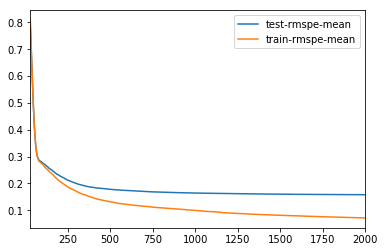

In [112]:
res.loc[30:,["test-rmspe-mean", "train-rmspe-mean"]].plot()
plt.show()

In [113]:
print(res.shape[0])

2000
